**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import shutil
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


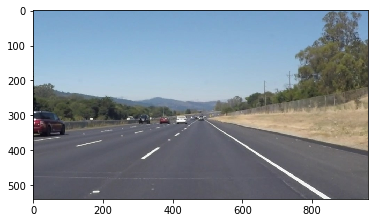

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(original_image, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        return None

    left_top_x = left_bottom_y = right_bottom_x = right_bottom_y = 0
    left_top_y = left_bottom_x = right_top_x = right_top_y = float("+inf")
    left_line_points = []
    right_line_points = []
    slope_threshold = 0.5
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            avg_x, avg_y = math.ceil((x1+x2)/2), math.ceil((y1+y2)/2)
            if slope < -slope_threshold:
                # Then it's the left line (Remember in a image y-coordinate is increasing downwards)
                print("Left line: {}".format(slope))
                left_line_points.append([x1, y1])
                left_line_points.append([x2, y2])
                left_top_x = max(left_top_x, avg_x)
                left_top_y = min(left_top_y, avg_y)
                left_bottom_x = min(left_bottom_x, avg_x)
                left_bottom_y = max(left_bottom_y, avg_y)
            elif slope > slope_threshold:
                # It's the Right line
                print("Right line: {}".format(slope))
                right_line_points.append([x1, y1])
                right_line_points.append([x2, y2])
                right_top_x = min(right_top_x, avg_x)
                right_top_y = min(right_top_y, avg_y)
                right_bottom_x = max(right_bottom_x, avg_x)
                right_bottom_y = max(right_bottom_y, avg_y)
            elif slope == 0:
                print("Slope is 0 for some reason")
                continue
            else:
                print("Filtering out lines with slope {}".format(slope))
                continue

    rows, cols = original_image.shape[:2]

    if left_line_points:
        vx, vy, cx, cy = cv2.fitLine(np.float32(left_line_points), cv2.DIST_L2, 0, 0.01, 0.01)
        slope_unit_vector_left = vy/vx
        intercept_left = cy - (slope_unit_vector_left*cx)
        start_y_left = rows
        if slope_unit_vector_left != 0:
            start_x_left = int((start_y_left - intercept_left)/slope_unit_vector_left)
        else:
            start_x_left = None

    if right_line_points:
        vx, vy, cx, cy = cv2.fitLine(np.float32(right_line_points), cv2.DIST_L2, 0, 0.01, 0.01)
        slope_unit_vector_right = vy/vx
        intercept_right = cy - (slope_unit_vector_right*cx)
        start_y_right = rows
        if slope_unit_vector_right != 0:
            start_x_right = int((start_y_right - intercept_right)/slope_unit_vector_right)
        else:
            start_x_right = None

    # We now have 2 points on left line and 2 points on right line, which means we have the equation of the left and right lines
    # We can find the poi (point-of-intersection)
    # The plan is to extrapolate the line from the bottom of the image till the poi
    # This will result in 2 lines meeting at a point
    # To avoid the meeting I only extrapolate until a certain y coordinate before the poi's y coordinate

    if left_line_points and right_line_points and start_x_left and start_y_left and start_x_right and start_y_right:
        # https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#Given_two_points_on_each_line
        poi = (((intercept_right - intercept_left) / (slope_unit_vector_left - slope_unit_vector_right)),
               ((slope_unit_vector_left * intercept_right) - (slope_unit_vector_right * intercept_left)) / (
               (slope_unit_vector_left - slope_unit_vector_right)))

        print("poi is {}".format(poi))
        end_y_left = int(poi[1]+50)  # int(0.5 * rows)
        end_x_left = int((end_y_left - intercept_left) / slope_unit_vector_left)
        end_y_right = int(poi[1]+50)  # int(0.5 * rows)
        end_x_right = int((end_y_right - intercept_right) / slope_unit_vector_right)

        cv2.line(original_image, (start_x_left, start_y_left), (end_x_left, end_y_left), (255, 0, 0), 7)
        cv2.line(original_image, (start_x_right, start_y_right), (end_x_right, end_y_right), (255, 0, 0), 7)
        return original_image
    return None


def hough_lines(original_image, img, rho, theta, threshold, min_line_len, max_line_gap, thickness=2):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    final_image = draw_lines(original_image, lines, [255, 0, 0], thickness)
    return final_image

# Python 3 has support for cool math symbols.


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def process_image(image):
    imshape = image.shape

    # Step 1: To convert test image from RGB to Gray
    gray_image = grayscale(image)

    # Step 2: Apply some gaussian smoothing
    kernel_size = 5
    gauss_blur_img = gaussian_blur(gray_image, kernel_size)

    # Step 3: Run canny edge detection on this blurred enough,
    # smoothed gray scale image
    low_threshold = 50
    high_threshold = 150
    edges = canny(gauss_blur_img, low_threshold, high_threshold)

    # Step 4: Create a region of interest around the lanes we want to detect
    max_x, min_x, max_y, min_y = imshape[1], 0, imshape[0], 0
    upper_boundary_width = 100
    upper_boundary_top_distance = max_y/2 + 50
    lower_boundary_edge_distance = 105
    vertices = np.array(
        [[(min_x+lower_boundary_edge_distance, max_y),
          (max_x/2-upper_boundary_width/2, upper_boundary_top_distance),
          (max_x/2+upper_boundary_width/2, upper_boundary_top_distance),
          (max_x-lower_boundary_edge_distance, max_y)]],
        dtype=np.int32)
    roi_image = region_of_interest(edges, vertices)

    # Step 5: Run Hough on roi image image and draw the lines
    final_image = hough_lines(image, roi_image, 1, np.pi/180, 1, 15, 8, 4)

    # # Draw the lines on the edge image
    # line_edges = weighted_img(line_image,
    #                           np.dstack((edges, edges, edges)),
    #                           0.8, 2, 0)
    #
    # fig, ax = plt.subplots(3, 2)
    # ax[0, 0].imshow(image)
    # ax[0, 1].imshow(edges)
    # ax[1, 0].imshow(roi_image)
    # ax[1, 1].imshow(line_image)
    # ax[2, 0].imshow(line_edges)
    # plt.show()

    return final_image

## Ideas for Lane Detection Pipeline

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [5]:
input_directory = "test_images"
output_directory = input_directory + "_output"
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
os.makedirs(os.path.join(os.getcwd(), output_directory))

for image_name in os.listdir(input_directory):
    image_path = os.path.join(os.getcwd(), input_directory, image_name)
    image = mpimg.imread(image_path)
    final_image = process_image(image)
    cv2.imwrite(os.path.join(output_directory, image_name), cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

Right line: 0.532608695652174
Right line: 0.5743243243243243
Left line: -0.8648648648648649
Left line: -0.65625
Left line: -0.8372093023255814
Right line: 0.576271186440678
Left line: -0.8448275862068966
Right line: 0.5217391304347826
Left line: -0.7037037037037037
Slope is 0 for some reason
Left line: -0.8125
Left line: -0.8571428571428571
Right line: 0.5789473684210527
Left line: -0.6842105263157895
Left line: -0.8823529411764706
Right line: 0.5757575757575758
Slope is 0 for some reason
Right line: 0.5789473684210527
Right line: 0.6
poi is (array([483.06827], dtype=float32), array([308.3257], dtype=float32))
Right line: 0.6666666666666666
Right line: 0.5625
Left line: -0.6976744186046512
Right line: 0.6246418338108882
Left line: -0.65
Right line: 0.6379310344827587
Right line: 0.6333333333333333
Right line: 0.6
Right line: 0.6216216216216216
Left line: -0.72
Left line: -0.75
Left line: -0.65
Right line: 0.6206896551724138
Left line: -0.6470588235294118
Right line: 0.6190476190476191


In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    imshape = image.shape

    # Step 1: To convert test image from RGB to Gray
    gray_image = grayscale(image)

    # Step 2: Apply some gaussian smoothing
    kernel_size = 5
    gauss_blur_img = gaussian_blur(gray_image, kernel_size)

    # Step 3: Run canny edge detection on this blurred enough,
    # smoothed gray scale image
    low_threshold = 50
    high_threshold = 150
    edges = canny(gauss_blur_img, low_threshold, high_threshold)

    # Step 4: Create a region of interest around the lanes we want to detect
    max_x, min_x, max_y, min_y = imshape[1], 0, imshape[0], 0
    upper_boundary_width = 100
    upper_boundary_top_distance = max_y/2 + 50
    lower_boundary_edge_distance = 105
    vertices = np.array(
        [[(min_x+lower_boundary_edge_distance, max_y),
          (max_x/2-upper_boundary_width/2, upper_boundary_top_distance),
          (max_x/2+upper_boundary_width/2, upper_boundary_top_distance),
          (max_x-lower_boundary_edge_distance, max_y)]],
        dtype=np.int32)
    roi_image = region_of_interest(edges, vertices)

    # Step 5: Run Hough on roi image image and draw the lines
    final_image = hough_lines(image, roi_image, 1, np.pi/180, 1, 15, 8, 4)

    return final_image

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output\solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos\solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

Right line: 0.6028708133971292
Left line: -0.7232142857142857
Right line: 0.6082474226804123
Left line: -0.8333333333333334
Right line: 0.6086956521739131
Left line: -0.6666666666666666
Left line: -0.8260869565217391
Right line: 0.6086956521739131
Left line: -0.7333333333333333
Left line: -0.5882352941176471
Right line: 0.6277372262773723
Right line: 0.6170212765957447
Right line: 0.5714285714285714
Left line: -0.6666666666666666
Left line: -0.7058823529411765
Left line: -0.8666666666666667
Right line: 0.6181818181818182
Right line: 0.6
Left line: -0.7256637168141593
Left line: -0.6410256410256411
Right line: 0.5625
Left line: -0.8125
Right line: 0.5882352941176471
Right line: 0.625
poi is (array([479.88443], dtype=float32), array([303.78973], dtype=float32))
Moviepy - Building video test_videos_output\solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output\solidWhiteRight.mp4



t:   0%|                                                                                                                                          | 0/221 [00:00<?, ?it/s, now=None]

Right line: 0.6
Right line: 0.6434782608695652
Right line: 0.639344262295082
Right line: 0.64375
Left line: -0.8
Left line: -0.711864406779661
Left line: -0.9444444444444444
Left line: -1.0625
Left line: -0.6666666666666666
Left line: -1.0625
Left line: -1.0714285714285714
Filtering out lines with slope -0.058823529411764705
Right line: 0.6666666666666666
Right line: 0.6410256410256411
Left line: -0.6818181818181818
Right line: 0.6274509803921569
Right line: 0.6774193548387096
Left line: -1.0714285714285714
Right line: 0.6458333333333334
Left line: -0.6470588235294118
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.6470588235294118
Filtering out lines with slope -0.5
Right line: 0.625
Left line: -0.7619047619047619
poi is (array([480.06976], dtype=float32), array([303.44824], dtype=float32))
Left line: -0.7
Left line: -0.7563025210084033
Left line: -0.7043478260869566
Right line: 0.6666666666666666
Left line: -0.7563025210084033
Right line: 0.626609442060085

t:   1%|█▊                                                                                                                                | 3/221 [00:00<00:09, 22.06it/s, now=None]

Left line: -0.7384615384615385
Right line: 0.5833333333333334
Right line: 0.5851063829787234
Left line: -0.7171717171717171
Right line: 0.5909090909090909
Right line: 0.7333333333333333
Right line: 0.5945945945945946
Right line: 0.5714285714285714
Left line: -0.7228915662650602
Right line: 0.5625
Left line: -0.7428571428571429
Right line: 0.6162790697674418
Right line: 0.6091954022988506
Right line: 0.6140350877192983
Right line: 0.5945945945945946
Left line: -0.6666666666666666
Left line: -0.7647058823529411
Left line: -0.8125
Left line: -0.6842105263157895
Right line: 0.5897435897435898
Left line: -0.7333333333333333
Left line: -0.7058823529411765
Right line: 0.5714285714285714
Left line: -0.7333333333333333
Left line: -0.6875
Left line: -0.7297297297297297
Right line: 0.5918367346938775
Right line: 0.631578947368421
Right line: 0.625
Right line: 0.6153846153846154
Right line: 0.625
poi is (array([480.55002], dtype=float32), array([302.98972], dtype=float32))
Right line: 0.6275167785

t:   2%|██▉                                                                                                                               | 5/221 [00:00<00:11, 19.13it/s, now=None]

Right line: 0.601123595505618
Right line: 0.6254980079681275
Left line: -0.75
Left line: -0.76
Right line: 0.625
Filtering out lines with slope -0.05263157894736842
Right line: 0.6190476190476191
Left line: -0.7619047619047619
Right line: 0.6153846153846154
Left line: -0.5238095238095238
Right line: 0.5666666666666667
Left line: -0.75
Left line: -0.8
Left line: -0.8666666666666667
Right line: 0.6129032258064516
poi is (array([482.1832], dtype=float32), array([303.13815], dtype=float32))
Right line: 0.6216216216216216
Right line: 0.6272401433691757
Right line: 0.6028708133971292
Right line: 0.6255144032921811
Left line: -0.7407407407407407
Left line: -0.8333333333333334
Left line: -0.6363636363636364
Left line: -0.6551724137931034
Right line: 0.6333333333333333
Right line: 0.5625
Left line: -0.65
Filtering out lines with slope -0.0625
Left line: -0.52
Right line: 0.6086956521739131
Right line: 0.5945945945945946
poi is (array([481.79645], dtype=float32), array([303.7806], dtype=float32)

t:   4%|████▋                                                                                                                             | 8/221 [00:00<00:10, 19.49it/s, now=None]

Right line: 0.6246418338108882
Filtering out lines with slope -0.2608695652173913
Left line: -0.7428571428571429
Left line: -0.85
Right line: 0.6
Right line: 0.625
Right line: 0.6278195488721805
Left line: -0.6875
Right line: 0.6171875
Left line: -0.6363636363636364
Left line: -0.64
Left line: -0.7619047619047619
Left line: -0.8235294117647058
Right line: 0.6161616161616161
Left line: -0.7307692307692307
poi is (array([481.02002], dtype=float32), array([303.3784], dtype=float32))
Left line: -0.6923076923076923
Right line: 0.6262626262626263
Right line: 0.6263345195729537
Left line: -0.6956521739130435
Right line: 0.6023391812865497
Right line: 0.6041666666666666
Right line: 0.6078431372549019
Left line: -0.7021276595744681
Left line: -0.7045454545454546
Left line: -0.6666666666666666
Left line: -0.7037037037037037
Left line: -0.7142857142857143
Right line: 0.6086956521739131
Filtering out lines with slope -0.06896551724137931
Right line: 0.6176470588235294
Right line: 0.611111111111111

t:   5%|██████▍                                                                                                                          | 11/221 [00:00<00:10, 20.04it/s, now=None]

Right line: 0.6956521739130435
Filtering out lines with slope -0.26666666666666666
Right line: 0.5806451612903226
Right line: 0.6470588235294118
Left line: -0.7538461538461538
Right line: 0.6482758620689655
Left line: -0.631578947368421
Right line: 0.6
Right line: 0.6292134831460674
Right line: 0.6206896551724138
Left line: -0.6956521739130435
Right line: 0.6666666666666666
Right line: 0.7058823529411765
Right line: 0.5925925925925926
Filtering out lines with slope 0.3684210526315789
Right line: 0.625
Right line: 0.7333333333333333
Right line: 0.627906976744186
Left line: -0.7358490566037735
Right line: 0.6176470588235294
Left line: -0.9545454545454546
Right line: 0.6
Left line: -0.6923076923076923
Right line: 0.631578947368421
Right line: 0.6170212765957447
Right line: 0.5555555555555556
poi is (array([481.03317], dtype=float32), array([308.1107], dtype=float32))
Filtering out lines with slope -0.19047619047619047
Left line: -0.68
Right line: 0.5869565217391305
Right line: 0.571428571

t:   6%|███████▌                                                                                                                         | 13/221 [00:00<00:11, 17.46it/s, now=None]

Right line: 0.6239669421487604
Left line: -0.717391304347826
Left line: -0.7727272727272727
Right line: 0.6498516320474778
Right line: 0.6233333333333333
Left line: -0.8235294117647058
Left line: -0.5882352941176471
Left line: -0.625
Filtering out lines with slope -0.11764705882352941
Left line: -0.7241379310344828
Right line: 0.6504065040650406
Right line: 0.625
Left line: -0.7777777777777778
Left line: -0.6190476190476191
Left line: -0.6
Left line: -0.7906976744186046
Left line: -0.8181818181818182
Right line: 0.6304347826086957
Left line: -0.7619047619047619
Left line: -0.7352941176470589
Right line: 0.6470588235294118
Right line: 0.5882352941176471
Right line: 0.6481481481481481
Right line: 0.631578947368421
poi is (array([477.3688], dtype=float32), array([309.29428], dtype=float32))
Left line: -0.7295081967213115
Right line: 0.6528497409326425
Right line: 0.6119402985074627
Filtering out lines with slope 0.3157894736842105
Left line: -0.6470588235294118
Filtering out lines with sl

t:   7%|████████▊                                                                                                                        | 15/221 [00:00<00:12, 16.33it/s, now=None]

Right line: 0.6086956521739131
Right line: 0.5882352941176471
Right line: 0.6111111111111112
Right line: 0.6265432098765432
Left line: -0.75
Left line: -0.7019230769230769
Right line: 0.6351351351351351
Right line: 0.6086956521739131
Right line: 0.6243654822335025
Right line: 0.6136363636363636
Left line: -0.7578947368421053
Right line: 0.6071428571428571
Right line: 0.6190476190476191
Left line: -0.75
Left line: -0.7045454545454546
Left line: -0.6111111111111112
Right line: 0.6153846153846154
Right line: 0.6276595744680851
Left line: -0.7
Right line: 0.6176470588235294
Left line: -0.625
Left line: -0.7586206896551724
Left line: -0.5789473684210527
Right line: 0.5882352941176471
Right line: 0.6271186440677966
Right line: 0.6
Right line: 0.627906976744186
Left line: -0.7
Right line: 0.631578947368421
poi is (array([478.57816], dtype=float32), array([304.53226], dtype=float32))
Right line: 0.6666666666666666
Right line: 0.6713615023474179
Right line: 0.6428571428571429
Right line: 0.6323

t:   8%|█████████▉                                                                                                                       | 17/221 [00:00<00:13, 15.37it/s, now=None]

Right line: 0.7272727272727273
Right line: 0.5945945945945946
Right line: 0.5625
Right line: 0.6333333333333333
Right line: 0.7272727272727273
Right line: 0.6111111111111112
Left line: -0.7272727272727273
Right line: 0.6103896103896104
Left line: -0.6666666666666666
Left line: -0.631578947368421
Right line: 0.6595744680851063
Right line: 0.6351351351351351
Right line: 0.6842105263157895
Right line: 0.6176470588235294
Left line: -0.6111111111111112
Right line: 0.6346153846153846
Right line: 0.5625
Right line: 0.65
Left line: -0.75
Left line: -0.72
Right line: 0.5833333333333334
Right line: 0.6
Right line: 0.6
Right line: 0.6666666666666666
Right line: 0.5555555555555556
Right line: 0.6122448979591837
Left line: -0.75
poi is (array([482.3909], dtype=float32), array([302.1526], dtype=float32))
Right line: 0.6237623762376238
Left line: -0.6842105263157895
Right line: 0.6262975778546713
Left line: -0.7692307692307693
Right line: 0.6666666666666666
Right line: 0.6923076923076923
Left line: -

t:   9%|███████████                                                                                                                      | 19/221 [00:01<00:13, 15.44it/s, now=None]

Right line: 0.6549707602339181
Right line: 0.6541353383458647
Right line: 0.56
Right line: 0.7037037037037037
Left line: -0.7
Left line: -0.8888888888888888
Left line: -0.7666666666666667
Left line: -0.8421052631578947
Right line: 0.5957446808510638
Right line: 0.5555555555555556
Right line: 0.6190476190476191
Right line: 0.6379310344827587
Left line: -0.71875
Right line: 0.6666666666666666
Right line: 0.6410256410256411
Left line: -0.7272727272727273
Right line: 0.7222222222222222
Right line: 0.7142857142857143
Right line: 0.6481481481481481
Right line: 0.6451612903225806
Right line: 0.6
Right line: 0.7058823529411765
Right line: 0.5625
Right line: 0.625
Left line: -0.7777777777777778
Right line: 0.5925925925925926
Right line: 0.5789473684210527
poi is (array([478.96844], dtype=float32), array([303.7423], dtype=float32))
Right line: 0.6272189349112426
Left line: -0.6190476190476191
Left line: -0.7647058823529411
Right line: 0.625
Right line: 0.6518518518518519
Left line: -0.8235294117

t:  10%|████████████▎                                                                                                                    | 21/221 [00:01<00:12, 15.53it/s, now=None]

Filtering out lines with slope 0.5
Filtering out lines with slope 0.26666666666666666
Right line: 0.6071428571428571
Right line: 0.6091954022988506
Right line: 0.6129032258064516
Right line: 0.6666666666666666
Right line: 0.6538461538461539
Left line: -0.75
Left line: -0.5263157894736842
Right line: 0.6407766990291263
Left line: -0.6739130434782609
Right line: 0.6041666666666666
Right line: 0.6615384615384615
Left line: -0.7272727272727273
Left line: -0.7272727272727273
Left line: -0.7
Right line: 0.5625
Right line: 0.6538461538461539
Left line: -0.7222222222222222
Right line: 0.5833333333333334
Filtering out lines with slope -0.14814814814814814
Left line: -0.6666666666666666
Right line: 0.5833333333333334
Right line: 0.5882352941176471
Right line: 0.6470588235294118
Right line: 0.6666666666666666
Right line: 0.6666666666666666
poi is (array([484.13235], dtype=float32), array([306.50134], dtype=float32))
Right line: 0.5625
Right line: 0.6129032258064516
Right line: 0.6
Left line: -0.6

t:  10%|█████████████▍                                                                                                                   | 23/221 [00:01<00:13, 15.07it/s, now=None]

Right line: 0.575
Right line: 0.6666666666666666
Left line: -0.71875
Right line: 0.6505376344086021
Left line: -0.6944444444444444
Right line: 0.6578947368421053
Left line: -0.6
Right line: 0.6666666666666666
Left line: -0.7142857142857143
Right line: 0.6086956521739131
Right line: 0.6071428571428571
Right line: 0.6428571428571429
Left line: -0.5333333333333333
Right line: 0.68
Right line: 0.6595744680851063
Left line: -0.7058823529411765
Left line: -0.631578947368421
Right line: 0.6842105263157895
Left line: -0.7419354838709677
Right line: 0.6794871794871795
Right line: 0.7
Right line: 0.5555555555555556
Right line: 0.68
Right line: 0.6
Left line: -0.7301587301587301
Right line: 0.7037037037037037
Filtering out lines with slope -0.15789473684210525
Right line: 0.5882352941176471
Right line: 0.5714285714285714
Right line: 0.7333333333333333
poi is (array([482.03137], dtype=float32), array([306.24237], dtype=float32))
Right line: 0.6526946107784432
Right line: 0.6272727272727273
Left li

t:  11%|██████████████▌                                                                                                                  | 25/221 [00:01<00:12, 15.23it/s, now=None]

Left line: -0.7352941176470589
Left line: -0.7714285714285715
Right line: 0.5806451612903226
Right line: 0.6503496503496503
Left line: -0.6923076923076923
Right line: 0.65
Left line: -0.725
Left line: -0.7666666666666667
Right line: 0.6415094339622641
Right line: 0.6413043478260869
Right line: 0.6451612903225806
Left line: -0.775
Left line: -0.8
Left line: -0.7105263157894737
Right line: 0.6595744680851063
Left line: -0.7333333333333333
Right line: 0.6216216216216216
Left line: -0.7391304347826086
Right line: 0.6590909090909091
Right line: 0.6666666666666666
Right line: 0.6428571428571429
Left line: -0.6666666666666666
Left line: -0.75
Right line: 0.65
Right line: 0.6363636363636364
Right line: 0.6527777777777778
Left line: -0.7
Right line: 0.6111111111111112
Right line: 0.6521739130434783
Right line: 0.6842105263157895
Right line: 0.6666666666666666
Right line: 0.6585365853658537
poi is (array([481.42242], dtype=float32), array([305.23535], dtype=float32))
Right line: 0.6875
Right lin

t:  12%|███████████████▊                                                                                                                 | 27/221 [00:01<00:13, 14.54it/s, now=None]

Right line: 0.625
Left line: -0.6842105263157895
Left line: -0.6697247706422018
Right line: 0.6551724137931034
Right line: 0.6521739130434783
Right line: 0.6551724137931034
Right line: 0.6269113149847095
Left line: -0.6875
Left line: -0.6744186046511628
Left line: -0.8235294117647058
Left line: -0.7319587628865979
Left line: -0.5625
Left line: -0.8125
Left line: -0.6666666666666666
Filtering out lines with slope -0.05555555555555555
Left line: -0.7368421052631579
Left line: -0.6875
Left line: -0.7252747252747253
Right line: 0.6470588235294118
Right line: 0.6477272727272727
poi is (array([479.98264], dtype=float32), array([306.3945], dtype=float32))
Right line: 0.5909090909090909
Right line: 0.5555555555555556
Right line: 0.6086956521739131
Right line: 0.5789473684210527
Right line: 0.6074766355140186
Right line: 0.6896551724137931
Left line: -0.7837837837837838
Right line: 0.6
Left line: -0.676056338028169
Left line: -0.8125
Left line: -0.8888888888888888
Right line: 0.6190476190476191

t:  13%|████████████████▉                                                                                                                | 29/221 [00:01<00:13, 14.34it/s, now=None]

Right line: 0.6506024096385542
Right line: 0.6190476190476191
Right line: 0.625
Right line: 0.6
Right line: 0.6265822784810127
Right line: 0.6190476190476191
Left line: -0.75
Left line: -0.6470588235294118
Left line: -0.7368421052631579
Right line: 0.7272727272727273
Right line: 0.6216216216216216
Filtering out lines with slope -0.4666666666666667
Left line: -0.7727272727272727
Left line: -0.7272727272727273
Filtering out lines with slope -0.1111111111111111
Left line: -0.6363636363636364
Right line: 0.6470588235294118
Right line: 0.6231884057971014
Right line: 0.6530612244897959
Right line: 0.6388888888888888
Right line: 0.6666666666666666
poi is (array([483.47855], dtype=float32), array([307.09442], dtype=float32))
Right line: 0.6244343891402715
Filtering out lines with slope 0.35
Right line: 0.6714285714285714
Right line: 0.6326530612244898
Right line: 0.64
Left line: -0.7
Right line: 0.6349206349206349
Right line: 0.6363636363636364
Right line: 0.6086956521739131
Left line: -0.7037

t:  14%|██████████████████                                                                                                               | 31/221 [00:01<00:12, 15.03it/s, now=None]

Right line: 0.6216216216216216
Right line: 0.5555555555555556
Right line: 0.7073170731707317
Right line: 0.6829268292682927
Left line: -0.6875
Right line: 0.6410256410256411
Left line: -0.6666666666666666
Right line: 0.6818181818181818
Left line: -0.7
Right line: 0.6379310344827587
Right line: 0.5625
Right line: 0.6
Right line: 0.6829268292682927
Left line: -0.7586206896551724
Right line: 0.640625
Right line: 0.5789473684210527
Right line: 0.5957446808510638
Right line: 0.7
Right line: 0.6
Right line: 0.6571428571428571
Right line: 0.6097560975609756
Right line: 0.65625
Right line: 0.7142857142857143
Right line: 0.6363636363636364
Right line: 0.6111111111111112
Left line: -0.8
Right line: 0.5882352941176471
Right line: 0.6875
poi is (array([478.3388], dtype=float32), array([302.72925], dtype=float32))
Right line: 0.6333333333333333
Right line: 0.7
Right line: 0.6270096463022508
Left line: -0.64
Right line: 0.6727272727272727
Left line: -0.625
Right line: 0.7333333333333333
Right line: 

t:  15%|███████████████████▎                                                                                                             | 33/221 [00:02<00:13, 14.45it/s, now=None]

Right line: 0.6691176470588235
Right line: 0.675
Right line: 0.6244725738396625
Right line: 0.6346153846153846
Left line: -0.7272727272727273
Right line: 0.6666666666666666
Right line: 0.6736842105263158
Left line: -0.7045454545454546
Left line: -0.6818181818181818
Left line: -0.7073170731707317
Right line: 0.6382978723404256
Right line: 0.5789473684210527
Right line: 0.5909090909090909
Left line: -0.7272727272727273
Left line: -0.72
Right line: 0.6206896551724138
Left line: -0.7222222222222222
Filtering out lines with slope -0.125
Left line: -0.7391304347826086
Left line: -0.625
Right line: 0.6265060240963856
Right line: 0.6666666666666666
Left line: -0.7333333333333333
Right line: 0.6363636363636364
Filtering out lines with slope -0.0625
Left line: -0.6666666666666666
Right line: 0.6666666666666666
poi is (array([481.3207], dtype=float32), array([304.4715], dtype=float32))
Right line: 0.6258503401360545
Right line: 0.6523297491039427
Filtering out lines with slope 0.35294117647058826

t:  16%|████████████████████▍                                                                                                            | 35/221 [00:02<00:12, 14.72it/s, now=None]

Right line: 0.6351351351351351
Left line: -0.6764705882352942
Right line: 0.6695652173913044
Right line: 0.6666666666666666
Right line: 0.6245847176079734
Left line: -0.746031746031746
Right line: 0.6296296296296297
Right line: 0.6716417910447762
Right line: 0.6231884057971014
Filtering out lines with slope -0.48
Left line: -0.7894736842105263
Filtering out lines with slope -0.42105263157894735
Right line: 0.6
Right line: 0.6206896551724138
Left line: -0.6666666666666666
Right line: 0.6071428571428571
Left line: -0.6666666666666666
Right line: 0.5714285714285714
Left line: -0.8636363636363636
Right line: 0.6857142857142857
Right line: 0.6
poi is (array([479.10907], dtype=float32), array([304.81717], dtype=float32))
Right line: 0.65
Right line: 0.55
Right line: 0.6710526315789473
Left line: -0.75
Right line: 0.7037037037037037
Right line: 0.6818181818181818
Left line: -0.7195121951219512
Right line: 0.6666666666666666
Left line: -0.6987951807228916
Right line: 0.6551724137931034
Right l

t:  17%|█████████████████████▌                                                                                                           | 37/221 [00:02<00:12, 14.75it/s, now=None]

Right line: 0.6078431372549019
Left line: -0.6972477064220184
Right line: 0.6170212765957447
Right line: 0.8275862068965517
Left line: -0.8125
Right line: 0.5625
Left line: -0.6875
Right line: 0.5901639344262295
Right line: 0.7058823529411765
Right line: 0.6923076923076923
Right line: 0.64
Left line: -0.6875
Left line: -0.625
Filtering out lines with slope 0.4
Right line: 0.6
Left line: -0.8333333333333334
Right line: 0.6774193548387096
Left line: -0.8
Right line: 0.5625
Left line: -0.7777777777777778
Right line: 0.6
Left line: -0.6904761904761905
Right line: 0.55
Right line: 0.5909090909090909
Right line: 0.6
Right line: 0.5555555555555556
Left line: -0.6666666666666666
Left line: -0.7941176470588235
Right line: 0.5833333333333334
Right line: 0.6363636363636364
Left line: -0.7010309278350515
Right line: 0.6842105263157895
Right line: 0.5882352941176471
Left line: -0.7916666666666666
Right line: 0.5833333333333334
Filtering out lines with slope 0.05
Right line: 0.5806451612903226
poi i

t:  18%|██████████████████████▊                                                                                                          | 39/221 [00:02<00:13, 13.51it/s, now=None]

Left line: -0.78125
Right line: 0.6
Right line: 0.6694915254237288
Right line: 0.5925925925925926
Left line: -0.7647058823529411
Right line: 0.6082474226804123
Right line: 0.5833333333333334
Left line: -0.6944444444444444
Left line: -0.8095238095238095
Left line: -0.65
Left line: -0.65
Right line: 0.6851851851851852
Right line: 0.7
Right line: 0.7272727272727273
Left line: -0.7666666666666667
Right line: 0.5652173913043478
Left line: -0.6111111111111112
Right line: 0.7333333333333333
Right line: 0.691358024691358
Left line: -0.6952380952380952
Left line: -0.8
Right line: 0.6595744680851063
Right line: 0.7142857142857143
Left line: -0.7894736842105263
Right line: 0.6666666666666666
Right line: 0.5625
Left line: -0.7222222222222222
Left line: -0.7333333333333333
Right line: 0.6428571428571429
Left line: -0.9375
Right line: 0.5882352941176471
Right line: 0.7058823529411765
Right line: 0.5909090909090909
Right line: 0.7058823529411765
Right line: 0.68
Right line: 0.7
Right line: 0.58823529

t:  19%|███████████████████████▉                                                                                                         | 41/221 [00:02<00:14, 12.84it/s, now=None]

Right line: 0.6086956521739131
Right line: 0.6264591439688716
Right line: 0.6269230769230769
Left line: -0.7647058823529411
Right line: 0.6
Left line: -0.9333333333333333
Left line: -0.875
Right line: 0.6190476190476191
Filtering out lines with slope 0.3333333333333333
Right line: 0.6176470588235294
Right line: 0.5882352941176471
Left line: -0.64
Right line: 0.75
Right line: 0.6567164179104478
Right line: 0.5789473684210527
Right line: 0.6216216216216216
Right line: 0.6071428571428571
Left line: -0.6842105263157895
Left line: -0.6666666666666666
Right line: 0.6526315789473685
Left line: -0.85
Right line: 0.6
Right line: 0.5625
Right line: 0.6
Right line: 0.625
Right line: 0.631578947368421
Left line: -0.7142857142857143
Left line: -0.7391304347826086
Right line: 0.5882352941176471
Right line: 0.6190476190476191
Left line: -0.7647058823529411
Right line: 0.6153846153846154
Right line: 0.6666666666666666
poi is (array([481.99542], dtype=float32), array([303.13437], dtype=float32))
Right 

t:  19%|█████████████████████████                                                                                                        | 43/221 [00:02<00:12, 13.70it/s, now=None]

Right line: 0.627906976744186
Right line: 0.6617647058823529
Left line: -0.8076923076923077
Right line: 0.6428571428571429
Right line: 0.5882352941176471
Right line: 0.6575342465753424
Left line: -0.7
Right line: 0.6333333333333333
Right line: 0.625
Right line: 0.625
Right line: 0.6666666666666666
Right line: 0.6086956521739131
Left line: -0.696969696969697
Right line: 0.6086956521739131
Right line: 0.6153846153846154
Left line: -0.7777777777777778
Left line: -0.7
Right line: 0.6206896551724138
Right line: 0.6363636363636364
Right line: 0.6470588235294118
Right line: 0.6153846153846154
poi is (array([481.38516], dtype=float32), array([303.50897], dtype=float32))
Right line: 0.6888888888888889
Right line: 0.6726618705035972
Left line: -0.7894736842105263
Right line: 0.6690140845070423
Left line: -0.6896551724137931
Left line: -0.8
Right line: 0.639344262295082
Filtering out lines with slope -0.05263157894736842
Right line: 0.6666666666666666
Right line: 0.6421052631578947
Right line: 0.

t:  20%|██████████████████████████▎                                                                                                      | 45/221 [00:02<00:12, 14.23it/s, now=None]

Right line: 0.6428571428571429
Right line: 0.7
Left line: -0.7380952380952381
Right line: 0.6255506607929515
Right line: 0.6914893617021277
Right line: 0.628
Left line: -0.7
Left line: -0.6
Right line: 0.6190476190476191
Right line: 0.625
Filtering out lines with slope -0.05
Right line: 0.6704545454545454
Right line: 0.59375
Right line: 0.6153846153846154
Right line: 0.6862745098039216
Right line: 0.6296296296296297
Right line: 0.6153846153846154
Right line: 0.5625
Left line: -0.6956521739130435
Right line: 0.6
Left line: -0.7368421052631579
Right line: 0.6666666666666666
Right line: 0.6666666666666666
Right line: 0.6190476190476191
Right line: 0.6956521739130435
Right line: 0.6111111111111112
poi is (array([481.89236], dtype=float32), array([302.64963], dtype=float32))
Right line: 0.6851851851851852
Right line: 0.6086956521739131
Right line: 0.6
Right line: 0.6272727272727273
Right line: 0.628099173553719
Right line: 0.6517857142857143
Left line: -0.6956521739130435
Left line: -0.7254

t:  21%|███████████████████████████▍                                                                                                     | 47/221 [00:03<00:12, 14.25it/s, now=None]

Right line: 0.6732673267326733
Right line: 0.6276150627615062
Left line: -0.696969696969697
Right line: 0.6311475409836066
Left line: -0.7540983606557377
Left line: -0.7413793103448276
Right line: 0.6707818930041153
Right line: 0.625
Left line: -0.7014925373134329
Right line: 0.6129032258064516
Right line: 0.6275510204081632
Left line: -0.7083333333333334
Right line: 0.68
poi is (array([480.7029], dtype=float32), array([301.22897], dtype=float32))
Right line: 0.6720647773279352
Left line: -0.8
Right line: 0.6456310679611651
Left line: -0.7341772151898734
Left line: -0.8260869565217391
Right line: 0.6444444444444445
Right line: 0.6506024096385542
Right line: 0.64
Left line: -0.775
Right line: 0.6448598130841121
Left line: -0.7894736842105263
Left line: -0.7894736842105263
Left line: -0.7586206896551724
Right line: 0.6571428571428571
Right line: 0.6719367588932806
Left line: -0.6111111111111112
Right line: 0.6666666666666666
Right line: 0.6363636363636364
Right line: 0.65
Left line: -0.7

t:  22%|████████████████████████████▌                                                                                                    | 49/221 [00:03<00:11, 15.38it/s, now=None]

Left line: -0.6
Left line: -0.8095238095238095
Right line: 0.6243654822335025
Left line: -0.7058823529411765
Right line: 0.6140350877192983
Right line: 0.6086956521739131
Right line: 0.6504065040650406
Left line: -0.7244897959183674
Right line: 0.6379310344827587
Right line: 0.6582278481012658
Left line: -0.7878787878787878
Right line: 0.6285714285714286
Left line: -0.8421052631578947
Right line: 0.64
Left line: -0.7708333333333334
Left line: -0.782608695652174
Left line: -0.8235294117647058
Left line: -0.5882352941176471
Left line: -0.5882352941176471
Left line: -0.7246376811594203
Right line: 0.6363636363636364
Right line: 0.6527777777777778
Right line: 0.6410256410256411
Left line: -0.7083333333333334
Left line: -0.75
Right line: 0.6086956521739131
Left line: -0.6875
Right line: 0.6842105263157895
Right line: 0.6521739130434783
Right line: 0.6288659793814433
Right line: 0.6078431372549019
Right line: 0.631578947368421
poi is (array([480.72372], dtype=float32), array([302.95633], dty

t:  23%|█████████████████████████████▊                                                                                                   | 51/221 [00:03<00:12, 14.05it/s, now=None]

Left line: -0.7142857142857143
Right line: 0.6896551724137931
Left line: -0.631578947368421
Right line: 0.6122448979591837
Right line: 0.7058823529411765
Right line: 0.6256410256410256
Left line: -0.7692307692307693
Right line: 0.6842105263157895
Right line: 0.6296296296296297
Right line: 0.6388888888888888
Left line: -0.7121212121212122
Left line: -0.65
Left line: -0.6190476190476191
Left line: -0.8235294117647058
Left line: -0.7058823529411765
Right line: 0.6710526315789473
Left line: -0.631578947368421
Right line: 0.7
Left line: -0.7115384615384616
Right line: 0.7368421052631579
Right line: 0.6851851851851852
Right line: 0.75
Right line: 0.6101694915254238
Left line: -0.7105263157894737
Left line: -0.7222222222222222
Right line: 0.6666666666666666
Left line: -0.75
Right line: 0.7096774193548387
Right line: 0.7391304347826086
Right line: 0.75
Right line: 0.5625
Filtering out lines with slope -0.09090909090909091
Right line: 0.5789473684210527
Left line: -0.6
Right line: 0.58823529411

t:  24%|██████████████████████████████▉                                                                                                  | 53/221 [00:03<00:12, 13.42it/s, now=None]

Right line: 0.625
Right line: 0.6875
Right line: 0.6875
Right line: 0.6282051282051282
Right line: 0.7307692307692307
Left line: -0.7647058823529411
Left line: -0.6842105263157895
Left line: -0.7391304347826086
Right line: 0.6264367816091954
Right line: 0.6301369863013698
Left line: -0.5909090909090909
Right line: 0.5897435897435898
Left line: -0.8125
Left line: -0.7857142857142857
Left line: -0.631578947368421
Right line: 0.625
Filtering out lines with slope -0.13333333333333333
Left line: -0.6
Right line: 0.5769230769230769
Right line: 0.5789473684210527
Left line: -0.7619047619047619
Right line: 0.64
Right line: 0.6
Right line: 0.7058823529411765
Left line: -0.6666666666666666
Right line: 0.6956521739130435
Right line: 0.6470588235294118
poi is (array([477.6457], dtype=float32), array([304.49564], dtype=float32))
Right line: 0.6842105263157895
Left line: -0.7037037037037037
Right line: 0.6745283018867925
Right line: 0.6385542168674698
Right line: 0.5806451612903226
Right line: 0.671

t:  25%|████████████████████████████████                                                                                                 | 55/221 [00:03<00:12, 13.53it/s, now=None]

Right line: 0.6923076923076923
Right line: 0.6434108527131783
Right line: 0.6086956521739131
Right line: 0.6461538461538462
Right line: 0.6517857142857143
Right line: 0.6363636363636364
Left line: -0.7647058823529411
Right line: 0.7272727272727273
Left line: -0.7
Left line: -0.8181818181818182
Right line: 0.7391304347826086
Right line: 0.6585365853658537
Left line: -0.7241379310344828
Right line: 0.5882352941176471
Right line: 0.6111111111111112
Right line: 0.6111111111111112
Right line: 0.75
Left line: -0.6
Right line: 0.6607142857142857
Left line: -0.7058823529411765
Right line: 0.6774193548387096
Right line: 0.5909090909090909
Right line: 0.6578947368421053
Left line: -0.631578947368421
Right line: 0.6666666666666666
poi is (array([479.39557], dtype=float32), array([304.06024], dtype=float32))
Right line: 0.6551724137931034
Right line: 0.6379310344827587
Right line: 0.6237623762376238
Right line: 0.6268221574344023
Left line: -0.6538461538461539
Right line: 0.628099173553719
Left li

t:  26%|█████████████████████████████████▎                                                                                               | 57/221 [00:03<00:12, 13.66it/s, now=None]

Right line: 0.6700507614213198
Right line: 0.6254980079681275
Right line: 0.6666666666666666
Left line: -0.6521739130434783
Right line: 0.6694915254237288
Left line: -0.6551724137931034
Filtering out lines with slope -0.2
Left line: -0.7272727272727273
Right line: 0.6075949367088608
Left line: -0.68
Left line: -0.68
Right line: 0.6341463414634146
Left line: -0.7435897435897436
Right line: 0.6153846153846154
Left line: -0.7619047619047619
Filtering out lines with slope -0.16
Right line: 0.6785714285714286
Left line: -0.6470588235294118
Right line: 0.6774193548387096
Right line: 0.7058823529411765
Right line: 0.6666666666666666
poi is (array([478.3996], dtype=float32), array([306.44955], dtype=float32))
Right line: 0.6724137931034483
Right line: 0.6266666666666667
Right line: 0.6538461538461539
Right line: 0.6363636363636364
Left line: -0.75
Filtering out lines with slope 0.4666666666666667
Left line: -0.7407407407407407
Right line: 0.6086956521739131
Right line: 0.625
Right line: 0.66
L

t:  27%|██████████████████████████████████▍                                                                                              | 59/221 [00:03<00:11, 14.45it/s, now=None]

Right line: 0.6713615023474179
Right line: 0.6288659793814433
Left line: -0.7391304347826086
Left line: -0.6666666666666666
Left line: -0.7586206896551724
Right line: 0.6255506607929515
Left line: -0.6595744680851063
Left line: -0.6666666666666666
Left line: -0.5897435897435898
Right line: 0.68
Left line: -0.6428571428571429
Right line: 0.6451612903225806
Right line: 0.6923076923076923
Left line: -0.6666666666666666
Left line: -0.7647058823529411
Left line: -0.5333333333333333
Right line: 0.6
Right line: 0.6
Right line: 0.6666666666666666
Left line: -0.5555555555555556
Left line: -0.6470588235294118
poi is (array([479.29742], dtype=float32), array([305.98987], dtype=float32))
Right line: 0.6284403669724771
Left line: -0.6785714285714286
Left line: -0.6987951807228916
Left line: -0.7307692307692307
Right line: 0.673992673992674
Right line: 0.6703296703296703
Right line: 0.6287425149700598
Left line: -0.6956521739130435
Left line: -0.5333333333333333
Left line: -0.7333333333333333
Right 

t:  28%|███████████████████████████████████▌                                                                                             | 61/221 [00:04<00:10, 14.71it/s, now=None]

Right line: 0.75
Right line: 0.6454545454545455
Right line: 0.6785714285714286
Left line: -0.65
Left line: -0.672566371681416
Right line: 0.6153846153846154
Left line: -0.7321428571428571
Right line: 0.6460176991150443
Right line: 0.6875
Left line: -0.8
Left line: -0.8
Right line: 0.6842105263157895
Right line: 0.6388888888888888
Right line: 0.6818181818181818
Right line: 0.6388888888888888
Right line: 0.6363636363636364
Right line: 0.68
Right line: 0.7
Left line: -0.8636363636363636
Right line: 0.6206896551724138
Right line: 0.6296296296296297
Left line: -0.7222222222222222
Right line: 0.6363636363636364
Left line: -0.7878787878787878
Right line: 0.5882352941176471
Left line: -0.6756756756756757
Left line: -0.7777777777777778
Right line: 0.6842105263157895
Right line: 0.6410256410256411
Right line: 0.6206896551724138
Left line: -0.625
Right line: 0.625
Left line: -0.7435897435897436
Right line: 0.6296296296296297
Left line: -0.75
poi is (array([478.793], dtype=float32), array([306.342

t:  29%|████████████████████████████████████▊                                                                                            | 63/221 [00:04<00:11, 13.22it/s, now=None]

Right line: 0.6454545454545455
Right line: 0.6735395189003437
Left line: -0.6697247706422018
Right line: 0.6756756756756757
Right line: 0.5833333333333334
Left line: -0.7142857142857143
Left line: -0.7272727272727273
Right line: 0.6590909090909091
Left line: -0.75
Right line: 0.5555555555555556
Left line: -0.6666666666666666
Left line: -0.8666666666666667
Right line: 0.6857142857142857
Right line: 0.6851851851851852
Left line: -0.8
Right line: 0.5925925925925926
Left line: -0.6875
Left line: -0.75
Right line: 0.660377358490566
Left line: -0.6521739130434783
Right line: 0.6585365853658537
Right line: 0.6875
Left line: -0.6756756756756757
Filtering out lines with slope -0.26666666666666666
poi is (array([478.92572], dtype=float32), array([306.72192], dtype=float32))
Right line: 0.5882352941176471
Left line: -0.7692307692307693
Right line: 0.6842105263157895
Right line: 0.6
Left line: -0.6470588235294118
Filtering out lines with slope -0.05555555555555555
Right line: 0.6379310344827587
Ri

t:  29%|█████████████████████████████████████▉                                                                                           | 65/221 [00:04<00:12, 12.95it/s, now=None]

Left line: -0.5714285714285714
Right line: 0.6460674157303371
Left line: -0.68
Right line: 0.6379310344827587
Right line: 0.6129032258064516
Right line: 0.7307692307692307
Right line: 0.6842105263157895
Right line: 0.7142857142857143
Left line: -0.7727272727272727
Right line: 0.6
Right line: 0.6086956521739131
Left line: -0.7142857142857143
Right line: 0.7142857142857143
Filtering out lines with slope -0.21052631578947367
Right line: 0.6
Right line: 0.6470588235294118
Left line: -0.6666666666666666
Right line: 0.5625
Right line: 0.6190476190476191
Left line: -0.65
Right line: 0.7058823529411765
Right line: 0.5882352941176471
Filtering out lines with slope -0.1875
Left line: -0.5882352941176471
Right line: 0.5625
Right line: 0.5625
Left line: -0.7647058823529411
Right line: 0.6415094339622641
Right line: 0.631578947368421
Left line: -0.6
Right line: 0.7307692307692307
Left line: -0.6875
Right line: 0.6363636363636364
Right line: 0.6
Right line: 0.6470588235294118
Left line: -0.823529411

t:  30%|███████████████████████████████████████                                                                                          | 67/221 [00:04<00:12, 12.76it/s, now=None]

Filtering out lines with slope 0.23529411764705882
Right line: 0.6363636363636364
Right line: 0.5957446808510638
Filtering out lines with slope -0.4
Right line: 0.625
Right line: 0.6170212765957447
Right line: 0.6388888888888888
Right line: 0.5555555555555556
Right line: 0.7
Right line: 0.7058823529411765
Right line: 0.7083333333333334
Right line: 0.5882352941176471
Left line: -0.65625
Left line: -0.7222222222222222
Right line: 0.7222222222222222
Right line: 0.5625
Right line: 0.5806451612903226
Right line: 0.5555555555555556
Filtering out lines with slope 0.2777777777777778
Left line: -0.6538461538461539
Filtering out lines with slope -0.25
Left line: -0.7586206896551724
Right line: 0.6818181818181818
Right line: 0.6296296296296297
Left line: -0.6956521739130435
Right line: 0.7333333333333333
Right line: 0.6923076923076923
Right line: 0.6
Right line: 0.6176470588235294
Right line: 0.5625
Right line: 0.6
Right line: 0.6875
Right line: 0.6
poi is (array([479.8034], dtype=float32), array

t:  31%|████████████████████████████████████████▎                                                                                        | 69/221 [00:04<00:11, 12.83it/s, now=None]

Right line: 0.55
Left line: -0.5416666666666666
Right line: 0.7333333333333333
Right line: 0.6731391585760518
Right line: 0.6785714285714286
Right line: 0.6619718309859155
Left line: -0.6666666666666666
Right line: 0.65625
Left line: -0.6
Left line: -0.6388888888888888
Right line: 0.6623376623376623
Right line: 0.6595744680851063
Right line: 0.6818181818181818
Right line: 0.6764705882352942
Right line: 0.6712328767123288
Left line: -0.6
Filtering out lines with slope -0.09090909090909091
Right line: 0.6785714285714286
Right line: 0.6923076923076923
Right line: 0.6666666666666666
Right line: 0.6551724137931034
Left line: -0.6666666666666666
Right line: 0.6818181818181818
poi is (array([481.25204], dtype=float32), array([305.0484], dtype=float32))
Right line: 0.6301369863013698
Right line: 0.6739130434782609
Right line: 0.6304347826086957
Right line: 0.6595744680851063
Left line: -0.6666666666666666
Left line: -0.6333333333333333
Left line: -0.631578947368421
Right line: 0.66666666666666

t:  32%|█████████████████████████████████████████▍                                                                                       | 71/221 [00:04<00:11, 13.37it/s, now=None]

Right line: 0.6933333333333334
Right line: 0.6304347826086957
Left line: -0.7586206896551724
Left line: -0.725
Right line: 0.6571428571428571
Right line: 0.6111111111111112
Right line: 0.6140350877192983
Right line: 0.65625
Left line: -0.6615384615384615
Right line: 0.6551724137931034
Right line: 0.5625
Right line: 0.6060606060606061
Right line: 0.5789473684210527
Right line: 0.5652173913043478
Left line: -0.6818181818181818
Right line: 0.6610169491525424
Left line: -0.7647058823529411
Right line: 0.6666666666666666
Right line: 0.5555555555555556
Left line: -0.5882352941176471
Right line: 0.8235294117647058
Right line: 0.5555555555555556
Right line: 0.65
Right line: 0.5625
poi is (array([478.34955], dtype=float32), array([306.62973], dtype=float32))
Left line: -0.6428571428571429
Right line: 0.6578947368421053
Left line: -0.6707317073170732
Right line: 0.7272727272727273
Right line: 0.6428571428571429
Right line: 0.6086956521739131
Right line: 0.6296296296296297
Right line: 0.629139072

t:  33%|██████████████████████████████████████████▌                                                                                      | 73/221 [00:05<00:11, 13.30it/s, now=None]

Right line: 0.6298701298701299
Right line: 0.6747967479674797
Right line: 0.6762820512820513
Left line: -0.7222222222222222
Left line: -0.6794871794871795
Right line: 0.6788990825688074
Right line: 0.6721311475409836
Left line: -0.6170212765957447
Left line: -0.6724137931034483
Right line: 0.6379310344827587
Left line: -0.625
Left line: -0.7058823529411765
Right line: 0.6956521739130435
Left line: -0.7222222222222222
Left line: -0.625
Left line: -0.696969696969697
Right line: 0.6521739130434783
Right line: 0.6857142857142857
Left line: -0.7368421052631579
Left line: -0.625
Left line: -0.6666666666666666
Right line: 0.7058823529411765
Left line: -0.7333333333333333
Right line: 0.6216216216216216
Right line: 0.7037037037037037
Left line: -0.6764705882352942
poi is (array([478.64584], dtype=float32), array([304.9868], dtype=float32))
Right line: 0.6754098360655738
Right line: 0.6484018264840182
Left line: -0.7222222222222222
Right line: 0.6470588235294118
Left line: -0.6545454545454545
Le

t:  34%|███████████████████████████████████████████▊                                                                                     | 75/221 [00:05<00:11, 13.05it/s, now=None]

Right line: 0.6763754045307443
Right line: 0.6494845360824743
Left line: -0.6475409836065574
Right line: 0.6744186046511628
Right line: 0.6462585034013606
Left line: -0.696969696969697
Left line: -0.7045454545454546
Left line: -0.6979166666666666
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.625
Left line: -0.6666666666666666
Right line: 0.6507936507936508
Right line: 0.6666666666666666
Right line: 0.6473684210526316
Left line: -0.6666666666666666
Left line: -0.65
Left line: -0.7222222222222222
Right line: 0.6470588235294118
Right line: 0.6538461538461539
Left line: -0.6724137931034483
Right line: 0.6666666666666666
Left line: -0.7142857142857143
poi is (array([478.31012], dtype=float32), array([305.1658], dtype=float32))
Right line: 0.6769759450171822
Right line: 0.6060606060606061
Right line: 0.6176470588235294
Right line: 0.680327868852459
Right line: 0.6176470588235294
Right line: 0.65
Left line: -0.6470588235294118
Left line: -0.6666666666666666
Left 

t:  35%|████████████████████████████████████████████▉                                                                                    | 77/221 [00:05<00:11, 12.54it/s, now=None]

Right line: 0.648936170212766
Left line: -0.75
Right line: 0.6764705882352942
Left line: -0.6666666666666666
Right line: 0.6785714285714286
Left line: -0.6470588235294118
Right line: 0.6451612903225806
Right line: 0.8125
Left line: -0.64
Left line: -0.8235294117647058
Left line: -0.6666666666666666
Left line: -0.7
Right line: 0.6206896551724138
Left line: -0.6428571428571429
Right line: 0.6451612903225806
Filtering out lines with slope -0.26666666666666666
Right line: 0.6813186813186813
Left line: -0.7727272727272727
Right line: 0.6666666666666666
Right line: 0.625
Left line: -0.625
Right line: 0.6666666666666666
poi is (array([476.3809], dtype=float32), array([305.8401], dtype=float32))
Right line: 0.6503267973856209
Right line: 0.68
Right line: 0.6780487804878049
Left line: -0.6842105263157895
Left line: -0.6521739130434783
Left line: -0.6666666666666666
Left line: -0.5862068965517241
Right line: 0.65625
Right line: 0.680327868852459
Left line: -0.5806451612903226
Right line: 0.66666

t:  36%|██████████████████████████████████████████████                                                                                   | 79/221 [00:05<00:10, 14.00it/s, now=None]

Right line: 0.6511627906976745
Right line: 0.6510416666666666
Right line: 0.680327868852459
Right line: 0.6428571428571429
Right line: 0.6363636363636364
Left line: -0.6285714285714286
Right line: 0.6470588235294118
Right line: 0.5882352941176471
Left line: -0.7
Left line: -0.6363636363636364
Right line: 0.75
Right line: 0.68
Right line: 0.6190476190476191
Right line: 0.6363636363636364
Left line: -0.7619047619047619
Right line: 0.7391304347826086
Right line: 0.5789473684210527
Left line: -0.6538461538461539
Left line: -0.625
Right line: 0.6666666666666666
Right line: 0.6296296296296297
Right line: 0.7647058823529411
Right line: 0.6585365853658537
Right line: 0.6666666666666666
Right line: 0.7777777777777778
poi is (array([475.92654], dtype=float32), array([304.01324], dtype=float32))
Right line: 0.6470588235294118
Right line: 0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.6875
Right line: 0.68
Right line: 0.6071428571428571
Right line: 0.6363636363636364
Left line: -0

t:  37%|███████████████████████████████████████████████▎                                                                                 | 81/221 [00:05<00:10, 13.60it/s, now=None]

Right line: 0.5625
Right line: 0.7272727272727273
Right line: 0.6607142857142857
Left line: -0.6052631578947368
Left line: -0.72
Right line: 0.6804123711340206
Right line: 0.6590909090909091
Right line: 0.6956521739130435
Right line: 0.5625
Right line: 0.7083333333333334
Left line: -0.6666666666666666
Filtering out lines with slope -0.058823529411764705
Right line: 0.6829268292682927
Right line: 0.6818181818181818
Right line: 0.6538461538461539
Right line: 0.6862745098039216
Left line: -0.6428571428571429
Right line: 0.7096774193548387
Right line: 0.696969696969697
Right line: 0.6875
Left line: -0.5769230769230769
Right line: 0.6
Right line: 0.6296296296296297
Right line: 0.6818181818181818
Left line: -0.7037037037037037
Left line: -0.6
Right line: 0.6875
Right line: 0.6333333333333333
Right line: 0.65
Left line: -0.6
poi is (array([479.24252], dtype=float32), array([305.09436], dtype=float32))
Right line: 0.6996805111821086
Left line: -0.6666666666666666
Right line: 0.6686390532544378

t:  38%|████████████████████████████████████████████████▍                                                                                | 83/221 [00:05<00:10, 13.77it/s, now=None]

Right line: 0.71875
Right line: 0.6538461538461539
Right line: 0.72
Left line: -0.6470588235294118
Right line: 0.6547619047619048
Left line: -0.7105263157894737
Right line: 0.6086956521739131
Right line: 0.75
Right line: 0.7195121951219512
Right line: 0.6190476190476191
Left line: -0.7333333333333333
Right line: 0.6470588235294118
Right line: 0.6568627450980392
Right line: 0.5625
Left line: -0.76
Left line: -0.625
Right line: 0.6551724137931034
Left line: -0.9444444444444444
Left line: -0.7857142857142857
Left line: -0.7142857142857143
Right line: 0.631578947368421
Right line: 0.6086956521739131
Left line: -0.7058823529411765
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Right line: 0.6111111111111112
Right line: 0.6190476190476191
Right line: 0.6451612903225806
poi is (array([477.7976], dtype=float32), array([305.66757], dtype=float32))
Right line: 0.7009646302250804
Right line: 0.6576576576576577
Left line: -0.6463414634146342
Left line: -0.5555555555555556
Left line:

t:  38%|█████████████████████████████████████████████████▌                                                                               | 85/221 [00:05<00:10, 13.23it/s, now=None]

Right line: 0.625
Left line: -0.7029702970297029
Right line: 0.6513157894736842
Left line: -0.5882352941176471
Right line: 0.6540880503144654
Left line: -0.6666666666666666
Right line: 0.6666666666666666
Right line: 0.7142857142857143
Right line: 0.7380952380952381
Left line: -0.6666666666666666
Right line: 0.7352941176470589
Right line: 0.64
Left line: -0.6666666666666666
Right line: 0.6666666666666666
Left line: -0.6
Right line: 0.6666666666666666
Right line: 0.64
Left line: -0.55
Right line: 0.6111111111111112
Left line: -0.6
Left line: -0.7307692307692307
Filtering out lines with slope 0.045454545454545456
Right line: 0.76
Left line: -0.6666666666666666
Left line: -0.6829268292682927
Right line: 0.64
Left line: -0.673469387755102
Right line: 0.6
Left line: -0.6666666666666666
Right line: 0.64
Right line: 0.6
Right line: 0.6470588235294118
Right line: 0.6470588235294118
Right line: 0.65
Right line: 0.6190476190476191
Left line: -0.6666666666666666
poi is (array([479.1144], dtype=flo

t:  39%|██████████████████████████████████████████████████▊                                                                              | 87/221 [00:06<00:10, 12.95it/s, now=None]

Right line: 0.701067615658363
Left line: -0.6779661016949152
Right line: 0.6690647482014388
Left line: -0.6507936507936508
Left line: -0.7142857142857143
Right line: 0.6722222222222223
Left line: -0.6842105263157895
Right line: 0.7016393442622951
Right line: 0.6190476190476191
Right line: 0.6705882352941176
Right line: 0.6521739130434783
Left line: -0.6363636363636364
Left line: -0.6842105263157895
Right line: 0.65
Right line: 0.7037037037037037
Left line: -0.75
Filtering out lines with slope -0.3888888888888889
Left line: -0.6585365853658537
Left line: -0.5333333333333333
Right line: 0.675
Left line: -0.6382978723404256
Right line: 0.7058823529411765
Left line: -0.6753246753246753
Left line: -0.65
Right line: 0.6875
poi is (array([481.16113], dtype=float32), array([305.3471], dtype=float32))
Right line: 0.7015503875968992
Right line: 0.6536585365853659
Right line: 0.7017543859649122
Left line: -0.6818181818181818
Left line: -0.6086956521739131
Right line: 0.6111111111111112
Right line

t:  40%|███████████████████████████████████████████████████▉                                                                             | 89/221 [00:06<00:09, 13.30it/s, now=None]

Right line: 0.7575757575757576
Right line: 0.6549707602339181
Right line: 0.6851851851851852
Right line: 0.7352941176470589
Left line: -0.7333333333333333
Left line: -0.696969696969697
Right line: 0.6666666666666666
Right line: 0.6578947368421053
Right line: 0.6304347826086957
Right line: 0.6923076923076923
Right line: 0.6944444444444444
Left line: -0.6666666666666666
Right line: 0.6764705882352942
Right line: 0.6363636363636364
Right line: 0.6666666666666666
Right line: 0.6666666666666666
Right line: 0.6666666666666666
Left line: -0.6086956521739131
Right line: 0.6538461538461539
Left line: -0.625
Left line: -0.7647058823529411
Left line: -0.6875
Left line: -0.56
Left line: -0.6875
Right line: 0.6666666666666666
Right line: 0.6774193548387096
Right line: 0.6875
Right line: 0.6666666666666666
Right line: 0.6363636363636364
poi is (array([478.7415], dtype=float32), array([305.53058], dtype=float32))
Right line: 0.711864406779661
Right line: 0.6556291390728477
Right line: 0.6842105263157

t:  41%|█████████████████████████████████████████████████████                                                                            | 91/221 [00:06<00:10, 12.77it/s, now=None]

Right line: 0.6666666666666666
Right line: 0.65
Left line: -0.6875
Right line: 0.7217391304347827
Right line: 0.6742424242424242
Right line: 0.6710526315789473
Left line: -0.7
Right line: 0.675
Right line: 0.7159090909090909
Left line: -0.65625
Right line: 0.696969696969697
Right line: 0.6666666666666666
Left line: -0.6571428571428571
Left line: -0.5625
Right line: 0.6764705882352942
Right line: 0.6470588235294118
Left line: -0.6666666666666666
Right line: 0.6818181818181818
Right line: 0.6785714285714286
Right line: 0.7083333333333334
Right line: 0.7222222222222222
poi is (array([480.78793], dtype=float32), array([307.23535], dtype=float32))
Right line: 0.7647058823529411
Right line: 0.7241379310344828
Right line: 0.6993006993006993
Right line: 0.7073170731707317
Left line: -0.7333333333333333
Right line: 0.6071428571428571
Right line: 0.6
Left line: -0.8095238095238095
Filtering out lines with slope -0.2777777777777778
Right line: 0.7631578947368421
Right line: 0.7073170731707317
Lef

t:  42%|██████████████████████████████████████████████████████▎                                                                          | 93/221 [00:06<00:10, 12.50it/s, now=None]

Right line: 0.7046632124352331
Right line: 0.631578947368421
Left line: -0.6923076923076923
Right line: 0.6551724137931034
Left line: -0.725
Left line: -0.6296296296296297
Right line: 0.8095238095238095
Left line: -0.6111111111111112
Right line: 0.6521739130434783
Left line: -0.59375
Left line: -0.75
Right line: 0.6825396825396826
Right line: 0.6363636363636364
Right line: 0.8125
Right line: 0.6923076923076923
Right line: 0.6190476190476191
Right line: 0.6666666666666666
Right line: 0.6
Filtering out lines with slope -0.15789473684210525
Left line: -0.7222222222222222
Right line: 0.6559139784946236
Left line: -0.6666666666666666
Right line: 0.6923076923076923
Left line: -0.5714285714285714
Left line: -0.6666666666666666
Right line: 0.68
Right line: 0.6944444444444444
Right line: 0.6538461538461539
Filtering out lines with slope -0.08695652173913043
poi is (array([482.04114], dtype=float32), array([304.46432], dtype=float32))
Right line: 0.6749116607773852
Right line: 0.7194244604316546

t:  43%|███████████████████████████████████████████████████████▍                                                                         | 95/221 [00:06<00:09, 12.89it/s, now=None]

Left line: -0.7142857142857143
Left line: -0.6231884057971014
Left line: -0.7222222222222222
Right line: 0.6554054054054054
Right line: 0.7033492822966507
Left line: -0.6666666666666666
Right line: 0.7432432432432432
Filtering out lines with slope 0.375
Left line: -0.7272727272727273
Left line: -0.6470588235294118
Right line: 0.7052023121387283
Right line: 0.6363636363636364
Right line: 0.7142857142857143
Right line: 0.7010309278350515
Left line: -0.6363636363636364
Right line: 0.6363636363636364
Left line: -0.6875
Right line: 0.65
Right line: 0.6666666666666666
Right line: 0.7435897435897436
Right line: 0.6875
Right line: 0.6363636363636364
Right line: 0.75
poi is (array([481.47784], dtype=float32), array([304.95697], dtype=float32))
Right line: 0.6818181818181818
Left line: -0.6842105263157895
Right line: 0.6621621621621622
Left line: -0.6707317073170732
Right line: 0.6785714285714286
Left line: -0.6060606060606061
Right line: 0.6470588235294118
Right line: 0.6216216216216216
Right l

t:  44%|████████████████████████████████████████████████████████▌                                                                        | 97/221 [00:06<00:09, 12.94it/s, now=None]

Right line: 0.7017543859649122
Left line: -0.6415094339622641
Left line: -0.6966292134831461
Right line: 0.6962616822429907
Right line: 0.6914893617021277
Right line: 0.7878787878787878
Right line: 0.9375
Left line: -0.7368421052631579
Left line: -0.5882352941176471
Right line: 0.7037037037037037
Left line: -0.6363636363636364
Right line: 0.7
Right line: 0.6923076923076923
Right line: 0.6904761904761905
Right line: 0.7037037037037037
Filtering out lines with slope -0.06666666666666667
Right line: 0.7
Right line: 0.6944444444444444
Right line: 0.7368421052631579
Left line: -0.6666666666666666
Right line: 0.6944444444444444
Right line: 0.6888888888888889
Left line: -0.5882352941176471
Left line: -0.6666666666666666
Right line: 0.6666666666666666
Left line: -0.625
Right line: 0.75
Right line: 0.6785714285714286
Right line: 0.6785714285714286
Right line: 0.7333333333333333
Left line: -0.65
Left line: -0.6842105263157895
poi is (array([482.1826], dtype=float32), array([305.1902], dtype=floa

t:  45%|█████████████████████████████████████████████████████████▊                                                                       | 99/221 [00:06<00:09, 13.51it/s, now=None]

Right line: 0.7237762237762237
Right line: 0.6959459459459459
Right line: 0.7204301075268817
Left line: -0.8235294117647058
Right line: 0.6940298507462687
Left line: -0.6461538461538462
Right line: 0.7115384615384616
Left line: -0.631578947368421
Left line: -0.6941176470588235
Right line: 0.723404255319149
Left line: -0.6962025316455697
Left line: -0.68
Right line: 0.7105263157894737
Left line: -0.8235294117647058
Left line: -0.7
Right line: 0.72
Right line: 0.7307692307692307
Filtering out lines with slope -0.11764705882352941
Left line: -0.6666666666666666
Left line: -0.631578947368421
Left line: -0.6585365853658537
Left line: -0.5789473684210527
Left line: -0.7058823529411765
Left line: -0.6428571428571429
Right line: 0.7294117647058823
Left line: -0.6666666666666666
Right line: 0.717948717948718
poi is (array([485.0481], dtype=float32), array([302.65176], dtype=float32))
Left line: -0.6666666666666666
Left line: -0.6704545454545454
Right line: 0.7234848484848485
Right line: 0.67692

t:  46%|██████████████████████████████████████████████████████████▍                                                                     | 101/221 [00:07<00:08, 13.82it/s, now=None]

Right line: 0.6470588235294118
Right line: 0.7229437229437229
Right line: 0.6935483870967742
Right line: 0.7073170731707317
Left line: -0.631578947368421
Right line: 0.7272727272727273
Right line: 0.65
Right line: 0.75
Left line: -0.75
Left line: -0.6052631578947368
Left line: -0.6904761904761905
Left line: -0.68
Right line: 0.7647058823529411
Left line: -0.6153846153846154
Left line: -0.6153846153846154
Right line: 0.6206896551724138
Left line: -0.625
Right line: 0.6972477064220184
Right line: 0.6666666666666666
Right line: 0.6923076923076923
Left line: -0.7083333333333334
Left line: -0.7333333333333333
Right line: 0.74
Left line: -0.5789473684210527
Right line: 0.6842105263157895
Right line: 0.7096774193548387
Right line: 0.8
Left line: -0.625
Left line: -0.7333333333333333
Right line: 0.75
Right line: 0.7279411764705882
Right line: 0.7142857142857143
poi is (array([487.24078], dtype=float32), array([302.2342], dtype=float32))
Right line: 0.7413793103448276
Right line: 0.677419354838

t:  47%|███████████████████████████████████████████████████████████▋                                                                    | 103/221 [00:07<00:08, 13.58it/s, now=None]

Right line: 0.7045454545454546
Left line: -0.6875
Right line: 0.6750902527075813
Filtering out lines with slope -0.3888888888888889
Right line: 0.7034482758620689
Right line: 0.6511627906976745
Right line: 0.6904761904761905
Right line: 0.6744186046511628
Left line: -0.7391304347826086
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope -0.3684210526315789
Left line: -0.6176470588235294
Left line: -0.6818181818181818
Right line: 0.75
Left line: -0.6521739130434783
Left line: -0.6956521739130435
Right line: 0.7142857142857143
Filtering out lines with slope -0.05263157894736842
Right line: 0.6190476190476191
Right line: 0.6875
Right line: 0.6666666666666666
Right line: 0.6737588652482269
Right line: 0.6923076923076923
Right line: 0.7083333333333334
poi is (array([483.72552], dtype=float32), array([303.90988], dtype=float32))
Right line: 0.6749226006191951
Right line: 0.6704545454545454
Right line: 0.7016574585635359
Right line: 0.704225352112676
Right line: 0

t:  48%|████████████████████████████████████████████████████████████▊                                                                   | 105/221 [00:07<00:08, 14.26it/s, now=None]

Left line: -0.6904761904761905
Left line: -0.6170212765957447
Right line: 0.6720430107526881
Right line: 0.6740331491712708
Right line: 0.6666666666666666
Right line: 0.7009803921568627
Right line: 0.6825396825396826
Left line: -0.5882352941176471
Right line: 0.7021276595744681
Right line: 0.6341463414634146
Right line: 0.7038834951456311
Left line: -0.6666666666666666
Right line: 0.6666666666666666
Filtering out lines with slope -0.08695652173913043
Left line: -0.6190476190476191
Right line: 0.6764705882352942
Right line: 0.631578947368421
poi is (array([486.42438], dtype=float32), array([305.0411], dtype=float32))
Right line: 0.6692913385826772
Right line: 0.7214285714285714
Right line: 0.7142857142857143
Left line: -0.7692307692307693
Right line: 0.7171717171717171
Left line: -0.6285714285714286
Right line: 0.7111111111111111
Left line: -0.6296296296296297
Right line: 0.6
Right line: 0.6901408450704225
Right line: 0.7232704402515723
Right line: 0.7058823529411765
Left line: -0.76470

t:  48%|█████████████████████████████████████████████████████████████▉                                                                  | 107/221 [00:07<00:07, 14.93it/s, now=None]

Left line: -0.6666666666666666
Right line: 0.7222222222222222
Right line: 0.6304347826086957
Right line: 0.6538461538461539
Right line: 0.75
Right line: 0.7428571428571429
Left line: -0.6935483870967742
Right line: 0.7241379310344828
Right line: 0.64
Right line: 0.717948717948718
Left line: -0.6785714285714286
Right line: 0.7647058823529411
Left line: -0.7916666666666666
Right line: 0.8
Left line: -0.9444444444444444
Filtering out lines with slope 0.4
Right line: 0.7777777777777778
Right line: 0.76
Left line: -0.6666666666666666
Right line: 0.7096774193548387
Left line: -0.7105263157894737
Right line: 0.7647058823529411
Left line: -0.7096774193548387
Right line: 0.6521739130434783
Right line: 0.75
Right line: 0.6470588235294118
Right line: 0.7083333333333334
Left line: -0.625
Right line: 0.7272727272727273
Right line: 0.6190476190476191
Right line: 0.7333333333333333
Right line: 0.75
poi is (array([485.25613], dtype=float32), array([303.433], dtype=float32))
Right line: 0.6556291390728

t:  49%|███████████████████████████████████████████████████████████████▏                                                                | 109/221 [00:07<00:08, 13.78it/s, now=None]

Left line: -0.6761904761904762
Left line: -0.7254901960784313
Right line: 0.65
Right line: 0.7575757575757576
Right line: 0.6190476190476191
Right line: 0.6728395061728395
Left line: -0.6111111111111112
Right line: 0.6666666666666666
Left line: -0.8947368421052632
Right line: 0.6825396825396826
Left line: -0.5789473684210527
Right line: 0.6363636363636364
Left line: -0.6052631578947368
Right line: 0.6865671641791045
Right line: 0.631578947368421
Left line: -0.68
Right line: 0.64
Right line: 0.6666666666666666
Right line: 0.671875
Filtering out lines with slope 0.26666666666666666
Left line: -0.5625
Right line: 0.6818181818181818
Left line: -0.6470588235294118
Right line: 0.6111111111111112
Left line: -0.6875
Left line: -0.7333333333333333
Right line: 0.6739130434782609
Right line: 0.6470588235294118
poi is (array([483.43253], dtype=float32), array([303.2687], dtype=float32))
Right line: 0.6764705882352942
Right line: 0.6716417910447762
Left line: -0.6875
Right line: 0.6521739130434783


t:  50%|████████████████████████████████████████████████████████████████▎                                                               | 111/221 [00:07<00:07, 13.90it/s, now=None]

Right line: 0.7003484320557491
Left line: -0.6989247311827957
Right line: 0.6747404844290658
Left line: -0.6721311475409836
Left line: -0.7777777777777778
Left line: -0.6666666666666666
Left line: -0.631578947368421
Right line: 0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.7777777777777778
Right line: 0.7039106145251397
Left line: -0.6363636363636364
Right line: 0.6666666666666666
Left line: -0.8
Right line: 0.7307692307692307
Left line: -0.75
Left line: -0.6956521739130435
Right line: 0.7647058823529411
Right line: 0.6923076923076923
Left line: -0.6875
Right line: 0.6774193548387096
Right line: 0.7
poi is (array([483.80362], dtype=float32), array([304.21048], dtype=float32))
Right line: 0.6724738675958188
Right line: 0.6666666666666666
Left line: -0.651685393258427
Left line: -0.65625
Left line: -0.7051282051282052
Left line: -0.7619047619047619
Filtering out lines with slope 0.4090909090909091
Right line: 0.7333333333333333
Right line: 0.6666666666666666
Left line: 

t:  51%|█████████████████████████████████████████████████████████████████▍                                                              | 113/221 [00:07<00:07, 13.90it/s, now=None]

Right line: 0.6724890829694323
Left line: -0.7647058823529411
Right line: 0.697508896797153
Right line: 0.6713615023474179
Left line: -0.8333333333333334
Right line: 0.7009345794392523
Left line: -0.6
Right line: 0.6666666666666666
Left line: -0.6521739130434783
Left line: -0.75
Left line: -0.6875
Right line: 0.6956521739130435
Right line: 0.6571428571428571
Right line: 0.6857142857142857
Left line: -0.7058823529411765
Left line: -0.7894736842105263
Right line: 0.6666666666666666
Left line: -0.75
Right line: 0.7333333333333333
poi is (array([483.15897], dtype=float32), array([303.91867], dtype=float32))
Left line: -0.7272727272727273
Right line: 0.651685393258427
Right line: 0.6463414634146342
Right line: 0.6
Left line: -0.65
Right line: 0.65
Right line: 0.6190476190476191
Right line: 0.680327868852459
Right line: 0.6296296296296297
Right line: 0.625
Right line: 0.6504854368932039
Right line: 0.6216216216216216
Right line: 0.6538461538461539
Right line: 0.6071428571428571
Right line: 0

t:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 115/221 [00:08<00:07, 14.40it/s, now=None]

Right line: 0.6785714285714286
Filtering out lines with slope -0.3157894736842105
Right line: 0.6
Right line: 0.6071428571428571
Right line: 0.6428571428571429
Right line: 0.6111111111111112
Right line: 0.6779661016949152
Right line: 0.6842105263157895
Left line: -0.6153846153846154
Right line: 0.7222222222222222
Right line: 0.64
Filtering out lines with slope -0.2222222222222222
Left line: -0.6
Right line: 0.75
Left line: -0.5263157894736842
Right line: 0.625
Right line: 0.631578947368421
Right line: 0.6111111111111112
Right line: 0.6527777777777778
Right line: 0.625
Filtering out lines with slope -0.1875
Right line: 0.7142857142857143
Right line: 0.5882352941176471
Right line: 0.631578947368421
Left line: -0.7407407407407407
Right line: 0.6363636363636364
Left line: -0.631578947368421
Left line: -0.6111111111111112
Right line: 0.6
Right line: 0.625
Right line: 0.7058823529411765
Right line: 0.6
Right line: 0.6190476190476191
Left line: -0.75
Right line: 0.75
Right line: 0.625
Left li

t:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 117/221 [00:08<00:07, 13.98it/s, now=None]

Right line: 0.6428571428571429
Right line: 0.6323529411764706
Right line: 0.65625
Right line: 0.7333333333333333
Right line: 0.6310679611650486
Right line: 0.7272727272727273
Right line: 0.625
Left line: -0.6666666666666666
Left line: -0.6428571428571429
Right line: 0.6666666666666666
Right line: 0.6666666666666666
Right line: 0.7333333333333333
Right line: 0.660377358490566
Right line: 0.625
Left line: -0.7575757575757576
Right line: 0.6
Right line: 0.6477272727272727
Right line: 0.6470588235294118
Right line: 0.7222222222222222
Right line: 0.625
Left line: -0.7
Right line: 0.6470588235294118
Left line: -0.7391304347826086
Right line: 0.625
Right line: 0.6470588235294118
Right line: 0.6216216216216216
Right line: 0.6363636363636364
Left line: -0.7307692307692307
Left line: -0.6956521739130435
Right line: 0.7058823529411765
poi is (array([486.26886], dtype=float32), array([303.77026], dtype=float32))
Right line: 0.6741573033707865
Left line: -0.75
Left line: -0.6206896551724138
Right l

t:  54%|████████████████████████████████████████████████████████████████████▉                                                           | 119/221 [00:08<00:07, 13.75it/s, now=None]

Right line: 0.6482412060301508
Right line: 0.6470588235294118
Right line: 0.6153846153846154
Right line: 0.6747967479674797
Filtering out lines with slope 0.29411764705882354
Right line: 0.6111111111111112
Right line: 0.6363636363636364
Left line: -0.7192982456140351
Right line: 0.6476510067114094
Right line: 0.6376811594202898
Right line: 0.6470588235294118
Left line: -0.7037037037037037
Left line: -0.6825396825396826
Left line: -0.7619047619047619
Right line: 0.6470588235294118
Right line: 0.75
Right line: 0.7058823529411765
Right line: 0.625
Left line: -0.6785714285714286
Right line: 0.7
Left line: -0.5833333333333334
Filtering out lines with slope -0.037037037037037035
Right line: 0.631578947368421
Left line: -0.7272727272727273
Right line: 0.75
Right line: 0.6111111111111112
Left line: -0.7272727272727273
Right line: 0.625
Right line: 0.6111111111111112
poi is (array([482.3722], dtype=float32), array([305.68552], dtype=float32))
Left line: -0.7076923076923077
Right line: 0.8518518

t:  55%|██████████████████████████████████████████████████████████████████████                                                          | 121/221 [00:08<00:07, 13.35it/s, now=None]

Right line: 0.6458333333333334
Right line: 0.6745098039215687
Right line: 0.6623376623376623
Left line: -0.7272727272727273
Left line: -0.6885245901639344
Right line: 0.6764705882352942
Left line: -0.6666666666666666
Left line: -0.6470588235294118
Left line: -0.6111111111111112
Right line: 0.648854961832061
Right line: 0.6857142857142857
Right line: 0.6470588235294118
Right line: 0.6585365853658537
Left line: -0.7066666666666667
Left line: -0.6842105263157895
Left line: -0.68
Left line: -0.6666666666666666
Right line: 0.6956521739130435
Right line: 0.6875
Filtering out lines with slope -0.5
Right line: 0.6666666666666666
Left line: -0.7083333333333334
Left line: -0.6842105263157895
Left line: -0.6216216216216216
Right line: 0.6511627906976745
Right line: 0.6875
Right line: 0.6875
Right line: 0.64
Right line: 0.6774193548387096
poi is (array([487.15433], dtype=float32), array([304.2893], dtype=float32))
Right line: 0.6740506329113924
Right line: 0.6363636363636364
Right line: 0.64497041

t:  56%|███████████████████████████████████████████████████████████████████████▏                                                        | 123/221 [00:08<00:07, 13.67it/s, now=None]

Right line: 0.6752767527675276
Left line: -0.6746031746031746
Right line: 0.6444444444444445
Left line: -0.6722689075630253
Left line: -0.72
Right line: 0.6445783132530121
Right line: 0.6666666666666666
Right line: 0.5294117647058824
Left line: -0.7236842105263158
Left line: -0.6521739130434783
Left line: -0.75
Left line: -0.6470588235294118
Right line: 0.6
Left line: -0.875
Left line: -0.6785714285714286
Right line: 0.6419753086419753
Left line: -0.7058823529411765
Right line: 0.625
Filtering out lines with slope -0.05555555555555555
Right line: 0.6753246753246753
Left line: -0.6190476190476191
Left line: -0.8125
Right line: 0.5625
Left line: -0.7647058823529411
Right line: 0.6730769230769231
Left line: -0.6666666666666666
Right line: 0.6595744680851063
Left line: -0.7450980392156863
Right line: 0.6585365853658537
Left line: -0.75
poi is (array([484.70737], dtype=float32), array([306.44363], dtype=float32))
Left line: -0.7
Right line: 0.6723404255319149
Right line: 0.6470588235294118


t:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 125/221 [00:08<00:07, 13.54it/s, now=None]

Right line: 0.6129032258064516
Right line: 0.6730769230769231
Right line: 0.6266666666666667
Left line: -0.625
Left line: -0.6
Right line: 0.6695652173913044
Right line: 0.6612903225806451
Left line: -15.0
Left line: -0.6111111111111112
Left line: -0.6190476190476191
Left line: -0.6
Right line: 0.6774193548387096
Left line: -0.7083333333333334
Left line: -0.6888888888888889
Right line: 0.66
Right line: 0.6666666666666666
Left line: -0.6190476190476191
Right line: 0.6
Left line: -0.6
Filtering out lines with slope -0.14285714285714285
Right line: 0.6785714285714286
Filtering out lines with slope -0.16666666666666666
Right line: 0.625
Right line: 0.6216216216216216
poi is (array([483.59866], dtype=float32), array([305.78845], dtype=float32))
Right line: 0.6529680365296804
Right line: 0.62751677852349
Right line: 0.6497175141242938
Right line: 0.6304347826086957
Right line: 0.6111111111111112
Left line: -0.8125
Left line: -0.65
Left line: -0.6818181818181818
Left line: -0.8333333333333334

t:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 127/221 [00:08<00:06, 14.11it/s, now=None]

Right line: 0.6258278145695364
Left line: -0.5925925925925926
Right line: 0.627906976744186
Right line: 0.652542372881356
Right line: 0.6216216216216216
Right line: 0.625
Right line: 0.6346153846153846
Right line: 0.631578947368421
Left line: -0.5833333333333334
Right line: 0.65
Left line: -0.5714285714285714
Slope is 0 for some reason
Right line: 0.6071428571428571
Left line: -0.7647058823529411
Right line: 0.6222222222222222
Right line: 0.6
Right line: 0.6206896551724138
Left line: -0.7142857142857143
Right line: 0.6296296296296297
Left line: -0.7333333333333333
Right line: 0.6296296296296297
Right line: 0.6333333333333333
Right line: 0.6470588235294118
Right line: 0.6470588235294118
poi is (array([483.37976], dtype=float32), array([306.40244], dtype=float32))
Filtering out lines with slope -0.16666666666666666
Right line: 0.6519823788546255
Right line: 0.6068376068376068
Filtering out lines with slope -0.08333333333333333
Left line: -0.8125
Right line: 0.6111111111111112
Right line:

t:  58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 129/221 [00:09<00:06, 14.50it/s, now=None]

Right line: 0.6245733788395904
Filtering out lines with slope 0.05714285714285714
Left line: -0.7894736842105263
Left line: -0.6744186046511628
Right line: 0.6497005988023952
Left line: -0.8076923076923077
Left line: -0.6538461538461539
Left line: -0.8108108108108109
Left line: -0.5294117647058824
Right line: 0.6239316239316239
Right line: 0.6593406593406593
Left line: -0.7647058823529411
Filtering out lines with slope -0.08695652173913043
Left line: -0.8666666666666667
Right line: 0.631578947368421
Right line: 0.6481481481481481
Right line: 0.6206896551724138
Right line: 0.6363636363636364
poi is (array([485.142], dtype=float32), array([306.7118], dtype=float32))
Right line: 0.6488095238095238
Right line: 0.6153846153846154
Right line: 0.6492890995260664
Right line: 0.64
Left line: -0.6842105263157895
Left line: -0.7058823529411765
Left line: -0.6756756756756757
Right line: 0.65
Right line: 0.64
Right line: 0.6097560975609756
Left line: -0.68
Filtering out lines with slope -0.45
Right

t:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 131/221 [00:09<00:05, 15.09it/s, now=None]

Left line: -0.7241379310344828
Right line: 0.6488095238095238
Right line: 0.6240875912408759
Right line: 0.6502463054187192
Right line: 0.6238095238095238
Left line: -0.7666666666666667
Right line: 0.6521739130434783
Left line: -0.7058823529411765
Right line: 0.5625
Left line: -0.6530612244897959
Left line: -0.64
Right line: 0.6206896551724138
Left line: -0.6470588235294118
Left line: -0.7058823529411765
Right line: 0.6265060240963856
Filtering out lines with slope -0.125
Left line: -0.6190476190476191
Left line: -0.7368421052631579
Right line: 0.6136363636363636
Right line: 0.6206896551724138
poi is (array([485.68658], dtype=float32), array([306.57156], dtype=float32))
Right line: 0.625
Right line: 0.624390243902439
Right line: 0.6666666666666666
Left line: -0.726027397260274
Right line: 0.6510791366906474
Left line: -0.6530612244897959
Right line: 0.6451612903225806
Right line: 0.6216216216216216
Left line: -0.66
Left line: -0.6842105263157895
Filtering out lines with slope 0.0476190

t:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 133/221 [00:09<00:05, 15.71it/s, now=None]

Right line: 0.5918367346938775
Right line: 0.5555555555555556
Right line: 0.56
Right line: 0.6510067114093959
Left line: -0.7204301075268817
Right line: 0.5833333333333334
Left line: -0.6612903225806451
Left line: -0.7222222222222222
Right line: 0.5625
Left line: -0.6521739130434783
Right line: 0.5882352941176471
Left line: -0.6451612903225806
Left line: -0.7307692307692307
Right line: 0.6097560975609756
Right line: 0.6
Left line: -0.6
Right line: 0.6129032258064516
Left line: -0.7297297297297297
Right line: 0.5555555555555556
Left line: -0.65
Right line: 0.6056338028169014
Left line: -0.7297297297297297
Right line: 0.6486486486486487
Right line: 0.56
Right line: 0.5757575757575758
Right line: 0.5833333333333334
poi is (array([484.90735], dtype=float32), array([306.64478], dtype=float32))
Left line: -0.7295081967213115
Left line: -0.9032258064516129
Right line: 0.6585365853658537
Right line: 0.5769230769230769
Left line: -0.7
Right line: 0.5625
Right line: 0.5789473684210527
Right line

t:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 135/221 [00:09<00:06, 14.09it/s, now=None]

Left line: -0.6666666666666666
Left line: -0.6951219512195121
Right line: 0.6264150943396226
Right line: 0.6528925619834711
Right line: 0.65
Left line: -0.7264957264957265
Left line: -0.7203389830508474
Left line: -0.7016129032258065
Left line: -0.7222222222222222
Right line: 0.625
Left line: -0.75
Left line: -0.6981132075471698
Filtering out lines with slope -0.10526315789473684
Right line: 0.6363636363636364
Left line: -0.7368421052631579
Right line: 0.6219512195121951
Left line: -0.6666666666666666
Right line: 0.6086956521739131
Left line: -0.6666666666666666
Right line: 0.64
Left line: -0.6470588235294118
Right line: 0.6875
poi is (array([484.7164], dtype=float32), array([303.41965], dtype=float32))
Right line: 0.625
Right line: 0.55
Right line: 0.6363636363636364
Left line: -0.6666666666666666
Right line: 0.6693548387096774
Left line: -0.75
Left line: -0.7272727272727273
Right line: 0.6267281105990783
Right line: 0.6666666666666666
Left line: -0.7647058823529411
Left line: -1.0
Ri

t:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 137/221 [00:09<00:05, 14.09it/s, now=None]

Right line: 0.631578947368421
Right line: 0.6326530612244898
Right line: 0.6074766355140186
Right line: 0.6111111111111112
Right line: 0.6091954022988506
Left line: -0.625
Filtering out lines with slope 0.26666666666666666
Left line: -0.7058823529411765
Right line: 0.6
Right line: 0.6170212765957447
Left line: -0.7368421052631579
Left line: -0.7058823529411765
Right line: 0.625
Right line: 0.6170212765957447
Left line: -0.75
Left line: -0.7878787878787878
Left line: -0.6818181818181818
Right line: 0.6
Right line: 0.6326530612244898
Left line: -0.6086956521739131
Filtering out lines with slope -0.11764705882352941
Left line: -0.6666666666666666
Right line: 0.5454545454545454
Right line: 0.6086956521739131
Left line: -0.75
Right line: 0.5833333333333334
Left line: -0.7058823529411765
Right line: 0.5882352941176471
Right line: 0.5909090909090909
poi is (array([485.28973], dtype=float32), array([301.94128], dtype=float32))
Right line: 0.6234309623430963
Right line: 0.6379310344827587
Left 

t:  63%|████████████████████████████████████████████████████████████████████████████████▌                                               | 139/221 [00:09<00:05, 14.18it/s, now=None]

Left line: -0.7368421052631579
Right line: 0.6244343891402715
Right line: 0.6710526315789473
Right line: 0.6140350877192983
Right line: 0.6301369863013698
Left line: -0.6666666666666666
Left line: -0.7894736842105263
Right line: 0.6
Right line: 0.6538461538461539
Left line: -0.6
Right line: 0.5925925925925926
Right line: 0.6
Slope is 0 for some reason
Left line: -0.6551724137931034
Right line: 0.5625
Right line: 0.65
Right line: 0.625
Right line: 0.6818181818181818
Right line: 0.5789473684210527
Right line: 0.6271186440677966
Right line: 0.6
poi is (array([484.38467], dtype=float32), array([303.28952], dtype=float32))
Right line: 0.6236559139784946
Right line: 0.631578947368421
Left line: -0.6857142857142857
Right line: 0.6338028169014085
Right line: 0.5714285714285714
Right line: 0.63
Right line: 0.625
Left line: -0.7391304347826086
Right line: 0.625
Left line: -0.7333333333333333
Right line: 0.625
Right line: 0.5909090909090909
Left line: -0.7222222222222222
Left line: -0.72222222222

t:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 141/221 [00:09<00:05, 14.78it/s, now=None]

Right line: 0.7222222222222222
Right line: 0.5952380952380952
Right line: 0.6691176470588235
Right line: 0.6875
Left line: -0.7222222222222222
Right line: 0.6333333333333333
Right line: 0.6376811594202898
Left line: -0.7083333333333334
Right line: 0.5652173913043478
Left line: -0.8
Left line: -0.75
Left line: -0.6
Right line: 0.6363636363636364
Right line: 0.6153846153846154
Filtering out lines with slope -0.45
Left line: -0.6666666666666666
Right line: 0.6111111111111112
Right line: 0.7222222222222222
Left line: -0.7916666666666666
Right line: 0.6728971962616822
Right line: 0.6842105263157895
Right line: 0.6190476190476191
Right line: 0.5625
Slope is 0 for some reason
Right line: 0.6097560975609756
Right line: 0.6956521739130435
Right line: 0.6923076923076923
Right line: 0.6666666666666666
poi is (array([486.584], dtype=float32), array([304.83856], dtype=float32))
Right line: 0.55
Right line: 0.6923076923076923
Right line: 0.6515837104072398
Right line: 0.6086956521739131
Left line: -

t:  65%|██████████████████████████████████████████████████████████████████████████████████▊                                             | 143/221 [00:10<00:05, 13.92it/s, now=None]

Left line: -0.7096774193548387
Left line: -0.8333333333333334
Right line: 0.6245733788395904
Right line: 0.6229508196721312
Right line: 0.6
Right line: 0.6097560975609756
Right line: 0.6086956521739131
Left line: -0.7037037037037037
Right line: 0.6346153846153846
Left line: -0.7241379310344828
Right line: 0.6323529411764706
Right line: 0.6
Right line: 0.5625
Left line: -0.7647058823529411
Left line: -0.8571428571428571
Left line: -0.7288135593220338
Right line: 0.6086956521739131
Left line: -0.8421052631578947
Right line: 0.6666666666666666
Right line: 0.625
Right line: 0.625
Left line: -0.75
Right line: 0.6
Right line: 0.5555555555555556
Right line: 0.625
Right line: 0.6219512195121951
Right line: 0.6
Right line: 0.6206896551724138
poi is (array([483.00415], dtype=float32), array([306.81784], dtype=float32))
Right line: 0.5862068965517241
Right line: 0.7058823529411765
Left line: -0.7872340425531915
Right line: 0.6245733788395904
Left line: -0.75
Left line: -0.6206896551724138
Left li

t:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 145/221 [00:10<00:05, 14.12it/s, now=None]

Right line: 0.6571428571428571
Right line: 0.6524064171122995
Left line: -0.7297297297297297
Left line: -0.7222222222222222
Right line: 0.5806451612903226
Right line: 0.6413043478260869
Right line: 0.6486486486486487
Right line: 0.6481481481481481
Right line: 0.6136363636363636
Right line: 0.631578947368421
Right line: 0.6428571428571429
Right line: 0.6436781609195402
Right line: 0.6585365853658537
Left line: -0.7301587301587301
Right line: 0.6578947368421053
Right line: 0.6190476190476191
Filtering out lines with slope -0.029411764705882353
Right line: 0.7058823529411765
Right line: 0.6521739130434783
Left line: -0.6875
Left line: -0.6
Left line: -0.7368421052631579
Left line: -0.5333333333333333
Right line: 0.6341463414634146
Right line: 0.6285714285714286
Right line: 0.6666666666666666
Right line: 0.625
poi is (array([484.6578], dtype=float32), array([306.254], dtype=float32))
Left line: -0.7586206896551724
Right line: 0.65
Right line: 0.622568093385214
Left line: -0.666666666666666

t:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 147/221 [00:10<00:05, 13.62it/s, now=None]

Right line: 0.6486486486486487
Left line: -0.7049180327868853
Right line: 0.6234309623430963
Left line: -0.75
Right line: 0.6506024096385542
Left line: -0.6842105263157895
Right line: 0.6530612244897959
Left line: -0.8181818181818182
Left line: -0.7341772151898734
Right line: 0.6236559139784946
Left line: -0.6
Left line: -0.6896551724137931
Left line: -0.8260869565217391
Left line: -0.7619047619047619
Right line: 0.6333333333333333
Left line: -0.7241379310344828
Left line: -0.6666666666666666
Right line: 0.6265060240963856
Left line: -0.6
Left line: -0.6666666666666666
Right line: 0.6129032258064516
Right line: 0.6111111111111112
Right line: 0.6481481481481481
Left line: -0.7142857142857143
Left line: -0.6875
poi is (array([486.46332], dtype=float32), array([303.19434], dtype=float32))
Right line: 0.6
Right line: 0.7
Left line: -0.6947368421052632
Left line: -0.8085106382978723
Right line: 0.6956521739130435
Right line: 0.6216216216216216
Left line: -0.6666666666666666
Right line: 0.67

t:  67%|██████████████████████████████████████████████████████████████████████████████████████▎                                         | 149/221 [00:10<00:05, 13.32it/s, now=None]

Right line: 0.575
Right line: 0.7083333333333334
Right line: 0.646551724137931
Left line: -0.7631578947368421
Right line: 0.7333333333333333
Right line: 0.6333333333333333
Left line: -0.6862745098039216
Right line: 0.5333333333333333
Right line: 0.627906976744186
Left line: -0.7333333333333333
Left line: -0.8
Left line: -0.7727272727272727
Right line: 0.5882352941176471
Left line: -0.782608695652174
Left line: -0.7222222222222222
Right line: 0.5818181818181818
Right line: 0.5945945945945946
Left line: -0.7777777777777778
Right line: 0.6363636363636364
Right line: 0.6521739130434783
Left line: -0.6875
Left line: -0.7142857142857143
Right line: 0.6842105263157895
Right line: 0.6
Right line: 0.7
Right line: 0.6470588235294118
poi is (array([486.72314], dtype=float32), array([302.94568], dtype=float32))
Right line: 0.6103896103896104
Right line: 0.6201117318435754
Right line: 0.6153846153846154
Left line: -0.7777777777777778
Left line: -0.8
Right line: 0.622093023255814
Right line: 0.61194

t:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 151/221 [00:10<00:05, 13.68it/s, now=None]

Right line: 0.6590909090909091
Right line: 0.6818181818181818
Left line: -0.6774193548387096
Right line: 0.5789473684210527
Right line: 0.6195652173913043
Right line: 0.5555555555555556
Right line: 0.6242774566473989
Slope is 0 for some reason
Right line: 0.6056338028169014
Left line: -0.75
Left line: -0.6956521739130435
Right line: 0.6
Left line: -0.7333333333333333
Left line: -0.7727272727272727
Right line: 0.5909090909090909
Left line: -0.7894736842105263
Right line: 0.5333333333333333
Right line: 0.5555555555555556
Right line: 0.5625
Right line: 0.6129032258064516
Right line: 0.6
Right line: 0.65
poi is (array([485.35052], dtype=float32), array([304.153], dtype=float32))
Filtering out lines with slope 0.3157894736842105
Right line: 0.5909090909090909
Right line: 0.6265822784810127
Right line: 0.625
Right line: 0.6271186440677966
Filtering out lines with slope -0.125
Right line: 0.627906976744186
Right line: 0.6346153846153846
Right line: 0.62
Left line: -0.75
Right line: 0.62376237

t:  69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 153/221 [00:10<00:04, 14.09it/s, now=None]

Left line: -0.5294117647058824
Right line: 0.6320754716981132
Right line: 0.6818181818181818
Left line: -0.7391304347826086
Right line: 0.5294117647058824
Right line: 0.5714285714285714
Filtering out lines with slope 0.5
Left line: -0.8
Right line: 0.5652173913043478
Left line: -0.6666666666666666
Right line: 0.7222222222222222
Left line: -0.7878787878787878
Right line: 0.5862068965517241
Right line: 0.6086956521739131
Right line: 0.6
Left line: -0.7083333333333334
Right line: 0.5483870967741935
Right line: 0.6190476190476191
Right line: 0.5806451612903226
Right line: 0.5625
Right line: 0.5555555555555556
Slope is 0 for some reason
Left line: -0.7142857142857143
Right line: 0.5625
Right line: 0.6086956521739131
Right line: 0.5625
Right line: 0.5652173913043478
poi is (array([486.75958], dtype=float32), array([303.7335], dtype=float32))
Left line: -0.76
Left line: -0.6923076923076923
Left line: -0.7777777777777778
Right line: 0.6486486486486487
Right line: 0.6476510067114094
Right line:

t:  70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 155/221 [00:10<00:04, 14.30it/s, now=None]

Left line: -0.7878787878787878
Filtering out lines with slope 0.45161290322580644
Right line: 0.6274509803921569
Right line: 0.6666666666666666
Right line: 0.5333333333333333
Left line: -0.7
Right line: 0.5714285714285714
Left line: -0.6818181818181818
Left line: -0.7391304347826086
Right line: 0.6857142857142857
Right line: 0.5555555555555556
Right line: 0.6666666666666666
Left line: -0.8333333333333334
Right line: 0.6388888888888888
Left line: -0.8260869565217391
Left line: -0.75
Right line: 0.6857142857142857
Right line: 0.6923076923076923
Right line: 0.6666666666666666
Right line: 0.5625
Right line: 0.6071428571428571
Right line: 0.5294117647058824
Left line: -0.6785714285714286
Right line: 0.6
Right line: 0.6190476190476191
Right line: 0.6875
Filtering out lines with slope -0.06666666666666667
Right line: 0.6111111111111112
poi is (array([486.3543], dtype=float32), array([303.19788], dtype=float32))
Right line: 0.6578947368421053
Right line: 0.5333333333333333
Right line: 0.608695

t:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 157/221 [00:11<00:04, 14.29it/s, now=None]

Right line: 0.6496350364963503
Left line: -0.78125
Right line: 0.6
Left line: -0.7115384615384616
Filtering out lines with slope 0.5
Left line: -0.7727272727272727
Right line: 0.6341463414634146
Right line: 0.6304347826086957
Right line: 0.644808743169399
Right line: 0.631578947368421
Left line: -0.5333333333333333
Left line: -0.8125
Left line: -0.65
Left line: -0.6
Right line: 0.6212121212121212
Left line: -0.78
Right line: 0.6071428571428571
Right line: 0.6
Left line: -0.7111111111111111
Left line: -0.7027027027027027
Right line: 0.64
Right line: 0.625
poi is (array([485.3863], dtype=float32), array([301.9393], dtype=float32))
Right line: 0.6
Left line: -0.7520661157024794
Filtering out lines with slope 0.3157894736842105
Left line: -0.6875
Left line: -0.782608695652174
Left line: -0.8125
Right line: 0.6299212598425197
Right line: 0.6140350877192983
Right line: 0.6140350877192983
Left line: -0.7542372881355932
Right line: 0.5454545454545454
Left line: -0.75
Left line: -0.809523809523

t:  72%|████████████████████████████████████████████████████████████████████████████████████████████                                    | 159/221 [00:11<00:04, 13.61it/s, now=None]

Right line: 0.6298701298701299
Right line: 0.5819672131147541
Left line: -0.7478260869565218
Left line: -0.7674418604651163
Right line: 0.6304347826086957
Right line: 0.5833333333333334
Left line: -0.7058823529411765
Right line: 0.5862068965517241
Left line: -0.8888888888888888
Left line: -0.6888888888888889
Left line: -0.75
Left line: -0.7058823529411765
Left line: -0.6470588235294118
Left line: -0.6470588235294118
Left line: -0.6470588235294118
Right line: 0.5652173913043478
Left line: -0.631578947368421
Left line: -0.75
Right line: 0.6307692307692307
Right line: 0.582089552238806
Left line: -0.6666666666666666
Right line: 0.56
poi is (array([485.92737], dtype=float32), array([303.93643], dtype=float32))
Right line: 0.5862068965517241
Left line: -0.6923076923076923
Right line: 0.609375
Left line: -0.75
Left line: -0.6842105263157895
Left line: -0.8333333333333334
Left line: -0.8048780487804879
Right line: 0.6025641025641025
Right line: 0.5595238095238095
Right line: 0.614035087719298

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 161/221 [00:11<00:04, 14.04it/s, now=None]

Right line: 0.5333333333333333
Left line: -0.75
Right line: 0.5833333333333334
Left line: -0.7647058823529411
Left line: -0.8333333333333334
Right line: 0.5841584158415841
Right line: 0.6428571428571429
Left line: -0.723404255319149
Left line: -0.7435897435897436
Right line: 0.5769230769230769
Right line: 0.5641025641025641
Left line: -0.9333333333333333
Right line: 0.5961538461538461
Right line: 0.5625
Right line: 0.5769230769230769
Left line: -0.7368421052631579
Left line: -0.7058823529411765
Left line: -0.9333333333333333
Right line: 0.6666666666666666
Right line: 0.5454545454545454
Left line: -0.7391304347826086
Right line: 0.6470588235294118
Right line: 0.5454545454545454
poi is (array([486.31866], dtype=float32), array([303.95923], dtype=float32))
Filtering out lines with slope 0.2
Right line: 0.6243093922651933
Right line: 0.6046511627906976
Left line: -0.6842105263157895
Left line: -0.7727272727272727
Right line: 0.64
Filtering out lines with slope 0.2
Right line: 0.64285714285

t:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 163/221 [00:11<00:04, 14.26it/s, now=None]

Left line: -0.6551724137931034
Right line: 0.6025641025641025
Left line: -0.8095238095238095
Right line: 0.5625
Left line: -0.7058823529411765
Right line: 0.6
Left line: -0.8260869565217391
Right line: 0.55
Right line: 0.6071428571428571
Filtering out lines with slope -0.13333333333333333
Right line: 0.6
Left line: -0.7894736842105263
Right line: 0.5833333333333334
Right line: 0.5641025641025641
poi is (array([485.67178], dtype=float32), array([304.93317], dtype=float32))
Right line: 0.6017316017316018
Right line: 0.6
Right line: 0.5612244897959183
Left line: -0.7741935483870968
Right line: 0.5517241379310345
Left line: -0.7666666666666667
Slope is 0 for some reason
Left line: -0.7142857142857143
Right line: 0.6140350877192983
Left line: -0.6666666666666666
Right line: 0.5666666666666667
Left line: -0.8421052631578947
Slope is 0 for some reason
Left line: -0.75
Right line: 0.5384615384615384
poi is (array([487.46655], dtype=float32), array([305.26443], dtype=float32))


t:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 165/221 [00:11<00:03, 15.57it/s, now=None]

Right line: 0.6071428571428571
Left line: -0.75
Right line: 0.6451612903225806
Right line: 0.5641025641025641
Left line: -0.75
Right line: 0.6
Slope is 0 for some reason
Filtering out lines with slope 0.5
Right line: 0.6538461538461539
Left line: -0.9047619047619048
Right line: 0.6119402985074627
Filtering out lines with slope -0.12
Right line: 0.6538461538461539
Left line: -0.7741935483870968
Left line: -0.7368421052631579
Right line: 0.625
Right line: 0.625
Left line: -0.9333333333333333
Right line: 0.6363636363636364
poi is (array([485.42642], dtype=float32), array([305.35388], dtype=float32))
Right line: 0.6119402985074627
Right line: 0.6326530612244898
Right line: 0.5625
Left line: -0.7555555555555555
Left line: -0.8
Right line: 0.5862068965517241
Left line: -0.8666666666666667
Right line: 0.6666666666666666
Right line: 0.6666666666666666
Right line: 0.6538461538461539
Right line: 0.6125
Left line: -0.7619047619047619
Left line: -0.782608695652174
Right line: 0.6
Right line: 0.6
L

t:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 167/221 [00:11<00:03, 15.84it/s, now=None]

Right line: 0.5792682926829268
Right line: 0.6007751937984496
Left line: -0.875
Left line: -0.6896551724137931
Left line: -0.6785714285714286
Left line: -0.7916666666666666
Left line: -0.7142857142857143
Left line: -0.875
Right line: 0.5753424657534246
Left line: -0.6666666666666666
Left line: -0.75
Filtering out lines with slope -0.08333333333333333
Right line: 0.6
poi is (array([484.57776], dtype=float32), array([307.8754], dtype=float32))
Right line: 0.6007751937984496
Left line: -0.71875
Left line: -0.8222222222222222
Right line: 0.5792682926829268
Left line: -0.696969696969697
Left line: -0.7352941176470589
Right line: 0.5801526717557252
Left line: -0.8285714285714286
Right line: 0.6
Left line: -0.7222222222222222
Left line: -0.6451612903225806
Left line: -0.85
Left line: -0.88
Right line: 0.5882352941176471
poi is (array([483.09796], dtype=float32), array([306.7579], dtype=float32))
Right line: 0.6007462686567164
Right line: 0.6012658227848101
Right line: 0.5833333333333334
Left 

t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 170/221 [00:11<00:03, 16.98it/s, now=None]

Left line: -0.8301886792452831
Right line: 0.5263157894736842
Filtering out lines with slope -0.4
Left line: -0.8076923076923077
Right line: 0.5833333333333334
Right line: 0.5789473684210527
Left line: -0.7375
Right line: 0.5882352941176471
Right line: 0.5802469135802469
Left line: -0.7297297297297297
Right line: 0.5714285714285714
Left line: -0.7916666666666666
Right line: 0.5882352941176471
Left line: -0.8421052631578947
Right line: 0.5405405405405406
Right line: 0.5675675675675675
Left line: -0.696969696969697
Right line: 0.5263157894736842
Right line: 0.5714285714285714
Left line: -0.7241379310344828
Right line: 0.5897435897435898
poi is (array([482.73447], dtype=float32), array([306.25177], dtype=float32))
Left line: -0.7710843373493976
Left line: -0.8037383177570093
Right line: 0.6007604562737643
Right line: 0.5827338129496403
Right line: 0.5333333333333333
Right line: 0.603448275862069
Left line: -0.7714285714285715
Left line: -0.7777777777777778
Left line: -0.8125
Left line: -0

t:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 172/221 [00:12<00:03, 16.33it/s, now=None]

Left line: -0.7307692307692307
Right line: 0.56
Right line: 0.5797101449275363
Right line: 0.5851063829787234
Left line: -0.7530864197530864
Left line: -0.7
Left line: -0.782608695652174
Left line: -0.7777777777777778
Left line: -0.8
Right line: 0.7
Right line: 0.5769230769230769
Right line: 0.5384615384615384
Right line: 0.56
Right line: 0.6666666666666666
Left line: -0.7567567567567568
Right line: 0.6842105263157895
Left line: -0.75
Right line: 0.5416666666666666
Left line: -0.7692307692307693
Left line: -0.75
Filtering out lines with slope -0.045454545454545456
Left line: -0.8
Filtering out lines with slope 0.5
Right line: 0.5217391304347826
Right line: 0.5882352941176471
Left line: -0.75
Right line: 0.6111111111111112
Right line: 0.5833333333333334
Right line: 0.5555555555555556
Filtering out lines with slope 0.5
poi is (array([484.41467], dtype=float32), array([306.4663], dtype=float32))
Left line: -0.8064516129032258
Left line: -0.8484848484848485
Right line: 0.5851063829787234
R

t:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 174/221 [00:12<00:03, 14.94it/s, now=None]

Right line: 0.6046511627906976
Right line: 0.5961538461538461
Right line: 0.6046511627906976
Right line: 0.6041666666666666
Slope is 0 for some reason
Right line: 0.5789473684210527
Left line: -0.7894736842105263
Left line: -0.7619047619047619
Left line: -0.8947368421052632
Left line: -0.7619047619047619
Right line: 0.5862068965517241
Right line: 0.6
Right line: 0.5882352941176471
poi is (array([485.75507], dtype=float32), array([307.2269], dtype=float32))
Left line: -0.8947368421052632
Right line: 0.5625
Left line: -0.8
Right line: 0.6304347826086957
Right line: 0.6
Right line: 0.5833333333333334
Right line: 0.6875
Left line: -0.8181818181818182
Right line: 0.5517241379310345
Left line: -0.8666666666666667
Right line: 0.55
Right line: 0.5806451612903226
Right line: 0.5263157894736842
Left line: -0.7333333333333333
Right line: 0.631578947368421
Left line: -0.68
Right line: 0.56
Right line: 0.6818181818181818
Right line: 0.5789473684210527
Right line: 0.625
poi is (array([482.363], dtyp

t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 177/221 [00:12<00:02, 15.73it/s, now=None]

Right line: 0.6045197740112994
Right line: 0.6
Right line: 0.5909090909090909
Right line: 0.56
Right line: 0.6046511627906976
Left line: -0.7941176470588235
Left line: -0.75
Left line: -0.8947368421052632
Right line: 0.6060606060606061
Left line: -0.7916666666666666
Right line: 0.56
Right line: 0.6142857142857143
Right line: 0.6071428571428571
Right line: 0.6
Left line: -0.8076923076923077
Left line: -0.7777777777777778
Right line: 0.5882352941176471
Slope is 0 for some reason
Right line: 0.56
Right line: 0.6
poi is (array([484.22546], dtype=float32), array([306.01178], dtype=float32))
Right line: 0.6
Right line: 0.5975609756097561
Filtering out lines with slope -0.1111111111111111
Right line: 0.575
Right line: 0.5833333333333334
Right line: 0.6333333333333333
Left line: -0.7272727272727273
Left line: -0.75
Right line: 0.5641025641025641
Left line: -0.8
Right line: 0.5555555555555556
Right line: 0.5454545454545454
Right line: 0.5945945945945946
Right line: 0.5641025641025641
Right line

t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 179/221 [00:12<00:02, 15.34it/s, now=None]

Right line: 0.6413043478260869
Right line: 0.6486486486486487
Left line: -0.8055555555555556
Left line: -0.8947368421052632
Right line: 0.6194690265486725
Left line: -0.8367346938775511
Right line: 0.6578947368421053
Left line: -0.85
Right line: 0.6304347826086957
Filtering out lines with slope 0.08333333333333333
Left line: -0.9
Right line: 0.6190476190476191
Right line: 0.55
Filtering out lines with slope 0.4666666666666667
Left line: -0.9333333333333333
Right line: 0.625
Right line: 0.5263157894736842
Left line: -0.8
Right line: 0.55
Right line: 0.6363636363636364
Left line: -0.8
poi is (array([485.10126], dtype=float32), array([303.02542], dtype=float32))
Right line: 0.6047904191616766
Right line: 0.6013071895424836
Left line: -0.7083333333333334
Left line: -0.7636363636363637
Left line: -0.8292682926829268
Filtering out lines with slope -0.375
Right line: 0.6015037593984962
Left line: -0.9
Left line: -0.9523809523809523
Right line: 0.6097560975609756
Right line: 0.589041095890411


t:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 181/221 [00:12<00:02, 15.64it/s, now=None]

Left line: -0.8441558441558441
Right line: 0.6203208556149733
Left line: -0.7804878048780488
Left line: -0.7804878048780488
Left line: -0.84
Left line: -0.7428571428571429
Left line: -0.75
Right line: 0.5689655172413793
Left line: -0.7631578947368421
Right line: 0.6196319018404908
Right line: 0.6071428571428571
Right line: 0.5625
Right line: 0.6363636363636364
Right line: 0.5454545454545454
Right line: 0.5675675675675675
Right line: 0.6666666666666666
Left line: -0.7857142857142857
Right line: 0.6666666666666666
Right line: 0.6470588235294118
poi is (array([485.45535], dtype=float32), array([303.05008], dtype=float32))
Left line: -0.8152173913043478
Left line: -0.7634408602150538
Right line: 0.5955882352941176
Right line: 0.5555555555555556
Left line: -0.6470588235294118
Left line: -0.9090909090909091
Right line: 0.6194029850746269
Left line: -0.6842105263157895
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Slope is 0 for some reason
Right line: 0.5753424657534246
Left 

t:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 183/221 [00:12<00:02, 15.75it/s, now=None]

Right line: 0.5925925925925926
Left line: -0.7
Left line: -0.8928571428571429
Right line: 0.5986842105263158
Left line: -0.8648648648648649
Right line: 0.6
Left line: -0.7428571428571429
Right line: 0.6
Left line: -0.8571428571428571
Right line: 0.5862068965517241
Left line: -0.9
Right line: 0.5957446808510638
Left line: -0.7058823529411765
Left line: -0.85
Left line: -0.8
Left line: -0.84
Slope is 0 for some reason
Left line: -0.6470588235294118
Right line: 0.5769230769230769
Right line: 0.5714285714285714
Left line: -0.8636363636363636
Right line: 0.5862068965517241
poi is (array([483.88348], dtype=float32), array([302.5897], dtype=float32))
Left line: -0.7816091954022989
Right line: 0.6178861788617886
Right line: 0.5801526717557252
Left line: -0.7222222222222222
Right line: 0.6363636363636364
Left line: -0.8375
Right line: 0.5625
Right line: 0.6
Left line: -0.65
Right line: 0.5714285714285714
Right line: 0.55
Right line: 0.5857142857142857
Left line: -0.7222222222222222
Right line: 

t:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 185/221 [00:12<00:02, 15.75it/s, now=None]

Right line: 0.5517241379310345
Right line: 0.5217391304347826
Right line: 0.5571428571428572
Right line: 0.66
Right line: 0.5454545454545454
Left line: -0.7547169811320755
Right line: 0.5757575757575758
Right line: 0.5692307692307692
Left line: -0.8863636363636364
Left line: -0.7777777777777778
Left line: -0.7619047619047619
Right line: 0.5263157894736842
Left line: -0.88
Right line: 0.68
Left line: -0.6842105263157895
Filtering out lines with slope -0.058823529411764705
Right line: 0.6666666666666666
Right line: 0.5517241379310345
Left line: -0.8
Right line: 0.5652173913043478
Left line: -0.7
poi is (array([484.6723], dtype=float32), array([304.283], dtype=float32))
Right line: 0.5555555555555556
Right line: 0.5373134328358209
Right line: 0.5416666666666666
Left line: -0.9
Left line: -0.8888888888888888
Right line: 0.6666666666666666
Right line: 0.65625
Left line: -0.8
Right line: 0.5555555555555556
Right line: 0.5806451612903226
Left line: -0.75
Right line: 0.5555555555555556
Right l

t:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 187/221 [00:12<00:02, 16.29it/s, now=None]

Right line: 0.589041095890411
Right line: 0.5892857142857143
Filtering out lines with slope 0.5
Right line: 0.5774647887323944
Left line: -1.0
Right line: 0.5384615384615384
Right line: 0.55
Right line: 0.5873015873015873
Left line: -0.9
Left line: -0.76
Right line: 0.6065573770491803
Right line: 0.5789473684210527
Right line: 0.5757575757575758
Right line: 0.5714285714285714
Left line: -0.8571428571428571
Right line: 0.5783132530120482
Left line: -0.9375
Filtering out lines with slope -0.26666666666666666
Filtering out lines with slope 0.5
Right line: 0.5333333333333333
poi is (array([482.91428], dtype=float32), array([302.53076], dtype=float32))
Right line: 0.6666666666666666
Right line: 0.64
Filtering out lines with slope 0.3157894736842105
Left line: -0.7931034482758621
Right line: 0.6842105263157895
Right line: 0.5517241379310345
Right line: 0.5306122448979592
Right line: 0.5714285714285714
Right line: 0.5454545454545454
Left line: -0.8461538461538461
Right line: 0.666666666666666

t:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 189/221 [00:13<00:01, 16.16it/s, now=None]

Left line: -0.7941176470588235
Left line: -0.7105263157894737
Left line: -0.8181818181818182
Right line: 0.6
Filtering out lines with slope -0.17391304347826086
Right line: 0.6129032258064516
Right line: 0.5757575757575758
Left line: -0.7058823529411765
Right line: 0.6046511627906976
Left line: -0.6923076923076923
Right line: 0.5853658536585366
Left line: -0.7058823529411765
Right line: 0.5714285714285714
Left line: -0.6666666666666666
Right line: 0.6
Right line: 0.5555555555555556
Right line: 0.6
poi is (array([483.35562], dtype=float32), array([301.9993], dtype=float32))
Left line: -0.7272727272727273
Left line: -0.8666666666666667
Right line: 0.5394736842105263
Left line: -0.8048780487804879
Right line: 0.5769230769230769
Right line: 0.5555555555555556
Left line: -0.8636363636363636
Left line: -0.6666666666666666
Left line: -0.7272727272727273
Left line: -0.7727272727272727
Filtering out lines with slope 0.5
Left line: -0.8823529411764706
Right line: 0.5454545454545454
Right line: 0

t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 191/221 [00:13<00:01, 16.23it/s, now=None]

Left line: -0.7547169811320755
Left line: -0.6730769230769231
Right line: 0.5979381443298969
Left line: -0.8484848484848485
Filtering out lines with slope 0.5
Right line: 0.55
Right line: 0.5208333333333334
Left line: -0.8333333333333334
Filtering out lines with slope 0.4666666666666667
Left line: -0.76
Filtering out lines with slope 0.32
Left line: -0.9523809523809523
Left line: -0.7894736842105263
Filtering out lines with slope 0.47368421052631576
Right line: 0.5909090909090909
Right line: 0.5769230769230769
poi is (array([483.24655], dtype=float32), array([299.36868], dtype=float32))
Right line: 0.5982905982905983
Left line: -0.8
Right line: 0.5116279069767442
Filtering out lines with slope 0.4782608695652174
Left line: -0.9722222222222222
Right line: 0.5777777777777777
Left line: -0.8333333333333334
Left line: -0.9333333333333333
Filtering out lines with slope 0.4444444444444444
Left line: -0.875
Left line: -0.9
Left line: -0.9444444444444444
Left line: -0.8125
Left line: -0.896551

t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 193/221 [00:13<00:01, 16.81it/s, now=None]

Right line: 0.6
Right line: 0.5526315789473685
Left line: -0.75
Right line: 0.6
Left line: -0.75
Left line: -0.810126582278481
Left line: -0.7592592592592593
Right line: 0.532258064516129
Left line: -0.7837837837837838
Left line: -0.7567567567567568
Left line: -0.8181818181818182
Right line: 0.5517241379310345
Left line: -0.8
Left line: -0.7272727272727273
Right line: 0.6
poi is (array([482.88312], dtype=float32), array([305.9159], dtype=float32))
Right line: 0.6
Right line: 0.6
Left line: -0.75
Filtering out lines with slope 0.3157894736842105
Right line: 0.5862068965517241
Left line: -0.926829268292683
Filtering out lines with slope 0.2
Left line: -0.7741935483870968
Filtering out lines with slope 0.25
Left line: -0.9545454545454546
Left line: -0.72
Filtering out lines with slope 0.5
Left line: -0.775
Left line: -0.8
Filtering out lines with slope 0.2777777777777778
Left line: -0.8
Left line: -0.7666666666666667
Left line: -0.75
Filtering out lines with slope -0.06666666666666667
Lef

t:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 195/221 [00:13<00:01, 16.52it/s, now=None]

Left line: -0.8421052631578947
Right line: 0.5692307692307692
Left line: -0.839622641509434
Right line: 0.5192307692307693
Filtering out lines with slope -0.4375
Right line: 0.5594405594405595
Right line: 0.5454545454545454
Left line: -0.8
Filtering out lines with slope -0.36
Left line: -0.8048780487804879
Right line: 0.5357142857142857
Filtering out lines with slope -0.125
Right line: 0.5714285714285714
Left line: -0.8
Left line: -0.8387096774193549
Left line: -0.7894736842105263
Right line: 0.5544554455445545
Left line: -0.8333333333333334
Left line: -0.5833333333333334
Left line: -0.8064516129032258
Right line: 0.5652173913043478
Right line: 0.5357142857142857
Left line: -0.8409090909090909
Left line: -0.8181818181818182
poi is (array([483.62445], dtype=float32), array([307.927], dtype=float32))
Right line: 0.6
Filtering out lines with slope 0.38095238095238093
Left line: -0.7966101694915254
Left line: -0.7674418604651163
Right line: 0.5789473684210527
Left line: -0.8
Right line: 0.

t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 197/221 [00:13<00:01, 15.59it/s, now=None]

Left line: -0.8
Right line: 0.6010362694300518
Right line: 0.5454545454545454
Left line: -0.7916666666666666
Right line: 0.6
Left line: -0.6666666666666666
Left line: -0.8085106382978723
Filtering out lines with slope 0.47058823529411764
Left line: -0.7333333333333333
Left line: -0.8235294117647058
Filtering out lines with slope 0.5
Left line: -0.9047619047619048
Right line: 0.5370370370370371
Left line: -0.8823529411764706
Filtering out lines with slope 0.5
Left line: -0.55
Right line: 0.625
Right line: 0.6
Left line: -0.7878787878787878
Filtering out lines with slope 0.26666666666666666
Filtering out lines with slope -0.045454545454545456
Left line: -0.8
Right line: 0.5862068965517241
poi is (array([481.5389], dtype=float32), array([307.09686], dtype=float32))
Right line: 0.5416666666666666
Right line: 0.5847457627118644
Right line: 0.5612244897959183
Left line: -0.7727272727272727
Left line: -0.6956521739130435
Right line: 0.5882352941176471
Left line: -0.9444444444444444
Right line

t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 199/221 [00:13<00:01, 15.53it/s, now=None]

Right line: 0.5555555555555556
Right line: 0.5769230769230769
Left line: -0.7777777777777778
Left line: -0.6086956521739131
Right line: 0.5776699029126213
Left line: -0.7142857142857143
Filtering out lines with slope -0.1111111111111111
Right line: 0.5841584158415841
Left line: -1.0
Left line: -0.8
Right line: 0.5535714285714286
Right line: 0.5454545454545454
Right line: 0.5675675675675675
Right line: 0.5769230769230769
Left line: -0.9375
poi is (array([482.16577], dtype=float32), array([305.48337], dtype=float32))
Right line: 0.5570469798657718
Left line: -0.7777777777777778
Right line: 0.5681818181818182
Filtering out lines with slope 0.5
Left line: -0.8571428571428571
Left line: -0.8064516129032258
Left line: -0.85
Left line: -0.7857142857142857
Right line: 0.5747126436781609
Left line: -0.7391304347826086
Right line: 0.5609756097560976
Right line: 0.5333333333333333
Filtering out lines with slope -0.11764705882352941
Left line: -0.7333333333333333
Right line: 0.54
Left line: -0.736

t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 201/221 [00:13<00:01, 16.12it/s, now=None]

Right line: 0.5609756097560976
Right line: 0.5689655172413793
Right line: 0.556390977443609
Right line: 0.5802469135802469
Left line: -0.8181818181818182
Left line: -0.7647058823529411
Filtering out lines with slope -0.21052631578947367
Left line: -0.8214285714285714
Right line: 0.5535714285714286
Filtering out lines with slope -0.42105263157894735
Right line: 0.5594405594405595
Left line: -0.8
Filtering out lines with slope -0.09523809523809523
Right line: 0.5517241379310345
Right line: 0.5625
Left line: -0.8
Left line: -0.6956521739130435
Right line: 0.5757575757575758
Filtering out lines with slope -0.125
poi is (array([480.58896], dtype=float32), array([305.5291], dtype=float32))
Filtering out lines with slope 0.5
Right line: 0.6
Left line: -0.8
Left line: -0.72
Left line: -0.7666666666666667
Left line: -0.8095238095238095
Right line: 0.5953757225433526
Right line: 0.5833333333333334
Right line: 0.5423728813559322
Filtering out lines with slope -0.1875
Filtering out lines with slop

t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 203/221 [00:13<00:01, 16.12it/s, now=None]

Right line: 0.6363636363636364
Right line: 0.5847457627118644
Left line: -0.7358490566037735
Left line: -0.8163265306122449
Filtering out lines with slope 0.25
Right line: 0.5853658536585366
Left line: -0.8
Filtering out lines with slope -0.48
Right line: 0.5774647887323944
Left line: -0.7272727272727273
Right line: 0.5853658536585366
Right line: 0.6060606060606061
Slope is 0 for some reason
Right line: 0.5918367346938775
Right line: 0.5714285714285714
Right line: 0.5789473684210527
Right line: 0.6190476190476191
poi is (array([488.53925], dtype=float32), array([308.06122], dtype=float32))
Right line: 0.5666666666666667
Left line: -0.8666666666666667
Filtering out lines with slope 0.5
Left line: -0.7575757575757576
Right line: 0.5238095238095238
Filtering out lines with slope 0.47368421052631576
Left line: -0.7307692307692307
Left line: -0.6296296296296297
Filtering out lines with slope 0.26666666666666666
Left line: -0.84
Left line: -0.8333333333333334
Left line: -0.8709677419354839
R

t:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 205/221 [00:14<00:00, 16.05it/s, now=None]

Left line: -0.7710843373493976
Left line: -0.8235294117647058
Left line: -0.8260869565217391
Right line: 0.5737704918032787
Right line: 0.5954198473282443
Right line: 0.5578947368421052
Right line: 0.5546218487394958
Left line: -0.9090909090909091
Left line: -0.8787878787878788
Filtering out lines with slope -0.4117647058823529
Left line: -0.782608695652174
Left line: -0.8666666666666667
Left line: -0.875
Left line: -0.8
Filtering out lines with slope -0.05555555555555555
Right line: 0.5789473684210527
poi is (array([482.142], dtype=float32), array([304.90372], dtype=float32))
Left line: -0.8529411764705882
Left line: -0.7589285714285714
Right line: 0.6111111111111112
Right line: 0.5384615384615384
Left line: -0.8571428571428571
Left line: -0.8787878787878788
Right line: 0.5671641791044776
Right line: 0.5294117647058824
Left line: -0.7435897435897436
Right line: 0.5365853658536586
Left line: -0.7441860465116279
Left line: -0.8260869565217391
Left line: -0.9333333333333333
Right line: 0

t:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 207/221 [00:14<00:00, 16.59it/s, now=None]

Right line: 0.5238095238095238
Right line: 0.5666666666666667
Left line: -0.8333333333333334
Left line: -0.8285714285714286
Left line: -0.7317073170731707
Right line: 0.5423728813559322
Left line: -0.8235294117647058
Right line: 0.5277777777777778
Filtering out lines with slope 0.5
Left line: -0.8529411764705882
Left line: -0.8636363636363636
Left line: -0.8
Filtering out lines with slope 0.5
Left line: -0.6875
Filtering out lines with slope 0.45
Left line: -0.8333333333333334
Filtering out lines with slope 0.5
Right line: 0.5294117647058824
Left line: -0.8709677419354839
Left line: -0.8148148148148148
Left line: -0.8571428571428571
Left line: -0.7333333333333333
Left line: -0.8148148148148148
Right line: 0.5918367346938775
Left line: -0.7
Right line: 0.5454545454545454
poi is (array([481.81638], dtype=float32), array([303.46863], dtype=float32))
Left line: -0.6470588235294118
Right line: 0.5766423357664233
Right line: 0.5792682926829268
Left line: -0.6666666666666666
Left line: -0.894

t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 209/221 [00:14<00:00, 15.94it/s, now=None]

Left line: -0.8372093023255814
Right line: 0.5977011494252874
Right line: 0.5514018691588785
Left line: -0.8
Right line: 0.578125
Left line: -0.8571428571428571
Left line: -0.78
Left line: -0.7894736842105263
Left line: -0.75
Left line: -0.75
Right line: 0.5862068965517241
Filtering out lines with slope -0.125
Left line: -0.6
Left line: -0.7931034482758621
Right line: 0.5925925925925926
Left line: -0.7058823529411765
poi is (array([479.8678], dtype=float32), array([303.47366], dtype=float32))
Left line: -0.7368421052631579
Right line: 0.5578947368421052
Left line: -0.7222222222222222
Left line: -0.9333333333333333
Filtering out lines with slope 0.4666666666666667
Right line: 0.525
Right line: 0.5357142857142857
Left line: -0.75
Right line: 0.5486725663716814
Filtering out lines with slope 0.5
Right line: 0.5277777777777778
Right line: 0.5625
Right line: 0.5384615384615384
Left line: -0.7368421052631579
Right line: 0.5652173913043478
Right line: 0.6111111111111112
Filtering out lines wi

t:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 211/221 [00:14<00:00, 16.51it/s, now=None]

Left line: -0.8
Left line: -0.7
Left line: -0.7272727272727273
Filtering out lines with slope -0.29411764705882354
Right line: 0.5576923076923077
Right line: 0.5370370370370371
Right line: 0.5609756097560976
Left line: -0.6842105263157895
Right line: 0.5333333333333333
Right line: 0.5789473684210527
Left line: -0.6956521739130435
Left line: -1.0588235294117647
Left line: -0.6956521739130435
Right line: 0.5384615384615384
poi is (array([483.17758], dtype=float32), array([305.8737], dtype=float32))
Left line: -0.8461538461538461
Right line: 0.5441176470588235
Filtering out lines with slope 0.3
Left line: -0.7931034482758621
Left line: -0.75
Right line: 0.5471698113207547
Filtering out lines with slope 0.4482758620689655
Right line: 0.52
Right line: 0.5714285714285714
Left line: -0.9473684210526315
Filtering out lines with slope 0.47368421052631576
Right line: 0.5416666666666666
Left line: -0.7777777777777778
Filtering out lines with slope 0.5
Right line: 0.5454545454545454
Right line: 0.

t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 213/221 [00:14<00:00, 17.29it/s, now=None]

Left line: -0.7647058823529411
Left line: -0.8181818181818182
Filtering out lines with slope 0.4722222222222222
Filtering out lines with slope 0.5
Filtering out lines with slope 0.5
Left line: -0.7777777777777778
Left line: -0.6086956521739131
Right line: 0.6078431372549019
Right line: 0.6041666666666666
Filtering out lines with slope 0.5
Filtering out lines with slope 0.4782608695652174
Right line: 0.6153846153846154
Filtering out lines with slope 0.2777777777777778
Left line: -0.7894736842105263
Left line: -0.8571428571428571
Slope is 0 for some reason
Filtering out lines with slope 0.5
Right line: 0.5357142857142857
Left line: -0.625
Left line: -0.6666666666666666
Left line: -0.8461538461538461
poi is (array([482.70905], dtype=float32), array([307.96173], dtype=float32))
Right line: 0.5615384615384615
Right line: 0.5476190476190477
Right line: 0.5402298850574713
Left line: -0.6896551724137931
Right line: 0.5564516129032258
Left line: -0.7619047619047619
Left line: -0.8
Left line: -0

t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 215/221 [00:14<00:00, 17.41it/s, now=None]

Left line: -0.6666666666666666
Left line: -0.9130434782608695
Left line: -0.7692307692307693
Right line: 0.5752688172043011
Right line: 0.5409836065573771
Right line: 0.5766871165644172
Right line: 0.5227272727272727
Filtering out lines with slope 0.48717948717948717
Left line: -0.78
Right line: 0.5185185185185185
Left line: -0.65625
Left line: -0.7407407407407407
Left line: -1.0
Right line: 0.7333333333333333
Left line: -0.7735849056603774
Left line: -0.6875
Left line: -0.6470588235294118
poi is (array([482.71808], dtype=float32), array([308.41263], dtype=float32))
Right line: 0.5227272727272727
Right line: 0.6153846153846154
Right line: 0.5333333333333333
Left line: -0.5789473684210527
Filtering out lines with slope 0.48148148148148145
Filtering out lines with slope 0.4782608695652174
Filtering out lines with slope 0.5
Left line: -0.7551020408163265
Left line: -0.5555555555555556
Left line: -0.8857142857142857
Left line: -0.6774193548387096
Filtering out lines with slope 0.5
Filterin

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 217/221 [00:14<00:00, 16.79it/s, now=None]

Right line: 0.5794392523364486
Left line: -0.7307692307692307
Left line: -0.6538461538461539
Right line: 0.5533333333333333
Left line: -0.9166666666666666
Left line: -0.7058823529411765
Right line: 0.5783783783783784
Left line: -0.7272727272727273
Left line: -0.75
Left line: -0.6086956521739131
Right line: 0.5555555555555556
Left line: -0.6111111111111112
Left line: -0.75
Left line: -0.7142857142857143
Left line: -0.7222222222222222
Right line: 0.6
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.5652173913043478
poi is (array([481.80167], dtype=float32), array([308.8838], dtype=float32))
Right line: 0.5423728813559322
Right line: 0.5526315789473685
Filtering out lines with slope 0.5
Filtering out lines with slope -0.4666666666666667
Right line: 0.55
Left line: -0.8333333333333334
Left line: -0.7619047619047619
Left line: -0.8095238095238095
Right line: 0.5454545454545454
Right line: 0.5384615384615384
Left line: -0.8461538461538461
Right line: 0.5357142857142857
Lef

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 219/221 [00:14<00:00, 16.54it/s, now=None]

Left line: -0.7894736842105263
Left line: -0.8292682926829268
Filtering out lines with slope 0.5
Left line: -0.8333333333333334
Left line: -0.8461538461538461
Left line: -0.8173076923076923
Right line: 0.5454545454545454
Right line: 0.5373134328358209
Right line: 0.5671641791044776
Left line: -0.782608695652174
Left line: -0.7787610619469026
Right line: 0.5647058823529412
Left line: -0.8571428571428571
Right line: 0.55
Left line: -0.7941176470588235
Filtering out lines with slope 0.4666666666666667
Slope is 0 for some reason
Right line: 0.5384615384615384
Left line: -0.8
Right line: 0.53125
Right line: 0.5517241379310345
Left line: -0.8
Filtering out lines with slope 0.5
Filtering out lines with slope 0.5
Left line: -0.8181818181818182
poi is (array([481.03424], dtype=float32), array([308.52267], dtype=float32))
Left line: -0.8604651162790697
Right line: 0.631578947368421
Left line: -0.8125
Right line: 0.6041666666666666
Right line: 0.5827814569536424
Left line: -0.7571428571428571
Lef

t: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:15<00:00, 15.65it/s, now=None]

Right line: 0.5652173913043478
Right line: 0.5586206896551724
Left line: -0.78
Left line: -0.7368421052631579
Left line: -0.9
Right line: 0.5816326530612245
Left line: -0.6956521739130435
Right line: 0.5666666666666667
Left line: -0.8
Right line: 0.5625
Right line: 0.5384615384615384
Left line: -0.6
Left line: -0.92
Left line: -0.7647058823529411
Left line: -0.6666666666666666
Slope is 0 for some reason
Right line: 0.5882352941176471
Right line: 0.5625
Left line: -0.75
poi is (array([481.40475], dtype=float32), array([306.62338], dtype=float32))


Moviepy - Done !
Moviepy - video ready test_videos_output\solidWhiteRight.mp4


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)

Left line: -0.647887323943662
Left line: -0.6453488372093024
Left line: -0.646551724137931
Left line: -0.5862068965517241
Left line: -0.6666666666666666
Right line: 0.6728971962616822
Right line: 0.6666666666666666
Left line: -0.6382978723404256
Left line: -0.660377358490566
Left line: -0.6326530612244898
Right line: 0.625
Right line: 0.6746987951807228
Left line: -0.65625
Right line: 0.6730769230769231
Left line: -0.6470588235294118
Left line: -0.6538461538461539
Right line: 0.7894736842105263
Left line: -0.6666666666666666
Left line: -0.72
Left line: -0.6785714285714286
Right line: 0.6666666666666666
Left line: -0.6585365853658537
Left line: -0.7
Filtering out lines with slope 0.4666666666666667
Right line: 0.5625
Right line: 0.6363636363636364
Left line: -0.6538461538461539
Left line: -0.6666666666666666
Left line: -0.6363636363636364
Right line: 0.7368421052631579
Left line: -0.6666666666666666
poi is (array([489.87222], dtype=float32), array([306.44415], dtype=float32))
Moviepy - 

t:   0%|                                                                                                                                          | 0/681 [00:00<?, ?it/s, now=None]

Right line: 0.6607142857142857
Left line: -0.5555555555555556
Right line: 0.6792452830188679
Left line: -0.6242774566473989
Right line: 0.66
Left line: -0.6183206106870229
Right line: 0.6451612903225806
Right line: 0.6274509803921569
Left line: -0.6063829787234043
Right line: 0.68
Left line: -0.6341463414634146
Right line: 0.6764705882352942
Right line: 0.9411764705882353
Right line: 0.625
Right line: 0.6666666666666666
Right line: 0.75
Left line: -0.6206896551724138
Left line: -0.6410256410256411
Right line: 1.5
Right line: 0.625
Right line: 0.66
Right line: 0.6111111111111112
Right line: 0.5909090909090909
Left line: -0.6
Right line: 0.6
Right line: 0.7
Left line: -0.631578947368421
Right line: 0.6666666666666666
Left line: -0.6
Right line: 0.6666666666666666
Left line: -0.6153846153846154
Right line: 0.6785714285714286
Left line: -0.6
poi is (array([489.66724], dtype=float32), array([305.85117], dtype=float32))
Left line: -inf
Left line: -0.5714285714285714
Left line: -0.64220183486

t:   0%|▌                                                                                                                                 | 3/681 [00:00<00:37, 18.18it/s, now=None]

Left line: -0.5882352941176471
Left line: -0.5625
Left line: -0.5517241379310345
Left line: -0.696969696969697
Left line: -0.6311475409836066
Left line: -0.6818181818181818
Right line: 0.6
Left line: -0.6666666666666666
Right line: 0.6511627906976745
Right line: 0.7142857142857143
Left line: -0.5555555555555556
Right line: 0.6111111111111112
Left line: -0.6129032258064516
Right line: 0.71875
Left line: -0.625
Left line: -0.5853658536585366
Left line: -0.6119402985074627
Right line: 0.625
Right line: 0.625
Left line: -0.6153846153846154
Right line: 0.675
Left line: -0.6170212765957447
Left line: -0.625
Right line: 0.75
Filtering out lines with slope 0.4
Right line: 0.6956521739130435
Left line: -0.5909090909090909
Filtering out lines with slope 0.20833333333333334
Left line: -0.6410256410256411
Right line: 0.75
Right line: 0.5882352941176471
Right line: 0.5882352941176471
Left line: -0.6923076923076923
Left line: -0.5555555555555556
Right line: 0.7333333333333333
Left line: -0.608695652

t:   1%|▉                                                                                                                                 | 5/681 [00:00<00:43, 15.52it/s, now=None]

Left line: -0.6086956521739131
Left line: -0.6506410256410257
Right line: 0.7307692307692307
Left line: -0.6484375
Left line: -0.65
Left line: -0.6666666666666666
Right line: 0.7391304347826086
Left line: -0.6504854368932039
Left line: -0.6785714285714286
Left line: -0.6493506493506493
Left line: -0.6666666666666666
Right line: 0.7407407407407407
Right line: 0.6097560975609756
Left line: -0.6486486486486487
Right line: 0.7222222222222222
Left line: -0.6666666666666666
Right line: 0.6
Right line: 0.625
Right line: 2.6666666666666665
Right line: 0.5882352941176471
Left line: -0.6842105263157895
Left line: -0.6153846153846154
Left line: -0.6538461538461539
Left line: -0.6875
Right line: 0.8
Left line: -0.6875
Left line: -0.6842105263157895
Left line: -0.6666666666666666
poi is (array([392.39316], dtype=float32), array([366.6582], dtype=float32))
Left line: -0.6253968253968254
Left line: -0.6498316498316499
Left line: -0.6527777777777778
Right line: 0.6666666666666666
Left line: -0.6254295

t:   1%|█▎                                                                                                                                | 7/681 [00:00<00:42, 16.00it/s, now=None]

Left line: -0.6585365853658537
Left line: -0.6739130434782609
Left line: -0.6190476190476191
Left line: -0.75
Left line: -0.6666666666666666
Left line: -0.6491228070175439
Left line: -inf
Right line: 0.6875
Left line: -0.5526315789473685
Left line: -0.84375
Filtering out lines with slope 0.05263157894736842
Left line: -0.66
Right line: 0.7142857142857143
Left line: -0.6388888888888888
Left line: -0.6875
Filtering out lines with slope -0.11764705882352941
Left line: -0.6507936507936508
Right line: 0.6363636363636364
Left line: -0.6470588235294118
Right line: 0.85
Left line: -0.6521739130434783
Left line: -0.7368421052631579
Right line: 0.5238095238095238
Left line: -0.6666666666666666
Left line: -0.6702127659574468
Left line: -0.8333333333333334
Right line: 0.6470588235294118
Right line: 0.7083333333333334
Left line: -0.65
Left line: -0.6666666666666666
poi is (array([499.15393], dtype=float32), array([311.63358], dtype=float32))
Left line: -0.8636363636363636
Left line: -0.729729729729

t:   1%|█▋                                                                                                                                | 9/681 [00:00<00:42, 15.85it/s, now=None]

Left line: -0.6067415730337079
Left line: -0.7368421052631579
Left line: -0.6732673267326733
Left line: -0.6785714285714286
Left line: -0.6888888888888889
Right line: 0.6666666666666666
Left line: -0.7333333333333333
Left line: -0.6595744680851063
Left line: -0.6727272727272727
Right line: 0.6896551724137931
Filtering out lines with slope -0.1
Left line: -0.6190476190476191
Left line: -0.5625
Right line: 0.6136363636363636
Left line: -0.7333333333333333
Left line: -0.7647058823529411
Left line: -0.7333333333333333
Slope is 0 for some reason
Left line: -0.6666666666666666
Left line: -0.75
Right line: 0.64
Left line: -0.5625
Right line: 0.6875
Left line: -0.631578947368421
Right line: 0.625
Right line: 0.6666666666666666
Left line: -0.6666666666666666
Filtering out lines with slope -0.05555555555555555
Left line: -0.6111111111111112
poi is (array([488.86783], dtype=float32), array([305.04446], dtype=float32))
Left line: -0.6496350364963503
Left line: -0.625
Left line: -0.6296296296296297

t:   2%|██                                                                                                                               | 11/681 [00:00<00:45, 14.64it/s, now=None]

Left line: -0.6737588652482269
Left line: -0.6434782608695652
Left line: -0.6497175141242938
Left line: -0.6703296703296703
Left line: -0.6774193548387096
Right line: 0.7647058823529411
Right line: 0.6037735849056604
Left line: -0.6521739130434783
Right line: 0.7142857142857143
Right line: 0.5909090909090909
Left line: -0.5333333333333333
Right line: 0.7142857142857143
Left line: -0.7058823529411765
Right line: 0.5294117647058824
Left line: -0.6666666666666666
Left line: -0.6875
Left line: -0.6666666666666666
Filtering out lines with slope 0.06666666666666667
Left line: -0.6666666666666666
Left line: -0.6666666666666666
poi is (array([488.28287], dtype=float32), array([305.6725], dtype=float32))
Left line: -0.75
Left line: -0.6284403669724771
Right line: 0.717391304347826
Right line: 0.620253164556962
Left line: -0.7272727272727273
Left line: -0.6470588235294118
Left line: -0.7043478260869566
Right line: 0.7619047619047619
Left line: -0.6909090909090909
Left line: -0.7096774193548387
L

t:   2%|██▍                                                                                                                              | 13/681 [00:00<00:44, 14.89it/s, now=None]

Left line: -0.6495726495726496
Left line: -0.7073170731707317
Left line: -0.6885245901639344
Left line: -15.0
Right line: 0.6447368421052632
Left line: -0.6444444444444445
Left line: -0.8461538461538461
Right line: 0.6736842105263158
Left line: -0.6190476190476191
Left line: -0.6764705882352942
Left line: -0.8
Left line: -0.6363636363636364
Left line: -0.5789473684210527
Right line: 0.6363636363636364
Filtering out lines with slope -0.25
Right line: 0.6875
Left line: -0.5909090909090909
Right line: 0.6774193548387096
Right line: 0.6470588235294118
Left line: -0.6818181818181818
Right line: 0.625
Left line: -0.6451612903225806
Left line: -0.6470588235294118
Left line: -0.6571428571428571
Left line: -0.6
Left line: -0.64
Right line: 0.6470588235294118
Left line: -0.6470588235294118
Left line: -0.631578947368421
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.7058823529411765
Left line: -0.6666666666666666
poi is (array([488.37732], dtype=float32), array([304.4

t:   2%|██▊                                                                                                                              | 15/681 [00:01<00:47, 13.90it/s, now=None]

Left line: -0.7575757575757576
Left line: -0.76
Left line: -0.7307692307692307
Right line: 0.631578947368421
Left line: -0.7111111111111111
Left line: -0.6623376623376623
Left line: -0.7428571428571429
Left line: -0.6842105263157895
Left line: -0.625
Right line: 0.6704545454545454
Left line: -0.7894736842105263
Filtering out lines with slope 0.29411764705882354
Left line: -0.717391304347826
Left line: -0.6666666666666666
Left line: -0.8333333333333334
Right line: 0.6
Left line: -1.0
Left line: -0.5909090909090909
Right line: 0.6818181818181818
Right line: 0.5714285714285714
Left line: -0.6190476190476191
Right line: 0.5483870967741935
Left line: -0.75
Left line: -0.7777777777777778
Right line: 0.65
Left line: -0.7619047619047619
Right line: 0.6666666666666666
Left line: -0.6944444444444444
Right line: 0.6470588235294118
Left line: -0.8666666666666667
Left line: -4.25
Right line: 0.5333333333333333
Right line: 0.6666666666666666
Right line: 0.6470588235294118
Left line: -0.5625
Left lin

t:   2%|███▏                                                                                                                             | 17/681 [00:01<00:50, 13.03it/s, now=None]

Left line: -0.6507177033492823
Left line: -0.7073170731707317
Left line: -0.7352941176470589
Right line: 0.6507936507936508
Left line: -0.7368421052631579
Left line: -0.6935483870967742
Left line: -0.71875
Right line: 0.5769230769230769
Filtering out lines with slope 0.23076923076923078
Left line: -0.7857142857142857
Right line: 0.7142857142857143
Right line: 0.5625
Left line: -0.7142857142857143
Left line: -0.7954545454545454
Left line: -0.8181818181818182
Right line: 0.7142857142857143
Right line: 0.6470588235294118
Filtering out lines with slope -0.047619047619047616
Right line: 0.5833333333333334
Left line: -0.7368421052631579
Left line: -0.6542056074766355
Left line: -0.6842105263157895
poi is (array([350.73267], dtype=float32), array([397.79028], dtype=float32))
Right line: 0.64
Left line: -0.7213114754098361
Left line: -0.6741071428571429
Left line: -0.7181818181818181
Left line: -0.6666666666666666
Left line: -0.6756756756756757
Right line: 0.7727272727272727
Left line: -0.9629

t:   3%|███▌                                                                                                                             | 19/681 [00:01<00:48, 13.77it/s, now=None]

Left line: -0.7026022304832714
Left line: -0.6891891891891891
Left line: -0.7027027027027027
Left line: -0.6981132075471698
Left line: -0.7076923076923077
Left line: -0.7058823529411765
Filtering out lines with slope 0.4
Left line: -0.6615384615384615
Left line: -0.7073170731707317
Left line: -0.7
Right line: 0.6896551724137931
Right line: 0.6111111111111112
Right line: 0.7647058823529411
Right line: 0.725
Left line: -0.6944444444444444
Right line: 0.7241379310344828
Right line: 0.5555555555555556
Left line: -0.7
Right line: 0.6666666666666666
Left line: -0.7142857142857143
Left line: -0.71875
poi is (array([487.06445], dtype=float32), array([303.12805], dtype=float32))
Left line: -0.8
Left line: -0.7538461538461538
Right line: 0.6363636363636364
Left line: -0.6759581881533101
Left line: -0.7380952380952381
Left line: -0.7210884353741497
Filtering out lines with slope 0.4375
Left line: -0.6875
Filtering out lines with slope 0.05263157894736842
Filtering out lines with slope 0.125
Left 

t:   3%|███▉                                                                                                                             | 21/681 [00:01<00:44, 14.75it/s, now=None]

Left line: -0.6595744680851063
Left line: -0.7058823529411765
Left line: -0.7030075187969925
Left line: -0.6715686274509803
Left line: -0.6923076923076923
Left line: -0.7333333333333333
Right line: 0.5625
Right line: 0.6190476190476191
Left line: -0.7009345794392523
Left line: -0.7142857142857143
Right line: 0.5652173913043478
Left line: -0.7368421052631579
Left line: -0.7272727272727273
Left line: -0.7058823529411765
Right line: 0.5333333333333333
Right line: 0.5769230769230769
Right line: 0.6666666666666666
Right line: 0.6
Left line: -0.6891891891891891
Right line: 0.631578947368421
Left line: -1.0
Left line: -0.75
Left line: -0.6862745098039216
Left line: -0.7368421052631579
poi is (array([484.71213], dtype=float32), array([303.30505], dtype=float32))
Left line: -0.71900826446281
Left line: -0.6428571428571429
Left line: -0.6751824817518248
Filtering out lines with slope 0.13333333333333333
Left line: -0.6857142857142857
Left line: -0.6666666666666666
Left line: -0.6709677419354839


t:   3%|████▎                                                                                                                            | 23/681 [00:01<00:43, 15.14it/s, now=None]

Left line: -0.6722689075630253
Left line: -0.6
Left line: -0.625
Left line: -0.7011070110701108
Right line: 0.578125
Right line: 0.7894736842105263
Left line: -0.7
Left line: -0.6818181818181818
Left line: -0.7
Right line: 0.6
Right line: 0.75
Filtering out lines with slope 0.3125
Left line: -0.7368421052631579
Right line: 0.7142857142857143
Right line: 0.5555555555555556
Left line: -0.7368421052631579
Right line: 0.6666666666666666
Left line: -0.7
Left line: -0.72
Right line: 0.75
Left line: -0.7368421052631579
Left line: -0.7272727272727273
Left line: -0.75
Left line: -0.72
Left line: -0.6470588235294118
Right line: 0.5555555555555556
poi is (array([485.2485], dtype=float32), array([302.4803], dtype=float32))
Left line: -0.7011494252873564
Left line: -0.675392670157068
Left line: -0.6727272727272727
Right line: 0.5555555555555556
Right line: 0.6
Left line: -0.6938775510204082
Left line: -0.6363636363636364
Right line: 0.5652173913043478
Right line: 0.6896551724137931
Left line: -0.73

t:   4%|████▋                                                                                                                            | 25/681 [00:01<00:43, 15.25it/s, now=None]

Left line: -0.6744186046511628
Right line: 0.5957446808510638
Left line: -0.7004048582995951
Left line: -0.673728813559322
Left line: -0.7011494252873564
Right line: 0.673469387755102
Left line: -1.125
Right line: 0.5862068965517241
Filtering out lines with slope 0.375
Right line: 0.6857142857142857
Left line: -0.6896551724137931
Left line: -1.3571428571428572
Right line: 0.5882352941176471
Right line: 0.7
Right line: 0.5909090909090909
Right line: 0.5625
Left line: -1.0
Left line: -0.6896551724137931
Left line: -0.6875
Right line: 0.6
Left line: -0.6956521739130435
poi is (array([483.1173], dtype=float32), array([304.05637], dtype=float32))
Left line: -0.78125
Left line: -0.6724890829694323
Left line: -0.8636363636363636
Left line: -0.5789473684210527
Right line: 0.6666666666666666
Left line: -0.6835443037974683
Right line: 0.5882352941176471
Right line: 0.6666666666666666
Right line: 0.5853658536585366
Left line: -0.6825396825396826
Left line: -0.6774193548387096
Right line: 0.555555

t:   4%|█████                                                                                                                            | 27/681 [00:01<00:41, 15.61it/s, now=None]

Filtering out lines with slope -0.391304347826087
Left line: -0.78125
Right line: 0.628099173553719
Left line: -0.6851851851851852
Left line: -0.75
Left line: -2.2857142857142856
Left line: -0.75
Left line: -0.6833333333333333
Right line: 0.6260162601626016
Left line: -0.7307692307692307
Right line: 0.6153846153846154
Left line: -0.7647058823529411
Left line: -0.75
Left line: -0.6666666666666666
Right line: 0.6268656716417911
Left line: -0.7058823529411765
Left line: -0.6875
Left line: -0.7333333333333333
Left line: -0.75
Right line: 0.625
Left line: -0.6666666666666666
Left line: -0.7040816326530612
Left line: -0.7391304347826086
Left line: -0.7777777777777778
Left line: -0.7027027027027027
Left line: -0.5882352941176471
Left line: -0.6785714285714286
Left line: -0.75
Left line: -0.696969696969697
Left line: -0.6764705882352942
poi is (array([486.9246], dtype=float32), array([305.1611], dtype=float32))
Left line: -0.8095238095238095
Left line: -0.6621621621621622
Left line: -0.7419354

t:   4%|█████▍                                                                                                                           | 29/681 [00:01<00:44, 14.69it/s, now=None]

Left line: -0.7272727272727273
Left line: -0.6747967479674797
Left line: -0.7037037037037037
Right line: 0.6296296296296297
Left line: -0.7266187050359713
Left line: -0.6875
Left line: -0.6777251184834123
Right line: 0.75
Left line: -0.9411764705882353
Left line: -0.6363636363636364
Right line: 0.625
Left line: -1.6666666666666667
Left line: -0.65
Right line: 0.6086956521739131
Right line: 0.7
Right line: 0.65
Left line: -0.7226890756302521
Right line: 0.7058823529411765
poi is (array([482.7184], dtype=float32), array([301.34857], dtype=float32))
Left line: -0.6769911504424779
Left line: -0.7666666666666667
Left line: -0.7894736842105263
Left line: -1.25
Left line: -0.625
Left line: -0.7
Left line: -0.85
Left line: -0.6875
Left line: -0.875
Right line: 0.6956521739130435
Right line: 0.5925925925925926
Left line: -0.6666666666666666
Left line: -0.6842105263157895
Filtering out lines with slope -0.08695652173913043
Left line: -0.7916666666666666
Left line: -0.8695652173913043
Right line:

t:   5%|█████▊                                                                                                                           | 31/681 [00:02<00:41, 15.55it/s, now=None]

Left line: -0.7419354838709677
Left line: -0.676056338028169
Left line: -0.7631578947368421
Left line: -0.8723404255319149
Left line: -0.7674418604651163
Left line: -0.8421052631578947
Left line: -0.65
Left line: -0.6470588235294118
Filtering out lines with slope -0.05263157894736842
Left line: -0.6470588235294118
Left line: -0.7
Right line: 0.6451612903225806
Right line: 0.6428571428571429
Left line: -0.88
Left line: -0.68
Left line: -0.625
Right line: 0.6428571428571429
Right line: 0.625
Left line: -0.6111111111111112
Left line: -0.7777777777777778
Left line: -0.8
Left line: -0.7058823529411765
Left line: -0.6666666666666666
Left line: -0.676923076923077
Left line: -0.8235294117647058
poi is (array([483.84082], dtype=float32), array([302.16135], dtype=float32))
Left line: -0.6470588235294118
Left line: -0.8409090909090909
Left line: -0.7540983606557377
Left line: -0.7
Left line: -0.6944444444444444
Left line: -0.6666666666666666
Left line: -0.8
Left line: -0.75
Left line: -0.64705882

t:   5%|██████▎                                                                                                                          | 33/681 [00:02<00:41, 15.57it/s, now=None]

Left line: -0.7222222222222222
Left line: -0.6595744680851063
Left line: -0.7272727272727273
Left line: -0.9375
Left line: -0.6666666666666666
Left line: -0.75
Right line: 0.5428571428571428
Left line: -0.6521739130434783
Left line: -0.65
Right line: 0.5897435897435898
Left line: -0.875
Right line: 0.631578947368421
Right line: 0.7931034482758621
Left line: -0.7111111111111111
Left line: -0.7267441860465116
Left line: -1.3333333333333333
Left line: -0.9047619047619048
Left line: -0.7647058823529411
Left line: -0.75
Left line: -0.7272727272727273
Left line: -0.9444444444444444
Right line: 0.5625
Left line: -0.7272727272727273
Left line: -0.7777777777777778
poi is (array([486.66055], dtype=float32), array([299.69522], dtype=float32))
Left line: -0.7004830917874396
Left line: -0.7674418604651163
Left line: -0.7833333333333333
Right line: 0.5853658536585366
Right line: 0.5789473684210527
Left line: -0.7192982456140351
Left line: -0.7076923076923077
Filtering out lines with slope 0.125
Filt

t:   5%|██████▋                                                                                                                          | 35/681 [00:02<00:42, 15.37it/s, now=None]

Left line: -0.7539267015706806
Left line: -0.78125
Left line: -0.7727272727272727
Left line: -0.7857142857142857
Left line: -0.7619047619047619
Left line: -0.7916666666666666
Right line: 0.5806451612903226
Left line: -0.751937984496124
Left line: -0.8125
Left line: -0.7333333333333333
Left line: -0.7368421052631579
Right line: 0.6
Right line: 0.6
Left line: -0.7333333333333333
Left line: -0.8
Left line: -0.7391304347826086
Left line: -0.7916666666666666
Left line: -0.75
Right line: 0.5882352941176471
Left line: -0.8235294117647058
Left line: -0.7894736842105263
Left line: -0.8125
Filtering out lines with slope 0.13333333333333333
Right line: 0.7727272727272727
Filtering out lines with slope -0.06666666666666667
Left line: -0.7647058823529411
Left line: -0.7894736842105263
poi is (array([484.52652], dtype=float32), array([298.14682], dtype=float32))
Left line: -0.8125
Left line: -0.7083333333333334
Left line: -0.782608695652174
Left line: -0.84
Filtering out lines with slope 0.045454545

t:   5%|███████                                                                                                                          | 37/681 [00:02<00:42, 15.17it/s, now=None]

Left line: -0.75
Left line: -0.6538461538461539
Left line: -0.7804878048780488
Left line: -0.7625
Left line: -0.78125
Left line: -0.6428571428571429
Left line: -0.7916666666666666
Left line: -0.5882352941176471
Right line: 0.6
Left line: -0.8095238095238095
Left line: -0.7727272727272727
Left line: -0.7631578947368421
Left line: -0.7536231884057971
Left line: -0.734375
Left line: -0.8125
Right line: 0.5483870967741935
Left line: -0.7692307692307693
Left line: -0.7391304347826086
Right line: 0.6
Left line: -0.7333333333333333
Right line: 0.6
Right line: 0.6
Left line: -0.782608695652174
Left line: -0.8235294117647058
Left line: -0.7222222222222222
poi is (array([481.91162], dtype=float32), array([298.53522], dtype=float32))
Left line: -inf
Right line: 0.625
Left line: -0.7176470588235294
Left line: -0.72
Left line: -0.8148148148148148
Left line: -0.828125
Right line: 0.5789473684210527
Left line: -0.7857142857142857
Right line: 0.625
Left line: -0.84
Left line: -0.7531645569620253
Left 

t:   6%|███████▍                                                                                                                         | 39/681 [00:02<00:42, 15.13it/s, now=None]

Left line: -inf
Left line: -0.7804878048780488
Left line: -0.775
Left line: -0.7738095238095238
Right line: 0.7647058823529411
Left line: -0.7931034482758621
Left line: -0.8307692307692308
Right line: 0.632183908045977
Left line: -0.782608695652174
Left line: -0.7692307692307693
Left line: -0.8181818181818182
Left line: -0.84375
Left line: -0.7407407407407407
Left line: -0.7441860465116279
Right line: 0.5789473684210527
Filtering out lines with slope 0.07142857142857142
Left line: -0.7586206896551724
Left line: -0.782608695652174
Right line: 0.6111111111111112
Left line: -0.7333333333333333
Left line: -0.75
Left line: -0.7931034482758621
Right line: 0.625
Left line: -0.8275862068965517
Left line: -0.8260869565217391
poi is (array([484.26413], dtype=float32), array([296.94836], dtype=float32))
Left line: -0.782608695652174
Left line: -0.7236842105263158
Filtering out lines with slope 0.25
Left line: -0.7710843373493976
Left line: -0.8
Left line: -0.84
Right line: 0.6111111111111112
Left

t:   6%|███████▊                                                                                                                         | 41/681 [00:02<00:42, 15.00it/s, now=None]

Left line: -0.7272727272727273
Left line: -0.8333333333333334
Left line: -0.7
Left line: -0.6875
Left line: -0.7352941176470589
Left line: -0.8666666666666667
Left line: -0.7307692307692307
Left line: -0.6538461538461539
Left line: -0.6956521739130435
Right line: 0.5384615384615384
Left line: -0.7391304347826086
Right line: 0.6470588235294118
Left line: -0.875
Left line: -0.6521739130434783
Left line: -0.9333333333333333
Left line: -0.7333333333333333
Left line: -0.7272727272727273
Right line: 0.75
Left line: -0.7241379310344828
Right line: 0.631578947368421
Left line: -0.7272727272727273
Right line: 0.6153846153846154
Left line: -0.75
poi is (array([484.2469], dtype=float32), array([295.72678], dtype=float32))
Right line: 0.6071428571428571
Left line: -0.7586206896551724
Left line: -0.8260869565217391
Left line: -0.8181818181818182
Left line: -0.8
Left line: -0.7777777777777778
Left line: -0.72
Left line: -0.8461538461538461
Left line: -0.7727272727272727
Left line: -0.789473684210526

t:   6%|████████▏                                                                                                                        | 43/681 [00:02<00:41, 15.22it/s, now=None]

Left line: -0.7258883248730964
Left line: -0.7717391304347826
Filtering out lines with slope 0.15789473684210525
Left line: -0.75
Left line: -0.8947368421052632
Left line: -0.7142857142857143
Right line: 0.6206896551724138
Left line: -0.7096774193548387
Left line: -0.7264957264957265
Left line: -0.7777777777777778
Left line: -0.7727272727272727
Left line: -0.6875
Left line: -0.7647058823529411
Left line: -0.7647058823529411
Right line: 0.5555555555555556
Left line: -0.7441860465116279
Right line: 0.5625
Left line: -0.7906976744186046
Left line: -0.75
Left line: -0.7333333333333333
Left line: -0.7272727272727273
Right line: 0.6842105263157895
Left line: -0.7209302325581395
Left line: -0.7407407407407407
Left line: -0.7222222222222222
poi is (array([202.22392], dtype=float32), array([503.61697], dtype=float32))
Right line: 0.5675675675675675
Left line: -0.72
Right line: 0.6363636363636364
Left line: -0.7045454545454546
Left line: -0.8095238095238095
Left line: -0.696969696969697
Left lin

t:   7%|████████▌                                                                                                                        | 45/681 [00:03<00:41, 15.14it/s, now=None]

Left line: -0.7681159420289855
Left line: -0.875
Left line: -0.7816901408450704
Left line: -0.7837837837837838
Left line: -0.7941176470588235
Left line: -0.8125
Right line: 0.5897435897435898
Right line: 0.65625
Left line: -0.7755102040816326
Right line: 0.6052631578947368
Left line: -0.7837837837837838
Left line: -0.7368421052631579
Right line: 0.625
Left line: -0.75
Right line: 0.631578947368421
Right line: 0.6585365853658537
Left line: -0.7619047619047619
Right line: 0.7142857142857143
Left line: -0.7777777777777778
Left line: -0.7619047619047619
Left line: -0.7777777777777778
Left line: -0.8125
Left line: -0.7777777777777778
Left line: -0.8125
Left line: -0.7727272727272727
poi is (array([481.32452], dtype=float32), array([299.00443], dtype=float32))
Left line: -0.7268518518518519
Left line: -0.7538461538461538
Left line: -0.7428571428571429
Left line: -0.759493670886076
Left line: -0.75
Right line: 0.6551724137931034
Right line: 0.6046511627906976
Right line: 0.6551724137931034
Le

t:   7%|████████▉                                                                                                                        | 47/681 [00:03<00:41, 15.46it/s, now=None]

Left line: -0.700507614213198
Left line: -0.71
Left line: -0.75
Left line: -0.7542372881355932
Left line: -0.711864406779661
Right line: 0.5681818181818182
Left line: -0.7435897435897436
Right line: 0.6956521739130435
Right line: 0.56
Left line: -0.6956521739130435
Filtering out lines with slope 0.4444444444444444
Right line: 0.6923076923076923
Right line: 0.7058823529411765
Left line: -0.7647058823529411
Right line: 0.625
Left line: -0.7391304347826086
Left line: -0.7083333333333334
Right line: 0.6190476190476191
Left line: -0.6981132075471698
poi is (array([480.06213], dtype=float32), array([299.44003], dtype=float32))
Left line: -0.7018348623853211
Left line: -0.7567567567567568
Right line: 0.5714285714285714
Left line: -0.7533039647577092
Left line: -0.765625
Left line: -0.75
Left line: -0.72
Filtering out lines with slope 0.5
Filtering out lines with slope 0.4375
Left line: -0.6666666666666666
Right line: 0.6666666666666666
Left line: -0.7101449275362319
Right line: 0.616666666666

t:   7%|█████████▎                                                                                                                       | 49/681 [00:03<00:38, 16.51it/s, now=None]

Left line: -0.7352941176470589
Left line: -0.9333333333333333
Left line: -0.6730769230769231
Left line: -0.7380952380952381
Left line: -0.75
Right line: 0.6438356164383562
Left line: -0.6470588235294118
Right line: 0.6037735849056604
Left line: -0.7125
Left line: -0.7384615384615385
Left line: -0.7407407407407407
Left line: -0.7
Left line: -0.7407407407407407
Right line: 0.5454545454545454
Right line: 0.6551724137931034
Left line: -0.8
Left line: -0.74
Left line: -0.717948717948718
Left line: -inf
Left line: -0.68
Left line: -0.7105263157894737
Left line: -0.6896551724137931
Right line: 0.5925925925925926
Left line: -0.7272727272727273
Right line: 0.6451612903225806
Right line: 0.6470588235294118
poi is (array([479.7881], dtype=float32), array([298.81116], dtype=float32))
Left line: -0.7770700636942676
Right line: 0.6
Left line: -0.7586206896551724
Left line: -0.7380952380952381
Left line: -0.7413793103448276
Left line: -0.75
Left line: -0.8125
Left line: -0.78125
Right line: 0.6410256

t:   7%|█████████▋                                                                                                                       | 51/681 [00:03<00:40, 15.66it/s, now=None]

Left line: -0.7545126353790613
Left line: -0.7647058823529411
Left line: -0.7525773195876289
Right line: 0.6229508196721312
Left line: -0.7380952380952381
Right line: 0.5882352941176471
Left line: -0.7586206896551724
Left line: -0.7647058823529411
Left line: -0.7545454545454545
Left line: -0.7391304347826086
Left line: -0.7551020408163265
Left line: -0.7407407407407407
Left line: -0.7446808510638298
Left line: -0.75
Left line: -0.76
Left line: -0.75
Right line: 0.6
Left line: -0.75
Right line: 0.6470588235294118
Left line: -0.8125
Right line: 0.6261682242990654
Left line: -0.7560975609756098
poi is (array([480.38913], dtype=float32), array([298.9516], dtype=float32))
Left line: -0.72
Left line: -0.7432432432432432
Left line: -0.7721518987341772
Left line: -0.825
Filtering out lines with slope 0.4782608695652174
Left line: -0.8
Left line: -0.7954545454545454
Right line: 0.6212121212121212
Right line: 0.631578947368421
Left line: -0.7377049180327869
Left line: -0.8085106382978723
Left li

t:   8%|██████████                                                                                                                       | 53/681 [00:03<00:40, 15.47it/s, now=None]

Left line: -0.7033492822966507
Left line: -0.7761194029850746
Left line: -0.7003891050583657
Right line: 0.625
Right line: 0.7333333333333333
Left line: -0.7798165137614679
Left line: -0.7733333333333333
Left line: -0.7272727272727273
Right line: 0.625
Right line: 0.6237623762376238
Left line: -0.6842105263157895
Right line: 0.6666666666666666
Right line: 0.6842105263157895
Left line: -0.7142857142857143
Right line: 0.6666666666666666
Left line: -0.6818181818181818
Left line: -0.8
Right line: 0.6666666666666666
Left line: -0.8235294117647058
Left line: -0.8
Left line: -0.7333333333333333
poi is (array([480.2622], dtype=float32), array([301.64835], dtype=float32))
Left line: -0.7257142857142858
Left line: -0.7535211267605634
Left line: -0.76
Right line: 0.55
Left line: -0.75
Left line: -0.8
Left line: -0.7446808510638298
Right line: 0.6268656716417911
Left line: -0.7333333333333333
Right line: 8.0
Right line: 0.5909090909090909
Left line: -0.7530864197530864
Left line: -0.73809523809523

t:   8%|██████████▍                                                                                                                      | 55/681 [00:03<00:40, 15.37it/s, now=None]

Left line: -0.6470588235294118
Left line: -1.5
Left line: -0.6813186813186813
Left line: -0.7931034482758621
Left line: -0.7878787878787878
Left line: -0.6428571428571429
Left line: -0.7894736842105263
Left line: -0.7659574468085106
Left line: -0.7714285714285715
Left line: -0.8
Left line: -0.72
Right line: 0.6285714285714286
Right line: 0.6296296296296297
Right line: 0.625
Left line: -0.7916666666666666
Left line: -0.68
Right line: 0.5833333333333334
Left line: -0.6521739130434783
Left line: -0.7878787878787878
Left line: -0.8095238095238095
Filtering out lines with slope 0.043478260869565216
Left line: -0.7666666666666667
Left line: -0.8095238095238095
Left line: -0.8076923076923077
Left line: -0.6
Left line: -0.7058823529411765
Left line: -0.6666666666666666
Left line: -0.7222222222222222
poi is (array([480.65952], dtype=float32), array([301.7979], dtype=float32))
Left line: -0.68
Left line: -0.7171717171717171
Left line: -0.7906976744186046
Left line: -0.9375
Left line: -0.8125
Lef

t:   8%|██████████▊                                                                                                                      | 57/681 [00:03<00:41, 14.96it/s, now=None]

Left line: -0.7254901960784313
Left line: -0.7534246575342466
Right line: 0.6451612903225806
Right line: 0.7083333333333334
Left line: -0.7777777777777778
Left line: -0.725
Right line: 0.675
Left line: -0.7777777777777778
Right line: 0.6923076923076923
Left line: -0.6923076923076923
Right line: 0.6470588235294118
Left line: -0.75
Left line: -0.7407407407407407
Left line: -0.6785714285714286
Right line: 0.7333333333333333
Left line: -0.7368421052631579
Left line: -0.7619047619047619
Right line: 0.7096774193548387
Left line: -0.7209302325581395
Left line: -0.7407407407407407
Left line: -0.7222222222222222
Left line: -0.759493670886076
Left line: -0.7
Left line: -0.75
poi is (array([480.26752], dtype=float32), array([299.61172], dtype=float32))
Left line: -0.6923076923076923
Left line: -0.73125
Left line: -0.6875
Left line: -0.7016129032258065
Right line: 0.5609756097560976
Right line: 0.7058823529411765
Left line: -0.7307692307692307
Left line: -0.6888888888888889
Left line: -0.732673267

t:   9%|███████████▏                                                                                                                     | 59/681 [00:03<00:40, 15.28it/s, now=None]

Left line: -0.6896551724137931
Left line: -0.7647058823529411
Filtering out lines with slope -0.35294117647058826
Left line: -0.75
Right line: 0.6
Left line: -0.6818181818181818
Left line: -0.7391304347826086
Left line: -0.7160493827160493
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Right line: 0.5714285714285714
Left line: -0.7058823529411765
Right line: 0.7631578947368421
Left line: -0.6764705882352942
Right line: 0.6153846153846154
Left line: -0.9333333333333333
Right line: 0.8214285714285714
Left line: -0.8
Right line: 0.6470588235294118
Left line: -0.7647058823529411
Right line: 0.7692307692307693
Left line: -0.6666666666666666
Left line: -0.7619047619047619
Left line: -0.6875
Left line: -0.631578947368421
Left line: -0.7692307692307693
Left line: -0.8125
poi is (array([478.35712], dtype=float32), array([301.48846], dtype=float32))
Left line: -0.701067615658363
Left line: -0.6981132075471698
Left line: -0.8235294117647058
Right line: 0.7619047619047619
Left line:

t:   9%|███████████▌                                                                                                                     | 61/681 [00:04<00:41, 14.78it/s, now=None]

Left line: -inf
Left line: -0.7017543859649122
Left line: -0.7878787878787878
Left line: -0.7461538461538462
Right line: 0.6666666666666666
Right line: 0.609375
Left line: -0.6875
Left line: -0.7
Filtering out lines with slope 0.5
Right line: 0.5882352941176471
Left line: -0.8
Left line: -0.6944444444444444
Right line: 0.6285714285714286
Left line: -1.25
Left line: -0.7027027027027027
Right line: 0.575
Left line: -0.7222222222222222
Right line: 0.56
Left line: -0.8125
Right line: 0.5294117647058824
Left line: -0.6842105263157895
Left line: -0.8285714285714286
Left line: -0.6842105263157895
Left line: -0.6986301369863014
Left line: -0.7619047619047619
Left line: -0.7
Left line: -0.7727272727272727
poi is (array([480.01077], dtype=float32), array([302.00708], dtype=float32))
Left line: -0.7269230769230769
Left line: -0.7285714285714285
Left line: -0.6951219512195121
Right line: 0.6233766233766234
Left line: -1.3846153846153846
Left line: -0.7
Right line: 0.6212121212121212
Right line: 0.

t:   9%|███████████▉                                                                                                                     | 63/681 [00:04<00:41, 14.92it/s, now=None]

Left line: -0.631578947368421
Left line: -0.6767676767676768
Left line: -0.6111111111111112
Right line: 0.625
Right line: 0.5454545454545454
Left line: -0.7469879518072289
Left line: -0.65
Left line: -0.6818181818181818
Left line: -0.7111111111111111
Right line: 0.6470588235294118
Left line: -0.7692307692307693
Left line: -0.6774193548387096
Left line: -0.6888888888888889
Left line: -0.631578947368421
Right line: 0.6
Left line: -0.6470588235294118
Left line: -1.0689655172413792
Right line: 0.625
Left line: -0.625
Left line: -0.6818181818181818
Filtering out lines with slope 0.3888888888888889
Left line: -0.65
Left line: -0.6956521739130435
Left line: -0.6666666666666666
Left line: -0.6585365853658537
Left line: -0.625
Left line: -0.6785714285714286
Right line: 0.6666666666666666
Left line: -0.6875
Left line: -0.6666666666666666
Left line: -0.6666666666666666
poi is (array([482.74088], dtype=float32), array([301.53207], dtype=float32))
Left line: -0.7282229965156795
Left line: -0.725663

t:  10%|████████████▎                                                                                                                    | 65/681 [00:04<00:44, 13.98it/s, now=None]

Right line: 0.6078431372549019
Left line: -0.6976744186046512
Left line: -0.7428571428571429
Left line: -0.7424242424242424
Left line: -0.75
Left line: -0.8333333333333334
Left line: -0.8333333333333334
Left line: -0.7307692307692307
Left line: -0.7457627118644068
Left line: -0.7472527472527473
Left line: -0.7619047619047619
Left line: -0.7894736842105263
Right line: 0.609375
Right line: 0.5918367346938775
Left line: -0.7142857142857143
Left line: -0.7714285714285715
Left line: -0.7428571428571429
Filtering out lines with slope -0.375
Right line: 0.7222222222222222
Left line: -3.6
Right line: 0.6875
Right line: 0.6
Left line: -0.7333333333333333
Right line: 0.6842105263157895
Left line: -0.7037037037037037
Left line: -0.7419354838709677
Right line: 0.5806451612903226
Right line: 0.6206896551724138
Left line: -0.8235294117647058
Left line: -0.7333333333333333
Left line: -0.8214285714285714
Left line: -0.75
Right line: 0.5652173913043478
Right line: 0.6086956521739131
Left line: -0.76666

t:  10%|████████████▋                                                                                                                    | 67/681 [00:04<00:45, 13.48it/s, now=None]

Left line: -inf
Left line: -0.8
Left line: -0.7115384615384616
Left line: -0.7777777777777778
Left line: -0.6951219512195121
Left line: -0.7
Right line: 0.6052631578947368
Left line: -0.6923076923076923
Left line: -0.7093023255813954
Left line: -0.7714285714285715
Right line: 0.9333333333333333
Left line: -0.7307692307692307
Right line: 0.6
Left line: -0.7631578947368421
Right line: 0.5909090909090909
Left line: -0.7777777777777778
Left line: -0.6666666666666666
Right line: 0.5909090909090909
Left line: -0.8235294117647058
Left line: -0.6666666666666666
Left line: -0.8
Right line: 0.6041666666666666
Left line: -0.75
Left line: -0.6956521739130435
Right line: 0.5769230769230769
Left line: -0.6666666666666666
Left line: -0.7
Left line: -0.7333333333333333
poi is (array([359.4012], dtype=float32), array([389.74884], dtype=float32))
Left line: -0.6783625730994152
Left line: -0.7551020408163265
Left line: -0.7292418772563177
Filtering out lines with slope -0.11764705882352941
Right line: 0.

t:  10%|█████████████                                                                                                                    | 69/681 [00:04<00:42, 14.39it/s, now=None]

Left line: -0.7647058823529411
Left line: -0.8125
Left line: -0.7457627118644068
Left line: -0.7631578947368421
Left line: -0.7631578947368421
Left line: -0.7857142857142857
Left line: -0.7111111111111111
Left line: -0.7391304347826086
Left line: -0.75
Left line: -0.7857142857142857
Left line: -0.8571428571428571
Left line: -0.7948717948717948
Right line: 0.5588235294117647
Left line: -0.7272727272727273
Left line: -0.6
Right line: 0.6538461538461539
Right line: 0.6296296296296297
Left line: -0.8125
Left line: -0.7391304347826086
Left line: -0.8
Right line: 0.5555555555555556
Left line: -0.8
Left line: -0.7894736842105263
Left line: -0.631578947368421
Left line: -0.75
Right line: 0.6666666666666666
Left line: -0.7777777777777778
poi is (array([481.2796], dtype=float32), array([303.15326], dtype=float32))
Right line: 0.5641025641025641
Left line: -0.7435897435897436
Left line: -0.7282608695652174
Left line: -0.7545454545454545
Right line: 0.5833333333333334
Left line: -0.8
Left line: -0

t:  10%|█████████████▍                                                                                                                   | 71/681 [00:04<00:42, 14.51it/s, now=None]

Left line: -0.6767241379310345
Right line: 0.6190476190476191
Filtering out lines with slope -0.375
Left line: -0.8214285714285714
Left line: -0.7063492063492064
Left line: -0.7142857142857143
Right line: 0.6976744186046512
Left line: -0.7096774193548387
Left line: -0.64
Filtering out lines with slope -0.42105263157894735
Right line: 0.6388888888888888
Left line: -0.625
Left line: -0.706766917293233
Filtering out lines with slope 0.13333333333333333
Left line: -0.7058823529411765
Left line: -0.8666666666666667
Left line: -0.6875
Right line: 0.5952380952380952
Right line: 0.6857142857142857
Right line: 0.6
Left line: -0.6666666666666666
Left line: -0.6842105263157895
Right line: 0.6875
Left line: -0.6875
poi is (array([481.92075], dtype=float32), array([302.48398], dtype=float32))
Left line: -0.6987951807228916
Left line: -0.6947368421052632
Left line: -0.7333333333333333
Left line: -0.7269076305220884
Right line: 0.6785714285714286
Right line: 0.6060606060606061
Left line: -0.727272727

t:  11%|█████████████▊                                                                                                                   | 73/681 [00:04<00:42, 14.23it/s, now=None]

Left line: -0.7049180327868853
Left line: -0.6568627450980392
Left line: -0.7037037037037037
Right line: 0.5789473684210527
Left line: -0.7272727272727273
Left line: -0.7105263157894737
Right line: 0.5277777777777778
Right line: 0.6491228070175439
Right line: 0.625
Left line: -0.7285714285714285
Left line: -0.8421052631578947
Left line: -0.7307692307692307
Left line: -0.8333333333333334
Right line: 0.6
Left line: -0.7058823529411765
Right line: 0.5882352941176471
Left line: -0.7368421052631579
Right line: 0.5652173913043478
Right line: 0.55
Left line: -0.75
Left line: -0.6956521739130435
Slope is 0 for some reason
Left line: -0.7222222222222222
Left line: -0.6666666666666666
Left line: -0.7647058823529411
Left line: -0.6875
Right line: 0.5625
Right line: 0.6666666666666666
poi is (array([482.54733], dtype=float32), array([304.55548], dtype=float32))
Left line: -0.7424242424242424
Left line: -0.6744186046511628
Left line: -0.7530864197530864
Right line: 0.6142857142857143
Left line: -0.

t:  11%|██████████████▏                                                                                                                  | 75/681 [00:05<00:42, 14.40it/s, now=None]

Left line: -0.75
Left line: -0.6891891891891891
Filtering out lines with slope 0.42857142857142855
Left line: -0.7529411764705882
Left line: -0.6875
Left line: -0.8
Left line: -0.8125
Right line: 0.5555555555555556
Left line: -0.7446808510638298
Left line: -0.7647058823529411
Left line: -0.6666666666666666
Right line: 0.5294117647058824
Left line: -0.6666666666666666
Filtering out lines with slope 0.5
Left line: -0.7368421052631579
Right line: 0.5454545454545454
Right line: 0.6538461538461539
Right line: 0.55
Filtering out lines with slope 0.11764705882352941
Left line: -0.7027027027027027
Left line: -0.7647058823529411
Right line: 0.6666666666666666
Right line: 0.6896551724137931
Left line: -0.7647058823529411
Left line: -0.75
Left line: -0.7272727272727273
Left line: -0.75
Right line: 0.56
poi is (array([473.1654], dtype=float32), array([310.25446], dtype=float32))
Right line: 0.6179775280898876
Left line: -0.753731343283582
Left line: -0.7004608294930875
Right line: 0.64705882352941

t:  11%|██████████████▌                                                                                                                  | 77/681 [00:05<00:43, 14.03it/s, now=None]

Left line: -0.7894736842105263
Left line: -0.7419354838709677
Right line: 0.5625
Right line: 0.55
Left line: -0.6428571428571429
Left line: -0.8125
Right line: 0.5813953488372093
Left line: -0.7538461538461538
Left line: -0.6470588235294118
Right line: 0.6415094339622641
Left line: -0.75
Right line: 0.5263157894736842
Left line: -0.6774193548387096
Right line: 0.6153846153846154
Right line: 0.6470588235294118
Left line: -0.6470588235294118
Left line: -0.65
Left line: -0.7419354838709677
Left line: -0.6470588235294118
Right line: 0.6785714285714286
Filtering out lines with slope 0.5
Right line: 0.6857142857142857
Left line: -0.7368421052631579
Left line: -0.7142857142857143
Left line: -0.8
Left line: -0.6190476190476191
Left line: -0.8
Filtering out lines with slope 0.21052631578947367
Right line: 0.56
Left line: -0.7894736842105263
Left line: -0.7894736842105263
Left line: -0.7692307692307693
Right line: 0.6875
Left line: -0.8
Left line: -0.7352941176470589
Right line: 0.55813953488372

t:  12%|██████████████▉                                                                                                                  | 79/681 [00:05<00:45, 13.24it/s, now=None]

Left line: -0.7878787878787878
Right line: 0.6086956521739131
Right line: 0.6224489795918368
Left line: -0.6756756756756757
Left line: -0.6774193548387096
Left line: -0.6923076923076923
Left line: -0.6521739130434783
Left line: -0.6896551724137931
Left line: -0.8095238095238095
Right line: 0.6170212765957447
Right line: 0.6274509803921569
Right line: 0.7619047619047619
Left line: -0.6666666666666666
Left line: -0.6888888888888889
Left line: -0.7878787878787878
Left line: -0.65
Left line: -0.6842105263157895
Left line: -0.68
Left line: -0.6363636363636364
Right line: 0.6206896551724138
Right line: 0.625
Left line: -0.7857142857142857
Left line: -0.6521739130434783
Right line: 0.631578947368421
Left line: -0.6551724137931034
Left line: -0.6764705882352942
poi is (array([479.64032], dtype=float32), array([304.03806], dtype=float32))
Left line: -0.7340425531914894
Left line: -0.6470588235294118
Left line: -0.7
Left line: -0.6896551724137931
Right line: 0.6666666666666666
Right line: 0.6
Le

t:  12%|███████████████▎                                                                                                                 | 81/681 [00:05<00:44, 13.62it/s, now=None]

Left line: -0.6793478260869565
Right line: 0.6875
Left line: -0.726890756302521
Left line: -0.6829268292682927
Left line: -0.6944444444444444
Left line: -1.3846153846153846
Right line: 0.6551724137931034
Right line: 0.6129032258064516
Left line: -0.726643598615917
Right line: 0.6086956521739131
Right line: 0.72
Right line: 0.6111111111111112
Slope is 0 for some reason
Right line: 0.8888888888888888
Left line: -0.7272727272727273
Left line: -0.6774193548387096
Right line: 0.6666666666666666
Left line: -0.6470588235294118
Left line: -0.6818181818181818
Left line: -0.6666666666666666
poi is (array([198.29836], dtype=float32), array([501.7945], dtype=float32))
Left line: -0.7
Left line: -0.7264957264957265
Left line: -0.6666666666666666
Right line: 0.6875
Right line: 0.6410256410256411
Right line: 0.6
Left line: -0.6923076923076923
Right line: 0.6470588235294118
Left line: -0.7
Filtering out lines with slope -0.13333333333333333
Right line: 0.7368421052631579
Left line: -0.6470588235294118

t:  12%|███████████████▋                                                                                                                 | 83/681 [00:05<00:39, 14.96it/s, now=None]

Right line: 0.6857142857142857
Left line: -0.7469879518072289
Left line: -0.8235294117647058
Left line: -0.6666666666666666
Left line: -0.7142857142857143
Left line: -0.7916666666666666
Left line: -0.7352941176470589
Left line: -0.75
Left line: -0.8
Left line: -0.8333333333333334
Left line: -0.7380952380952381
Right line: 0.68
Left line: -0.75
Left line: -0.782608695652174
Left line: -0.6949152542372882
Left line: -0.7142857142857143
Left line: -0.76
Left line: -3.75
Right line: 0.6097560975609756
Left line: -0.7297297297297297
Right line: 0.5789473684210527
Left line: -0.7692307692307693
Left line: -0.7916666666666666
Right line: 0.5882352941176471
Left line: -0.782608695652174
Right line: 0.6190476190476191
Left line: -0.7142857142857143
Filtering out lines with slope -0.3684210526315789
Left line: -0.625
Left line: -0.8
Left line: -0.8
Left line: -0.75
Right line: 0.6
poi is (array([481.1748], dtype=float32), array([303.0809], dtype=float32))
Left line: -0.7269076305220884
Left line

t:  12%|████████████████                                                                                                                 | 85/681 [00:05<00:41, 14.28it/s, now=None]

Left line: -0.7419354838709677
Slope is 0 for some reason
Left line: -0.8125
Left line: -0.7261904761904762
Left line: -0.7
Left line: -0.78125
Left line: -0.7
Left line: -0.6935483870967742
Right line: 0.7142857142857143
Right line: 0.5625
Right line: 0.6226415094339622
Left line: -1.2307692307692308
Right line: 0.673469387755102
Left line: -0.7619047619047619
Right line: 0.675
Left line: -0.75
Left line: -0.6818181818181818
Right line: 0.7619047619047619
Left line: -0.7647058823529411
Right line: 0.6458333333333334
Right line: 0.6190476190476191
Left line: -0.6666666666666666
Left line: -0.7241379310344828
Left line: -0.7424242424242424
Left line: -0.7647058823529411
Left line: -0.7209302325581395
Left line: -0.6989247311827957
Left line: -0.75
Right line: 0.6
Left line: -0.75
poi is (array([482.06485], dtype=float32), array([302.42197], dtype=float32))
Left line: -0.6764705882352942
Left line: -0.7647058823529411
Left line: -0.7064220183486238
Right line: 0.575
Left line: -0.9333333

t:  13%|████████████████▍                                                                                                                | 87/681 [00:05<00:41, 14.16it/s, now=None]

Right line: 0.6666666666666666
Right line: 0.6
Left line: -0.8235294117647058
Left line: -0.7450980392156863
Right line: 0.5652173913043478
Left line: -0.7446808510638298
Left line: -0.6757679180887372
Left line: -0.7419354838709677
Left line: -0.6818181818181818
Left line: -0.7608695652173914
Right line: 0.5333333333333333
Right line: 0.5714285714285714
Right line: 0.7142857142857143
Right line: 0.75
Left line: -0.6470588235294118
Left line: -0.6666666666666666
Right line: 0.6538461538461539
Left line: -0.6731707317073171
Left line: -0.6551724137931034
Filtering out lines with slope -0.13333333333333333
Right line: 0.7272727272727273
Right line: 0.56
Left line: -0.7058823529411765
Left line: -0.7368421052631579
poi is (array([479.1403], dtype=float32), array([303.34314], dtype=float32))
Left line: -inf
Left line: -0.719626168224299
Left line: -0.6755852842809364
Left line: -0.6785714285714286
Left line: -0.6521739130434783
Left line: -0.7
Left line: -0.7058823529411765
Right line: 0.6

t:  13%|████████████████▊                                                                                                                | 89/681 [00:06<00:42, 13.87it/s, now=None]

Left line: -0.6752411575562701
Left line: -0.75
Right line: 0.6067415730337079
Right line: 0.67
Left line: -0.7196969696969697
Left line: -0.6666666666666666
Filtering out lines with slope 0.375
Left line: -0.7586206896551724
Left line: -0.6470588235294118
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Right line: 0.64
Right line: 0.5777777777777777
Right line: 0.6666666666666666
Left line: -5.333333333333333
Left line: -0.6745283018867925
Right line: 0.625
Left line: -0.6296296296296297
Right line: 0.6
Left line: -0.6538461538461539
Right line: 0.6875
Left line: -0.7391304347826086
Right line: 0.5897435897435898
Left line: -0.6666666666666666
Left line: -0.7307692307692307
Right line: 0.6730769230769231
Right line: 0.6774193548387096
Right line: 0.6923076923076923
Left line: -0.7727272727272727
poi is (array([480.86942], dtype=float32), array([304.39975], dtype=float32))
Left line: -0.6763754045307443
Left line: -0.7192982456140351
Right l

t:  13%|█████████████████▏                                                                                                               | 91/681 [00:06<00:42, 13.91it/s, now=None]

Left line: -0.7048192771084337
Right line: 0.5789473684210527
Left line: -0.7647058823529411
Left line: -0.6762820512820513
Left line: -0.6585365853658537
Left line: -0.625
Left line: -0.6703296703296703
Right line: 0.5333333333333333
Left line: -7.5
Left line: -0.6835443037974683
Right line: 0.625
Right line: 0.7619047619047619
Right line: 0.5789473684210527
Filtering out lines with slope 0.10526315789473684
Right line: 0.65
Right line: 0.5263157894736842
Left line: -0.6875
Right line: 0.59375
Left line: -0.6732673267326733
Right line: 0.5952380952380952
Left line: -0.7096774193548387
Right line: 0.6
Right line: 0.5714285714285714
Right line: 0.5909090909090909
Right line: 0.6333333333333333
Right line: 0.6
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope 0.2
Right line: 0.5882352941176471
Left line: -0.6732673267326733
Left line: -0.68
Left line: -0.6774193548387096
Left line: -0.6666666666666666
Right line: 0.6363636363636364
Left line: -0.68
Left 

t:  14%|█████████████████▌                                                                                                               | 93/681 [00:06<00:45, 12.96it/s, now=None]

Filtering out lines with slope 0.4482758620689655
Left line: -0.7647058823529411
Left line: -0.7192982456140351
Left line: -0.7407407407407407
Left line: -0.6947368421052632
Left line: -0.7352941176470589
Left line: -0.7027027027027027
Left line: -0.7111111111111111
Left line: -0.6935483870967742
Right line: 0.5333333333333333
Left line: -0.75
Left line: -0.7941176470588235
Right line: 0.6363636363636364
Left line: -0.75
Right line: 0.7368421052631579
Left line: -0.7105263157894737
Left line: -0.75
Right line: 0.6
Left line: -0.75
Right line: 0.5909090909090909
Left line: -0.6851851851851852
Filtering out lines with slope 0.4666666666666667
Right line: 0.6
Left line: -0.75
Right line: 0.7368421052631579
Filtering out lines with slope 0.35294117647058826
Filtering out lines with slope 0.0625
Left line: -0.75
Right line: 0.6176470588235294
Left line: -0.7647058823529411
Left line: -0.7142857142857143
Right line: 0.5714285714285714
Left line: -0.7894736842105263
Left line: -0.764705882352

t:  14%|█████████████████▉                                                                                                               | 95/681 [00:06<00:45, 12.94it/s, now=None]

Left line: -0.75
Left line: -0.7044334975369458
Left line: -0.7333333333333333
Left line: -0.9047619047619048
Left line: -0.6909090909090909
Left line: -0.7027027027027027
Left line: -0.7272727272727273
Left line: -0.6
Left line: -0.7111111111111111
Right line: 0.6521739130434783
Left line: -0.6851851851851852
Left line: -0.7837837837837838
Left line: -0.7777777777777778
Right line: 0.6923076923076923
Right line: 0.5555555555555556
Left line: -0.7142857142857143
Right line: 0.64
Left line: -0.7692307692307693
Left line: -0.7222222222222222
Left line: -0.7111111111111111
Right line: 0.75
Right line: 0.7058823529411765
Right line: 0.6666666666666666
Left line: -0.75
Left line: -0.75
Left line: -0.6976744186046512
poi is (array([482.15726], dtype=float32), array([307.40375], dtype=float32))
Left line: -0.6787878787878788
Left line: -0.7194244604316546
Right line: 0.6216216216216216
Left line: -0.8
Left line: -0.6538461538461539
Left line: -0.7058823529411765
Left line: -0.625
Left line: -

t:  14%|██████████████████▎                                                                                                              | 97/681 [00:06<00:44, 13.03it/s, now=None]

Left line: -0.6745762711864407
Left line: -0.6724137931034483
Left line: -0.6808510638297872
Left line: -0.7210884353741497
Left line: -0.6904761904761905
Right line: 0.6842105263157895
Right line: 0.631578947368421
Left line: -0.7777777777777778
Left line: -0.7
Left line: -0.660377358490566
Filtering out lines with slope -0.5
Right line: 0.7083333333333334
Right line: 0.6086956521739131
Left line: -0.7380952380952381
Left line: -0.6764705882352942
Right line: 0.75
Filtering out lines with slope -0.0625
Left line: -0.6363636363636364
Right line: 0.6875
Right line: 0.8
Left line: -0.625
Left line: -0.7272727272727273
poi is (array([484.99924], dtype=float32), array([305.68774], dtype=float32))
Left line: -0.7424242424242424
Left line: -0.6763636363636364
Left line: -0.7428571428571429
Filtering out lines with slope 0.4444444444444444
Left line: -0.678391959798995
Filtering out lines with slope -0.13333333333333333
Right line: 0.6595744680851063
Right line: 0.8125
Left line: -0.6875
Righ

t:  15%|██████████████████▊                                                                                                              | 99/681 [00:06<00:42, 13.66it/s, now=None]

Left line: -0.7218543046357616
Left line: -0.6768707482993197
Left line: -0.8125
Left line: -0.6888888888888889
Left line: -0.825
Left line: -0.6774193548387096
Right line: 0.7450980392156863
Right line: 0.6545454545454545
Right line: 0.6491228070175439
Left line: -0.68
Left line: -0.7619047619047619
Right line: 0.6410256410256411
Left line: -0.8260869565217391
Left line: -0.6666666666666666
Left line: -0.8125
Right line: 0.7619047619047619
Right line: 0.6538461538461539
Right line: 0.6481481481481481
Right line: 0.782608695652174
poi is (array([481.52866], dtype=float32), array([306.18286], dtype=float32))
Left line: -0.6763636363636364
Left line: -0.6769759450171822
Left line: -0.71875
Left line: -0.7066666666666667
Left line: -0.7021276595744681
Right line: 0.676923076923077
Left line: -1.1176470588235294
Right line: 0.6666666666666666
Right line: 0.6470588235294118
Right line: 0.6470588235294118
Right line: 0.6470588235294118
Right line: 0.6458333333333334
Left line: -0.68181818181

t:  15%|██████████████████▉                                                                                                             | 101/681 [00:06<00:40, 14.38it/s, now=None]

Left line: -0.7
Left line: -0.7039473684210527
Right line: 0.7073170731707317
Left line: -0.6428571428571429
Left line: -0.75
Right line: 0.5862068965517241
Right line: 0.6
Left line: -0.7560975609756098
Left line: -0.625
Left line: -0.6086956521739131
Right line: 0.6938775510204082
Left line: -0.625
Left line: -0.6346153846153846
Left line: -0.6842105263157895
Filtering out lines with slope 0.2857142857142857
Right line: 0.5833333333333334
Left line: -0.6842105263157895
Left line: -0.6346153846153846
Left line: -0.6
Left line: -0.6451612903225806
Right line: 0.6666666666666666
Left line: -0.5789473684210527
Right line: 0.5882352941176471
Right line: 0.6153846153846154
Left line: -0.65
Left line: -0.7
Right line: 0.7333333333333333
Left line: -0.6923076923076923
Right line: 0.6842105263157895
Left line: -0.75
Left line: -0.7083333333333334
Right line: 0.5625
poi is (array([481.33942], dtype=float32), array([306.0203], dtype=float32))
Right line: 0.6476190476190476
Left line: -0.6923076

t:  15%|███████████████████▎                                                                                                            | 103/681 [00:07<00:42, 13.48it/s, now=None]

Left line: -0.7407407407407407
Left line: -0.66
Left line: -0.7906976744186046
Left line: -0.7407407407407407
Left line: -0.6576576576576577
Right line: 0.6428571428571429
Left line: -0.6666666666666666
Right line: 0.6018518518518519
Left line: -0.6909090909090909
Left line: -0.6564885496183206
Right line: 0.6065573770491803
Left line: -0.64
Left line: -0.75
Left line: -0.6470588235294118
Right line: 0.6111111111111112
Left line: -0.6333333333333333
Right line: 0.6530612244897959
Right line: 0.6545454545454545
Right line: 0.6111111111111112
Right line: 0.6
Left line: -0.8
Right line: 0.5789473684210527
Filtering out lines with slope 0.4666666666666667
Left line: -0.6388888888888888
Left line: -0.6521739130434783
Left line: -0.6666666666666666
Left line: -0.6190476190476191
Right line: 0.6
poi is (array([481.47507], dtype=float32), array([305.91974], dtype=float32))
Left line: -0.7727272727272727
Left line: -0.7267441860465116
Right line: 0.6904761904761905
Left line: -0.8125
Left line:

t:  15%|███████████████████▋                                                                                                            | 105/681 [00:07<00:45, 12.79it/s, now=None]

Left line: -0.6735751295336787
Left line: -0.6666666666666666
Right line: 0.6031746031746031
Filtering out lines with slope 0.3333333333333333
Left line: -0.7025089605734767
Left line: -0.7
Right line: 0.632183908045977
Left line: -0.6949152542372882
Right line: 0.5714285714285714
Left line: -0.7007874015748031
Right line: 0.75
Left line: -0.8214285714285714
Right line: 0.631578947368421
Left line: -0.7222222222222222
Right line: 0.5833333333333334
Right line: 0.6666666666666666
Right line: 0.6
Left line: -0.7105263157894737
Left line: -0.7058823529411765
Right line: 0.6111111111111112
Right line: 0.625
Left line: -0.6896551724137931
poi is (array([375.79102], dtype=float32), array([376.99097], dtype=float32))
Left line: -0.726027397260274
Left line: -0.7022058823529411
Left line: -0.7272727272727273
Left line: -0.7121212121212122
Right line: 0.6129032258064516
Left line: -0.7272727272727273
Right line: 0.5833333333333334
Left line: -0.72
Right line: 0.6875
Left line: -0.73076923076923

t:  16%|████████████████████                                                                                                            | 107/681 [00:07<00:42, 13.44it/s, now=None]

Left line: -0.6546762589928058
Left line: -0.6621621621621622
Left line: -0.7586206896551724
Left line: -0.7777777777777778
Left line: -0.6770833333333334
Left line: -0.7916666666666666
Left line: -0.7894736842105263
Right line: 0.7222222222222222
Left line: -0.7777777777777778
Left line: -0.6764705882352942
Left line: -0.6785714285714286
Right line: 0.5789473684210527
Left line: -0.8064516129032258
Left line: -0.75
Left line: -0.8
Left line: -0.6521739130434783
Left line: -0.7380952380952381
Left line: -0.7
Right line: 0.75
Right line: 0.5714285714285714
Left line: -0.6521739130434783
Left line: -0.6842105263157895
poi is (array([486.1844], dtype=float32), array([305.27267], dtype=float32))
Left line: -0.6753246753246753
Left line: -0.6888888888888889
Left line: -0.6730769230769231
Left line: -0.6190476190476191
Left line: -0.7777777777777778
Left line: -0.6818181818181818
Left line: -0.6842105263157895
Left line: -0.6666666666666666
Left line: -0.8275862068965517
Left line: -0.681818

t:  16%|████████████████████▍                                                                                                           | 109/681 [00:07<00:41, 13.86it/s, now=None]

Left line: -0.6708074534161491
Left line: -0.6728395061728395
Left line: -0.7022900763358778
Left line: -0.68
Left line: -0.6744186046511628
Left line: -0.6923076923076923
Right line: 0.696969696969697
Left line: -0.7142857142857143
Right line: 1.0666666666666667
Left line: -0.6470588235294118
Left line: -0.7048192771084337
Right line: 0.5862068965517241
Right line: 0.6
Left line: -0.7209302325581395
Right line: 0.59375
poi is (array([481.66296], dtype=float32), array([305.58258], dtype=float32))
Left line: -0.6538461538461539
Left line: -0.7073170731707317
Left line: -0.6744186046511628
Left line: -0.7191011235955056
Left line: -0.6666666666666666
Right line: 0.7586206896551724
Right line: 0.5777777777777777
Left line: -0.8
Right line: 0.5882352941176471
Left line: -0.6571428571428571
Left line: -0.625
Right line: 0.6818181818181818
Left line: -0.6923076923076923
Left line: -0.65
Right line: 0.5833333333333334
Left line: -0.68
Left line: -0.6666666666666666
Left line: -0.6712328767123

t:  16%|████████████████████▊                                                                                                           | 111/681 [00:07<00:39, 14.56it/s, now=None]

Left line: -0.7
Left line: -0.6875
Left line: -0.6923076923076923
Left line: -0.6923076923076923
Left line: -0.7058823529411765
Left line: -0.6875
Left line: -0.7096774193548387
Left line: -0.72
Left line: -0.7
Right line: 0.6037735849056604
Right line: 0.6842105263157895
Left line: -0.7058823529411765
Right line: 0.6666666666666666
Left line: -0.7034482758620689
Left line: -0.6818181818181818
Left line: -0.6666666666666666
Right line: 0.6857142857142857
Right line: 0.6
Right line: 0.7142857142857143
Filtering out lines with slope -0.05
Right line: 0.7058823529411765
Left line: -0.7368421052631579
Right line: 0.5294117647058824
Left line: -0.6944444444444444
Left line: -0.7272727272727273
Left line: -0.75
Left line: -0.7333333333333333
Right line: 0.7222222222222222
Left line: -0.6666666666666666
poi is (array([482.28717], dtype=float32), array([305.81876], dtype=float32))
Left line: -0.6736401673640168
Right line: 0.68
Left line: -0.7020408163265306
Left line: -1.1428571428571428
Filt

t:  17%|█████████████████████▏                                                                                                          | 113/681 [00:07<00:40, 13.99it/s, now=None]

Right line: 0.6438356164383562
Left line: -0.8260869565217391
Left line: -0.6891891891891891
Left line: -0.7391304347826086
Left line: -0.7238095238095238
Right line: 0.5925925925925926
Left line: -0.7252747252747253
Left line: -0.782608695652174
Right line: 0.5333333333333333
Left line: -0.7142857142857143
Left line: -0.6379310344827587
Left line: -0.8235294117647058
Left line: -0.625
Right line: 0.6521739130434783
Left line: -16.0
Right line: 0.6666666666666666
Left line: -0.7575757575757576
Left line: -0.7027027027027027
Filtering out lines with slope 0.375
Left line: -0.7428571428571429
Right line: 1.0
Left line: -0.6451612903225806
Left line: -0.7419354838709677
Left line: -0.7272727272727273
Left line: -0.8
Right line: 0.6363636363636364
Filtering out lines with slope -0.3333333333333333
Right line: 0.647887323943662
Right line: 0.8571428571428571
Left line: -0.7647058823529411
Left line: -0.625
Left line: -0.6111111111111112
poi is (array([483.644], dtype=float32), array([308.06

t:  17%|█████████████████████▌                                                                                                          | 115/681 [00:07<00:40, 13.90it/s, now=None]

Right line: 0.625
Right line: 0.575
Left line: -0.6666666666666666
Left line: -0.7263157894736842
Left line: -0.65625
Left line: -inf
Left line: -0.6521739130434783
Right line: 0.6428571428571429
Left line: -0.6909090909090909
Left line: -0.6923076923076923
Right line: 0.646551724137931
Left line: -0.76
Left line: -inf
Left line: -0.7666666666666667
Left line: -0.6216216216216216
Left line: -0.6989247311827957
Left line: -0.6666666666666666
Right line: 0.6842105263157895
Right line: 0.7647058823529411
Left line: -0.6981132075471698
Left line: -0.6666666666666666
Right line: 0.7333333333333333
Left line: -0.625
Right line: 0.6111111111111112
Left line: -0.6666666666666666
Slope is 0 for some reason
Left line: -0.7333333333333333
Right line: 0.5555555555555556
Left line: -0.6666666666666666
Right line: 0.6428571428571429
Left line: -0.6428571428571429
Left line: -0.6190476190476191
Left line: -0.7333333333333333
Filtering out lines with slope -0.26666666666666666
Left line: -0.6875
Right

t:  17%|█████████████████████▉                                                                                                          | 117/681 [00:08<00:46, 12.12it/s, now=None]

Left line: -0.6515151515151515
Right line: 0.6517857142857143
Left line: -0.7257142857142858
Right line: 0.7058823529411765
Left line: -0.75
Left line: -0.7171717171717171
Right line: 0.6
Right line: 0.7058823529411765
Right line: 0.65
Left line: -0.7647058823529411
Left line: -0.7241379310344828
Left line: -0.6666666666666666
Left line: -0.7727272727272727
Right line: 0.6440677966101694
Right line: 0.6363636363636364
Right line: 0.6
Left line: -0.7272727272727273
Left line: -0.7222222222222222
Left line: -0.675
Right line: 0.7368421052631579
Left line: -0.6909090909090909
Left line: -0.65625
Filtering out lines with slope -0.3333333333333333
Left line: -0.7647058823529411
Left line: -0.7142857142857143
Right line: 0.7
Left line: -0.7222222222222222
Right line: 0.6666666666666666
Left line: -0.65
Left line: -0.631578947368421
poi is (array([481.819], dtype=float32), array([304.1575], dtype=float32))
Left line: -0.7018633540372671
Right line: 0.6447368421052632
Left line: -0.8125
Left l

t:  17%|██████████████████████▎                                                                                                         | 119/681 [00:08<00:45, 12.27it/s, now=None]

Left line: -inf
Left line: -0.6382978723404256
Left line: -0.7225130890052356
Right line: 0.6842105263157895
Left line: -0.7333333333333333
Left line: -0.7647058823529411
Left line: -0.6967741935483871
Right line: 0.5925925925925926
Right line: 0.5263157894736842
Left line: -0.7204301075268817
Right line: 0.6071428571428571
Left line: -0.725
Left line: -0.7272727272727273
Left line: -0.6666666666666666
Right line: 0.625
Left line: -0.7058823529411765
Right line: 0.6153846153846154
Right line: 0.6666666666666666
Right line: 0.6470588235294118
Left line: -0.7021276595744681
Left line: -0.6111111111111112
poi is (array([481.77728], dtype=float32), array([304.0547], dtype=float32))
Left line: -0.7247706422018348
Left line: -0.7567567567567568
Left line: -0.6993006993006993
Left line: -0.7448979591836735
Right line: 0.6060606060606061
Left line: -0.6981132075471698
Left line: -0.75
Left line: -0.7
Left line: -0.7272727272727273
Left line: -0.7307692307692307
Right line: 0.7
Right line: 0.61

t:  18%|██████████████████████▋                                                                                                         | 121/681 [00:08<00:45, 12.41it/s, now=None]

Left line: -0.71875
Left line: -0.7714285714285715
Left line: -0.6967741935483871
Left line: -0.65
Right line: 0.5333333333333333
Left line: -0.75
Left line: -0.7073170731707317
Left line: -0.6923076923076923
Left line: -0.6470588235294118
Right line: 0.6666666666666666
Right line: 0.5925925925925926
Right line: 0.6875
Left line: -0.7647058823529411
Right line: 0.6666666666666666
Left line: -0.6857142857142857
Left line: -0.7272727272727273
Left line: -0.7222222222222222
Right line: 0.6
Left line: -0.6363636363636364
Left line: -0.7391304347826086
Left line: -0.75
Left line: -0.6
Slope is 0 for some reason
Filtering out lines with slope -0.3333333333333333
Left line: -0.71875
poi is (array([482.2339], dtype=float32), array([305.204], dtype=float32))
Left line: -0.6666666666666666
Left line: -0.7160493827160493
Left line: -0.782608695652174
Left line: -0.7054794520547946
Left line: -0.6574074074074074
Right line: 0.6896551724137931
Left line: -0.7111111111111111
Right line: 0.6136363636

t:  18%|███████████████████████                                                                                                         | 123/681 [00:08<00:44, 12.55it/s, now=None]

Left line: -0.7586206896551724
Left line: -0.6521739130434783
Left line: -0.6758241758241759
Left line: -0.6762295081967213
Left line: -0.65
Left line: -0.8333333333333334
Left line: -0.6756756756756757
Right line: 0.6153846153846154
Left line: -0.6842105263157895
Filtering out lines with slope -0.3125
Left line: -0.6666666666666666
Right line: 0.6458333333333334
Right line: 0.6538461538461539
Left line: -0.6666666666666666
Left line: -0.7105263157894737
Left line: -0.6842105263157895
Right line: 0.6
Right line: 0.6571428571428571
Left line: -0.631578947368421
Left line: -0.64
Right line: 0.6470588235294118
Right line: 0.6111111111111112
Left line: -0.6842105263157895
Left line: -0.6956521739130435
Right line: 0.6666666666666666
Left line: -0.6842105263157895
Right line: 0.6666666666666666
Right line: 0.65
Right line: 0.6538461538461539
Left line: -0.625
poi is (array([483.77078], dtype=float32), array([305.13586], dtype=float32))
Left line: -0.6948051948051948
Left line: -0.7432432432

t:  18%|███████████████████████▍                                                                                                        | 125/681 [00:08<00:43, 12.83it/s, now=None]

Left line: -0.5882352941176471
Left line: -0.6954022988505747
Right line: 0.6
Left line: -0.7446808510638298
Left line: -0.782608695652174
Left line: -0.7692307692307693
Filtering out lines with slope -0.3125
Left line: -0.7058823529411765
Right line: 0.5921052631578947
Left line: -0.8125
Left line: -0.7446808510638298
Left line: -0.7777777777777778
Right line: 0.6153846153846154
Left line: -0.6944444444444444
Right line: 0.6
Right line: 0.6
Right line: 0.6153846153846154
Left line: -2.7142857142857144
Right line: 0.6
Right line: 0.6666666666666666
Left line: -0.7777777777777778
Right line: 0.5333333333333333
Left line: -0.6956521739130435
Left line: -0.7692307692307693
Left line: -0.7419354838709677
Left line: -0.7647058823529411
Left line: -0.7777777777777778
poi is (array([484.42538], dtype=float32), array([307.63986], dtype=float32))
Left line: -0.6785714285714286
Right line: 0.5975609756097561
Right line: 0.6875
Left line: -0.7142857142857143
Left line: -0.6923076923076923
Left li

t:  19%|███████████████████████▊                                                                                                        | 127/681 [00:08<00:43, 12.78it/s, now=None]

Left line: -0.7058823529411765
Left line: -0.6363636363636364
Right line: 0.6491228070175439
Right line: 0.5857142857142857
Left line: -0.7619047619047619
Left line: -0.7441860465116279
Left line: -0.6585365853658537
Left line: -0.6470588235294118
Right line: 0.6666666666666666
Left line: -0.6956521739130435
Left line: -0.7647058823529411
Left line: -5.666666666666667
Right line: 0.6666666666666666
Left line: -0.6888888888888889
Right line: 0.5625
Right line: 0.625
Right line: 0.6904761904761905
Right line: 0.7352941176470589
Left line: -0.7692307692307693
Right line: 0.578125
Filtering out lines with slope -0.4
Left line: -0.7073170731707317
Left line: -0.6333333333333333
Left line: -0.6875
Left line: -0.7058823529411765
Right line: 0.59375
Left line: -0.65
Left line: -0.7368421052631579
Left line: -0.6470588235294118
Left line: -0.6842105263157895
Right line: 0.6470588235294118
Left line: -0.6774193548387096
Left line: -0.7142857142857143
Left line: -0.7222222222222222
poi is (array(

t:  19%|████████████████████████▏                                                                                                       | 129/681 [00:09<00:46, 11.96it/s, now=None]

Left line: -0.6804123711340206
Left line: -0.7468354430379747
Left line: -0.7575757575757576
Right line: 0.6209677419354839
Right line: 0.5789473684210527
Left line: -0.6763636363636364
Left line: -0.680327868852459
Left line: -0.7064220183486238
Left line: -0.6842105263157895
Left line: -0.7011494252873564
Filtering out lines with slope -0.29411764705882354
Right line: 0.6065573770491803
Right line: 0.6170212765957447
Right line: 0.6
Right line: 0.6666666666666666
Right line: 0.65
Right line: 0.6666666666666666
Right line: 0.8
Right line: 0.6382978723404256
Slope is 0 for some reason
Right line: 0.5925925925925926
Left line: -0.6875
Slope is 0 for some reason
Left line: -0.6875
Right line: 0.6111111111111112
Left line: -0.65
Left line: -0.6842105263157895
poi is (array([483.71466], dtype=float32), array([307.65945], dtype=float32))
Left line: -0.7368421052631579
Left line: -0.7441860465116279
Left line: -0.7647058823529411
Left line: -0.7242798353909465
Left line: -0.6794871794871795


t:  19%|████████████████████████▌                                                                                                       | 131/681 [00:09<00:45, 12.08it/s, now=None]

Left line: -0.7391304347826086
Left line: -0.75
Left line: -0.5882352941176471
Left line: -0.7236363636363636
Right line: 0.625
Left line: -0.7226890756302521
Left line: -0.6
Left line: -0.7142857142857143
Right line: 0.625
Right line: 0.5555555555555556
Left line: -0.7647058823529411
Left line: -0.7391304347826086
Left line: -0.7407407407407407
Left line: -0.75
Right line: 0.5813953488372093
Left line: -0.7333333333333333
Right line: 0.5483870967741935
Filtering out lines with slope -0.391304347826087
Left line: -0.7391304347826086
Left line: -0.7647058823529411
Right line: 0.5757575757575758
Left line: -0.7222222222222222
Left line: -0.7647058823529411
Right line: 0.631578947368421
Right line: 0.5625
Left line: -0.7272727272727273
Slope is 0 for some reason
Left line: -0.7272727272727273
Left line: -0.7407407407407407
poi is (array([483.02716], dtype=float32), array([306.1788], dtype=float32))
Left line: -0.7727272727272727
Left line: -0.6739130434782609
Left line: -0.726086956521739

t:  20%|████████████████████████▉                                                                                                       | 133/681 [00:09<00:43, 12.69it/s, now=None]

Left line: -0.746031746031746
Left line: -0.6936936936936937
Right line: 0.6363636363636364
Left line: -0.7222222222222222
Left line: -0.6967741935483871
Left line: -0.6888888888888889
Left line: -0.6470588235294118
Left line: -0.6938775510204082
Left line: -0.8
Left line: -0.6944444444444444
Left line: -0.6942148760330579
Right line: 0.5454545454545454
Left line: -0.6538461538461539
Left line: -0.6666666666666666
Left line: -0.7619047619047619
Right line: 0.5333333333333333
Filtering out lines with slope 0.48148148148148145
Left line: -0.7894736842105263
Left line: -0.7021276595744681
Right line: 0.55
Right line: 0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.6756756756756757
Right line: 0.6666666666666666
Left line: -0.8
poi is (array([485.29718], dtype=float32), array([307.03607], dtype=float32))
Left line: -0.6190476190476191
Left line: -0.6764705882352942
Left line: -0.7076923076923077
Left line: -0.7631578947368421
Left line: -0.75
Right line: 0.5945945945945946


t:  20%|█████████████████████████▎                                                                                                      | 135/681 [00:09<00:41, 13.18it/s, now=None]

Left line: -0.65
Left line: -0.6923076923076923
Left line: -0.6582278481012658
Left line: -0.7068965517241379
Filtering out lines with slope 0.17647058823529413
Left line: -0.6666666666666666
Left line: -0.7183098591549296
Left line: -0.6296296296296297
Right line: 0.6136363636363636
Left line: -0.7101449275362319
Left line: -0.6904761904761905
Right line: 0.6190476190476191
Left line: -0.7058823529411765
Filtering out lines with slope 0.48484848484848486
Filtering out lines with slope 0.375
Right line: 0.5925925925925926
Left line: -0.6818181818181818
Right line: 0.6153846153846154
Filtering out lines with slope -0.1111111111111111
Left line: -0.7166666666666667
Left line: -0.6470588235294118
Left line: -0.6451612903225806
Left line: -0.6206896551724138
Left line: -0.6470588235294118
Left line: -0.7368421052631579
Left line: -0.6470588235294118
Left line: -0.6190476190476191
Left line: -0.7070707070707071
Left line: -0.75
Left line: -0.65
poi is (array([475.21835], dtype=float32), arr

t:  20%|█████████████████████████▊                                                                                                      | 137/681 [00:09<00:44, 12.26it/s, now=None]

Left line: -0.7240143369175627
Left line: -0.7368421052631579
Right line: 0.6
Left line: -0.75
Left line: -0.6923076923076923
Right line: 0.639344262295082
Right line: 0.5789473684210527
Left line: -0.7058823529411765
Left line: -0.6785714285714286
Right line: 0.8333333333333334
Right line: 0.6078431372549019
Right line: 0.64
Right line: 0.55
Right line: 0.5333333333333333
Right line: 0.5882352941176471
Right line: 0.6
Left line: -0.6666666666666666
Left line: -0.6956521739130435
Filtering out lines with slope -0.34285714285714286
Left line: -0.7368421052631579
Left line: -0.7368421052631579
Left line: -0.7619047619047619
Right line: 0.6666666666666666
Left line: -0.7391304347826086
Left line: -0.7111111111111111
Left line: -0.726457399103139
Left line: -0.625
Left line: -0.7333333333333333
poi is (array([482.08072], dtype=float32), array([306.95016], dtype=float32))
Left line: -0.675
Left line: -0.7
Left line: -0.7079646017699115
Right line: 0.6486486486486487
Right line: 0.6184210526

t:  20%|██████████████████████████▏                                                                                                     | 139/681 [00:09<00:42, 12.71it/s, now=None]

Left line: -inf
Left line: -0.6206896551724138
Left line: -0.75
Right line: 0.6111111111111112
Left line: -0.6923076923076923
Left line: -0.7454545454545455
Left line: -0.6862745098039216
Left line: -0.7413793103448276
Left line: -0.7424242424242424
Left line: -0.7586206896551724
Left line: -0.6530612244897959
Left line: -0.6865671641791045
Left line: -0.8
Right line: 0.5625
Filtering out lines with slope 0.4444444444444444
Right line: 0.5882352941176471
Left line: -0.7213114754098361
Filtering out lines with slope 0.4666666666666667
Right line: 0.6206896551724138
Right line: 0.6276595744680851
Right line: 0.8181818181818182
Filtering out lines with slope -0.3157894736842105
Left line: -0.6111111111111112
Right line: 0.75
Left line: -0.71875
Filtering out lines with slope 0.3333333333333333
Left line: -0.6111111111111112
Right line: 0.7333333333333333
Filtering out lines with slope -0.38461538461538464
Right line: 0.631578947368421
Right line: 1.8888888888888888
Left line: -0.739130434

t:  21%|██████████████████████████▌                                                                                                     | 141/681 [00:10<00:45, 11.98it/s, now=None]

Left line: -0.7240143369175627
Filtering out lines with slope -0.3548387096774194
Left line: -0.7195121951219512
Right line: 0.5714285714285714
Right line: 5.333333333333333
Left line: -0.7209302325581395
Right line: 0.6125
Left line: -0.7083333333333334
Left line: -0.7115384615384616
Left line: -0.6984126984126984
Right line: 0.5789473684210527
Left line: -0.7142857142857143
Left line: -0.5555555555555556
Left line: -0.7272727272727273
Right line: 0.6470588235294118
Right line: 0.56
Left line: -0.8125
Right line: 0.6071428571428571
Right line: 0.5714285714285714
Left line: -0.6190476190476191
Left line: -0.7333333333333333
Right line: 0.6078431372549019
Right line: 0.6666666666666666
Filtering out lines with slope 0.5
Right line: 0.6111111111111112
Left line: -0.6875
Right line: 0.5454545454545454
Right line: 0.5897435897435898
Left line: -0.75
Left line: -0.6818181818181818
Left line: -0.7142857142857143
Left line: -0.75
Left line: -0.7289719626168224
Left line: -0.7246376811594203
p

t:  21%|██████████████████████████▉                                                                                                     | 143/681 [00:10<00:45, 11.94it/s, now=None]

Left line: -0.6797385620915033
Filtering out lines with slope -0.35294117647058826
Left line: -0.7446808510638298
Left line: -0.6875
Right line: 0.6060606060606061
Left line: -0.7105263157894737
Left line: -0.7291666666666666
Filtering out lines with slope 0.5
Filtering out lines with slope 0.4375
Right line: 0.625
Left line: -0.7068965517241379
Right line: 0.5909090909090909
Filtering out lines with slope -0.34375
Filtering out lines with slope 0.09523809523809523
Left line: -0.64
Left line: -0.7010309278350515
Right line: 0.5333333333333333
Right line: 0.5909090909090909
Right line: 0.5909090909090909
Left line: -0.68
Left line: -0.6428571428571429
Left line: -0.75
Left line: -0.7096774193548387
Left line: -0.782608695652174
Left line: -0.6818181818181818
Right line: 0.5625
Filtering out lines with slope -0.3333333333333333
Right line: 0.6
Left line: -0.7222222222222222
Left line: -0.6666666666666666
poi is (array([484.86688], dtype=float32), array([307.3397], dtype=float32))
Left li

t:  21%|███████████████████████████▎                                                                                                    | 145/681 [00:10<00:45, 11.88it/s, now=None]

Left line: -0.6766467065868264
Left line: -0.7268518518518519
Right line: 0.6363636363636364
Left line: -0.724907063197026
Left line: -0.6791044776119403
Filtering out lines with slope 0.37037037037037035
Right line: 0.6333333333333333
Left line: -0.7567567567567568
Right line: 0.6
Right line: 0.6451612903225806
Left line: -0.782608695652174
Filtering out lines with slope -0.2903225806451613
Left line: -0.68
Filtering out lines with slope 0.4117647058823529
Right line: 0.6206896551724138
Left line: -0.75
Left line: -0.7368421052631579
Left line: -0.6666666666666666
Left line: -0.6774193548387096
Left line: -0.6842105263157895
poi is (array([477.76477], dtype=float32), array([309.7109], dtype=float32))
Left line: -0.6737967914438503
Left line: -0.7248062015503876
Left line: -0.7272727272727273
Right line: 0.6
Right line: 0.5675675675675675
Left line: -0.6782608695652174
Right line: 0.6129032258064516
Filtering out lines with slope -0.3235294117647059
Filtering out lines with slope 0.466

t:  22%|███████████████████████████▋                                                                                                    | 147/681 [00:10<00:40, 13.20it/s, now=None]

Left line: -0.75
Left line: -0.6746987951807228
Left line: -0.7586206896551724
Left line: -0.8235294117647058
Left line: -0.6666666666666666
Left line: -0.7477477477477478
Filtering out lines with slope 0.1875
Left line: -0.7567567567567568
Left line: -0.8
Filtering out lines with slope -0.26666666666666666
Right line: 0.6060606060606061
Left line: -0.7894736842105263
Left line: -0.7380952380952381
Right line: 0.6842105263157895
Left line: -0.7058823529411765
Left line: -0.7727272727272727
Left line: -0.7307692307692307
Right line: 0.52
Filtering out lines with slope 0.11764705882352941
Filtering out lines with slope -0.32
Left line: -0.8
Left line: -0.7272727272727273
Left line: -0.7142857142857143
Left line: -0.625
Left line: -0.6388888888888888
Right line: 0.6097560975609756
Left line: -0.75
Right line: 0.6666666666666666
Left line: -0.75
Right line: 0.6086956521739131
Left line: -0.6666666666666666
poi is (array([478.64282], dtype=float32), array([308.2348], dtype=float32))
Left li

t:  22%|████████████████████████████                                                                                                    | 149/681 [00:10<00:42, 12.64it/s, now=None]

Filtering out lines with slope -0.26666666666666666
Right line: 0.6428571428571429
Left line: -0.7619047619047619
Right line: 0.6111111111111112
Left line: -0.6071428571428571
Left line: -0.6428571428571429
Left line: -0.6363636363636364
Left line: -0.7333333333333333
Left line: -0.6296296296296297
Left line: -0.6428571428571429
Left line: -0.7631578947368421
Left line: -0.7931034482758621
Left line: -1.1333333333333333
Left line: -0.6
Right line: 0.5833333333333334
Left line: -0.6428571428571429
Filtering out lines with slope 0.4666666666666667
Filtering out lines with slope 0.4
Left line: -0.7058823529411765
Left line: -0.8
Left line: -0.6
Left line: -0.6923076923076923
Left line: -0.8
Left line: -0.6363636363636364
Left line: -0.65
Right line: 0.5945945945945946
Left line: -0.8
Left line: -0.5882352941176471
Right line: 0.5625
Left line: -0.631578947368421
Left line: -0.625
Right line: 0.6470588235294118
Filtering out lines with slope 0.45161290322580644
Left line: -0.66666666666666

t:  22%|████████████████████████████▍                                                                                                   | 151/681 [00:10<00:44, 12.03it/s, now=None]

Left line: -0.6617647058823529
Left line: -0.7368421052631579
Right line: 0.5892857142857143
Right line: 0.6136363636363636
Left line: -0.7083333333333334
Right line: 0.5625
Right line: 0.5625
Left line: -0.7209302325581395
Left line: -0.6842105263157895
Left line: -0.6944444444444444
Left line: -0.7837837837837838
Right line: 0.578125
Filtering out lines with slope -0.3333333333333333
Left line: -0.6944444444444444
Left line: -0.8076923076923077
Filtering out lines with slope -0.3181818181818182
Left line: -0.7368421052631579
Left line: -0.6470588235294118
Left line: -0.6785714285714286
Right line: 0.8823529411764706
Filtering out lines with slope 0.45
Right line: 0.6190476190476191
Left line: -0.75
Left line: -0.6785714285714286
Left line: -0.6818181818181818
Left line: -0.6909090909090909
Left line: -0.6666666666666666
Left line: -0.7619047619047619
Left line: -0.6388888888888888
Left line: -0.7368421052631579
Right line: 0.625
Right line: 0.5714285714285714
Right line: 0.5625
Left 

t:  22%|████████████████████████████▊                                                                                                   | 153/681 [00:11<00:43, 12.17it/s, now=None]

Left line: -0.6763754045307443
Right line: 0.5806451612903226
Right line: 0.5581395348837209
Right line: 0.6666666666666666
Left line: -0.7052023121387283
Right line: 0.6607142857142857
Left line: -0.6825396825396826
Left line: -0.6770833333333334
Filtering out lines with slope -0.32432432432432434
Left line: -0.7125
Right line: 0.7
Left line: -0.6470588235294118
Filtering out lines with slope 0.47368421052631576
Left line: -0.7017543859649122
Left line: -0.6752136752136753
Right line: 0.5333333333333333
Right line: 0.5882352941176471
Left line: -0.6666666666666666
Right line: 0.5384615384615384
Right line: 0.5555555555555556
Right line: 0.5454545454545454
Right line: 0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.6785714285714286
Right line: 0.6764705882352942
Right line: 0.71875
Filtering out lines with slope 0.4666666666666667
Right line: 0.5555555555555556
Right line: 0.6666666666666666
Right line: 0.5625
Left line: -0.6818181818181818
Right line: 0.571428571428571

t:  23%|█████████████████████████████▏                                                                                                  | 155/681 [00:11<00:44, 11.94it/s, now=None]

Left line: -0.676923076923077
Left line: -0.7052631578947368
Left line: -0.6782178217821783
Right line: 0.52
Right line: 0.6363636363636364
Left line: -0.7108433734939759
Left line: -0.7123287671232876
Right line: 0.5238095238095238
Filtering out lines with slope -0.2
Right line: 0.5217391304347826
Left line: -0.7023809523809523
Filtering out lines with slope -0.3055555555555556
Right line: 0.7037037037037037
Right line: 0.5333333333333333
Filtering out lines with slope 0.5
Right line: 0.5714285714285714
Right line: 0.6585365853658537
Left line: -0.6896551724137931
Slope is 0 for some reason
Left line: -0.7
Left line: -0.6818181818181818
Right line: 0.5625
Left line: -0.6666666666666666
poi is (array([484.8633], dtype=float32), array([309.80194], dtype=float32))
Left line: -0.7444444444444445
Left line: -0.6765676567656765
Left line: -0.9
Right line: 0.5263157894736842
Right line: 0.5833333333333334
Left line: -0.6796116504854369
Left line: -0.6736842105263158
Left line: -0.67647058823

t:  23%|█████████████████████████████▌                                                                                                  | 157/681 [00:11<00:43, 12.14it/s, now=None]

Left line: -0.7115384615384616
Left line: -0.7777777777777778
Left line: -0.7238095238095238
Left line: -0.75
Left line: -0.7142857142857143
Left line: -0.8108108108108109
Filtering out lines with slope -0.26666666666666666
Left line: -0.6216216216216216
Left line: -0.7111111111111111
Right line: 0.5416666666666666
Filtering out lines with slope -0.1
Left line: -0.7111111111111111
Left line: -0.7407407407407407
Left line: -0.8
Right line: 0.6153846153846154
Right line: 0.5714285714285714
Right line: 0.6071428571428571
Left line: -0.7777777777777778
Left line: -0.7906976744186046
Left line: -0.75
Left line: -0.8125
Filtering out lines with slope 0.11764705882352941
Left line: -0.7647058823529411
Right line: 0.625
Slope is 0 for some reason
Filtering out lines with slope -0.4666666666666667
Left line: -0.7272727272727273
Left line: -0.7333333333333333
Right line: 0.5833333333333334
Right line: 0.5333333333333333
Filtering out lines with slope -0.25
Left line: -0.7222222222222222
Left lin

t:  23%|█████████████████████████████▉                                                                                                  | 159/681 [00:11<00:42, 12.27it/s, now=None]

Left line: -0.6296296296296297
Left line: -0.65
Left line: -0.7419354838709677
Left line: -0.75
Left line: -0.71875
Left line: -0.625
Left line: -0.75
Left line: -0.75
Left line: -0.7272727272727273
Right line: 0.5641025641025641
Right line: 0.5384615384615384
Left line: -0.6774193548387096
Left line: -0.8125
Left line: -0.7272727272727273
Left line: -0.625
Left line: -0.7142857142857143
Right line: 0.5294117647058824
Right line: 0.5833333333333334
Filtering out lines with slope 0.2
Left line: -0.7391304347826086
Filtering out lines with slope 0.2857142857142857
Left line: -0.7096774193548387
Left line: -0.7777777777777778
Filtering out lines with slope -0.3125
Left line: -0.6764705882352942
Right line: 0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.8125
Slope is 0 for some reason
Left line: -0.7096774193548387
Right line: 0.7777777777777778
Left line: -0.75
Filtering out lines with slope -0.3125
Right line: 0.8
Filtering out lines with slope 0.041666666666666664
Left 

t:  24%|██████████████████████████████▎                                                                                                 | 161/681 [00:11<00:44, 11.73it/s, now=None]

Left line: -0.7272727272727273
Left line: -0.6782608695652174
Left line: -1.1818181818181819
Right line: 0.6111111111111112
Right line: 0.5172413793103449
Left line: -0.7244897959183674
Left line: -0.6781609195402298
Right line: 0.5925925925925926
Filtering out lines with slope -0.3333333333333333
Left line: -0.6875
Left line: -0.7575757575757576
Right line: 0.6521739130434783
Left line: -0.7297297297297297
Filtering out lines with slope -0.2222222222222222
Right line: 0.6
Right line: 0.64
Left line: -0.9333333333333333
Right line: 0.5853658536585366
Right line: 0.6363636363636364
Right line: 0.5357142857142857
Left line: -0.6774193548387096
poi is (array([483.0115], dtype=float32), array([313.42053], dtype=float32))
Left line: -0.7010309278350515
Left line: -0.6993865030674846
Left line: -0.7255813953488373
Left line: -0.8095238095238095
Right line: 0.56
Right line: 0.6041666666666666
Left line: -1.6153846153846154
Right line: 0.5294117647058824
Left line: -0.7333333333333333
Left lin

t:  24%|██████████████████████████████▋                                                                                                 | 163/681 [00:11<00:41, 12.40it/s, now=None]

Right line: 0.603448275862069
Left line: -0.7275862068965517
Right line: 0.5333333333333333
Left line: -0.7263681592039801
Left line: -0.7272727272727273
Filtering out lines with slope -0.5
Filtering out lines with slope 0.5
Left line: -0.7333333333333333
Left line: -0.7222222222222222
Left line: -0.7333333333333333
Right line: 0.6078431372549019
Right line: 0.5333333333333333
Left line: -0.6985294117647058
Right line: 0.5555555555555556
Filtering out lines with slope 0.4482758620689655
Left line: -0.6
Left line: -0.6896551724137931
Left line: -0.75
Filtering out lines with slope 0.043478260869565216
Right line: 0.6857142857142857
Filtering out lines with slope 0.4444444444444444
Left line: -0.5625
Filtering out lines with slope 0.5
Right line: 0.55
Left line: -0.75
Filtering out lines with slope 0.3684210526315789
Left line: -0.6842105263157895
Left line: -0.7142857142857143
Filtering out lines with slope 0.5
Left line: -0.7142857142857143
Filtering out lines with slope 0.466666666666

t:  24%|███████████████████████████████                                                                                                 | 165/681 [00:12<00:42, 12.00it/s, now=None]

Left line: -inf
Left line: -0.6774193548387096
Left line: -inf
Right line: 0.6086956521739131
Right line: 0.625
Right line: 0.5263157894736842
Left line: -0.680672268907563
Left line: -inf
Left line: -0.7272727272727273
Left line: -0.6944444444444444
Right line: 0.6875
Left line: -0.6904761904761905
Left line: -0.6888888888888889
Left line: -0.7272727272727273
Filtering out lines with slope 0.13333333333333333
Left line: -0.7619047619047619
Left line: -0.6904761904761905
Left line: -0.6
Left line: -0.6111111111111112
Left line: -inf
Left line: -0.7073170731707317
Right line: 0.5714285714285714
Left line: -2.5714285714285716
Right line: 0.5555555555555556
Right line: 0.5862068965517241
Left line: -1.2666666666666666
Left line: -0.75
Right line: 0.5333333333333333
Slope is 0 for some reason
Left line: -0.75
Left line: -inf
Filtering out lines with slope -0.3023255813953488
Left line: -0.6111111111111112
Right line: 0.6142857142857143
Right line: 0.5555555555555556
Left line: -0.75
Right 

t:  25%|███████████████████████████████▍                                                                                                | 167/681 [00:12<00:42, 12.10it/s, now=None]

Left line: -0.7678571428571429
Left line: -0.7058823529411765
Right line: 0.6075949367088608
Left line: -0.8
Left line: -0.6923076923076923
Left line: -0.6470588235294118
Left line: -0.7702702702702703
Left line: -inf
Left line: -0.7777777777777778
Left line: -0.75
Left line: -0.6190476190476191
Left line: -0.7078651685393258
Left line: -0.7916666666666666
Left line: -0.7333333333333333
Left line: -0.8125
Right line: 0.5517241379310345
Left line: -0.7619047619047619
Left line: -0.6904761904761905
Left line: -0.782608695652174
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope 0.48
Left line: -0.6904761904761905
Right line: 0.6190476190476191
Left line: -0.6190476190476191
Right line: 0.6022727272727273
Left line: -0.8666666666666667
Right line: 0.5714285714285714
Left line: -0.6666666666666666
Left line: -0.75
Left line: -0.75
Left line: -0.6875
Left line: -0.7333333333333333
poi is (array([483.8692], dtype=float32), array([312.3339], dtype=float32))
Left

t:  25%|███████████████████████████████▊                                                                                                | 169/681 [00:12<00:42, 11.96it/s, now=None]

Left line: -0.6813186813186813
Left line: -0.7473684210526316
Left line: -0.6782608695652174
Left line: -0.780952380952381
Left line: -0.8235294117647058
Filtering out lines with slope -0.32
Right line: 0.6363636363636364
Left line: -0.6470588235294118
Left line: -0.7333333333333333
Left line: -0.7794117647058824
Right line: 0.625
Right line: 0.5135135135135135
Slope is 0 for some reason
Filtering out lines with slope 0.47368421052631576
Right line: 0.5294117647058824
Left line: -0.6842105263157895
Left line: -0.631578947368421
Left line: -0.7241379310344828
Left line: -0.7333333333333333
Right line: 0.5333333333333333
Left line: -0.7333333333333333
Left line: -0.7857142857142857
Left line: -0.65
Left line: -0.7741935483870968
poi is (array([482.09918], dtype=float32), array([313.51358], dtype=float32))
Left line: -0.775
Left line: -0.8333333333333334
Left line: -0.6721311475409836
Left line: -0.7121212121212122
Filtering out lines with slope 0.4666666666666667
Left line: -0.75
Right l

t:  25%|████████████████████████████████▏                                                                                               | 171/681 [00:12<00:41, 12.25it/s, now=None]

Left line: -0.6796116504854369
Left line: -0.8333333333333334
Left line: -0.6666666666666666
Left line: -0.7541899441340782
Right line: 0.5833333333333334
Left line: -0.7659574468085106
Filtering out lines with slope 0.43243243243243246
Left line: -0.7551020408163265
Left line: -0.7027027027027027
Filtering out lines with slope -0.36363636363636365
Left line: -0.696969696969697
Right line: 0.525
Left line: -0.7619047619047619
Left line: -0.7538461538461538
Left line: -0.7538461538461538
Filtering out lines with slope 0.3333333333333333
Left line: -0.6829268292682927
Filtering out lines with slope -0.3888888888888889
Right line: 0.5294117647058824
Left line: -0.6538461538461539
Left line: -0.7391304347826086
Left line: -0.8
Right line: 0.5555555555555556
poi is (array([477.9188], dtype=float32), array([313.33234], dtype=float32))
Left line: -0.6808510638297872
Left line: -0.7321428571428571
Left line: -0.6666666666666666
Left line: -0.7288135593220338
Right line: 0.5526315789473685
Left

t:  25%|████████████████████████████████▌                                                                                               | 173/681 [00:12<00:39, 13.02it/s, now=None]

Left line: -0.8235294117647058
Left line: -0.75
Left line: -0.8333333333333334
Left line: -0.6428571428571429
Left line: -0.8571428571428571
Left line: -0.6666666666666666
Left line: -0.782608695652174
Right line: 0.5660377358490566
Left line: -0.6363636363636364
Left line: -0.7384615384615385
Left line: -0.7068965517241379
Left line: -0.6904761904761905
Right line: 0.5882352941176471
Left line: -0.7285714285714285
Left line: -0.6538461538461539
Left line: -0.7333333333333333
Filtering out lines with slope 0.26666666666666666
Filtering out lines with slope -0.3488372093023256
Left line: -0.7272727272727273
Filtering out lines with slope 0.45614035087719296
Left line: -0.7027027027027027
Right line: 0.5294117647058824
Left line: -0.75
Left line: -0.7083333333333334
Left line: -0.717948717948718
Right line: 0.5416666666666666
Left line: -0.8571428571428571
Right line: 0.6
Right line: 0.6
poi is (array([483.45886], dtype=float32), array([311.40933], dtype=float32))
Left line: -0.882352941

t:  26%|████████████████████████████████▉                                                                                               | 175/681 [00:12<00:40, 12.57it/s, now=None]

Left line: -0.7579617834394905
Left line: -0.7263157894736842
Left line: -0.7659574468085106
Right line: 0.5294117647058824
Left line: -0.7222222222222222
Left line: -0.7352941176470589
Left line: -0.7647058823529411
Right line: 0.5901639344262295
Left line: -0.7419354838709677
Left line: -0.7586206896551724
Left line: -0.7314814814814815
Left line: -0.7708333333333334
Filtering out lines with slope 0.47058823529411764
Left line: -0.7162162162162162
Filtering out lines with slope -0.4117647058823529
Filtering out lines with slope 0.36363636363636365
Left line: -0.7391304347826086
Left line: -0.8125
Left line: -0.75
Left line: -0.7727272727272727
Left line: -1.8
Left line: -0.75
Left line: -16.0
Right line: 0.5333333333333333
Left line: -0.7142857142857143
Left line: -0.7333333333333333
Left line: -0.7727272727272727
Right line: 0.6153846153846154
Left line: -1.3636363636363635
poi is (array([488.41], dtype=float32), array([305.7465], dtype=float32))
Left line: -0.7954545454545454
Left 

t:  26%|█████████████████████████████████▎                                                                                              | 177/681 [00:13<00:41, 12.16it/s, now=None]

Left line: -0.84
Left line: -0.8333333333333334
Left line: -0.7531645569620253
Left line: -0.8269230769230769
Left line: -0.8
Filtering out lines with slope 0.5
Right line: 0.6
Left line: -0.8235294117647058
Left line: -0.7971014492753623
Left line: -0.7894736842105263
Filtering out lines with slope 0.47619047619047616
Left line: -0.8
Right line: 0.5294117647058824
Left line: -0.7307692307692307
Filtering out lines with slope 0.4444444444444444
Left line: -0.7575757575757576
Right line: 0.6
Left line: -0.7575757575757576
Left line: -0.7558139534883721
Filtering out lines with slope -0.3793103448275862
Filtering out lines with slope 0.5
Left line: -0.75
Filtering out lines with slope 0.4444444444444444
Right line: 0.5882352941176471
poi is (array([485.66794], dtype=float32), array([308.5016], dtype=float32))
Left line: -0.7033898305084746
Left line: -0.8260869565217391
Left line: -0.7058823529411765
Filtering out lines with slope -0.4
Filtering out lines with slope 0.4722222222222222
Le

t:  26%|█████████████████████████████████▋                                                                                              | 179/681 [00:13<00:40, 12.26it/s, now=None]

Left line: -0.85
Left line: -0.8067226890756303
Left line: -0.7435897435897436
Filtering out lines with slope 0.32
Left line: -0.8048780487804879
Left line: -0.8666666666666667
Left line: -0.7647058823529411
Filtering out lines with slope 0.48148148148148145
Left line: -0.7448979591836735
Left line: -0.85
Left line: -0.8421052631578947
Filtering out lines with slope 0.37037037037037035
Left line: -0.8095238095238095
Left line: -0.8
Filtering out lines with slope 0.3333333333333333
Left line: -0.8
Left line: -0.7454545454545455
Slope is 0 for some reason
Filtering out lines with slope 0.4666666666666667
Filtering out lines with slope -0.42857142857142855
Left line: -0.8
Right line: 0.5806451612903226
Left line: -0.84
Slope is 0 for some reason
Left line: -0.7678571428571429
Right line: 0.625
Filtering out lines with slope 0.36
Left line: -0.75
Filtering out lines with slope -0.3333333333333333
Left line: -0.8125
Left line: -0.7368421052631579
Left line: -0.8214285714285714
poi is (array

t:  27%|██████████████████████████████████                                                                                              | 181/681 [00:13<00:39, 12.68it/s, now=None]

Left line: -0.728448275862069
Left line: -0.8
Right line: 0.5161290322580645
Left line: -0.8461538461538461
Left line: -0.7358490566037735
Left line: -0.8636363636363636
Left line: -0.8888888888888888
Right line: 0.5357142857142857
Left line: -0.9259259259259259
Left line: -0.7290322580645161
Filtering out lines with slope 0.4
Right line: 0.5384615384615384
Filtering out lines with slope 0.47368421052631576
Filtering out lines with slope 0.5
Left line: -0.7333333333333333
Left line: -1.6153846153846154
Left line: -0.7241379310344828
Left line: -1.0526315789473684
Filtering out lines with slope 0.16666666666666666
Filtering out lines with slope -0.38095238095238093
Left line: -0.75
Left line: -0.7241379310344828
Left line: -0.875
Left line: -0.8571428571428571
poi is (array([478.1916], dtype=float32), array([314.63025], dtype=float32))
Left line: -0.6666666666666666
Left line: -0.8333333333333334
Left line: -0.6923076923076923
Left line: -0.7819148936170213
Left line: -0.739130434782608

t:  27%|██████████████████████████████████▍                                                                                             | 183/681 [00:13<00:37, 13.44it/s, now=None]

Left line: -0.7142857142857143
Left line: -0.776595744680851
Left line: -0.7805907172995781
Left line: -0.7857142857142857
Left line: -0.8055555555555556
Filtering out lines with slope 0.35294117647058826
Left line: -0.7894736842105263
Right line: 0.5555555555555556
Left line: -0.782608695652174
Filtering out lines with slope 0.47619047619047616
Filtering out lines with slope 0.48
Left line: -0.8235294117647058
Right line: 0.5238095238095238
Left line: -0.7857142857142857
Right line: 0.5882352941176471
Filtering out lines with slope -0.34615384615384615
Left line: -0.8235294117647058
Slope is 0 for some reason
Left line: -0.8095238095238095
Left line: -0.7727272727272727
Left line: -0.7894736842105263
Left line: -0.7777777777777778
Left line: -0.78125
Right line: 0.6
Left line: -0.8125
Filtering out lines with slope -0.35
poi is (array([482.30368], dtype=float32), array([310.44577], dtype=float32))
Left line: -0.7264150943396226
Left line: -0.8023255813953488
Left line: -0.695652173913

t:  27%|██████████████████████████████████▊                                                                                             | 185/681 [00:13<00:35, 13.97it/s, now=None]

Left line: -1.0
Left line: -0.7483870967741936
Left line: -0.8333333333333334
Left line: -0.7813953488372093
Left line: -1.5
Left line: -0.7837837837837838
Left line: -0.7575757575757576
Left line: -0.9333333333333333
Right line: 0.5555555555555556
Left line: -0.71875
Right line: 0.5714285714285714
Right line: 0.56
Filtering out lines with slope -0.2727272727272727
Right line: 0.5555555555555556
Filtering out lines with slope 0.47368421052631576
Left line: -0.7647058823529411
Right line: 0.5333333333333333
Left line: -2.5714285714285716
Filtering out lines with slope 0.3333333333333333
Left line: -0.7666666666666667
Right line: 0.5625
Left line: -0.7901234567901234
poi is (array([482.15503], dtype=float32), array([312.56735], dtype=float32))
Left line: -1.125
Left line: -0.8053691275167785
Right line: 0.5789473684210527
Left line: -0.8058252427184466
Left line: -0.8235294117647058
Left line: -0.7446808510638298
Left line: -0.78125
Left line: -0.8333333333333334
Left line: -0.7333333333

t:  27%|███████████████████████████████████▏                                                                                            | 187/681 [00:13<00:35, 13.80it/s, now=None]

Left line: -0.7115384615384616
Filtering out lines with slope -0.26666666666666666
Left line: -2.6666666666666665
Filtering out lines with slope 0.4375
Left line: -0.72
Left line: -0.68
Left line: -0.8823529411764706
Left line: -0.6875
Right line: 0.5901639344262295
Left line: -0.7450980392156863
Left line: -0.7666666666666667
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.8888888888888888
Left line: -0.765625
Left line: -0.7142857142857143
Left line: -0.6944444444444444
Right line: 0.53125
Left line: -0.7619047619047619
Left line: -0.75
Left line: -0.7142857142857143
Filtering out lines with slope -0.3333333333333333
Right line: 0.5238095238095238
Left line: -0.7037037037037037
Left line: -0.7419354838709677
Filtering out lines with slope 0.05555555555555555
Left line: -0.7333333333333333
Right line: 0.5909090909090909
Filtering out lines with slope 0.4666666666666667
Right line: 0.5625
Right line: 0.59375
Left line: -0.6875
Right line: 0.5454545454545454


t:  28%|███████████████████████████████████▌                                                                                            | 189/681 [00:13<00:37, 13.22it/s, now=None]

Left line: -0.7647058823529411
Left line: -0.8275862068965517
Left line: -0.7058823529411765
Left line: -0.8181818181818182
Left line: -0.8333333333333334
Right line: 0.5333333333333333
Left line: -0.8305084745762712
Left line: -0.6666666666666666
Right line: 0.5882352941176471
Right line: 0.6060606060606061
Left line: -0.7666666666666667
Filtering out lines with slope -0.3181818181818182
Left line: -0.8115942028985508
Left line: -0.7391304347826086
Right line: 0.5925925925925926
Left line: -0.8222222222222222
Left line: -0.7727272727272727
Left line: -0.78125
Left line: -0.6470588235294118
Left line: -0.7727272727272727
Right line: 0.5714285714285714
Right line: 0.6
Filtering out lines with slope 0.25
Left line: -0.7592592592592593
Slope is 0 for some reason
Right line: 0.5625
Right line: 0.6190476190476191
Left line: -0.7931034482758621
Left line: -0.7926829268292683
Left line: -0.7777777777777778
Right line: 0.5333333333333333
Filtering out lines with slope 0.5
Filtering out lines w

t:  28%|███████████████████████████████████▉                                                                                            | 191/681 [00:14<00:37, 12.90it/s, now=None]

Left line: -0.7816091954022989
Left line: -0.8571428571428571
Filtering out lines with slope 0.5
Left line: -0.75
Left line: -0.7530864197530864
Filtering out lines with slope 0.5
Left line: -0.74
Filtering out lines with slope 0.2631578947368421
Left line: -1.4166666666666667
Filtering out lines with slope 0.45454545454545453
Left line: -0.7916666666666666
Left line: -0.8297872340425532
Right line: 3.4
Filtering out lines with slope -0.30303030303030304
Right line: 0.5333333333333333
Slope is 0 for some reason
Left line: -0.7058823529411765
Left line: -0.75
Right line: 0.5416666666666666
Filtering out lines with slope 0.5
Left line: -0.84
Left line: -0.7674418604651163
Left line: -0.7368421052631579
Left line: -0.7037037037037037
Left line: -0.7714285714285715
Left line: -0.7916666666666666
Left line: -0.7647058823529411
Left line: -0.75
Left line: -0.7333333333333333
poi is (array([362.699], dtype=float32), array([400.47037], dtype=float32))
Left line: -0.803921568627451
Left line: -

t:  28%|████████████████████████████████████▎                                                                                           | 193/681 [00:14<00:37, 13.00it/s, now=None]

Left line: -0.7352941176470589
Left line: -0.785
Left line: -0.7844827586206896
Filtering out lines with slope 0.29411764705882354
Filtering out lines with slope 0.5
Left line: -0.7288135593220338
Left line: -0.75
Right line: 0.5769230769230769
Left line: -0.7441860465116279
Left line: -0.7755102040816326
Filtering out lines with slope 0.47058823529411764
Left line: -0.7586206896551724
Slope is 0 for some reason
Right line: 0.5294117647058824
Left line: -0.7384615384615385
Filtering out lines with slope 0.4722222222222222
Left line: -0.8125
Left line: -0.7058823529411765
Left line: -0.8235294117647058
Left line: -0.6842105263157895
Right line: 0.5833333333333334
Left line: -0.7931034482758621
Left line: -0.7333333333333333
poi is (array([479.64133], dtype=float32), array([311.0312], dtype=float32))
Left line: -0.8253968253968254
Left line: -0.7647058823529411
Left line: -0.7551020408163265
Filtering out lines with slope -0.1875
Left line: -0.75
Left line: -0.7638888888888888
Right line

t:  29%|████████████████████████████████████▋                                                                                           | 195/681 [00:14<00:36, 13.44it/s, now=None]

Filtering out lines with slope -0.375
Left line: -0.7814207650273224
Left line: -0.7758620689655172
Left line: -0.7878787878787878
Left line: -0.7878787878787878
Left line: -0.6428571428571429
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope 0.42424242424242425
Left line: -0.7941176470588235
Left line: -0.8
Right line: 0.5588235294117647
Right line: 0.6666666666666666
Left line: -0.6875
Left line: -0.7894736842105263
Filtering out lines with slope 0.5
Left line: -0.8076923076923077
Left line: -0.9166666666666666
Left line: -0.8333333333333334
Left line: -0.7307692307692307
Left line: -0.8076923076923077
Filtering out lines with slope 0.47368421052631576
Filtering out lines with slope 0.47368421052631576
Left line: -0.8947368421052632
Right line: 0.5757575757575758
Left line: -0.7857142857142857
Left line: -0.7804878048780488
Left line: -0.8235294117647058
poi is (array([475.7986], dtype=float32), array([309.65247], dtype=float32))
Left line: -0.8125
Lef

t:  29%|█████████████████████████████████████                                                                                           | 197/681 [00:14<00:36, 13.41it/s, now=None]

Left line: -0.7407407407407407
Left line: -0.7849462365591398
Left line: -0.7619047619047619
Left line: -0.7847222222222222
Right line: 0.5416666666666666
Filtering out lines with slope 0.29411764705882354
Left line: -0.7843137254901961
Slope is 0 for some reason
Left line: -0.75
Left line: -0.7575757575757576
Left line: -0.8095238095238095
Left line: -0.7380952380952381
Left line: -0.7450980392156863
Right line: 0.52
Right line: 0.5714285714285714
Left line: -0.7704918032786885
Filtering out lines with slope 0.47058823529411764
Left line: -0.8125
Right line: 0.5531914893617021
Left line: -0.7647058823529411
Left line: -0.7368421052631579
Left line: -3.75
Filtering out lines with slope 0.5
Left line: -0.8
Left line: -0.7666666666666667
Left line: -0.6666666666666666
poi is (array([478.22214], dtype=float32), array([310.47018], dtype=float32))
Left line: -0.7833333333333333
Left line: -0.7525773195876289
Left line: -0.7536231884057971
Left line: -0.7865168539325843
Left line: -0.7814569

t:  29%|█████████████████████████████████████▍                                                                                          | 199/681 [00:14<00:34, 13.83it/s, now=None]

Left line: -0.7520661157024794
Left line: -0.7755102040816326
Left line: -0.8666666666666667
Left line: -0.8536585365853658
Filtering out lines with slope -0.3333333333333333
Right line: 0.578125
Filtering out lines with slope 0.5
Right line: 0.5576923076923077
Left line: -0.84
Left line: -0.8823529411764706
Left line: -0.8421052631578947
Left line: -0.7567567567567568
Slope is 0 for some reason
Right line: 0.5454545454545454
Left line: -0.6875
Left line: -0.8
Left line: -0.85
Left line: -0.7692307692307693
Right line: 0.6170212765957447
Right line: 0.5625
Left line: -0.8888888888888888
Left line: -0.75
Left line: -0.8235294117647058
Filtering out lines with slope -0.25
Right line: 0.575
Left line: -0.8125
Left line: -0.7407407407407407
Left line: -0.8125
Right line: 0.5416666666666666
Left line: -0.8666666666666667
Left line: -0.8181818181818182
Left line: -0.7894736842105263
Right line: 0.5294117647058824
poi is (array([474.59442], dtype=float32), array([310.88342], dtype=float32))
L

t:  30%|█████████████████████████████████████▊                                                                                          | 201/681 [00:14<00:36, 12.98it/s, now=None]

Left line: -0.75
Left line: -0.7822878228782287
Right line: 0.625
Left line: -0.7647058823529411
Right line: 0.55
Left line: -0.7815126050420168
Left line: -0.782608695652174
Right line: 0.6
Filtering out lines with slope -0.3333333333333333
Right line: 0.5333333333333333
Left line: -0.7543859649122807
Right line: 0.5333333333333333
Right line: 0.6
Filtering out lines with slope 0.5
Slope is 0 for some reason
Right line: 0.5609756097560976
Right line: 0.6111111111111112
Right line: 0.5333333333333333
Right line: 0.5333333333333333
Left line: -0.7543859649122807
Filtering out lines with slope 0.5
Left line: -0.7777777777777778
Left line: -0.7564102564102564
Left line: -0.7894736842105263
Left line: -0.76
poi is (array([478.33438], dtype=float32), array([309.78683], dtype=float32))
Left line: -0.8
Left line: -0.7384615384615385
Left line: -0.8148148148148148
Left line: -0.7
Right line: 0.5633802816901409
Left line: -0.8181818181818182
Left line: -0.7037037037037037
Left line: -0.64705882

t:  30%|██████████████████████████████████████▏                                                                                         | 203/681 [00:15<00:37, 12.83it/s, now=None]

Left line: -0.7303370786516854
Left line: -0.85
Right line: 0.55
Right line: 0.5851063829787234
Left line: -0.732824427480916
Left line: -0.7857142857142857
Right line: 0.5833333333333334
Left line: -0.7323943661971831
Left line: -0.7313432835820896
Left line: -0.8947368421052632
Left line: -0.75
Filtering out lines with slope 0.45454545454545453
Left line: -0.8181818181818182
Left line: -1.25
Right line: 0.5789473684210527
Filtering out lines with slope -0.3235294117647059
Filtering out lines with slope 0.2
Left line: -0.7870370370370371
Slope is 0 for some reason
Left line: -1.5454545454545454
Right line: 0.5555555555555556
Right line: 0.5918367346938775
poi is (array([476.806], dtype=float32), array([311.05664], dtype=float32))
Left line: -0.6842105263157895
Left line: -0.7526315789473684
Left line: -0.8260869565217391
Right line: 0.589041095890411
Left line: -0.775
Right line: 0.5625
Left line: -0.7647058823529411
Left line: -0.7361111111111112
Left line: -0.84375
Right line: 0.583

t:  30%|██████████████████████████████████████▌                                                                                         | 205/681 [00:15<00:35, 13.26it/s, now=None]

Left line: -0.8571428571428571
Left line: -0.7277777777777777
Left line: -0.6666666666666666
Left line: -0.9333333333333333
Left line: -0.6666666666666666
Left line: -0.7303921568627451
Left line: -0.7638888888888888
Left line: -0.7058823529411765
Left line: -0.803030303030303
Right line: 0.5714285714285714
Right line: 0.6333333333333333
Right line: 0.6363636363636364
Left line: -0.75
Right line: 0.6
Right line: 0.64
Left line: -0.72
Right line: 0.5217391304347826
Filtering out lines with slope 0.4666666666666667
Left line: -0.84
Left line: -0.7272727272727273
Left line: -0.6666666666666666
Right line: 0.631578947368421
Right line: 0.5217391304347826
Filtering out lines with slope 0.06666666666666667
Left line: -0.7083333333333334
Left line: -0.7391304347826086
Right line: 0.6
Filtering out lines with slope -0.35
Left line: -0.7647058823529411
poi is (array([477.70743], dtype=float32), array([312.11847], dtype=float32))
Left line: -0.7755102040816326
Left line: -0.7266666666666667
Righ

t:  30%|██████████████████████████████████████▉                                                                                         | 207/681 [00:15<00:35, 13.42it/s, now=None]

Left line: -0.7666666666666667
Left line: -0.8666666666666667
Left line: -0.7384615384615385
Left line: -0.8235294117647058
Right line: 0.5666666666666667
Left line: -0.7727272727272727
Slope is 0 for some reason
Left line: -0.875
Left line: -0.7647058823529411
Left line: -0.7472527472527473
Left line: -0.7829457364341085
Right line: 0.5172413793103449
Left line: -0.8235294117647058
Left line: -0.7647058823529411
Left line: -0.75
Slope is 0 for some reason
Left line: -0.7631578947368421
Left line: -0.7878787878787878
Left line: -0.7659574468085106
Right line: 0.5263157894736842
Left line: -0.7555555555555555
Right line: 0.5294117647058824
Slope is 0 for some reason
Filtering out lines with slope -0.4
Left line: -0.7142857142857143
Left line: -0.7636363636363637
Left line: -0.7272727272727273
Left line: -0.8125
poi is (array([472.8613], dtype=float32), array([315.04944], dtype=float32))
Left line: -0.7307692307692307
Left line: -0.7777777777777778
Left line: -0.7747747747747747
Left lin

t:  31%|███████████████████████████████████████▎                                                                                        | 209/681 [00:15<00:35, 13.45it/s, now=None]

Left line: -0.7209302325581395
Left line: -0.7068965517241379
Left line: -0.8148148148148148
Left line: -1.2307692307692308
Left line: -0.8125
Left line: -0.8076923076923077
Left line: -0.6875
Left line: -0.7307692307692307
Right line: 0.71875
Left line: -0.7096774193548387
Left line: -inf
Left line: -1.0344827586206897
Left line: -0.7307692307692307
Left line: -0.875
Right line: 0.5789473684210527
Left line: -0.8125
Filtering out lines with slope -0.14814814814814814
Left line: -1.0
Filtering out lines with slope -0.34615384615384615
Left line: -0.8
Filtering out lines with slope 0.35294117647058826
Left line: -0.7096774193548387
Left line: -0.875
Right line: 0.5263157894736842
Left line: -0.631578947368421
Right line: 0.5789473684210527
Left line: -0.6818181818181818
Left line: -0.7333333333333333
Left line: -0.6470588235294118
Filtering out lines with slope -0.18181818181818182
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.75
Left line: -0.6666666666666

t:  31%|███████████████████████████████████████▋                                                                                        | 211/681 [00:15<00:34, 13.55it/s, now=None]

Left line: -0.706766917293233
Left line: -0.78125
Filtering out lines with slope -0.40625
Left line: -0.7606837606837606
Left line: -0.7341772151898734
Right line: 0.5862068965517241
Left line: -0.7384615384615385
Filtering out lines with slope -0.4230769230769231
Filtering out lines with slope 0.4
Left line: -0.7407407407407407
Filtering out lines with slope -0.3333333333333333
Right line: 0.5263157894736842
Left line: -0.7380952380952381
Left line: -0.7222222222222222
Left line: -0.75
Filtering out lines with slope 0.375
Right line: 0.5882352941176471
Right line: 0.6111111111111112
Left line: -5.333333333333333
Filtering out lines with slope 0.03571428571428571
Right line: 0.6428571428571429
Left line: -0.7647058823529411
Left line: -0.7692307692307693
Left line: -0.7674418604651163
Left line: -0.7333333333333333
Left line: -1.5
Right line: 0.64
Left line: -0.7727272727272727
Right line: 0.6428571428571429
Left line: -0.7083333333333334
Right line: 0.5333333333333333
poi is (array([4

t:  31%|████████████████████████████████████████                                                                                        | 213/681 [00:15<00:36, 12.98it/s, now=None]

Left line: -0.7916666666666666
Left line: -0.72
Left line: -0.7037037037037037
Right line: 0.5882352941176471
Right line: 0.5822784810126582
Left line: -0.71
Filtering out lines with slope -0.43333333333333335
Right line: 0.6086956521739131
Left line: -4.0
Left line: -0.7096774193548387
Left line: -0.71875
Left line: -0.8103448275862069
Right line: 0.5333333333333333
Left line: -0.8
Left line: -0.65
Right line: 0.6666666666666666
Left line: -0.7333333333333333
Filtering out lines with slope 0.4827586206896552
Right line: 0.6296296296296297
Right line: 0.6
Left line: -0.7142857142857143
Left line: -0.6666666666666666
Right line: 0.7058823529411765
Filtering out lines with slope 0.06896551724137931
Left line: -0.7142857142857143
Filtering out lines with slope 0.375
Left line: -0.7441860465116279
Right line: 0.5833333333333334
Right line: 0.631578947368421
Right line: 0.5333333333333333
Right line: 0.6666666666666666
Left line: -0.8076923076923077
Left line: -1.9090909090909092
poi is (ar

t:  32%|████████████████████████████████████████▍                                                                                       | 215/681 [00:15<00:36, 12.76it/s, now=None]

Left line: -0.7391304347826086
Left line: -0.7441860465116279
Left line: -0.7931034482758621
Left line: -0.9130434782608695
Left line: -0.7349397590361446
Right line: 0.5789473684210527
Left line: -0.7333333333333333
Right line: 0.59375
Right line: 0.7058823529411765
Right line: 0.6206896551724138
Left line: -0.7586206896551724
Slope is 0 for some reason
Right line: 0.5476190476190477
Left line: -0.7349397590361446
Right line: 0.627906976744186
Right line: 0.5806451612903226
Left line: -0.75
Right line: 0.5111111111111111
Filtering out lines with slope -0.42857142857142855
Left line: -0.6666666666666666
Left line: -2.2857142857142856
Right line: 0.5555555555555556
Right line: 0.5625
Left line: -0.9444444444444444
Left line: -0.6666666666666666
Right line: 0.5555555555555556
Left line: -inf
Left line: -0.8666666666666667
Filtering out lines with slope -0.45
Left line: -0.7209302325581395
Left line: -0.7291666666666666
Right line: 0.6388888888888888
Left line: -0.75
Right line: 0.5909090

t:  32%|████████████████████████████████████████▊                                                                                       | 217/681 [00:16<00:39, 11.76it/s, now=None]

Left line: -0.7808219178082192
Left line: -0.7554744525547445
Right line: 0.5652173913043478
Right line: 0.6521739130434783
Filtering out lines with slope -0.375
Left line: -0.7777777777777778
Left line: -0.75
Right line: 0.6842105263157895
Left line: -0.75
Left line: -0.7380952380952381
Left line: -0.7619047619047619
Right line: 0.65
Left line: -0.7407407407407407
Slope is 0 for some reason
Filtering out lines with slope 0.5
Right line: 0.6451612903225806
Left line: -0.7777777777777778
Slope is 0 for some reason
Right line: 0.6521739130434783
Filtering out lines with slope 0.4666666666666667
Right line: 0.6
Right line: 0.6111111111111112
Left line: -0.7586206896551724
Left line: -0.8125
Left line: -0.7777777777777778
Left line: -0.75
Left line: -0.75
Filtering out lines with slope 0.4666666666666667
poi is (array([475.41632], dtype=float32), array([311.0022], dtype=float32))
Left line: -0.7777777777777778
Left line: -0.7294117647058823
Left line: -0.7339449541284404
Filtering out line

t:  32%|█████████████████████████████████████████▏                                                                                      | 219/681 [00:16<00:36, 12.52it/s, now=None]

Left line: -0.7038461538461539
Left line: -0.625
Left line: -0.7536231884057971
Right line: 0.5714285714285714
Left line: -0.7333333333333333
Right line: 0.5172413793103449
Left line: -0.7538461538461538
Slope is 0 for some reason
Filtering out lines with slope 0.47619047619047616
Right line: 0.5882352941176471
Left line: -0.7307692307692307
Filtering out lines with slope 0.30434782608695654
Left line: -0.7009803921568627
Slope is 0 for some reason
Left line: -0.7083333333333334
Left line: -0.7777777777777778
Right line: 0.5909090909090909
Left line: -0.7441860465116279
Filtering out lines with slope -0.4444444444444444
Left line: -0.7727272727272727
poi is (array([473.36652], dtype=float32), array([312.9998], dtype=float32))
Left line: -0.9411764705882353
Left line: -0.75
Left line: -0.6788990825688074
Left line: -0.7536945812807881
Filtering out lines with slope 0.23529411764705882
Left line: -0.7659574468085106
Slope is 0 for some reason
Left line: -0.6842105263157895
Left line: -0.

t:  32%|█████████████████████████████████████████▌                                                                                      | 221/681 [00:16<00:34, 13.18it/s, now=None]

Left line: -0.7026022304832714
Left line: -1.032258064516129
Left line: -0.7480916030534351
Left line: -0.7954545454545454
Filtering out lines with slope 0.43243243243243246
Left line: -0.6993464052287581
Right line: 0.5294117647058824
Left line: -0.7
Filtering out lines with slope 0.3125
Left line: -0.7115384615384616
Left line: -0.75
Left line: -0.7560975609756098
Right line: 0.6666666666666666
Filtering out lines with slope 0.45
Right line: 0.6176470588235294
Left line: -1.0
Left line: -0.6923076923076923
Right line: 0.5625
Slope is 0 for some reason
Left line: -0.7142857142857143
Left line: -0.7692307692307693
Left line: -0.7222222222222222
Left line: -0.6666666666666666
Left line: -0.7619047619047619
poi is (array([474.31958], dtype=float32), array([313.49796], dtype=float32))
Left line: -0.6190476190476191
Left line: -0.7541899441340782
Left line: -0.7352941176470589
Left line: -0.7727272727272727
Slope is 0 for some reason
Left line: -0.6888888888888889
Right line: 0.56716417910

t:  33%|█████████████████████████████████████████▉                                                                                      | 223/681 [00:16<00:35, 12.99it/s, now=None]

Left line: -0.7777777777777778
Filtering out lines with slope 0.4117647058823529
Left line: -0.8181818181818182
Left line: -0.7283236994219653
Left line: -0.7248677248677249
Right line: 0.5625
Right line: 0.6875
Left line: -0.88
Left line: -0.7272727272727273
Left line: -0.7777777777777778
Right line: 0.6363636363636364
Left line: -0.7777777777777778
Right line: 0.5454545454545454
Filtering out lines with slope 0.35
Left line: -0.7264957264957265
Left line: -0.7777777777777778
Filtering out lines with slope -0.4583333333333333
Left line: -0.8333333333333334
Slope is 0 for some reason
Left line: -0.7931034482758621
Right line: 0.6086956521739131
Left line: -1.4166666666666667
Left line: -0.7333333333333333
Filtering out lines with slope 0.3793103448275862
Left line: -0.7362637362637363
Left line: -2.5
Right line: 0.6
Right line: 0.5862068965517241
Left line: -0.8
Left line: -0.75
poi is (array([476.03333], dtype=float32), array([312.69687], dtype=float32))
Left line: -0.78125
Left line:

t:  33%|██████████████████████████████████████████▎                                                                                     | 225/681 [00:16<00:36, 12.39it/s, now=None]

Left line: -0.7531914893617021
Left line: -0.7446808510638298
Right line: 0.6052631578947368
Right line: 0.6060606060606061
Left line: -0.7368421052631579
Left line: -3.2
Left line: -0.7631578947368421
Left line: -0.7727272727272727
Left line: -0.7532467532467533
Left line: -4.75
Right line: 0.5384615384615384
Filtering out lines with slope 0.4230769230769231
Filtering out lines with slope 0.5
Left line: -0.75
Right line: 0.5625
Right line: 0.5517241379310345
Left line: -0.7647058823529411
Left line: -0.7428571428571429
Left line: -0.75
Left line: -0.75
Filtering out lines with slope 0.3333333333333333
Right line: 0.5357142857142857
Left line: -0.7619047619047619
Left line: -0.8
Left line: -1.8
Left line: -0.7777777777777778
Right line: 0.5333333333333333
Left line: -0.75
poi is (array([479.14774], dtype=float32), array([309.46463], dtype=float32))
Left line: -0.7535714285714286
Right line: 0.6
Left line: -0.7619047619047619
Filtering out lines with slope 0.45161290322580644
Left line:

t:  33%|██████████████████████████████████████████▋                                                                                     | 227/681 [00:16<00:37, 12.00it/s, now=None]

Left line: -0.8181818181818182
Left line: -0.8666666666666667
Right line: 0.5909090909090909
Left line: -0.68
Right line: 0.5555555555555556
Left line: -0.7073170731707317
Left line: -0.7659574468085106
Filtering out lines with slope -0.43478260869565216
Left line: -0.625
Right line: 0.55
Left line: -0.6904761904761905
Filtering out lines with slope -0.4117647058823529
Left line: -0.71875
Left line: -0.6
Right line: 0.7058823529411765
Left line: -0.625
Filtering out lines with slope 0.42105263157894735
Left line: -0.6470588235294118
Right line: 0.5238095238095238
Left line: -0.6470588235294118
Left line: -0.84
Right line: 0.5652173913043478
Left line: -0.6111111111111112
Filtering out lines with slope 0.42424242424242425
Filtering out lines with slope 0.25
Right line: 0.5714285714285714
Left line: -0.8085106382978723
Left line: -0.6470588235294118
Left line: -0.7916666666666666
Right line: 0.5294117647058824
Filtering out lines with slope -0.45454545454545453
Left line: -0.672413793103

t:  34%|███████████████████████████████████████████                                                                                     | 229/681 [00:17<00:37, 12.14it/s, now=None]

Left line: -0.7509881422924901
Right line: 0.6181818181818182
Left line: -0.7184466019417476
Left line: -0.7741935483870968
Left line: -0.7368421052631579
Filtering out lines with slope 0.4117647058823529
Left line: -0.7413793103448276
Left line: -0.7272727272727273
Left line: -0.7333333333333333
Right line: 0.6578947368421053
Left line: -0.7424242424242424
Filtering out lines with slope 0.42857142857142855
Right line: 0.7368421052631579
Left line: -0.7619047619047619
Right line: 0.6571428571428571
Right line: 0.52
Left line: -0.7619047619047619
Left line: -0.84
Filtering out lines with slope 0.35294117647058826
Left line: -0.7454545454545455
Filtering out lines with slope -0.4090909090909091
Filtering out lines with slope 0.42105263157894735
Left line: -0.7543859649122807
Left line: -0.7777777777777778
Left line: -0.75
Left line: -0.7777777777777778
Left line: -0.7551020408163265
poi is (array([479.93796], dtype=float32), array([307.18686], dtype=float32))
Left line: -0.68354430379746

t:  34%|███████████████████████████████████████████▍                                                                                    | 231/681 [00:17<00:36, 12.22it/s, now=None]

Left line: -0.6808510638297872
Left line: -0.7532467532467533
Left line: -0.7530864197530864
Left line: -0.6607142857142857
Right line: 0.6470588235294118
Left line: -0.6842105263157895
Left line: -0.6904761904761905
Right line: 0.625
Left line: -0.6764705882352942
Filtering out lines with slope 0.46875
Left line: -0.7368421052631579
Left line: -0.7521367521367521
Slope is 0 for some reason
Right line: 0.6
Right line: 0.7333333333333333
Left line: -0.696969696969697
Filtering out lines with slope 0.1
Left line: -0.8529411764705882
Left line: -0.6363636363636364
Filtering out lines with slope 0.5
Right line: 0.631578947368421
Left line: -0.6521739130434783
Left line: -0.8571428571428571
Left line: -0.76
poi is (array([481.29282], dtype=float32), array([307.24573], dtype=float32))
Left line: -0.7619047619047619
Left line: -0.6971153846153846
Left line: -0.7142857142857143
Left line: -0.7010309278350515
Left line: -0.7125
Left line: -0.8125
Left line: -0.6666666666666666
Left line: -0.702

t:  34%|███████████████████████████████████████████▊                                                                                    | 233/681 [00:17<00:33, 13.23it/s, now=None]

Left line: -0.7296137339055794
Left line: -0.7275985663082437
Right line: 0.5454545454545454
Left line: -0.7
Right line: 0.6
Right line: 0.53125
Left line: -0.6985294117647058
Left line: -0.75
Right line: 0.5384615384615384
Right line: 0.5652173913043478
Filtering out lines with slope 0.29411764705882354
Left line: -0.7115384615384616
Right line: 0.5588235294117647
Right line: 0.5625
Left line: -0.75
Right line: 0.5263157894736842
Left line: -0.5333333333333333
Right line: 0.6190476190476191
Left line: -0.6666666666666666
Left line: -0.7021276595744681
Left line: -0.7083333333333334
poi is (array([474.16193], dtype=float32), array([307.53336], dtype=float32))
Left line: -0.7142857142857143
Right line: 0.56
Filtering out lines with slope 0.32142857142857145
Left line: -0.7192982456140351
Left line: -0.7424242424242424
Slope is 0 for some reason
Left line: -0.7837837837837838
Right line: 0.5238095238095238
Left line: -0.7083333333333334
Slope is 0 for some reason
Left line: -0.8125
Left 

t:  35%|████████████████████████████████████████████▏                                                                                   | 235/681 [00:17<00:34, 13.08it/s, now=None]

Left line: -0.6470588235294118
Left line: -0.8888888888888888
Left line: -0.6776859504132231
Left line: -0.7296296296296296
Left line: -0.7307692307692307
Right line: 0.625
Right line: 0.5576923076923077
Left line: -1.2666666666666666
Left line: -0.7619047619047619
Right line: 0.5555555555555556
Filtering out lines with slope -0.3870967741935484
Right line: 0.6206896551724138
Filtering out lines with slope -0.4090909090909091
Left line: -0.7260869565217392
Right line: 0.6842105263157895
Left line: -0.7272727272727273
Left line: -0.7407407407407407
Right line: 0.631578947368421
Right line: 0.5555555555555556
Left line: -0.7285714285714285
Filtering out lines with slope -0.23529411764705882
Left line: -0.7222222222222222
Left line: -0.6818181818181818
Left line: -0.75
poi is (array([477.64566], dtype=float32), array([308.2281], dtype=float32))
Left line: -0.6875
Filtering out lines with slope 0.4074074074074074
Left line: -0.7297297297297297
Right line: 0.6226415094339622
Filtering out l

t:  35%|████████████████████████████████████████████▌                                                                                   | 237/681 [00:17<00:33, 13.29it/s, now=None]

Left line: -0.6956521739130435
Left line: -0.7567567567567568
Left line: -0.75
Left line: -0.7857142857142857
Left line: -0.5416666666666666
Left line: -0.6988636363636364
Right line: 0.5333333333333333
Left line: -0.6981132075471698
Right line: 0.6285714285714286
Right line: 0.6136363636363636
Right line: 0.6
Left line: -0.65
Left line: -0.782608695652174
Left line: -0.8181818181818182
Left line: -0.7916666666666666
Left line: -0.8148148148148148
Right line: 0.6333333333333333
Left line: -0.6944444444444444
Filtering out lines with slope -0.47368421052631576
Slope is 0 for some reason
Left line: -0.75
Left line: -0.7
Left line: -0.6842105263157895
Left line: -0.7333333333333333
Left line: -0.7083333333333334
poi is (array([478.03574], dtype=float32), array([309.3552], dtype=float32))
Left line: -0.6666666666666666
Left line: -0.8095238095238095
Left line: -0.7777777777777778
Right line: 0.625
Left line: -0.7333333333333333
Right line: 0.5625
Filtering out lines with slope 0.4761904761

t:  35%|████████████████████████████████████████████▉                                                                                   | 239/681 [00:17<00:33, 13.07it/s, now=None]

Right line: 0.5918367346938775
Left line: -0.6747572815533981
Left line: -0.7674418604651163
Left line: -0.7647058823529411
Left line: -0.7
Right line: 0.6
Right line: 0.6714285714285714
Left line: -0.7857142857142857
Left line: -0.8125
Left line: -0.7777777777777778
Left line: -0.6791044776119403
Left line: -0.9411764705882353
Left line: -0.7307692307692307
Filtering out lines with slope 0.45
Left line: -0.85
Right line: 0.6538461538461539
Left line: -inf
Right line: 0.6666666666666666
Left line: -0.8888888888888888
Left line: -0.631578947368421
Left line: -0.7073170731707317
Left line: -0.6923076923076923
Left line: -0.75
Right line: 0.6666666666666666
Filtering out lines with slope 0.47058823529411764
Right line: 0.5862068965517241
Filtering out lines with slope -0.4
Right line: 0.6666666666666666
Right line: 0.7058823529411765
Filtering out lines with slope 0.21052631578947367
Left line: -0.75
Filtering out lines with slope 0.17647058823529413
Left line: -1.25
Left line: -0.6521739

t:  35%|█████████████████████████████████████████████▎                                                                                  | 241/681 [00:17<00:32, 13.38it/s, now=None]

Left line: -0.6931818181818182
Right line: 0.624
Left line: -0.7276119402985075
Left line: -0.7261146496815286
Left line: -0.696078431372549
Right line: 0.55
Left line: -0.71875
Right line: 0.5714285714285714
Filtering out lines with slope 0.47368421052631576
Left line: -0.7307692307692307
Slope is 0 for some reason
Filtering out lines with slope 0.4666666666666667
Filtering out lines with slope 0.4411764705882353
Filtering out lines with slope 0.23809523809523808
Left line: -0.7142857142857143
Left line: -0.7142857142857143
Filtering out lines with slope 0.5
Right line: 0.5909090909090909
Right line: 0.5294117647058824
Right line: 0.8
Filtering out lines with slope 0.35
Right line: 0.6197183098591549
Left line: -0.7058823529411765
poi is (array([480.14453], dtype=float32), array([307.88556], dtype=float32))
Left line: -0.7272727272727273
Left line: -0.7222222222222222
Right line: 0.5882352941176471
Left line: -0.75
Right line: 0.55
Left line: -0.75
Left line: -0.7
Filtering out lines 

t:  36%|█████████████████████████████████████████████▋                                                                                  | 243/681 [00:18<00:32, 13.56it/s, now=None]

Right line: 0.6086956521739131
Right line: 0.7
Left line: -0.7142857142857143
Left line: -0.6940298507462687
Left line: -0.7
Left line: -0.7545454545454545
Left line: -0.5882352941176471
Left line: -0.7540983606557377
Left line: -0.6470588235294118
Left line: -0.6923076923076923
Right line: 0.5161290322580645
Left line: -0.6923076923076923
Left line: -0.7
Right line: 0.6666666666666666
Filtering out lines with slope -0.125
Left line: -0.6956521739130435
Left line: -0.6666666666666666
Right line: 0.6190476190476191
Filtering out lines with slope 0.43243243243243246
Filtering out lines with slope -0.4
Left line: -0.6538461538461539
Left line: -0.6818181818181818
Left line: -0.7368421052631579
Right line: 0.6111111111111112
Left line: -0.7058823529411765
Left line: -0.6521739130434783
Right line: 0.7222222222222222
poi is (array([479.1448], dtype=float32), array([309.2128], dtype=float32))
Left line: -0.7916666666666666
Left line: -0.6946564885496184
Left line: -0.8043478260869565
Right l

t:  36%|██████████████████████████████████████████████                                                                                  | 245/681 [00:18<00:32, 13.25it/s, now=None]

Left line: -0.65625
Left line: -0.625
Left line: -0.7279151943462897
Filtering out lines with slope -0.4117647058823529
Left line: -0.725
Left line: -0.7647058823529411
Right line: 0.5588235294117647
Slope is 0 for some reason
Right line: 0.59375
Left line: -0.7450980392156863
Left line: -0.6785714285714286
Right line: 0.6071428571428571
Left line: -0.8
Left line: -0.7288135593220338
Left line: -0.7368421052631579
Filtering out lines with slope -0.36363636363636365
Filtering out lines with slope 0.13333333333333333
Right line: 0.5555555555555556
Left line: -0.6875
Left line: -0.6842105263157895
poi is (array([472.8663], dtype=float32), array([312.4131], dtype=float32))
Left line: -0.8275862068965517
Right line: 0.5384615384615384
Left line: -0.7555555555555555
Filtering out lines with slope 0.46153846153846156
Left line: -0.7090909090909091
Left line: -0.65
Left line: -0.6888888888888889
Left line: -0.7666666666666667
Left line: -0.7
Left line: -0.68
Left line: -0.7142857142857143
Left

t:  36%|██████████████████████████████████████████████▍                                                                                 | 247/681 [00:18<00:32, 13.52it/s, now=None]

Left line: -0.7142857142857143
Left line: -0.7407407407407407
Left line: -0.7258883248730964
Left line: -0.6666666666666666
Left line: -0.7282608695652174
Left line: -0.6842105263157895
Left line: -0.7272727272727273
Left line: -0.75
Filtering out lines with slope 0.4666666666666667
Right line: 0.6
Left line: -0.75
Left line: -0.7073170731707317
Left line: -0.8125
Left line: -0.75
Left line: -0.7241379310344828
Left line: -1.2857142857142858
Left line: -0.75
Left line: -0.68
Right line: 0.6
Filtering out lines with slope 0.47619047619047616
Left line: -0.6938775510204082
Right line: 0.5789473684210527
Right line: 0.5909090909090909
Filtering out lines with slope -0.05555555555555555
Left line: -0.7222222222222222
Left line: -0.7647058823529411
Left line: -0.7419354838709677
Filtering out lines with slope 0.26666666666666666
Left line: -0.7058823529411765
Left line: -0.6470588235294118
Left line: -0.7083333333333334
Left line: -0.7333333333333333
poi is (array([475.40985], dtype=float32

t:  37%|██████████████████████████████████████████████▊                                                                                 | 249/681 [00:18<00:33, 12.99it/s, now=None]

Left line: -0.5882352941176471
Right line: 0.5333333333333333
Right line: 0.5573770491803278
Left line: -0.6470588235294118
Left line: -0.7631578947368421
Left line: -0.7066666666666667
Left line: -0.6875
Left line: -0.7123287671232876
Right line: 0.6
Left line: -0.6923076923076923
Left line: -0.7307692307692307
Left line: -0.631578947368421
Right line: 0.5555555555555556
Left line: -0.7
Filtering out lines with slope -0.3333333333333333
Left line: -0.7053571428571429
Filtering out lines with slope 0.43478260869565216
Left line: -0.7
Left line: -0.7307692307692307
Filtering out lines with slope 0.4
Right line: 0.5333333333333333
Left line: -0.75
Right line: 0.5483870967741935
Left line: -0.7307692307692307
Slope is 0 for some reason
Left line: -0.7272727272727273
Right line: 0.52
Right line: 0.5625
Left line: -0.68
Right line: 0.6842105263157895
Left line: -0.7333333333333333
Left line: -0.6666666666666666
Left line: -0.7368421052631579
poi is (array([476.66235], dtype=float32), array(

t:  37%|███████████████████████████████████████████████▏                                                                                | 251/681 [00:18<00:33, 12.69it/s, now=None]

Left line: -0.7735849056603774
Left line: -0.6774193548387096
Left line: -0.7551020408163265
Left line: -0.7522123893805309
Right line: 0.6153846153846154
Right line: 0.6666666666666666
Left line: -0.6470588235294118
Right line: 0.56
Filtering out lines with slope 0.4444444444444444
Right line: 0.5555555555555556
Left line: -0.7407407407407407
Left line: -0.65
Filtering out lines with slope 0.42424242424242425
Right line: 0.5238095238095238
Left line: -0.625
Filtering out lines with slope -0.1875
Left line: -0.7333333333333333
Right line: 0.6190476190476191
Left line: -0.75
Left line: -0.7575757575757576
Slope is 0 for some reason
Right line: 0.625
Right line: 0.5454545454545454
Filtering out lines with slope 0.5
Left line: -0.6875
poi is (array([476.50446], dtype=float32), array([309.80597], dtype=float32))
Left line: -0.6086956521739131
Left line: -0.782608695652174
Left line: -0.6521739130434783
Right line: 0.5333333333333333
Right line: 0.6774193548387096
Right line: 0.558441558441

t:  37%|███████████████████████████████████████████████▌                                                                                | 253/681 [00:18<00:34, 12.56it/s, now=None]

Left line: -0.6904761904761905
Filtering out lines with slope 0.4
Left line: -0.7954545454545454
Left line: -1.25
Left line: -0.8125
Right line: 0.6144578313253012
Left line: -0.6
Left line: -0.8
Left line: -0.7090909090909091
Right line: 0.5428571428571428
Left line: -0.7948717948717948
Left line: -0.7142857142857143
Filtering out lines with slope 0.4
Left line: -0.8333333333333334
Right line: 0.6444444444444445
Left line: -0.7916666666666666
Left line: -0.6944444444444444
Right line: 0.5555555555555556
Left line: -0.75
Left line: -0.8125
Left line: -0.7272727272727273
Right line: 0.6346153846153846
Filtering out lines with slope 0.3888888888888889
Right line: 0.5789473684210527
Left line: -0.6842105263157895
Left line: -0.7647058823529411
Left line: -0.8181818181818182
Right line: 0.6129032258064516
Right line: 0.631578947368421
Right line: 0.5555555555555556
Right line: 0.5476190476190477
Filtering out lines with slope -0.4
Left line: -0.6666666666666666
Slope is 0 for some reason
R

t:  37%|███████████████████████████████████████████████▉                                                                                | 255/681 [00:19<00:36, 11.75it/s, now=None]

Left line: -0.6950354609929078
Right line: 0.6283185840707964
Left line: -0.6470588235294118
Left line: -0.7435897435897436
Left line: -0.8181818181818182
Left line: -0.7525773195876289
Right line: 0.5862068965517241
Left line: -0.7647058823529411
Left line: -0.7916666666666666
Right line: 0.55
Right line: 0.5333333333333333
Left line: -0.8235294117647058
Left line: -0.7647058823529411
Right line: 0.5625
Right line: 0.5606060606060606
Filtering out lines with slope 0.4444444444444444
Right line: 0.7222222222222222
Filtering out lines with slope 0.1
Filtering out lines with slope -0.34782608695652173
Left line: -0.7727272727272727
Right line: 0.5789473684210527
Left line: -0.7142857142857143
Left line: -0.7777777777777778
Right line: 0.6470588235294118
Left line: -0.7517241379310344
Right line: 0.5882352941176471
Filtering out lines with slope 0.45454545454545453
Right line: 0.5333333333333333
Left line: -0.8
Slope is 0 for some reason
Right line: 0.625
Right line: 0.6
Left line: -0.761

t:  38%|████████████████████████████████████████████████▎                                                                               | 257/681 [00:19<00:35, 11.81it/s, now=None]

Left line: -0.7818181818181819
Left line: -0.7539267015706806
Left line: -0.7777777777777778
Left line: -0.7777777777777778
Left line: -0.7439024390243902
Left line: -0.7333333333333333
Right line: 0.55
Filtering out lines with slope 0.3333333333333333
Right line: 0.6666666666666666
Left line: -0.7777777777777778
Left line: -0.7435897435897436
Left line: -0.7407407407407407
Left line: -0.8
Left line: -0.7567567567567568
Right line: 0.5263157894736842
Left line: -0.78125
Left line: -0.7333333333333333
Left line: -0.7586206896551724
Right line: 0.5714285714285714
Right line: 0.5789473684210527
Right line: 0.65
Right line: 0.625
Left line: -0.7560975609756098
Filtering out lines with slope -0.4666666666666667
Left line: -0.7358490566037735
Left line: -0.7727272727272727
Left line: -0.75
poi is (array([484.80914], dtype=float32), array([315.05453], dtype=float32))
Left line: -0.6888888888888889
Left line: -0.7142857142857143
Left line: -0.78125
Left line: -0.6538461538461539
Right line: 0.

t:  38%|████████████████████████████████████████████████▋                                                                               | 259/681 [00:19<00:34, 12.19it/s, now=None]

Left line: -0.7
Left line: -0.7530864197530864
Right line: 0.5652173913043478
Right line: 0.59375
Left line: -0.7058823529411765
Right line: 0.6551724137931034
Filtering out lines with slope -0.42105263157894735
Right line: 0.5882352941176471
Filtering out lines with slope 0.46153846153846156
Left line: -0.7543859649122807
Right line: 0.6
Filtering out lines with slope -0.038461538461538464
Left line: -0.7424242424242424
Left line: -0.7058823529411765
Left line: -0.68
Right line: 0.6538461538461539
Left line: -0.76
Left line: -0.7222222222222222
Left line: -0.7441860465116279
poi is (array([475.2836], dtype=float32), array([309.98193], dtype=float32))
Left line: -0.7704918032786885
Left line: -0.8
Left line: -0.8095238095238095
Left line: -0.75
Left line: -0.8
Left line: -0.6818181818181818
Left line: -0.8
Left line: -0.71900826446281
Left line: -0.7238805970149254
Slope is 0 for some reason
Left line: -0.72
Left line: -0.6956521739130435
Filtering out lines with slope 0.4375
Left line

t:  38%|█████████████████████████████████████████████████                                                                               | 261/681 [00:19<00:32, 12.82it/s, now=None]

Left line: -0.6363636363636364
Left line: -0.75
Right line: 0.6
Left line: -0.6829268292682927
Filtering out lines with slope 0.17647058823529413
Filtering out lines with slope 0.45161290322580644
Left line: -0.6470588235294118
Left line: -0.7435897435897436
Left line: -0.74
Left line: -0.7391304347826086
Right line: 0.6538461538461539
Left line: -0.7647058823529411
Left line: -0.7931034482758621
Right line: 0.6216216216216216
Right line: 0.6585365853658537
Left line: -0.746268656716418
Right line: 0.5454545454545454
Left line: -0.75
Left line: -0.6774193548387096
Filtering out lines with slope -0.34615384615384615
Filtering out lines with slope 0.46153846153846156
Left line: -0.8
Filtering out lines with slope 0.10526315789473684
Left line: -0.8076923076923077
Left line: -0.75
Left line: -0.8
Left line: -0.75
Left line: -0.7714285714285715
Left line: -0.7692307692307693
poi is (array([476.49454], dtype=float32), array([310.55603], dtype=float32))
Left line: -0.7540106951871658
Left li

t:  39%|█████████████████████████████████████████████████▍                                                                              | 263/681 [00:19<00:33, 12.60it/s, now=None]

Left line: -0.6944444444444444
Left line: -0.7391304347826086
Left line: -0.7322834645669292
Left line: -0.7758620689655172
Left line: -0.7352941176470589
Left line: -0.7586206896551724
Left line: -0.6666666666666666
Right line: 0.5416666666666666
Left line: -0.6666666666666666
Filtering out lines with slope -0.35294117647058826
Left line: -1.125
Right line: 0.5625
Right line: 0.5357142857142857
Right line: 0.5882352941176471
Filtering out lines with slope 0.5
Filtering out lines with slope 0.2777777777777778
Left line: -0.7184466019417476
Right line: 0.5263157894736842
Filtering out lines with slope 0.4375
Left line: -2.0
Left line: -0.6111111111111112
Left line: -0.6818181818181818
Left line: -0.7380952380952381
Left line: -0.7391304347826086
Right line: 0.5531914893617021
Filtering out lines with slope 0.5
Filtering out lines with slope -0.3333333333333333
Right line: 0.5625
Right line: 0.6190476190476191
Filtering out lines with slope -0.375
Left line: -0.7
Left line: -0.7209302325

t:  39%|█████████████████████████████████████████████████▊                                                                              | 265/681 [00:19<00:32, 12.81it/s, now=None]

Left line: -0.7009646302250804
Left line: -0.7294117647058823
Right line: 0.5555555555555556
Left line: -0.7341772151898734
Left line: -0.7333333333333333
Right line: 0.5873015873015873
Filtering out lines with slope 0.5
Right line: 0.6046511627906976
Right line: 0.5882352941176471
Left line: -0.72
Right line: 0.6140350877192983
Right line: 0.6
Filtering out lines with slope 0.38095238095238093
Left line: -3.3333333333333335
Left line: -0.6923076923076923
Filtering out lines with slope -0.4117647058823529
Filtering out lines with slope 0.4117647058823529
Filtering out lines with slope 0.4782608695652174
Right line: 0.5294117647058824
Right line: 0.5294117647058824
Right line: 0.5714285714285714
poi is (array([478.39423], dtype=float32), array([309.29947], dtype=float32))
Left line: -0.6979166666666666
Left line: -0.7482517482517482
Right line: 0.5925925925925926
Left line: -0.7534246575342466
Left line: -0.7777777777777778
Left line: -0.7476635514018691
Left line: -0.7478260869565218
L

t:  39%|██████████████████████████████████████████████████▏                                                                             | 267/681 [00:20<00:31, 13.09it/s, now=None]

Left line: -0.680672268907563
Left line: -0.7692307692307693
Left line: -0.7105263157894737
Left line: -0.680327868852459
Right line: 0.6232876712328768
Left line: -0.6111111111111112
Left line: -0.7666666666666667
Left line: -0.6470588235294118
Right line: 0.5555555555555556
Right line: 0.5517241379310345
Right line: 0.5161290322580645
Left line: -0.65
Left line: -0.7058823529411765
Right line: 1.2142857142857142
Left line: -0.6363636363636364
Left line: -1.1428571428571428
Left line: -0.8095238095238095
Right line: 0.6222222222222222
Filtering out lines with slope 0.3125
Left line: -0.6666666666666666
Left line: -0.9333333333333333
Right line: 0.5625
Left line: -0.6956521739130435
Left line: -0.625
Left line: -0.7352941176470589
Left line: -0.7021276595744681
Right line: 0.5294117647058824
Right line: 0.6052631578947368
Right line: 0.6
Left line: -0.6956521739130435
Left line: -0.8235294117647058
Filtering out lines with slope -0.38461538461538464
Left line: -0.6470588235294118
poi i

t:  40%|██████████████████████████████████████████████████▌                                                                             | 269/681 [00:20<00:33, 12.40it/s, now=None]

Left line: -0.7272727272727273
Left line: -0.7352941176470589
Left line: -0.698019801980198
Right line: 0.618421052631579
Right line: 0.52
Left line: -0.7217391304347827
Left line: -0.7195121951219512
Filtering out lines with slope 0.4375
Left line: -0.6956521739130435
Right line: 0.5416666666666666
Left line: -0.7281553398058253
Left line: -0.725
Right line: 0.625
Filtering out lines with slope 0.43478260869565216
Slope is 0 for some reason
Right line: 0.5625
Left line: -0.7333333333333333
Left line: -0.7368421052631579
poi is (array([484.33206], dtype=float32), array([307.00702], dtype=float32))
Left line: -0.7162162162162162
Left line: -0.7857142857142857
Left line: -0.7293577981651376
Left line: -0.7232142857142857
Left line: -0.711864406779661
Left line: -0.7352941176470589
Filtering out lines with slope 0.375
Left line: -0.7407407407407407
Right line: 0.6296296296296297
Right line: 0.6538461538461539
Left line: -0.6875
Right line: 0.5925925925925926
Filtering out lines with slope

t:  40%|██████████████████████████████████████████████████▉                                                                             | 271/681 [00:20<00:30, 13.28it/s, now=None]

Right line: 0.6451612903225806
Left line: -0.7435897435897436
Left line: -0.75
Filtering out lines with slope 0.4146341463414634
Left line: -0.7142857142857143
Left line: -0.6451612903225806
Left line: -0.6756756756756757
Right line: 0.64
Left line: -0.660377358490566
Left line: -0.6923076923076923
Left line: -0.717391304347826
Right line: 0.5806451612903226
Left line: -0.7333333333333333
Left line: -0.625
Filtering out lines with slope -0.13333333333333333
Left line: -0.7142857142857143
Left line: -0.8095238095238095
Left line: -0.6590909090909091
Right line: 0.6206896551724138
Left line: -0.6666666666666666
Left line: -0.7714285714285715
Right line: 0.6470588235294118
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.7
poi is (array([476.88376], dtype=float32), array([312.62003], dtype=float32))
Left line: -0.6954022988505747
Left line: -0.7283950617283951
Filtering out lines with slope -0.375
Left line: -0.7
Left line: -0.7265625
Right line: 0.5135135135135

t:  40%|███████████████████████████████████████████████████▎                                                                            | 273/681 [00:20<00:30, 13.59it/s, now=None]

Left line: -0.7142857142857143
Left line: -1.1428571428571428
Left line: -0.7931034482758621
Left line: -0.8235294117647058
Filtering out lines with slope -0.30434782608695654
Left line: -0.6666666666666666
Right line: 0.5609756097560976
Left line: -2.2857142857142856
Left line: -0.75
Left line: -0.6666666666666666
Left line: -0.7857142857142857
Left line: -0.7333333333333333
Left line: -1.25
Right line: 0.5217391304347826
Right line: 0.5333333333333333
Left line: -0.7619047619047619
Left line: -0.8
Left line: -0.7647058823529411
Filtering out lines with slope -0.26666666666666666
Left line: -0.782608695652174
Left line: -0.7407407407407407
Left line: -0.7
Left line: -0.7777777777777778
Right line: 0.5789473684210527
Left line: -0.7647058823529411
Slope is 0 for some reason
Left line: -0.75
Left line: -0.6
Left line: -0.6666666666666666
Left line: -0.7428571428571429
Right line: 0.5416666666666666
Left line: -0.7777777777777778
Left line: -0.7777777777777778
Left line: -0.625
Left line

t:  40%|███████████████████████████████████████████████████▋                                                                            | 275/681 [00:20<00:31, 13.06it/s, now=None]

Left line: -0.7291666666666666
Left line: -1.2666666666666666
Right line: 0.5833333333333334
Left line: -0.7011494252873564
Left line: -0.7282608695652174
Left line: -0.7142857142857143
Filtering out lines with slope 0.23529411764705882
Left line: -0.6470588235294118
Left line: -0.7777777777777778
Filtering out lines with slope 0.26666666666666666
Left line: -0.7162162162162162
Right line: 0.5531914893617021
Filtering out lines with slope 0.45
Left line: -0.5555555555555556
Right line: 0.5555555555555556
Left line: -0.7407407407407407
Filtering out lines with slope 0.4675324675324675
Left line: -0.7272727272727273
Filtering out lines with slope -0.42105263157894735
Left line: -0.75
Filtering out lines with slope -0.35294117647058826
Filtering out lines with slope -0.3125
Filtering out lines with slope 0.4
Left line: -0.7319587628865979
Left line: -0.6956521739130435
Right line: 0.5757575757575758
Left line: -0.7368421052631579
Left line: -0.75
poi is (array([474.32776], dtype=float32),

t:  41%|████████████████████████████████████████████████████                                                                            | 277/681 [00:20<00:31, 12.84it/s, now=None]

Left line: -0.7023411371237458
Right line: 0.5714285714285714
Left line: -0.7272727272727273
Right line: 0.5813953488372093
Right line: 0.6666666666666666
Left line: -0.7304347826086957
Left line: -0.7005988023952096
Right line: 0.5757575757575758
Filtering out lines with slope 0.42857142857142855
Right line: 0.5517241379310345
Right line: 0.6842105263157895
Left line: -0.68
Filtering out lines with slope -0.29411764705882354
Right line: 0.7058823529411765
Left line: -0.7303370786516854
Left line: -0.7241379310344828
Right line: 0.5294117647058824
Right line: 0.6666666666666666
Left line: -0.6949152542372882
poi is (array([478.67535], dtype=float32), array([311.56122], dtype=float32))
Left line: -inf
Left line: -0.6888888888888889
Left line: -0.729064039408867
Filtering out lines with slope 0.3125
Left line: -0.5789473684210527
Left line: -0.7164179104477612
Filtering out lines with slope 0.5
Left line: -0.75
Left line: -inf
Left line: -4.25
Right line: 0.6666666666666666
Right line: 0

t:  41%|████████████████████████████████████████████████████▍                                                                           | 279/681 [00:20<00:30, 12.99it/s, now=None]

Left line: -inf
Left line: -0.6862745098039216
Left line: -0.6774193548387096
Left line: -0.6666666666666666
Left line: -0.7142857142857143
Filtering out lines with slope 0.07142857142857142
Left line: -0.7045454545454546
Left line: -0.7007299270072993
Filtering out lines with slope 0.125
Filtering out lines with slope 0.45454545454545453
Left line: -0.7087378640776699
Left line: -0.7169811320754716
Right line: 0.6044776119402985
Filtering out lines with slope -0.4230769230769231
Left line: -0.6842105263157895
Right line: 0.5806451612903226
Filtering out lines with slope 0.06666666666666667
Filtering out lines with slope 0.45
Filtering out lines with slope 0.4117647058823529
Left line: -0.6944444444444444
Left line: -0.71875
Left line: -0.7222222222222222
Filtering out lines with slope 0.5
Left line: -0.6842105263157895
Left line: -0.7007299270072993
Right line: 0.5882352941176471
Filtering out lines with slope 0.10526315789473684
Left line: -0.7
Left line: -0.6923076923076923
Right li

t:  41%|████████████████████████████████████████████████████▊                                                                           | 281/681 [00:21<00:29, 13.46it/s, now=None]

Left line: -0.72
Left line: -0.7518796992481203
Left line: -0.6923076923076923
Left line: -0.7160493827160493
Right line: 0.6071428571428571
Left line: -0.7727272727272727
Filtering out lines with slope 0.1111111111111111
Left line: -0.75
Right line: 0.6470588235294118
Right line: 0.6043956043956044
Right line: 0.5238095238095238
Left line: -0.7216494845360825
Right line: 0.6
Filtering out lines with slope -0.3333333333333333
Left line: -0.72
Left line: -0.8181818181818182
Left line: -0.7021276595744681
Right line: 0.5135135135135135
Left line: -0.72
Filtering out lines with slope 0.5
Left line: -0.7647058823529411
Left line: -0.7272727272727273
Right line: 4.0
Left line: -0.7777777777777778
Left line: -0.7647058823529411
Right line: 0.5161290322580645
Right line: 0.5757575757575758
Filtering out lines with slope -0.11764705882352941
Left line: -0.6666666666666666
Left line: -0.6818181818181818
Left line: -0.7
Left line: -0.7407407407407407
Left line: -0.8
Left line: -0.933333333333333

t:  42%|█████████████████████████████████████████████████████▏                                                                          | 283/681 [00:21<00:30, 13.24it/s, now=None]

Left line: -0.7004830917874396
Left line: -0.6818181818181818
Filtering out lines with slope -0.42857142857142855
Left line: -0.6818181818181818
Left line: -0.6888888888888889
Left line: -0.7619047619047619
Left line: -0.6944444444444444
Right line: 0.5454545454545454
Right line: 0.5555555555555556
Filtering out lines with slope 0.029411764705882353
Filtering out lines with slope 0.36363636363636365
Left line: -0.7142857142857143
Filtering out lines with slope -0.034482758620689655
Slope is 0 for some reason
Filtering out lines with slope -0.42105263157894735
Right line: 0.5161290322580645
Right line: 0.5161290322580645
Left line: -0.7209302325581395
Slope is 0 for some reason
Left line: -1.5833333333333333
Left line: -0.68
Left line: -0.7
Left line: -1.6363636363636365
Left line: -0.8518518518518519
Left line: -0.6923076923076923
Right line: 0.631578947368421
Left line: -0.7142857142857143
Left line: -0.6785714285714286
poi is (array([476.39343], dtype=float32), array([315.86526], dty

t:  42%|█████████████████████████████████████████████████████▌                                                                          | 285/681 [00:21<00:30, 13.10it/s, now=None]

Left line: -0.75
Left line: -0.717391304347826
Left line: -0.7307692307692307
Left line: -0.7238095238095238
Left line: -0.6666666666666666
Right line: 0.5384615384615384
Left line: -1.2307692307692308
Filtering out lines with slope 0.4418604651162791
Left line: -0.6
Right line: 0.5882352941176471
Filtering out lines with slope 0.4166666666666667
Filtering out lines with slope 0.13333333333333333
Left line: -0.75
Left line: -0.8888888888888888
Right line: 0.5294117647058824
Filtering out lines with slope -0.3333333333333333
Left line: -0.7777777777777778
Left line: -0.725
Left line: -0.95
Filtering out lines with slope -0.047619047619047616
Left line: -0.9444444444444444
Slope is 0 for some reason
Filtering out lines with slope 0.0625
Slope is 0 for some reason
Right line: 0.5238095238095238
Left line: -0.75
poi is (array([474.3164], dtype=float32), array([313.61743], dtype=float32))
Left line: -0.8823529411764706
Left line: -1.0625
Left line: -0.7340425531914894
Left line: -0.8125
Lef

t:  42%|█████████████████████████████████████████████████████▉                                                                          | 287/681 [00:21<00:29, 13.30it/s, now=None]

Left line: -0.7298850574712644
Right line: 0.5333333333333333
Left line: -0.74
Left line: -0.75
Slope is 0 for some reason
Left line: -0.7647058823529411
Right line: 0.6
Right line: 0.5588235294117647
Filtering out lines with slope 0.5
Filtering out lines with slope -0.3125
Left line: -0.76
Left line: -0.7894736842105263
Right line: 0.6415094339622641
Left line: -0.7340425531914894
Left line: -0.7647058823529411
Left line: -0.7391304347826086
Left line: -0.7727272727272727
Filtering out lines with slope -0.4
Slope is 0 for some reason
Left line: -0.75
Left line: -0.7307692307692307
Left line: -0.7692307692307693
Right line: 0.7368421052631579
Slope is 0 for some reason
Right line: 0.6111111111111112
Left line: -0.7272727272727273
Left line: -0.7391304347826086
Right line: 0.5882352941176471
Filtering out lines with slope -0.02857142857142857
Filtering out lines with slope 0.5
Left line: -5.333333333333333
Left line: -0.7058823529411765
Right line: 0.5925925925925926
Left line: -0.73333

t:  42%|██████████████████████████████████████████████████████▎                                                                         | 289/681 [00:21<00:32, 12.23it/s, now=None]

Right line: 0.5454545454545454
Left line: -0.751412429378531
Left line: -0.7027972027972028
Slope is 0 for some reason
Right line: 0.620253164556962
Left line: -0.7
Right line: 0.6274509803921569
Filtering out lines with slope 0.1875
Left line: -0.703125
Right line: 0.5697674418604651
Left line: -1.3636363636363635
Filtering out lines with slope 0.5
Left line: -0.746031746031746
Filtering out lines with slope -0.034482758620689655
Slope is 0 for some reason
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope 0.47368421052631576
Left line: -0.78
Right line: 0.5714285714285714
Filtering out lines with slope 0.02857142857142857
Filtering out lines with slope -0.043478260869565216
Right line: 0.6071428571428571
Right line: 0.5909090909090909
Right line: 0.5294117647058824
Left line: -0.7560975609756098
Filtering out lines with slope 0.5
poi is (array([475.95197], dtype=float32), array([315.34204], dtype=float32))
Left line: -0.7544910179640718
Right line: 0.61

t:  43%|██████████████████████████████████████████████████████▋                                                                         | 291/681 [00:21<00:30, 12.66it/s, now=None]

Left line: -0.9310344827586207
Left line: -0.75
Right line: 0.58
Left line: -1.263157894736842
Left line: -0.75
Left line: -0.7301587301587301
Left line: -0.7567567567567568
Right line: 0.5985401459854015
Left line: -0.7261904761904762
Left line: -0.7777777777777778
Left line: -0.7857142857142857
Right line: 0.5892857142857143
Right line: 0.5882352941176471
Filtering out lines with slope 0.5
Right line: 0.5555555555555556
Right line: 0.5882352941176471
Left line: -0.8181818181818182
Right line: 0.575
Filtering out lines with slope 0.10526315789473684
Filtering out lines with slope 0.42857142857142855
Left line: -1.0
Left line: -0.8235294117647058
Left line: -0.75
Filtering out lines with slope -0.44
Slope is 0 for some reason
Left line: -0.76
Slope is 0 for some reason
Right line: 1.4545454545454546
Left line: -0.7894736842105263
Filtering out lines with slope 0.0625
Left line: -0.6470588235294118
Right line: 0.6
Filtering out lines with slope 0.0392156862745098
Left line: -0.611111111

t:  43%|███████████████████████████████████████████████████████                                                                         | 293/681 [00:22<00:32, 11.85it/s, now=None]

Left line: -0.6995073891625616
Left line: -0.7315789473684211
Left line: -0.725
Filtering out lines with slope 0.40540540540540543
Right line: 0.5454545454545454
Left line: -0.7317073170731707
Right line: 0.625
Right line: 0.5652173913043478
Left line: -0.7333333333333333
Left line: -0.7413793103448276
Right line: 0.5625
Left line: -0.7333333333333333
Right line: 0.6153846153846154
Left line: -0.7142857142857143
Right line: 0.6285714285714286
Filtering out lines with slope -0.06666666666666667
Right line: 0.5238095238095238
Left line: -0.7142857142857143
Left line: -0.75
Right line: 0.7647058823529411
Left line: -0.7222222222222222
Left line: -0.7368421052631579
Left line: -0.7333333333333333
poi is (array([380.88803], dtype=float32), array([381.7773], dtype=float32))
Left line: -0.7484276729559748
Left line: -0.7
Left line: -0.7532467532467533
Right line: 0.6190476190476191
Left line: -0.6785714285714286
Right line: 0.6346153846153846
Left line: -1.5
Right line: 0.6
Left line: -0.7
Le

t:  43%|███████████████████████████████████████████████████████▍                                                                        | 295/681 [00:22<00:30, 12.63it/s, now=None]

Left line: -0.7003610108303249
Left line: -0.7485714285714286
Left line: -1.3846153846153846
Left line: -0.7368421052631579
Left line: -0.7424242424242424
Left line: -0.6842105263157895
Right line: 0.5666666666666667
Right line: 0.5555555555555556
Left line: -0.7517241379310344
Left line: -0.7948717948717948
Left line: -0.8387096774193549
Left line: -1.4375
Left line: -1.5333333333333334
Right line: 0.5625
Right line: 0.5405405405405406
Right line: 0.6
Filtering out lines with slope -0.15
Filtering out lines with slope -0.45161290322580644
Right line: 0.5333333333333333
Right line: 0.5625
Left line: -0.7727272727272727
Left line: -0.7021276595744681
Right line: 0.5625
poi is (array([476.28015], dtype=float32), array([313.5579], dtype=float32))
Left line: -0.7540983606557377
Left line: -0.7030075187969925
Left line: -0.7542372881355932
Left line: -0.7532467532467533
Filtering out lines with slope -0.5
Left line: -0.6666666666666666
Right line: 0.5454545454545454
Left line: -0.7538461538

t:  44%|███████████████████████████████████████████████████████▊                                                                        | 297/681 [00:22<00:28, 13.40it/s, now=None]

Filtering out lines with slope -0.058823529411764705
Left line: -0.7241379310344828
Filtering out lines with slope 0.4444444444444444
Left line: -0.7777777777777778
Left line: -0.7714285714285715
Left line: -0.7171717171717171
Left line: -0.8095238095238095
Left line: -0.7320261437908496
Filtering out lines with slope -0.1
Right line: 0.6666666666666666
Left line: -0.7647058823529411
Filtering out lines with slope -0.11764705882352941
Right line: 0.6052631578947368
Left line: -0.7333333333333333
Left line: -0.7333333333333333
Left line: -0.6842105263157895
Right line: 0.782608695652174
Left line: -0.7222222222222222
Right line: 0.5333333333333333
Left line: -0.7
Filtering out lines with slope -0.35
Left line: -0.8125
Left line: -0.75
Filtering out lines with slope -0.125
Filtering out lines with slope 0.47058823529411764
Left line: -0.7368421052631579
Left line: -0.7894736842105263
Right line: 0.5652173913043478
Left line: -0.7222222222222222
Right line: 0.6
Left line: -0.7333333333333

t:  44%|████████████████████████████████████████████████████████▏                                                                       | 299/681 [00:22<00:28, 13.57it/s, now=None]

Left line: -0.75
Left line: -0.7478991596638656
Left line: -0.7
Left line: -0.7547169811320755
Filtering out lines with slope 0.5
Right line: 0.6666666666666666
Filtering out lines with slope 0.4444444444444444
Right line: 0.525
Left line: -0.7013888888888888
Right line: 0.5294117647058824
Right line: 0.62
Filtering out lines with slope 0.4666666666666667
Filtering out lines with slope 0.4375
Left line: -0.7777777777777778
Left line: -0.7560975609756098
Right line: 0.625
Left line: -0.7037037037037037
poi is (array([479.67014], dtype=float32), array([312.9599], dtype=float32))
Left line: -0.6470588235294118
Filtering out lines with slope -0.4
Right line: 0.5757575757575758
Left line: -0.6666666666666666
Left line: -0.7283236994219653
Left line: -0.7317073170731707
Left line: -0.8125
Right line: 0.5384615384615384
Filtering out lines with slope -0.16666666666666666
Left line: -0.64
Right line: 0.5737704918032787
Right line: 0.7647058823529411
Right line: 0.5625
Left line: -1.0
Left line

t:  44%|████████████████████████████████████████████████████████▌                                                                       | 301/681 [00:22<00:27, 13.89it/s, now=None]

Left line: -0.7261146496815286
Left line: -0.6428571428571429
Left line: -0.7531645569620253
Left line: -0.7727272727272727
Right line: 0.56
Right line: 0.5555555555555556
Right line: 0.6025641025641025
Left line: -0.7264150943396226
Left line: -0.7727272727272727
Left line: -0.6896551724137931
Left line: -0.6774193548387096
Right line: 0.5416666666666666
Right line: 0.6666666666666666
Left line: -0.7
Right line: 0.5813953488372093
Right line: 0.6470588235294118
Right line: 0.7
Right line: 0.6818181818181818
Left line: -0.75
Left line: -0.6470588235294118
Right line: 0.5434782608695652
Left line: -0.7083333333333334
Left line: -1.2307692307692308
Left line: -0.7777777777777778
Right line: 0.6153846153846154
Left line: -0.7532467532467533
Right line: 0.6
Left line: -0.7619047619047619
poi is (array([478.68], dtype=float32), array([312.44135], dtype=float32))
Right line: 0.5918367346938775
Left line: -0.8125
Left line: -0.7535545023696683
Left line: -0.8095238095238095
Left line: -0.7777

t:  44%|████████████████████████████████████████████████████████▉                                                                       | 303/681 [00:22<00:27, 13.78it/s, now=None]

Left line: -0.7533632286995515
Left line: -0.7038461538461539
Right line: 0.5775862068965517
Right line: 0.6185567010309279
Left line: -0.7121212121212122
Left line: -0.6666666666666666
Right line: 0.625
Right line: 0.5555555555555556
Filtering out lines with slope 0.5
Right line: 0.6111111111111112
Left line: -0.7005347593582888
Right line: 0.65625
Right line: 0.6206896551724138
Right line: 0.6666666666666666
Right line: 0.6875
Right line: 0.631578947368421
Left line: -0.6666666666666666
Left line: -0.7596153846153846
Right line: 0.5909090909090909
Left line: -0.625
Left line: -0.7076923076923077
Left line: -0.7
poi is (array([476.25745], dtype=float32), array([309.71198], dtype=float32))
Left line: -0.7586206896551724
Right line: 0.6176470588235294
Left line: -2.0
Right line: 0.620253164556962
Left line: -0.8409090909090909
Right line: 0.6119402985074627
Right line: 0.5217391304347826
Left line: -0.8125
Left line: -0.85
Left line: -0.6808510638297872
Left line: -0.68
Right line: 0.54

t:  45%|█████████████████████████████████████████████████████████▎                                                                      | 305/681 [00:22<00:28, 13.42it/s, now=None]

Left line: -0.85
Right line: 0.6304347826086957
Left line: -0.7808219178082192
Right line: 0.64
Right line: 0.5526315789473685
Left line: -0.8
Left line: -0.782608695652174
Left line: -0.7916666666666666
Left line: -0.7878787878787878
Right line: 0.5833333333333334
Left line: -0.8095238095238095
Right line: 0.6086956521739131
Left line: -0.6470588235294118
Left line: -0.7837837837837838
Left line: -0.8
Left line: -0.8125
Left line: -0.6
Right line: 0.631578947368421
Left line: -0.8125
Left line: -0.7741935483870968
Left line: -0.85
Filtering out lines with slope 0.45454545454545453
Right line: 0.5714285714285714
Right line: 0.6296296296296297
Left line: -0.8
Right line: 0.7058823529411765
Left line: -0.8666666666666667
Left line: -0.7727272727272727
Left line: -0.8
Left line: -0.8888888888888888
Right line: 0.6
Right line: 0.5652173913043478
Right line: 0.6363636363636364
Left line: -0.8
Right line: 0.6666666666666666
Right line: 0.6666666666666666
poi is (array([478.86652], dtype=floa

t:  45%|█████████████████████████████████████████████████████████▋                                                                      | 307/681 [00:23<00:29, 12.66it/s, now=None]

Left line: -0.7007874015748031
Left line: -0.7545126353790613
Right line: 0.6666666666666666
Left line: -0.7538461538461538
Right line: 0.5769230769230769
Right line: 0.625
Left line: -0.7529411764705882
Left line: -0.6956521739130435
Filtering out lines with slope 0.5
Right line: 0.6071428571428571
Left line: -0.7333333333333333
Right line: 0.5925925925925926
Right line: 0.6190476190476191
Left line: -0.7741935483870968
Left line: -0.7333333333333333
Left line: -0.7727272727272727
Left line: -0.75
Left line: -0.75
Left line: -0.6896551724137931
poi is (array([477.30573], dtype=float32), array([307.0383], dtype=float32))
Left line: -0.625
Left line: -0.7586206896551724
Left line: -0.7727272727272727
Left line: -0.7468354430379747
Left line: -0.6538461538461539
Left line: -0.7511111111111111
Left line: -0.7777777777777778
Left line: -0.6818181818181818
Left line: -0.6363636363636364
Right line: 0.5882352941176471
Left line: -0.8032786885245902
Left line: -0.7368421052631579
Right line: 

t:  45%|██████████████████████████████████████████████████████████                                                                      | 309/681 [00:23<00:27, 13.42it/s, now=None]

Left line: -0.6804123711340206
Left line: -0.7513812154696132
Filtering out lines with slope -0.2
Left line: -1.1333333333333333
Left line: -0.8235294117647058
Left line: -0.782608695652174
Left line: -0.8571428571428571
Right line: 0.6111111111111112
Left line: -0.7380952380952381
Left line: -0.6666666666666666
Left line: -0.8292682926829268
Left line: -0.65
Left line: -0.8823529411764706
Left line: -0.75
Right line: 0.5714285714285714
Right line: 0.5238095238095238
Left line: -0.8421052631578947
Left line: -0.8260869565217391
Filtering out lines with slope 0.25
Right line: 0.6363636363636364
Right line: 0.5833333333333334
Left line: -0.6666666666666666
Left line: -0.8125
Left line: -0.7647058823529411
Left line: -0.7536231884057971
Left line: -0.76
Left line: -0.6666666666666666
poi is (array([474.4979], dtype=float32), array([310.36917], dtype=float32))
Left line: -0.7837837837837838
Right line: 0.6
Left line: -0.7681159420289855
Right line: 0.5070422535211268
Left line: -0.66666666

t:  46%|██████████████████████████████████████████████████████████▍                                                                     | 311/681 [00:23<00:28, 13.05it/s, now=None]

Right line: 0.6382978723404256
Left line: -0.7037037037037037
Left line: -0.7
Left line: -0.7292817679558011
Left line: -0.6956521739130435
Right line: 0.5636363636363636
Filtering out lines with slope -0.4444444444444444
Right line: 0.6666666666666666
Right line: 0.5789473684210527
Filtering out lines with slope 0.4
Left line: -0.7058823529411765
Left line: -0.7
Left line: -0.8064516129032258
Left line: -0.7142857142857143
Left line: -0.7169811320754716
Left line: -0.7619047619047619
Filtering out lines with slope 0.48
Right line: 0.5625
Left line: -0.7058823529411765
Right line: 0.6818181818181818
Right line: 0.64
Right line: 0.6875
Left line: -0.75
Left line: -0.6666666666666666
Left line: -0.7058823529411765
Left line: -0.7010309278350515
Left line: -0.6875
poi is (array([478.2043], dtype=float32), array([307.35577], dtype=float32))
Left line: -0.7276785714285714
Left line: -0.7298387096774194
Left line: -0.75
Left line: -0.7272727272727273
Right line: 0.56
Right line: 0.6315789473

t:  46%|██████████████████████████████████████████████████████████▊                                                                     | 313/681 [00:23<00:29, 12.43it/s, now=None]

Left line: -0.6764705882352942
Left line: -0.8
Left line: -0.7878787878787878
Right line: 0.7647058823529411
Left line: -inf
Left line: -0.7837837837837838
Left line: -0.7916666666666666
Right line: 0.5757575757575758
Left line: -0.8
Left line: -0.7894736842105263
Left line: -0.75
Left line: -0.7391304347826086
Left line: -0.782608695652174
Filtering out lines with slope 0.4444444444444444
Left line: -0.7727272727272727
Left line: -0.75
Left line: -0.8
Right line: 0.5833333333333334
Left line: -0.8235294117647058
Right line: 0.5384615384615384
Right line: 0.5625
Filtering out lines with slope 0.40625
Left line: -0.7857142857142857
Left line: -0.7105263157894737
Left line: -0.7619047619047619
Left line: -0.625
Right line: 0.5714285714285714
Left line: -0.6923076923076923
Right line: 0.6470588235294118
Right line: 0.5789473684210527
Filtering out lines with slope 0.4666666666666667
Right line: 0.5714285714285714
Left line: -0.6666666666666666
Left line: -0.7419354838709677
Left line: -0.

t:  46%|███████████████████████████████████████████████████████████▏                                                                    | 315/681 [00:23<00:31, 11.48it/s, now=None]

Left line: -0.6944444444444444
Left line: -0.7444444444444445
Left line: -0.782608695652174
Right line: 0.625
Left line: -0.7567567567567568
Right line: 0.6454545454545455
Right line: 0.5652173913043478
Right line: 0.6206896551724138
Filtering out lines with slope 0.29411764705882354
Right line: 0.6440677966101694
Left line: -0.7619047619047619
Left line: -0.8
Left line: -0.7755102040816326
Left line: -0.7647058823529411
Left line: -0.7678571428571429
Left line: -0.8235294117647058
Right line: 0.625
Left line: -0.8125
Left line: -0.7169811320754716
Left line: -0.7407407407407407
Left line: -0.7777777777777778
Left line: -2.625
Right line: 0.65
Left line: -0.7307692307692307
Right line: 0.55
Filtering out lines with slope 0.4444444444444444
Right line: 0.6296296296296297
Left line: -0.8235294117647058
Left line: -0.7647058823529411
Left line: -0.7777777777777778
Left line: -0.7894736842105263
Left line: -0.7333333333333333
poi is (array([477.5742], dtype=float32), array([308.316], dtype

t:  47%|███████████████████████████████████████████████████████████▌                                                                    | 317/681 [00:23<00:33, 10.73it/s, now=None]

Left line: -0.7692307692307693
Right line: 0.75
Left line: -0.75
Left line: -0.8181818181818182
Left line: -0.7450980392156863
Filtering out lines with slope 0.35294117647058826
Right line: 0.6
Right line: 0.5652173913043478
Left line: -0.7058823529411765
Left line: -0.7674418604651163
Right line: 0.5555555555555556
Left line: -0.7419354838709677
Slope is 0 for some reason
Right line: 0.5952380952380952
Left line: -0.7027027027027027
Right line: 0.5909090909090909
Left line: -inf
Right line: 0.5652173913043478
Left line: -0.7037037037037037
Right line: 0.5714285714285714
Right line: 0.6666666666666666
Left line: -0.7222222222222222
Right line: 0.6
Left line: -0.7391304347826086
Left line: -0.7058823529411765
Filtering out lines with slope -0.3181818181818182
Left line: -0.7407407407407407
Left line: -0.7647058823529411
Left line: -0.75
Right line: 0.5333333333333333
Left line: -0.7368421052631579
Left line: -0.8076923076923077
Left line: -0.7916666666666666
Right line: 0.7
Left line: -

t:  47%|███████████████████████████████████████████████████████████▉                                                                    | 319/681 [00:24<00:35, 10.28it/s, now=None]

Left line: -0.7009345794392523
Right line: 0.5161290322580645
Left line: -0.75
Right line: 0.5833333333333334
Left line: -0.7547169811320755
Left line: -0.7419354838709677
Left line: -0.7352941176470589
Left line: -0.6739130434782609
Right line: 0.6111111111111112
Left line: -0.7547169811320755
Left line: -0.7096774193548387
Right line: 0.7
Right line: 0.5517241379310345
Right line: 0.5714285714285714
Right line: 0.5416666666666666
Left line: -0.7368421052631579
Left line: -0.6875
Left line: -0.7096774193548387
Left line: -0.6666666666666666
poi is (array([475.4331], dtype=float32), array([309.33154], dtype=float32))
Left line: -0.7535545023696683
Left line: -0.7108433734939759
Right line: 0.6842105263157895
Left line: -0.8
Left line: -0.7142857142857143
Left line: -0.717391304347826
Left line: -0.76
Left line: -0.7474747474747475
Left line: -0.7027027027027027
Right line: 0.5454545454545454
Filtering out lines with slope 0.47368421052631576
Left line: -0.7526315789473684
Left line: -0

t:  47%|████████████████████████████████████████████████████████████▎                                                                   | 321/681 [00:24<00:32, 10.95it/s, now=None]

Left line: -0.701195219123506
Left line: -0.7526881720430108
Left line: -0.7123287671232876
Right line: 0.5666666666666667
Left line: -0.7479674796747967
Right line: 0.5789473684210527
Filtering out lines with slope 0.3333333333333333
Slope is 0 for some reason
Left line: -0.746268656716418
Left line: -0.7005988023952096
Left line: -0.71875
Right line: 0.6666666666666666
Right line: 0.6538461538461539
Right line: 0.5357142857142857
Right line: 0.6388888888888888
Left line: -0.7446808510638298
Left line: -0.7142857142857143
Right line: 0.59375
Right line: 0.5882352941176471
Filtering out lines with slope 0.058823529411764705
Left line: -0.6923076923076923
Left line: -0.7777777777777778
poi is (array([475.0635], dtype=float32), array([309.2114], dtype=float32))
Left line: -0.7368421052631579
Left line: -0.8148148148148148
Left line: -0.7309941520467836
Left line: -0.6923076923076923
Left line: -0.7162162162162162
Right line: 0.5789473684210527
Left line: -0.7439024390243902
Right line: 0

t:  47%|████████████████████████████████████████████████████████████▋                                                                   | 323/681 [00:24<00:31, 11.45it/s, now=None]

Left line: -0.7262569832402235
Left line: -0.7777777777777778
Left line: -0.7272727272727273
Left line: -0.7755102040816326
Left line: -0.75
Left line: -0.6956521739130435
Left line: -0.7368421052631579
Left line: -0.75
Right line: 0.5882352941176471
Left line: -0.7413793103448276
Left line: -1.4545454545454546
Right line: 0.6136363636363636
Left line: -0.6885245901639344
Right line: 0.5111111111111111
Right line: 0.6285714285714286
Left line: -0.7647058823529411
Left line: -0.7647058823529411
Left line: -0.75
Left line: -0.7
Right line: 0.6333333333333333
Right line: 0.65
Right line: 0.5882352941176471
Left line: -0.7333333333333333
Left line: -0.7727272727272727
Filtering out lines with slope 0.1875
Right line: 0.6
Left line: -0.7777777777777778
Left line: -0.7407407407407407
Right line: 0.6
poi is (array([476.69003], dtype=float32), array([309.21176], dtype=float32))
Left line: -0.6296296296296297
Left line: -0.8125
Left line: -0.6428571428571429
Filtering out lines with slope -0.44

t:  48%|█████████████████████████████████████████████████████████████                                                                   | 325/681 [00:24<00:31, 11.19it/s, now=None]

Left line: -0.7323943661971831
Left line: -0.7258064516129032
Filtering out lines with slope -0.03571428571428571
Left line: -0.7027027027027027
Left line: -0.76
Right line: 0.6818181818181818
Left line: -0.7263157894736842
Right line: 0.6
Filtering out lines with slope 0.13333333333333333
Left line: -0.7368421052631579
Left line: -0.75
Left line: -0.7142857142857143
Left line: -0.76
Left line: -0.7647058823529411
Right line: 0.6285714285714286
Right line: 0.6818181818181818
Left line: -0.7419354838709677
Left line: -0.5294117647058824
Left line: -0.7777777777777778
Filtering out lines with slope 0.5
Right line: 0.5416666666666666
Right line: 0.5263157894736842
Filtering out lines with slope 0.2222222222222222
Filtering out lines with slope 0.5
Right line: 0.7894736842105263
Right line: 0.7647058823529411
Left line: -0.7272727272727273
Right line: 0.64
Right line: 0.5294117647058824
Filtering out lines with slope 0.4
Left line: -0.6896551724137931
poi is (array([472.803], dtype=float32

t:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 327/681 [00:24<00:30, 11.50it/s, now=None]

Left line: -0.6732673267326733
Left line: -0.7777777777777778
Left line: -0.7948717948717948
Left line: -0.7534246575342466
Right line: 0.5882352941176471
Left line: -0.7878787878787878
Left line: -0.75
Left line: -0.8
Filtering out lines with slope 0.47368421052631576
Left line: -0.76
Right line: 0.589041095890411
Filtering out lines with slope 0.5
Left line: -0.65
Right line: 0.625
Left line: -0.75
Left line: -0.6571428571428571
Right line: 0.5983606557377049
Left line: -0.6666666666666666
Filtering out lines with slope 0.3333333333333333
Left line: -0.6818181818181818
Left line: -0.6666666666666666
Right line: 0.56
Left line: -0.7777777777777778
Left line: -0.6774193548387096
Left line: -0.782608695652174
Left line: -0.6

Right line: 0.6470588235294118
Left line: -0.6546762589928058
Left line: -0.6530612244897959
Left line: -0.8421052631578947
Filtering out lines with slope 0.42424242424242425
Right line: 0.6785714285714286
Right line: 0.6
Right line: 0.6875
Left line: -0.6363636363

t:  50%|████████████████████████████████████████████████████████████████                                                                | 341/681 [00:26<00:28, 11.83it/s, now=None]

Left line: -0.7021276595744681
Left line: -0.6745562130177515
Filtering out lines with slope 0.4375
Right line: 0.5161290322580645
Left line: -0.7272727272727273
Left line: -0.7647058823529411
Right line: 0.5517241379310345
Right line: 0.5813953488372093
Right line: 0.5263157894736842
Left line: -0.71875
Filtering out lines with slope 0.4444444444444444
Right line: 1.6666666666666667
Right line: 0.6842105263157895
Right line: 0.5555555555555556
Left line: -0.7272727272727273
Right line: 0.5517241379310345
Filtering out lines with slope 0.4444444444444444
Left line: -0.7647058823529411
Left line: -1.8888888888888888
Filtering out lines with slope 0.17647058823529413
Left line: -0.7368421052631579
Right line: 0.5625
Left line: -0.7272727272727273
Filtering out lines with slope 0.5
Right line: 0.5714285714285714
Left line: -0.7368421052631579
Left line: -0.6875
Left line: -0.6666666666666666
Right line: 0.5813953488372093
Left line: -0.6956521739130435
Left line: -0.6875
Right line: 0.6
p

t:  50%|████████████████████████████████████████████████████████████████▍                                                               | 343/681 [00:26<00:27, 12.13it/s, now=None]

Left line: -0.6728971962616822
Left line: -0.696969696969697
Left line: -0.7007042253521126
Left line: -0.7272727272727273
Right line: 0.6190476190476191
Left line: -0.6896551724137931
Right line: 0.5185185185185185
Right line: 0.5833333333333334
Left line: -0.75
Left line: -0.7014925373134329
Left line: -0.6764705882352942
Left line: -0.6862745098039216
Left line: -0.6666666666666666
Right line: 0.6521739130434783
Right line: 0.59375
Right line: 0.5625
Left line: -0.75
Filtering out lines with slope 0.4117647058823529
Left line: -1.2307692307692308
Left line: -0.6909090909090909
Left line: -0.7
Left line: -0.6956521739130435
Filtering out lines with slope 0.09523809523809523
poi is (array([477.7413], dtype=float32), array([309.25092], dtype=float32))
Left line: -1.1578947368421053
Left line: -0.7
Left line: -1.1428571428571428
Left line: -0.75
Right line: 0.5416666666666666
Right line: 0.5789473684210527
Left line: -0.7647058823529411
Left line: -0.6851851851851852
Left line: -0.73684

t:  51%|████████████████████████████████████████████████████████████████▊                                                               | 345/681 [00:26<00:27, 12.42it/s, now=None]

Left line: -0.671875
Left line: -0.701067615658363
Right line: 0.6060606060606061
Left line: -0.6296296296296297
Right line: 0.7
Left line: -0.7073170731707317
Filtering out lines with slope -0.19047619047619047
Left line: -0.7
Right line: 0.5074626865671642
Left line: -0.6885245901639344
Left line: -0.7
Left line: -0.6428571428571429
Left line: -0.6
Filtering out lines with slope 0.4666666666666667
Left line: -0.6470588235294118
Left line: -1.105263157894737
Right line: 0.6086956521739131
Left line: -0.7222222222222222
Left line: -0.7222222222222222
Filtering out lines with slope 0.5
Right line: 0.6
Left line: -0.7037037037037037
poi is (array([473.34964], dtype=float32), array([309.46765], dtype=float32))
Left line: -0.7105263157894737
Left line: -0.7450980392156863
Left line: -0.6743295019157088
Right line: 0.6216216216216216
Left line: -0.7207207207207207
Right line: 0.5853658536585366
Filtering out lines with slope 0.5
Left line: -0.7294117647058823
Left line: -0.7181818181818181


t:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 347/681 [00:26<00:25, 13.29it/s, now=None]

Left line: -0.7011070110701108
Left line: -0.6747967479674797
Filtering out lines with slope -0.18181818181818182
Left line: -0.6745098039215687
Right line: 0.5869565217391305
Left line: -0.6756756756756757
Right line: 0.5918367346938775
Left line: -0.7078651685393258
Left line: -0.625
Right line: 0.6666666666666666
Filtering out lines with slope -0.3684210526315789
Right line: 0.5483870967741935
Right line: 0.625
Right line: 0.5833333333333334
Right line: 0.5909090909090909
Left line: -0.6774193548387096
poi is (array([476.74548], dtype=float32), array([312.04733], dtype=float32))
Left line: -0.9230769230769231
Left line: -0.7018181818181818
Left line: -0.6621621621621622
Right line: 0.6
Filtering out lines with slope 0.5
Right line: 0.5384615384615384
Left line: -0.7169811320754716
Right line: 0.5945945945945946
Right line: 0.5675675675675675
Left line: -0.7142857142857143
Left line: -0.7105263157894737
Filtering out lines with slope 0.47058823529411764
Left line: -0.6888888888888889

t:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 349/681 [00:26<00:24, 13.36it/s, now=None]

Left line: -0.7209302325581395
Left line: -0.6551724137931034
Left line: -0.7266187050359713
Left line: -0.7222222222222222
Left line: -0.7647058823529411
Left line: -0.7
Right line: 0.6
Left line: -0.625
Filtering out lines with slope 0.4444444444444444
Left line: -0.6981132075471698
Left line: -0.7241379310344828
Right line: 0.6
Left line: -0.75
Right line: 0.5925925925925926
Right line: 0.5862068965517241
Right line: 0.6
Left line: -0.7111111111111111
Left line: -0.8
Filtering out lines with slope 0.46153846153846156
Right line: 0.5652173913043478
Filtering out lines with slope 0.2
Filtering out lines with slope -0.35
Right line: 0.6136363636363636
Left line: -0.7777777777777778
Left line: -0.8
Right line: 0.6
Left line: -0.625
Left line: -0.6666666666666666
Left line: -0.7037037037037037
poi is (array([477.14267], dtype=float32), array([310.71475], dtype=float32))
Left line: -0.6818181818181818
Filtering out lines with slope -0.36363636363636365
Right line: 0.6666666666666666
Left 

t:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 351/681 [00:26<00:25, 13.04it/s, now=None]

Right line: 0.5789473684210527
Left line: -0.75
Left line: -0.6744186046511628
Right line: 0.5882352941176471
Right line: 0.5625
Left line: -0.706766917293233
Left line: -0.6666666666666666
Left line: -0.6833333333333333
Right line: 0.6263736263736264
Right line: 0.6388888888888888
Right line: 0.5666666666666667
Filtering out lines with slope 0.29411764705882354
Right line: 0.5555555555555556
Left line: -0.6747404844290658
Right line: 0.5714285714285714
Left line: -0.6428571428571429
Filtering out lines with slope 0.3684210526315789
Left line: -0.625
Filtering out lines with slope 0.29411764705882354
Left line: -0.6666666666666666
Right line: 0.5333333333333333
Filtering out lines with slope -0.2
Right line: 0.625
Filtering out lines with slope 0.44
Left line: -0.6578947368421053
Filtering out lines with slope 0.35294117647058826
Left line: -0.7391304347826086
poi is (array([480.2394], dtype=float32), array([311.615], dtype=float32))
Left line: -0.691358024691358
Left line: -0.75
Left 

t:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 353/681 [00:26<00:26, 12.51it/s, now=None]

Right line: 0.65
Left line: -0.7272727272727273
Right line: 0.5416666666666666
Right line: 0.7333333333333333
Left line: -0.6761565836298933
Right line: 0.6923076923076923
Left line: -0.6835443037974683
Left line: -0.6521739130434783
Left line: -0.6428571428571429
Left line: -0.6666666666666666
Right line: 0.6730769230769231
Right line: 0.5714285714285714
Slope is 0 for some reason
Right line: 0.6071428571428571
Left line: -0.7246376811594203
Right line: 0.6
Left line: -0.6818181818181818
Right line: 0.6
Filtering out lines with slope 0.44
Right line: 0.7058823529411765
Left line: -0.7317073170731707
Right line: 0.6956521739130435
Right line: 0.5238095238095238
Left line: -0.7037037037037037
Left line: -0.6666666666666666
poi is (array([480.6831], dtype=float32), array([309.34686], dtype=float32))
Left line: -inf
Left line: -0.7044025157232704
Left line: -0.6559139784946236
Left line: -0.6542056074766355
Right line: 0.6413043478260869
Left line: -0.6621621621621622
Filtering out lines 

t:  52%|██████████████████████████████████████████████████████████████████▋                                                             | 355/681 [00:27<00:24, 13.07it/s, now=None]

Left line: -0.6990291262135923
Left line: -0.8
Left line: -0.6216216216216216
Left line: -0.7777777777777778
Left line: -0.7586206896551724
Right line: 0.5882352941176471
Right line: 0.5769230769230769
Filtering out lines with slope 0.46153846153846156
Left line: -0.6923076923076923
Left line: -0.7226277372262774
Right line: 0.56
Right line: 0.6222222222222222
Filtering out lines with slope 0.4
Left line: -1.3333333333333333
Left line: -0.7
Left line: -0.7272727272727273
Filtering out lines with slope 0.1875
Left line: -0.6
Left line: -0.7307692307692307
Left line: -0.7619047619047619
Left line: -0.7391304347826086
Right line: 0.6388888888888888
Filtering out lines with slope 0.45454545454545453
Filtering out lines with slope 0.4482758620689655
Left line: -0.7368421052631579
Left line: -1.0
Left line: -0.7272727272727273
Right line: 0.5294117647058824
Right line: 0.625
Left line: -0.6086956521739131
poi is (array([480.03897], dtype=float32), array([310.33023], dtype=float32))
Left line

t:  52%|███████████████████████████████████████████████████████████████████                                                             | 357/681 [00:27<00:24, 12.99it/s, now=None]

Left line: -0.6745283018867925
Left line: -0.8070175438596491
Left line: -0.696969696969697
Left line: -0.6842105263157895
Left line: -0.6818181818181818
Left line: -0.8947368421052632
Right line: 0.6551724137931034
Right line: 0.5714285714285714
Left line: -0.6835443037974683
Left line: -0.8125
Filtering out lines with slope 0.48
Right line: 0.6190476190476191
Filtering out lines with slope 0.391304347826087
Right line: 0.7894736842105263
Right line: 0.7727272727272727
Left line: -0.84
Filtering out lines with slope -0.4
Left line: -0.6785714285714286
Left line: -0.7142857142857143
Left line: -0.6538461538461539
Left line: -0.8478260869565217
Filtering out lines with slope 0.4666666666666667
Left line: -0.7777777777777778
Left line: -0.6764705882352942
Left line: -0.7
Left line: -0.6666666666666666
Filtering out lines with slope 0.4375
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.6818181818181818
poi is (array([477.83612], dtype=float32), array([311.5833

t:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 359/681 [00:27<00:25, 12.79it/s, now=None]

Left line: -0.7647058823529411
Left line: -0.7022900763358778
Right line: 0.6285714285714286
Left line: -0.6862745098039216
Left line: -0.7142857142857143
Left line: -0.7
Left line: -0.6987951807228916
Filtering out lines with slope -0.16666666666666666
Left line: -0.7307692307692307
Left line: -0.6666666666666666
Right line: 0.5294117647058824
Right line: 0.6190476190476191
Left line: -0.7058823529411765
Right line: 0.5714285714285714
Left line: -0.7037037037037037
Filtering out lines with slope 0.3333333333333333
Right line: 0.5517241379310345
Left line: -0.6875
Right line: 0.5172413793103449
Left line: -0.7
Left line: -0.7
Left line: -0.7073170731707317
Right line: 0.5833333333333334
poi is (array([472.57254], dtype=float32), array([313.89423], dtype=float32))
Left line: -0.7003891050583657
Left line: -0.6745098039215687
Right line: 0.6274509803921569
Left line: -0.7029702970297029
Left line: -0.6666666666666666
Left line: -0.6730769230769231
Right line: 0.5714285714285714
Filtering

t:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 361/681 [00:27<00:24, 13.29it/s, now=None]

Left line: -0.7777777777777778
Left line: -0.7019230769230769
Left line: -0.6818181818181818
Left line: -0.6774193548387096
Left line: -0.6911764705882353
Left line: -0.6666666666666666
Left line: -0.6428571428571429
Right line: 0.5416666666666666
Left line: -0.7014925373134329
Left line: -0.6896551724137931
Right line: 0.5238095238095238
Left line: -1.1875
Left line: -0.6938775510204082
Left line: -0.6666666666666666
Right line: 0.65
Filtering out lines with slope 0.4666666666666667
Right line: 0.5909090909090909
Right line: 0.5294117647058824
Left line: -0.7333333333333333
Left line: -0.6470588235294118
Right line: 0.5111111111111111
Left line: -0.8918918918918919
Left line: -0.7333333333333333
Right line: 0.6346153846153846
Left line: -0.7368421052631579
Left line: -0.7083333333333334
Left line: -0.6944444444444444
Left line: -0.6764705882352942
Left line: -0.7037037037037037
Right line: 0.6
Right line: 0.5625
Right line: 0.8235294117647058
Left line: -0.6428571428571429
poi is (arr

t:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 363/681 [00:27<00:25, 12.57it/s, now=None]

Filtering out lines with slope 0.5
Left line: -0.7252747252747253
Left line: -0.6666666666666666
Right line: 0.8
Right line: 0.5151515151515151
Left line: -0.6576576576576577
Right line: 0.6391752577319587
Right line: 0.5681818181818182
Left line: -0.8125
Left line: -0.7586206896551724
Left line: -0.6842105263157895
Left line: -0.76
Left line: -0.7727272727272727
Left line: -0.7142857142857143
Left line: -0.6956521739130435
Right line: 0.5454545454545454
Filtering out lines with slope 0.4230769230769231
Left line: -0.75
Right line: 0.6875
Slope is 0 for some reason
Right line: 0.6
Filtering out lines with slope 0.4827586206896552
Right line: 0.6
Left line: -0.8
Left line: -0.5789473684210527
Filtering out lines with slope 0.14285714285714285
Left line: -0.8125
Left line: -0.7727272727272727
Left line: -0.65
Left line: -0.75
Filtering out lines with slope 0.45454545454545453
Right line: 0.5625
Filtering out lines with slope 0.4375
Left line: -1.5
Right line: 0.6461538461538462
Right lin

t:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 365/681 [00:27<00:26, 11.84it/s, now=None]

Left line: -0.7790697674418605
Right line: 0.6265060240963856
Left line: -0.7777777777777778
Left line: -0.7272727272727273
Left line: -0.6470588235294118
Right line: 0.6111111111111112
Left line: -0.8235294117647058
Slope is 0 for some reason
Left line: -0.631578947368421
Left line: -0.625
Left line: -0.8285714285714286
Right line: 0.6170212765957447
Right line: 0.5833333333333334
Left line: -0.6666666666666666
Left line: -0.7666666666666667
Right line: 0.625
Left line: -0.782608695652174
Left line: -0.6296296296296297
Left line: -0.631578947368421
Left line: -0.6086956521739131
Left line: -0.7307692307692307
Left line: -0.8235294117647058
Right line: 0.55
Filtering out lines with slope -0.47368421052631576
Filtering out lines with slope 0.47368421052631576
Left line: -0.7
Right line: 0.5555555555555556
Right line: 0.6086956521739131
Filtering out lines with slope 0.5
Left line: -0.8888888888888888
Left line: -0.8
Filtering out lines with slope -0.06666666666666667
Right line: 0.57142

t:  54%|████████████████████████████████████████████████████████████████████▉                                                           | 367/681 [00:28<00:25, 12.08it/s, now=None]

Left line: -0.8125
Filtering out lines with slope 0.23529411764705882
Left line: -0.7333333333333333
Left line: -0.7272727272727273
Left line: -0.7391304347826086
Left line: -0.7807017543859649
Left line: -0.7714285714285715
Left line: -0.7816091954022989
Left line: -0.7307692307692307
Right line: 0.5833333333333334
Right line: 0.5833333333333334
Right line: 0.5555555555555556
Left line: -0.7027027027027027
Left line: -0.5789473684210527
Left line: -0.7307692307692307
Right line: 0.5833333333333334
Filtering out lines with slope 0.39285714285714285
Left line: -0.7647058823529411
Left line: -0.75
Left line: -0.6785714285714286
Left line: -0.7391304347826086
Left line: -0.6785714285714286
Left line: -0.7777777777777778
Right line: 0.6
Left line: -0.8125
Left line: -0.75
Right line: 0.5555555555555556
Left line: -0.6842105263157895
Left line: -0.7333333333333333
Right line: 0.5555555555555556
Left line: -0.6842105263157895
poi is (array([477.92627], dtype=float32), array([307.4033], dtype

t:  54%|█████████████████████████████████████████████████████████████████████▎                                                          | 369/681 [00:28<00:24, 12.56it/s, now=None]

Left line: -0.7296137339055794
Left line: -1.1304347826086956
Left line: -0.6777777777777778
Left line: -0.8085106382978723
Right line: 0.6
Left line: -0.7407407407407407
Right line: 0.5757575757575758
Right line: 0.6666666666666666
Right line: 0.5263157894736842
Left line: -0.7272727272727273
Filtering out lines with slope 0.13333333333333333
Left line: -0.679144385026738
Right line: 0.55
Left line: -0.6470588235294118
Left line: -0.6875
Right line: 0.6
poi is (array([470.6959], dtype=float32), array([311.92923], dtype=float32))
Left line: -0.6904761904761905
Right line: 0.5217391304347826
Left line: -0.7227722772277227
Left line: -0.7818181818181819
Left line: -0.7266666666666667
Left line: -0.7333333333333333
Left line: -0.725
Left line: -0.8260869565217391
Filtering out lines with slope 0.5
Left line: -1.0
Right line: 0.6
Left line: -0.7083333333333334
Left line: -0.7368421052631579
Left line: -0.7083333333333334
Right line: 0.5333333333333333
Left line: -0.7407407407407407
Filteri

t:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 371/681 [00:28<00:22, 13.56it/s, now=None]

Left line: -0.7302325581395349
Left line: -0.9375
Left line: -0.7005649717514124
Filtering out lines with slope 0.5
Left line: -0.84
Right line: 0.6
Right line: 0.5909090909090909
Right line: 0.5925925925925926
Left line: -0.7083333333333334
Left line: -0.7272727272727273
Left line: -0.717948717948718
Left line: -0.92
Filtering out lines with slope 0.4117647058823529
Filtering out lines with slope 0.47058823529411764
Right line: 0.6
Left line: -0.7241379310344828
Left line: -0.7272727272727273
Left line: -0.7009345794392523
Right line: 0.5238095238095238
Left line: -0.6666666666666666
Right line: 0.5333333333333333
Left line: -0.7333333333333333
Right line: 0.6
poi is (array([471.46066], dtype=float32), array([309.97787], dtype=float32))
Right line: 0.5740740740740741
Left line: -0.7267441860465116
Right line: 0.6153846153846154
Left line: -0.7534246575342466
Filtering out lines with slope 0.3157894736842105
Left line: -0.8070175438596491
Left line: -0.7586206896551724
Left line: -0.63

t:  55%|██████████████████████████████████████████████████████████████████████                                                          | 373/681 [00:28<00:23, 13.13it/s, now=None]

Left line: -0.6987951807228916
Left line: -0.7543859649122807
Right line: 0.6229508196721312
Filtering out lines with slope -0.06451612903225806
Left line: -0.7547169811320755
Left line: -0.7160493827160493
Left line: -0.7692307692307693
Left line: -0.7580645161290323
Left line: -0.7647058823529411
Right line: 0.578125
Filtering out lines with slope 0.35714285714285715
Left line: -0.7111111111111111
Left line: -0.7413793103448276
Left line: -0.7586206896551724
Filtering out lines with slope 0.2
Left line: -0.7368421052631579
Filtering out lines with slope 0.4375
Left line: -0.7222222222222222
Right line: 0.6176470588235294
Left line: -0.7333333333333333
Left line: -0.8125
Left line: -0.782608695652174
Left line: -0.7619047619047619
Left line: -0.7647058823529411
Right line: 0.5555555555555556
Left line: -0.7619047619047619
Right line: 0.5833333333333334
Left line: -0.7586206896551724
poi is (array([466.18265], dtype=float32), array([311.3013], dtype=float32))
Left line: -0.764705882352

t:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 375/681 [00:28<00:23, 13.19it/s, now=None]

Filtering out lines with slope 0.3333333333333333
Left line: -0.7446808510638298
Left line: -0.7659574468085106
Left line: -0.8148148148148148
Right line: 0.5454545454545454
Left line: -1.1428571428571428
Left line: -0.7164179104477612
Right line: 0.625
Left line: -0.8709677419354839
Left line: -0.7931034482758621
Left line: -0.8333333333333334
Left line: -0.7647058823529411
Right line: 0.5833333333333334
Filtering out lines with slope 0.5
Left line: -0.7704918032786885
Right line: 0.5357142857142857
Right line: 0.5357142857142857
Right line: 0.5517241379310345
Left line: -0.7692307692307693
Left line: -0.8
Right line: 0.625
Left line: -0.7162162162162162
Left line: -0.7631578947368421
Left line: -0.75
Left line: -0.7777777777777778
Right line: 0.5769230769230769
Left line: -0.7878787878787878
Right line: 0.6046511627906976
Filtering out lines with slope 0.29411764705882354
Left line: -0.7391304347826086
Left line: -0.6666666666666666
Left line: -0.7916666666666666
Filtering out lines 

t:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 377/681 [00:28<00:24, 12.43it/s, now=None]

Right line: 0.5185185185185185
Left line: -0.7009803921568627
Left line: -0.72
Left line: -0.7258064516129032
Right line: 0.625
Filtering out lines with slope 0.5
Left line: -0.9130434782608695
Left line: -0.7295597484276729
Left line: -0.6996197718631179
Right line: 0.6494845360824743
Left line: -0.75
Left line: -0.7096774193548387
Filtering out lines with slope 0.4444444444444444
Right line: 0.6470588235294118
Right line: 0.6444444444444445
Right line: 0.55
Right line: 0.5652173913043478
Left line: -1.0714285714285714
Left line: -0.5555555555555556
Right line: 0.6842105263157895
Right line: 0.5416666666666666
Filtering out lines with slope 0.4444444444444444
Right line: 0.5882352941176471
Right line: 0.8
Slope is 0 for some reason
Right line: 0.5555555555555556
Left line: -0.6938775510204082
Right line: 0.6538461538461539
Left line: -0.7
poi is (array([472.26868], dtype=float32), array([309.00992], dtype=float32))
Left line: -0.7857142857142857
Left line: -0.7441860465116279
Left lin

t:  56%|███████████████████████████████████████████████████████████████████████▏                                                        | 379/681 [00:28<00:23, 12.84it/s, now=None]

Left line: -0.6797385620915033
Left line: -0.7857142857142857
Left line: -0.6986301369863014
Left line: -0.7469879518072289
Left line: -0.6792452830188679
Left line: -0.8
Left line: -0.6896551724137931
Filtering out lines with slope 0.4117647058823529
Right line: 0.5769230769230769
Left line: -0.5652173913043478
Left line: -0.6521739130434783
Right line: 0.625
Left line: -0.65
Filtering out lines with slope 0.46875
Right line: 0.5555555555555556
Right line: 0.5555555555555556
Right line: 0.59375
Left line: -0.7894736842105263
Left line: -0.75
Right line: 0.5789473684210527
Left line: -0.7884615384615384
Right line: 0.5357142857142857
Filtering out lines with slope 0.4444444444444444
Filtering out lines with slope -0.05263157894736842
Right line: 0.6111111111111112
Filtering out lines with slope 0.13333333333333333
Left line: -0.6470588235294118
Left line: -0.7142857142857143
Right line: 0.5909090909090909
Left line: -0.7272727272727273
poi is (array([473.93817], dtype=float32), array([

t:  56%|███████████████████████████████████████████████████████████████████████▌                                                        | 381/681 [00:29<00:22, 13.21it/s, now=None]

Left line: -0.6935483870967742
Left line: -0.6333333333333333
Left line: -0.8125
Left line: -0.7275985663082437
Left line: -0.75
Right line: 0.5454545454545454
Left line: -0.7142857142857143
Right line: 0.5925925925925926
Left line: -0.711864406779661
Right line: 0.5230769230769231
Filtering out lines with slope 0.35294117647058826
Left line: -0.7307692307692307
Right line: 0.631578947368421
Right line: 0.5625
Left line: -0.717391304347826
Left line: -0.68
Left line: -0.7272727272727273
Slope is 0 for some reason
Left line: -0.75
Left line: -0.7358490566037735
Left line: -0.7333333333333333
Left line: -0.75
Left line: -0.7
Left line: -0.75
poi is (array([469.17328], dtype=float32), array([310.35165], dtype=float32))
Left line: -0.6818181818181818
Left line: -0.7058823529411765
Left line: -0.6942148760330579
Right line: 0.5625
Left line: -0.6929824561403509
Left line: -0.7272727272727273
Left line: -0.7073170731707317
Left line: -0.7
Left line: -0.7115384615384616
Right line: 0.6
Left l

t:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 383/681 [00:29<00:21, 13.66it/s, now=None]

Left line: -0.6745098039215687
Left line: -0.717391304347826
Left line: -0.7419354838709677
Left line: -0.6742424242424242
Left line: -0.7777777777777778
Right line: 0.5555555555555556
Filtering out lines with slope -0.47058823529411764
Right line: 0.6470588235294118
Left line: -0.6909090909090909
Left line: -1.1176470588235294
Filtering out lines with slope 0.2
Right line: 0.6078431372549019
Filtering out lines with slope 0.375
Left line: -0.6851851851851852
Right line: 0.6818181818181818
Left line: -0.7532467532467533
Left line: -0.6808510638297872
Left line: -0.7037037037037037
Left line: -1.0
Right line: 0.6052631578947368
Slope is 0 for some reason
Right line: 0.59375
Right line: 0.59375
Left line: -0.6666666666666666
Right line: 0.65625
Left line: -0.6666666666666666
Left line: -0.782608695652174
Right line: 0.6333333333333333
Right line: 0.6363636363636364
poi is (array([472.2732], dtype=float32), array([311.32156], dtype=float32))
Left line: -0.7916666666666666
Filtering out li

t:  57%|████████████████████████████████████████████████████████████████████████▎                                                       | 385/681 [00:29<00:22, 13.08it/s, now=None]

Left line: -0.8
Left line: -0.6888888888888889
Left line: -0.6904761904761905
Left line: -0.7647058823529411
Left line: -0.7272727272727273
Left line: -0.7777777777777778
Left line: -0.6923076923076923
Left line: -0.6071428571428571
Left line: -0.7804878048780488
Left line: -0.782608695652174
Left line: -0.7
Right line: 0.5833333333333334
Right line: 0.6086956521739131
Left line: -0.76
Filtering out lines with slope 0.46938775510204084
Right line: 0.5641025641025641
Left line: -0.5263157894736842
Right line: 0.5555555555555556
Left line: -0.76
Left line: -0.875
Left line: -0.7272727272727273
Filtering out lines with slope 0.47368421052631576
Left line: -0.6956521739130435
Right line: 0.7741935483870968
Left line: -0.782608695652174
Right line: 0.5555555555555556
Left line: -0.7111111111111111
Right line: 0.6052631578947368
Left line: -0.75
Left line: -0.696969696969697
Left line: -0.7272727272727273
Left line: -0.6896551724137931
Left line: -0.6666666666666666
Left line: -0.76470588235

t:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 387/681 [00:29<00:22, 13.23it/s, now=None]

Left line: -0.6785714285714286
Right line: 0.59375
Left line: -0.6747572815533981
Filtering out lines with slope 0.35
Left line: -0.7046632124352331
Right line: 0.6043956043956044
Left line: -0.625
Left line: -0.7007874015748031
Filtering out lines with slope 0.4230769230769231
Left line: -0.6938775510204082
Right line: 0.5833333333333334
Left line: -0.6756756756756757
Right line: 0.6
Left line: -0.6875
Filtering out lines with slope 0.5
Left line: -0.65
Left line: -0.7083333333333334
Left line: -7.5
Right line: 0.6041666666666666
Filtering out lines with slope 0.4444444444444444
Right line: 0.6111111111111112
Right line: 0.5789473684210527
Left line: -0.6923076923076923
Left line: -0.6923076923076923
Right line: 0.6190476190476191
Right line: 0.6
Left line: -0.6875
Right line: 0.6363636363636364
poi is (array([474.20456], dtype=float32), array([309.7601], dtype=float32))
Left line: -0.676
Right line: 0.589041095890411
Right line: 0.6271186440677966
Left line: -0.85
Left line: -0.70430

t:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 389/681 [00:29<00:21, 13.53it/s, now=None]

Left line: -0.673202614379085
Left line: -0.7333333333333333
Left line: -0.7192982456140351
Left line: -inf
Left line: -0.782608695652174
Left line: -0.7631578947368421
Right line: 0.631578947368421
Right line: 0.625
Right line: 0.6470588235294118
Left line: -0.7261904761904762
Right line: 0.6666666666666666
Right line: 0.616822429906542
Left line: -0.7272727272727273
Left line: -0.711864406779661
Right line: 0.6538461538461539
Left line: -0.74
Left line: -0.8
Right line: 0.620253164556962
Left line: -0.875
Right line: 0.6
Left line: -0.7647058823529411
Right line: 0.5882352941176471
Right line: 0.6190476190476191
Left line: -0.8461538461538461
Right line: 0.6296296296296297
Right line: 0.675
Left line: -0.7368421052631579
Right line: 0.6470588235294118
Right line: 0.6
Right line: 0.6666666666666666
Filtering out lines with slope -0.2631578947368421
Left line: -0.7272727272727273
Left line: -0.7142857142857143
Left line: -0.7333333333333333
Right line: 0.5555555555555556
poi is (array(

t:  57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 391/681 [00:29<00:22, 13.15it/s, now=None]

Left line: -0.7191011235955056
Left line: -0.684931506849315
Left line: -0.6755555555555556
Left line: -0.6862745098039216
Filtering out lines with slope 0.42857142857142855
Right line: 0.5806451612903226
Left line: -0.6888888888888889
Left line: -0.631578947368421
Right line: 0.6470588235294118
Left line: -0.6909090909090909
Filtering out lines with slope 0.391304347826087
Left line: -0.6764705882352942
Left line: -0.7142857142857143
Left line: -0.6888888888888889
Right line: 0.6438356164383562
Right line: 0.5625
Right line: 0.6086956521739131
Left line: -0.75
Filtering out lines with slope 0.38095238095238093
Right line: 0.5625
Left line: -0.6
Filtering out lines with slope -0.3333333333333333
Right line: 0.5555555555555556
Right line: 0.65
Left line: -0.6818181818181818
Right line: 0.5238095238095238
Filtering out lines with slope 0.0625
Left line: -0.6818181818181818
Left line: -0.631578947368421
Left line: -0.6785714285714286
Right line: 0.5714285714285714
Left line: -0.7
Filterin

t:  58%|█████████████████████████████████████████████████████████████████████████▊                                                      | 393/681 [00:30<00:21, 13.61it/s, now=None]

Filtering out lines with slope 0.46153846153846156
Left line: -0.7014925373134329
Left line: -0.6739130434782609
Left line: -0.6615384615384615
Right line: 0.5483870967741935
Left line: -0.7391304347826086
Left line: -0.6862745098039216
Left line: -0.8
Right line: 0.5333333333333333
Right line: 0.6296296296296297
Right line: 0.6363636363636364
Left line: -0.8823529411764706
Left line: -0.6888888888888889
Right line: 0.6
Right line: 0.5757575757575758
Left line: -0.6944444444444444
poi is (array([473.05057], dtype=float32), array([312.32916], dtype=float32))
Left line: -0.6818181818181818
Left line: -0.7010309278350515
Left line: -0.7027027027027027
Right line: 0.6363636363636364
Right line: 0.5833333333333334
Left line: -0.6811594202898551
Left line: -0.6891891891891891
Left line: -0.6947368421052632
Left line: -0.7916666666666666
Filtering out lines with slope 0.34782608695652173
Filtering out lines with slope 0.4074074074074074
Left line: -0.6885245901639344
Left line: -0.70270270270

t:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 395/681 [00:30<00:19, 14.72it/s, now=None]

Left line: -0.5882352941176471
Left line: -0.702020202020202
Left line: -0.6565656565656566
Left line: -0.6666666666666666
Left line: -0.7075471698113207
Left line: -0.7272727272727273
Right line: 0.55
Left line: -0.654320987654321
Left line: -0.7708333333333334
Left line: -0.8888888888888888
Right line: 0.6875
Right line: 0.65
Right line: 0.6
Right line: 0.6153846153846154
Filtering out lines with slope 0.1875
Left line: -0.7391304347826086
Left line: -0.7391304347826086
Right line: 0.5882352941176471
Left line: -0.6944444444444444
Right line: 0.6470588235294118
Right line: 0.7142857142857143
Left line: -0.7333333333333333
Left line: -0.631578947368421
Left line: -0.7333333333333333
Left line: -0.6363636363636364
Left line: -0.8666666666666667
Left line: -0.6666666666666666
Left line: -0.6470588235294118
Right line: 0.5555555555555556
poi is (array([474.14914], dtype=float32), array([309.78998], dtype=float32))
Left line: -0.7333333333333333
Right line: 0.527027027027027
Left line: -0

t:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 397/681 [00:30<00:19, 14.56it/s, now=None]

Left line: -0.6521739130434783
Left line: -0.6698113207547169
Left line: -0.75
Left line: -0.71900826446281
Left line: -0.7333333333333333
Filtering out lines with slope -0.26666666666666666
Left line: -0.75
Right line: 0.5952380952380952
Left line: -0.7037037037037037
Left line: -0.7096774193548387
Filtering out lines with slope 0.36363636363636365
Right line: 0.6818181818181818
Right line: 0.5652173913043478
Left line: -0.7285714285714285
Left line: -0.7027027027027027
Left line: -0.7142857142857143
Left line: -0.7777777777777778
Left line: -0.775
Right line: 0.6071428571428571
Right line: 0.6956521739130435
Right line: 0.58
Left line: -0.7391304347826086
Left line: -0.7142857142857143
Right line: 0.6
Left line: -0.6666666666666666
Left line: -0.6
Left line: -0.6666666666666666
Filtering out lines with slope 0.5
Left line: -0.7037037037037037
Left line: -0.8666666666666667
Left line: -0.7741935483870968
Right line: 0.5769230769230769
Left line: -0.7333333333333333
Left line: -0.72972

t:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 399/681 [00:30<00:21, 13.32it/s, now=None]

Left line: -0.7894736842105263
Right line: 0.6506024096385542
Left line: -0.8125
Right line: 0.5833333333333334
Left line: -0.75
Left line: -0.6818181818181818
Left line: -0.6428571428571429
Left line: -0.8108108108108109
Right line: 0.6111111111111112
Left line: -0.6470588235294118
Right line: 0.6
Left line: -0.875
Left line: -0.6
Left line: -0.7368421052631579
Left line: -0.7619047619047619
Right line: 0.6521739130434783
Left line: -0.7777777777777778
Right line: 0.6
Left line: -0.6086956521739131
Left line: -0.7647058823529411
Left line: -0.6923076923076923
Left line: -0.6666666666666666
Left line: -0.75
Left line: -0.6851851851851852
Right line: 0.5625
Left line: -0.6470588235294118
Left line: -0.7647058823529411
Left line: -0.5789473684210527
Left line: -0.7037037037037037
Right line: 0.5365853658536586
Left line: -0.6666666666666666
Right line: 0.5555555555555556
Left line: -0.6585365853658537
Right line: 0.5882352941176471
Left line: -0.7777777777777778
Left line: -0.65
Left lin

t:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 401/681 [00:30<00:22, 12.47it/s, now=None]

Right line: 0.6176470588235294
Left line: -0.7241379310344828
Left line: -0.717391304347826
Left line: -0.6521739130434783
Left line: -0.6410256410256411
Left line: -0.625
Left line: -0.660377358490566
Left line: -0.6296296296296297
Right line: 0.6470588235294118
Left line: -0.6944444444444444
Right line: 0.6521739130434783
Filtering out lines with slope -0.2777777777777778
Right line: 0.5789473684210527
Left line: -0.7692307692307693
Right line: 0.6578947368421053
Filtering out lines with slope -0.3333333333333333
Right line: 0.625
Right line: 0.6744186046511628
Left line: -0.65
Right line: 2.5
Left line: -0.723404255319149
Left line: -0.6363636363636364
Right line: 0.6
Filtering out lines with slope 0.2
Left line: -0.631578947368421
Right line: 0.6538461538461539
Left line: -0.631578947368421
Filtering out lines with slope -0.16666666666666666
Left line: -0.65
Right line: 0.6326530612244898
Right line: 0.6190476190476191
Left line: -0.7368421052631579
poi is (array([424.55893], dtype

t:  59%|███████████████████████████████████████████████████████████████████████████▋                                                    | 403/681 [00:30<00:23, 11.69it/s, now=None]

Left line: -0.7014925373134329
Left line: -0.7307692307692307
Left line: -0.7011494252873564
Left line: -0.6363636363636364
Right line: 0.7333333333333333
Right line: 0.6363636363636364
Right line: 0.6382978723404256
Right line: 0.7619047619047619
Left line: -0.7244897959183674
Left line: -0.6818181818181818
Left line: -0.66
Left line: -0.7352941176470589
Right line: 0.6533333333333333
Left line: -0.7222222222222222
Left line: -0.6875
Left line: -0.7142857142857143
Left line: -0.7307692307692307
Left line: -0.7083333333333334
Left line: -0.6851851851851852
Left line: -0.6
Filtering out lines with slope -0.4
Left line: -0.7692307692307693
Left line: -0.7647058823529411
Right line: 0.6666666666666666
Right line: 0.5714285714285714
Right line: 0.6842105263157895
Right line: 0.7333333333333333
Right line: 0.6470588235294118
Right line: 1.0
Right line: 0.5714285714285714
Left line: -0.65
Left line: -0.6875
Left line: -0.7222222222222222
Right line: 0.6470588235294118
Left line: -0.730769230

t:  59%|████████████████████████████████████████████████████████████████████████████                                                    | 405/681 [00:30<00:23, 11.78it/s, now=None]

Left line: -0.6763005780346821
Left line: -0.78125
Left line: -0.6320754716981132
Left line: -0.6818181818181818
Right line: 0.6428571428571429
Right line: 0.5238095238095238
Left line: -0.6991150442477876
Left line: -0.6808510638297872
Left line: -0.6607142857142857
Right line: 0.6363636363636364
Left line: -0.6947368421052632
Filtering out lines with slope -0.12
Filtering out lines with slope 0.47368421052631576
Left line: -0.6792452830188679
Right line: 0.6071428571428571
Left line: -0.6764705882352942
Left line: -0.6904761904761905
Left line: -0.6862745098039216
Left line: -0.7
Left line: -0.65625
Left line: -0.7391304347826086
poi is (array([475.5226], dtype=float32), array([311.42285], dtype=float32))
Left line: -0.6976744186046512
Left line: -0.65
Left line: -0.6496350364963503
Left line: -0.6968325791855203
Right line: 0.5833333333333334
Right line: 0.6086956521739131
Left line: -0.8235294117647058
Right line: 0.5384615384615384
Filtering out lines with slope 0.5
Right line: 0.

t:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 407/681 [00:31<00:21, 12.67it/s, now=None]

Left line: -0.6733333333333333
Left line: -0.7
Left line: -0.6696428571428571
Left line: -0.7160493827160493
Left line: -0.7264150943396226
Right line: 0.6176470588235294
Right line: 0.6086956521739131
Left line: -0.6888888888888889
Right line: 0.5625
Left line: -0.7
Right line: 0.5833333333333334
Right line: 0.5833333333333334
Left line: -0.7083333333333334
Right line: 0.6086956521739131
Left line: -0.72
Right line: 0.5625
Left line: -0.6666666666666666
Left line: -0.6875
Left line: -0.75
Left line: -0.7368421052631579
poi is (array([477.2823], dtype=float32), array([312.3106], dtype=float32))
Left line: -0.7391304347826086
Left line: -0.7027027027027027
Left line: -0.6785714285714286
Left line: -0.7333333333333333
Left line: -0.7096774193548387
Left line: -0.7857142857142857
Right line: 0.7
Left line: -0.6
Left line: -0.7777777777777778
Left line: -0.7222222222222222
Left line: -0.68
Right line: 0.6041666666666666
Left line: -0.84
Left line: -0.6
Filtering out lines with slope -0.411

t:  60%|████████████████████████████████████████████████████████████████████████████▉                                                   | 409/681 [00:31<00:20, 13.11it/s, now=None]

Left line: -0.6428571428571429
Left line: -0.6737967914438503
Right line: 0.6181818181818182
Left line: -0.7818181818181819
Left line: -0.6774193548387096
Left line: -0.672
Filtering out lines with slope 0.4117647058823529
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.7222222222222222
Right line: 0.660377358490566
Left line: -0.6666666666666666
Right line: 0.6097560975609756
Left line: -0.7741935483870968
Left line: -0.6666666666666666
Right line: 0.7692307692307693
Left line: -0.6764705882352942
Left line: -0.6595744680851063
Right line: 0.6666666666666666
Left line: -0.7222222222222222
Left line: -0.6
Right line: 0.6666666666666666
Left line: -0.8
Right line: 0.631578947368421
Right line: 0.6296296296296297
Left line: -0.6
Left line: -0.6363636363636364
Left line: -0.6666666666666666
poi is (array([476.97604], dtype=float32), array([312.70966], dtype=float32))
Left line: -0.6571428571428571
Left line: -0.625
Left line: -0.7538461538461538
Right line: 0.6

t:  60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 411/681 [00:31<00:21, 12.85it/s, now=None]

Left line: -0.7006802721088435
Left line: -0.7333333333333333
Left line: -0.7333333333333333
Left line: -0.7407407407407407
Right line: 0.5897435897435898
Left line: -0.6753246753246753
Left line: -0.7010309278350515
Left line: -0.7021276595744681
Left line: -0.7058823529411765
Right line: 0.6097560975609756
Right line: 0.6875
Right line: 0.6708860759493671
Filtering out lines with slope 0.47058823529411764
Left line: -0.7
Left line: -0.702020202020202
Left line: -0.75
Left line: -0.75
Right line: 0.5833333333333334
Right line: 0.5833333333333334
Left line: -0.72
Right line: 0.6666666666666666
Left line: -0.7169811320754716
Right line: 0.6721311475409836
Left line: -0.7058823529411765
Right line: 0.6216216216216216
Left line: -0.6896551724137931
Right line: 0.6
Left line: -0.7
Left line: -0.7333333333333333
Left line: -0.6976744186046512
poi is (array([476.86572], dtype=float32), array([307.87292], dtype=float32))
Left line: -0.6690647482014388
Left line: -0.6752577319587629
Left line:

t:  61%|█████████████████████████████████████████████████████████████████████████████▋                                                  | 413/681 [00:31<00:20, 13.35it/s, now=None]

Left line: -0.7006802721088435
Right line: 0.625
Left line: -2.5
Left line: -0.6909090909090909
Left line: -0.6909090909090909
Right line: 0.6
Left line: -0.7
Right line: 0.5925925925925926
Left line: -0.7037037037037037
Right line: 0.6949152542372882
Left line: -0.7
Right line: 0.55
Left line: -0.75
Right line: 0.6341463414634146
Filtering out lines with slope 0.5
Filtering out lines with slope 0.375
Right line: 0.6333333333333333
Left line: -0.7009966777408638
Left line: -0.6923076923076923
Left line: -0.6923076923076923
Filtering out lines with slope -0.29411764705882354
Right line: 0.625
Left line: -0.7096774193548387
Left line: -0.6818181818181818
Right line: 0.7647058823529411
Left line: -0.7222222222222222
Right line: 0.7037037037037037
Right line: 0.625
Right line: 0.6
Right line: 0.7037037037037037
poi is (array([476.82855], dtype=float32), array([308.47595], dtype=float32))
Left line: -0.702054794520548
Left line: -0.66875
Right line: 0.5454545454545454
Right line: 0.60869565

t:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 415/681 [00:31<00:18, 14.05it/s, now=None]

Left line: -inf
Left line: -0.6666666666666666
Left line: -0.6556291390728477
Right line: 0.6075949367088608
Right line: 0.5945945945945946
Left line: -0.7016949152542373
Right line: 0.5416666666666666
Right line: 0.6304347826086957
Left line: -0.6612903225806451
Right line: 0.5454545454545454
Right line: 0.5294117647058824
Right line: 0.5806451612903226
Left line: -0.6851851851851852
Right line: 0.5625
Right line: 0.5714285714285714
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope 0.0625
Right line: 1.3636363636363635
Right line: 0.5909090909090909
Right line: 0.631578947368421
Right line: 0.6190476190476191
Left line: -0.6538461538461539
Left line: -0.6875
Filtering out lines with slope 0.48
Left line: -0.7333333333333333
Right line: 0.5555555555555556
Right line: 0.5625
Left line: -0.6875
poi is (array([407.26013], dtype=float32), array([355.9602], dtype=float32))
Left line: -0.7222222222222222
Left line: -0.7368421052631579
Left line: -0.7027027027

t:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 417/681 [00:31<00:19, 13.89it/s, now=None]

Right line: 0.6296296296296297
Left line: -0.6534090909090909
Left line: -0.7222222222222222
Left line: -0.7162162162162162
Left line: -0.7674418604651163
Left line: -0.5555555555555556
Left line: -0.6842105263157895
Left line: -0.7777777777777778
Right line: 0.6
Left line: -0.5882352941176471
Filtering out lines with slope -0.3125
Left line: -0.8
Left line: -0.7
Left line: -0.6666666666666666
Right line: 0.6
Right line: 0.6296296296296297
Left line: -0.5789473684210527
Left line: -0.68
Left line: -0.6296296296296297
Right line: 0.5454545454545454
Left line: -0.6
Filtering out lines with slope -0.3333333333333333
Right line: 0.5555555555555556
Left line: -0.7142857142857143
Left line: -0.6842105263157895
Left line: -0.75
Right line: 0.6
Left line: -0.7333333333333333
Left line: -0.6470588235294118
Left line: -0.75
poi is (array([477.36826], dtype=float32), array([309.98764], dtype=float32))
Left line: -0.6730769230769231
Left line: -0.7083333333333334
Right line: 0.6190476190476191
Lef

t:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 419/681 [00:31<00:18, 14.03it/s, now=None]

Left line: -0.726027397260274
Left line: -0.75
Left line: -0.8
Left line: -0.6666666666666666
Left line: -0.6111111111111112
Left line: -0.68
Left line: -0.7619047619047619
Left line: -0.7
Right line: 0.5853658536585366
Left line: -0.6956521739130435
Left line: -0.6
Left line: -0.5789473684210527
Left line: -0.7647058823529411
Right line: 0.6071428571428571
Right line: 0.6666666666666666
Filtering out lines with slope 0.1
Filtering out lines with slope 0.05555555555555555
Left line: -0.7777777777777778
Left line: -0.75
Left line: -0.7058823529411765
Left line: -0.7058823529411765
Right line: 0.5757575757575758
Left line: -0.7058823529411765
Left line: -0.7272727272727273
Right line: 0.5185185185185185
Left line: -0.75
Right line: 0.5526315789473685
Left line: -0.76
Left line: -0.7058823529411765
Left line: -0.7727272727272727
Left line: -0.75
Right line: 0.68
Left line: -0.75
Left line: -0.7
Right line: 0.5625
Filtering out lines with slope -0.375
poi is (array([480.08908], dtype=float

t:  62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 421/681 [00:32<00:18, 13.96it/s, now=None]

Left line: -0.7021276595744681
Left line: -0.7010309278350515
Left line: -0.6686390532544378
Filtering out lines with slope 0.3333333333333333
Right line: 0.6140350877192983
Left line: -0.6762589928057554
Left line: -0.625
Filtering out lines with slope -0.08333333333333333
Left line: -0.7272727272727273
Right line: 0.6818181818181818
Left line: -0.75
Right line: 0.6666666666666666
Right line: 0.7241379310344828
Left line: -0.6956521739130435
Left line: -0.7083333333333334
Right line: 0.6046511627906976
Right line: 0.5555555555555556
Right line: 0.6875
Filtering out lines with slope 0.5
Right line: 0.6190476190476191
Left line: -0.7333333333333333
poi is (array([481.79214], dtype=float32), array([309.74612], dtype=float32))
Left line: -0.7021276595744681
Right line: 0.5753424657534246
Left line: -0.7142857142857143
Left line: -0.6666666666666666
Left line: -0.7368421052631579
Right line: 0.7058823529411765
Left line: -0.7010309278350515
Right line: 0.6666666666666666
Left line: -0.6774

t:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 473/681 [00:36<00:16, 12.93it/s, now=None]

Left line: -0.8
Left line: -0.6502057613168725
Right line: 0.5714285714285714
Left line: -0.6984924623115578
Left line: -0.6534653465346535
Left line: -0.7307692307692307
Right line: 0.6153846153846154
Right line: 0.5930232558139535
Right line: 0.6071428571428571
Filtering out lines with slope 0.3333333333333333
Left line: -0.7407407407407407
Right line: 0.5652173913043478
Right line: 0.6
Right line: 0.5625
Left line: -inf
Left line: -0.6976744186046512
Left line: -inf
Right line: 0.5909090909090909
Right line: 0.5833333333333334
Left line: -0.7407407407407407
Right line: 0.68
Filtering out lines with slope -0.24
Right line: 0.6086956521739131
Right line: 0.8
Left line: -0.6451612903225806
Filtering out lines with slope 0.06666666666666667
Left line: -0.7368421052631579
poi is (array([478.93073], dtype=float32), array([312.78387], dtype=float32))
Right line: 0.625
Left line: -0.7454545454545455
Left line: -0.6666666666666666
Left line: -0.6702127659574468
Right line: 0.7435897435897436

t:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 475/681 [00:36<00:15, 13.58it/s, now=None]

Left line: -0.7142857142857143
Left line: -0.7058823529411765
Right line: 0.6194029850746269
Left line: -0.7307692307692307
Left line: -0.7222222222222222
Right line: 0.6071428571428571
Right line: 0.6515151515151515
Left line: -0.7142857142857143
Right line: 0.625
Left line: -0.7428571428571429
Left line: -0.7142857142857143
Left line: -0.7777777777777778
Left line: -0.6
Right line: 0.5263157894736842
Left line: -0.7631578947368421
Filtering out lines with slope -0.2777777777777778
Left line: -0.7
Right line: 0.6296296296296297
Left line: -0.6666666666666666
Left line: -0.7333333333333333
Left line: -0.7647058823529411
Right line: 0.6410256410256411
Left line: -0.7435897435897436
Right line: 0.6896551724137931
Right line: 0.7333333333333333
Left line: -0.7647058823529411
Left line: -0.7
Filtering out lines with slope 0.4
Left line: -0.7647058823529411
Left line: -inf
Filtering out lines with slope -0.3
Left line: -0.7692307692307693
Left line: -0.7
Left line: -0.6666666666666666
Left 

t:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 477/681 [00:36<00:15, 12.98it/s, now=None]

Left line: -0.7368421052631579
Left line: -0.7407407407407407
Left line: -0.75
Left line: -0.7647058823529411
Left line: -0.7777777777777778
Left line: -0.7352941176470589
Left line: -0.7368421052631579
Right line: 0.5555555555555556
Left line: -0.7446808510638298
Left line: -0.6071428571428571
Left line: -1.1538461538461537
Right line: 0.618421052631579
Left line: -0.6851851851851852
Left line: -0.6
Right line: 0.6
Filtering out lines with slope -0.26666666666666666
Filtering out lines with slope -0.5
Left line: -0.5333333333333333
Right line: 0.6526315789473685
Right line: 0.5454545454545454
Left line: -0.6612903225806451
Left line: -0.75
Left line: -0.6153846153846154
Left line: -0.75
Right line: 0.5652173913043478
Right line: 0.6190476190476191
Right line: 0.6555555555555556
Left line: -0.7222222222222222
Left line: -0.7
Left line: -0.6578947368421053
Left line: -0.8
Left line: -1.0625
Right line: 0.6
Left line: -0.7647058823529411
Right line: 0.72
Left line: -0.6
Left line: -0.64


t:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 479/681 [00:36<00:16, 12.40it/s, now=None]

Left line: -0.6506024096385542
Left line: -0.7272727272727273
Left line: -0.7012987012987013
Filtering out lines with slope 0.06666666666666667Left line: -0.6962025316455697
Right line: 0.6
Left line: -0.7023809523809523
Right line: 0.6923076923076923
Right line: 0.7083333333333334
Left line: -0.7424242424242424
Right line: 0.5294117647058824
Left line: -0.7439024390243902
Right line: 0.5833333333333334
Right line: 0.6190476190476191
Right line: 0.6904761904761905
Right line: 0.56
Right line: 0.6
Right line: 0.6666666666666666
Left line: -0.6896551724137931
Right line: 0.75
Left line: -0.7
Right line: 0.5918367346938775
Right line: 0.6818181818181818
Filtering out lines with slope -0.29411764705882354
Left line: -0.6666666666666666
Filtering out lines with slope 0.3333333333333333
Right line: 0.6521739130434783
Right line: 0.5333333333333333
Left line: -0.6956521739130435
Right line: 0.5625
Left line: -0.7037037037037037
Left line: -0.6973684210526315
poi is (array([479.605], dtype=flo

t:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 487/681 [00:37<00:14, 13.61it/s, now=None]

Left line: -0.6534090909090909
Left line: -inf
Left line: -0.6518518518518519
Right line: 0.6
Right line: 0.6190476190476191
Left line: -0.7207792207792207
Left line: -0.7209302325581395
Right line: 0.6190476190476191
Right line: 0.6363636363636364
Left line: -0.7647058823529411
Right line: 0.6190476190476191
Right line: 0.6236559139784946
Right line: 0.5263157894736842
Left line: -0.76
Left line: -0.7368421052631579
Right line: 0.6
Left line: -0.8260869565217391
Filtering out lines with slope 0.26666666666666666
Left line: -0.6190476190476191
Left line: -0.7894736842105263
Left line: -0.7272727272727273
Left line: -0.7647058823529411
Right line: 0.5882352941176471
Right line: 0.5909090909090909
Right line: 0.6153846153846154
Right line: 1.5
Left line: -0.7419354838709677
Filtering out lines with slope 0.375
Left line: -8.0
Right line: 0.6470588235294118
Right line: 0.5555555555555556
Left line: -0.7096774193548387
Left line: -0.6666666666666666
Right line: 0.5333333333333333
Right lin

t:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 489/681 [00:37<00:14, 12.95it/s, now=None]

Left line: -0.6516129032258065
Left line: -0.75
Right line: 1.0714285714285714
Left line: -0.74
Right line: 0.6842105263157895
Left line: -0.7391304347826086
Right line: 0.6341463414634146
Left line: -0.74
Left line: -0.7714285714285715
Left line: -0.7368421052631579
Right line: 0.6052631578947368
Left line: -0.75
Left line: -0.6666666666666666
Filtering out lines with slope -0.35294117647058826
Left line: -0.7142857142857143
Right line: 0.6052631578947368
Right line: 0.56
Right line: 0.6666666666666666
Filtering out lines with slope 0.045454545454545456
Left line: -0.782608695652174
Right line: 0.5909090909090909
Left line: -0.7586206896551724
Left line: -0.6410256410256411
Filtering out lines with slope -0.2692307692307692
Right line: 0.6
Left line: -0.6666666666666666
Right line: 0.6129032258064516
Left line: -0.68
Right line: 0.5483870967741935
Right line: 0.5952380952380952
Left line: -0.7647058823529411
Left line: -0.65625
Left line: -0.7407407407407407
Right line: 0.555555555555

t:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 491/681 [00:37<00:15, 12.29it/s, now=None]

Left line: -0.8
Left line: -0.6739130434782609
Left line: -0.6521739130434783
Left line: -0.72
Right line: 0.5925925925925926
Right line: 0.5862068965517241
Left line: -0.68
Left line: -0.6538461538461539
Left line: -0.6666666666666666
Right line: 0.7333333333333333
Filtering out lines with slope 0.5
Filtering out lines with slope -0.4117647058823529
Left line: -0.6818181818181818
Right line: 0.59375
Right line: 0.7058823529411765
Left line: -0.6428571428571429
Filtering out lines with slope -0.29411764705882354
Left line: -0.6727272727272727
Left line: -0.631578947368421
Left line: -0.7391304347826086
Left line: -0.6666666666666666
Right line: 0.6206896551724138
Left line: -0.71875
Left line: -0.6538461538461539
Left line: -0.7222222222222222
Left line: -0.6857142857142857
poi is (array([479.37726], dtype=float32), array([309.753], dtype=float32))
Left line: -0.6111111111111112
Left line: -0.7647058823529411
Left line: -0.7196969696969697
Left line: -0.6388888888888888
Right line: 0.5

t:  72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 493/681 [00:37<00:14, 13.03it/s, now=None]

Left line: -0.7016129032258065
Left line: -0.6756756756756757
Left line: -0.7033898305084746
Filtering out lines with slope -0.2
Left line: -0.6753246753246753
Right line: 0.6451612903225806
Right line: 0.5945945945945946
Left line: -0.7058823529411765
Left line: -0.675
Right line: 0.5652173913043478
Right line: 0.625
Filtering out lines with slope 0.23529411764705882
Right line: 0.52
Left line: -0.7045454545454546
Left line: -0.7014925373134329
Left line: -0.6818181818181818
Left line: -0.65
poi is (array([479.09973], dtype=float32), array([307.80038], dtype=float32))
Left line: -0.6538461538461539
Left line: -0.7192982456140351
Left line: -0.6559139784946236
Left line: -1.1538461538461537
Left line: -0.6842105263157895
Left line: -0.64
Left line: -0.6551724137931034
Left line: -0.8
Left line: -0.6428571428571429
Left line: -0.6111111111111112
Left line: -0.625
Left line: -0.6129032258064516
Right line: 0.5384615384615384
Left line: -0.6363636363636364
Right line: 0.6206896551724138
L

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/681 [00:37<00:13, 13.85it/s, now=None]

Left line: -0.6575342465753424
Left line: -0.6666666666666666
Left line: -0.6739811912225705
Left line: -0.6
Left line: -0.6857142857142857
Right line: 0.6590909090909091
Filtering out lines with slope -0.08695652173913043
Right line: 0.625
Left line: -0.676923076923077
Right line: 0.5806451612903226
Left line: -0.6666666666666666
Left line: -0.6754966887417219
Left line: -0.6904761904761905
Left line: -0.6363636363636364
Right line: 0.5625
Right line: 0.5806451612903226
Left line: -0.6666666666666666
Left line: -0.6521739130434783
Right line: 0.7083333333333334
Right line: 0.5641025641025641
Filtering out lines with slope 0.1111111111111111
Right line: 0.5555555555555556
Right line: 0.6176470588235294
Filtering out lines with slope -0.125
Filtering out lines with slope -0.2777777777777778
Left line: -0.6666666666666666
Right line: 0.6341463414634146
Left line: -0.6521739130434783
Left line: -0.7058823529411765
Left line: -0.6875
poi is (array([480.27798], dtype=float32), array([309.37

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 497/681 [00:37<00:13, 13.72it/s, now=None]

Left line: -0.6296296296296297
Right line: 0.5625
Right line: 0.6
Left line: -0.7441860465116279
Left line: -0.7226277372262774
Left line: -0.6470588235294118
Left line: -0.6548672566371682
Right line: 0.6170212765957447
Left line: -0.7692307692307693
Right line: 0.6333333333333333
Left line: -0.9230769230769231
Left line: -0.625
Left line: -0.6666666666666666
Right line: 0.6190476190476191
Right line: 0.5384615384615384
Left line: -0.7777777777777778
Left line: -0.6666666666666666
Left line: -0.7727272727272727
Right line: 0.7272727272727273
Right line: 0.6666666666666666
Filtering out lines with slope -0.2857142857142857
Left line: -2.375
Left line: -0.6666666666666666
Left line: -0.6575342465753424
Right line: 0.5625
Right line: 0.5555555555555556
Right line: 0.75
Left line: -0.625
Right line: 0.5909090909090909
Right line: 0.6190476190476191
Left line: -0.7777777777777778
Filtering out lines with slope -0.29411764705882354
Left line: -0.6666666666666666
poi is (array([479.21112], d

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 499/681 [00:38<00:13, 13.38it/s, now=None]

Left line: -0.7027027027027027
Left line: -0.7014925373134329
Left line: -0.7115384615384616
Right line: 0.5925925925925926
Right line: 0.6666666666666666
Left line: -0.7619047619047619
Right line: 0.5882352941176471
Right line: 0.62
Left line: -0.7083333333333334
Left line: -0.6891891891891891
Left line: -0.7368421052631579
Right line: 0.5714285714285714
Left line: -0.6875
Right line: 0.5909090909090909
Left line: -0.7647058823529411
Left line: -0.7142857142857143
Left line: -0.8125
Left line: -0.7045454545454546
Filtering out lines with slope -0.2857142857142857
Right line: 0.6216216216216216
Filtering out lines with slope -0.3333333333333333
Right line: 0.631578947368421
Right line: 0.6
Left line: -0.7333333333333333
Left line: -0.5625
Left line: -0.7058823529411765
Left line: -0.6785714285714286
Left line: -0.7073170731707317
Right line: 0.6
Right line: 0.5909090909090909
Right line: 0.6538461538461539
Left line: -0.7
poi is (array([481.1531], dtype=float32), array([309.10114], dty

t:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 501/681 [00:38<00:13, 13.26it/s, now=None]

Left line: -0.6759259259259259
Right line: 0.5454545454545454
Left line: -0.7162162162162162
Left line: -0.7894736842105263
Right line: 0.6
Left line: -0.71875
Filtering out lines with slope 0.43478260869565216
Left line: -0.7241379310344828
Left line: -0.76
Filtering out lines with slope -0.3125
Right line: 0.6666666666666666
Filtering out lines with slope -0.05
Right line: 0.5789473684210527
Left line: -0.625
Right line: 0.5238095238095238
Left line: -0.6363636363636364
Left line: -0.7419354838709677
Right line: 0.7045454545454546
Right line: 0.7777777777777778
Left line: -0.6842105263157895
Left line: -0.631578947368421
Filtering out lines with slope 0.3125
Right line: 0.5789473684210527
Right line: 0.6190476190476191
Right line: 0.7222222222222222
Left line: -1.0714285714285714
Filtering out lines with slope -0.3333333333333333
Right line: 0.625
Filtering out lines with slope 0.5
Left line: -0.6129032258064516
Right line: 0.5714285714285714
Right line: 0.5625
Left line: -0.66666666

t:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 503/681 [00:38<00:13, 13.13it/s, now=None]

Right line: 0.5161290322580645
Left line: -0.7232704402515723
Left line: -0.6875
Left line: -0.6746987951807228
Left line: -0.6729559748427673
Left line: -0.6296296296296297
Filtering out lines with slope -0.30434782608695654
Left line: -0.6341463414634146
Right line: 0.6296296296296297
Left line: -0.675
Left line: -0.6428571428571429
Left line: -0.6382978723404256
Right line: 0.56
Filtering out lines with slope 0.4117647058823529
Right line: 0.625
Left line: -0.7575757575757576
Right line: 0.7058823529411765
Right line: 0.625
Left line: -0.7037037037037037
Left line: -0.7096774193548387
Right line: 0.5454545454545454
Left line: -0.631578947368421
Right line: 0.5882352941176471
Left line: -0.6470588235294118
Left line: -0.625
Left line: -0.7244897959183674
poi is (array([480.8317], dtype=float32), array([308.95486], dtype=float32))
Left line: -0.673202614379085
Left line: -0.7034883720930233
Left line: -0.6823529411764706
Left line: -0.8260869565217391
Left line: -0.7166666666666667
Ri

t:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 505/681 [00:38<00:13, 13.45it/s, now=None]

Left line: -0.7567567567567568
Left line: -0.6743421052631579
Left line: -0.6666666666666666
Left line: -0.6851851851851852
Left line: -0.6739130434782609
Right line: 0.56
Left line: -1.1578947368421053
Left line: -0.65
Right line: 0.59375
Filtering out lines with slope -0.3181818181818182
Left line: -0.75
Right line: 0.5263157894736842
Right line: 0.6129032258064516
Left line: -0.6956521739130435
Right line: 0.5555555555555556
Left line: -0.6666666666666666
Left line: -0.7777777777777778
Left line: -0.6842105263157895
Left line: -0.65
Filtering out lines with slope -0.1111111111111111
Left line: -0.7333333333333333
Left line: -0.7619047619047619
Right line: 0.625
Right line: 0.625
Right line: 0.7333333333333333
Filtering out lines with slope -0.3333333333333333
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.75
Left line: -0.6470588235294118
poi is (array([479.81308], dtype=float32), array([310.6556], dtype=float32))
Left line

t:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 507/681 [00:38<00:12, 13.67it/s, now=None]

Left line: -0.7012448132780082
Left line: -0.675
Right line: 0.6122448979591837
Right line: 0.6666666666666666
Left line: -0.6829268292682927
Left line: -0.6911764705882353
Left line: -0.6909090909090909
Left line: -0.7333333333333333
Left line: -0.7307692307692307
Filtering out lines with slope -0.3333333333333333
Left line: -0.6935483870967742
Right line: 0.5789473684210527
Right line: 0.6222222222222222
Right line: 0.5405405405405406
Left line: -0.7647058823529411
Filtering out lines with slope -0.06666666666666667
Left line: -0.7142857142857143
Left line: -0.7142857142857143
Right line: 0.6923076923076923
Left line: -0.7
Left line: -0.6875
Left line: -0.7105263157894737
Left line: -0.6956521739130435
Left line: -0.7368421052631579
Left line: -0.7272727272727273
Left line: -0.6666666666666666
Right line: 0.56
Left line: -0.7
Left line: -0.7333333333333333
Right line: 0.6111111111111112
Filtering out lines with slope -0.06666666666666667
Left line: -0.6470588235294118
Left line: -0.7

t:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 509/681 [00:38<00:12, 13.79it/s, now=None]

Left line: -0.6923076923076923
Left line: -0.6985815602836879
Filtering out lines with slope 0.5
Left line: -0.651685393258427
Left line: -0.75
Left line: -0.6923076923076923
Right line: 0.6461538461538462
Left line: -0.7307692307692307
Left line: -0.75
Left line: -0.696969696969697
Right line: 0.5555555555555556
Right line: 0.574468085106383
Left line: -0.7027027027027027
Left line: -0.7
Left line: -0.7272727272727273
Filtering out lines with slope -0.28
Right line: 0.6122448979591837
Filtering out lines with slope 0.5
Left line: -0.6428571428571429
Left line: -0.7647058823529411
Left line: -0.7368421052631579
Right line: 0.5384615384615384
Filtering out lines with slope 0.5
Left line: -0.6428571428571429
Left line: -0.7
Right line: 0.6428571428571429
Right line: 0.5294117647058824
Left line: -0.7142857142857143
Left line: -0.65
Right line: 0.6538461538461539
poi is (array([477.9317], dtype=float32), array([310.46936], dtype=float32))
Left line: -0.7368421052631579
Left line: -0.67272

t:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 511/681 [00:38<00:12, 13.46it/s, now=None]

Left line: -0.6549707602339181
Right line: 0.6470588235294118
Left line: -1.0555555555555556
Left line: -0.6538461538461539
Left line: -0.64
Right line: 0.6125
Left line: -0.6
Right line: 0.5625
Left line: -0.6363636363636364
Right line: 0.6
Left line: -0.76
Right line: 0.64
Left line: -0.625
Right line: 0.6206896551724138
Right line: 0.6153846153846154
Right line: 0.6666666666666666
Right line: 0.5925925925925926
Left line: -0.75
Left line: -0.6
Left line: -0.5625
Left line: -0.6451612903225806
Left line: -0.6666666666666666
Left line: -0.6428571428571429
Right line: 0.5882352941176471
Right line: 0.5294117647058824
Left line: -0.6190476190476191
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope -0.13333333333333333
Left line: -0.631578947368421
Right line: 0.6
Left line: -0.6
Left line: -0.631578947368421
Left line: -0.5833333333333334
Filtering out lines with slope 0.35
Right line: 0.5625
Left line: -0.6842105263157895
Left line: -0.625
Left line: -0.

t:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 513/681 [00:39<00:13, 12.63it/s, now=None]

Right line: 0.5806451612903226
Left line: -0.7111111111111111
Left line: -0.7333333333333333
Left line: -0.7181818181818181
Left line: -0.7160493827160493
Right line: 0.6326530612244898
Left line: -0.76
Left line: -0.6923076923076923
Right line: 0.625
Right line: 0.6296296296296297
Left line: -0.8
Left line: -0.7058823529411765
Left line: -0.7333333333333333
Left line: -0.8
Left line: -0.7333333333333333
Right line: 0.631578947368421
Right line: 0.65
Left line: -0.7307692307692307
Right line: 0.6
Right line: 0.6
Left line: -0.5555555555555556
Left line: -0.6909090909090909
Filtering out lines with slope -0.23809523809523808
Left line: -0.8
Filtering out lines with slope 0.11764705882352941
Left line: -0.6842105263157895
Left line: -0.72
Right line: 0.625
Left line: -0.6896551724137931
Filtering out lines with slope 0.4782608695652174
Left line: -0.726027397260274
Left line: -0.7368421052631579
Right line: 0.5625
Right line: 0.631578947368421
Right line: 0.6285714285714286
Filtering out

t:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 515/681 [00:39<00:13, 12.69it/s, now=None]

Left line: -0.700374531835206
Left line: -0.6666666666666666
Left line: -0.6722222222222223
Left line: -0.7004830917874396
Right line: 0.56
Filtering out lines with slope 0.4642857142857143
Left line: -0.67
Right line: 0.7027027027027027
Left line: -1.0
Left line: -0.68
Right line: 0.5909090909090909
Left line: -0.6956521739130435
Filtering out lines with slope -0.3076923076923077
Filtering out lines with slope 0.5
Right line: 0.5555555555555556
Right line: 0.6
Left line: -0.7
Right line: 0.5769230769230769
Right line: 0.5555555555555556
Left line: -0.6744186046511628
Right line: 0.7142857142857143
Right line: 0.6129032258064516
Right line: 0.6666666666666666
Left line: -0.68
poi is (array([478.48926], dtype=float32), array([310.6505], dtype=float32))
Left line: -0.7096774193548387
Left line: -0.7017543859649122
Left line: -0.6842105263157895
Left line: -0.6885245901639344
Left line: -0.7368421052631579
Left line: -0.6774193548387096
Right line: 0.5263157894736842
Left line: -0.6904761

t:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 517/681 [00:39<00:12, 13.47it/s, now=None]

Left line: -0.6938775510204082
Left line: -0.6524822695035462
Left line: -0.6712328767123288
Left line: -0.6595744680851063
Left line: -0.5952380952380952
Left line: -0.6865671641791045
Left line: -0.6888888888888889
Left line: -0.65
Right line: 0.5757575757575758
Filtering out lines with slope -0.2972972972972973
Left line: -0.6785714285714286
Right line: 0.6071428571428571
Left line: -0.631578947368421
Right line: 0.6451612903225806
Left line: -0.6060606060606061
Left line: -0.6388888888888888
Left line: -0.6829268292682927
Right line: 0.6190476190476191
Left line: -0.6792452830188679
Filtering out lines with slope 0.11764705882352941
Right line: 0.6
Left line: -0.6521739130434783
Right line: 0.59375
Left line: -0.6521739130434783
Left line: -0.660377358490566
Slope is 0 for some reason
Left line: -0.631578947368421
Left line: -0.6666666666666666
Left line: -0.6666666666666666
poi is (array([477.56918], dtype=float32), array([309.94238], dtype=float32))
Left line: -0.6538461538461539

t:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 519/681 [00:39<00:11, 13.62it/s, now=None]

Left line: -0.6743295019157088
Right line: 0.6
Left line: -0.7003891050583657
Left line: -0.6727272727272727
Left line: -0.7022900763358778
Filtering out lines with slope 0.3125
Filtering out lines with slope -0.3023255813953488
Left line: -0.6578947368421053
Left line: -0.6829268292682927
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope -0.26666666666666666
Filtering out lines with slope 0.4
Left line: -0.7
Right line: 0.6341463414634146
Left line: -2.6666666666666665
Right line: 0.5625
Left line: -0.6764705882352942
Left line: -0.6666666666666666
Left line: -0.6842105263157895
Right line: 0.65
Right line: 0.631578947368421
Filtering out lines with slope -0.09523809523809523
Slope is 0 for some reason
Left line: -0.7
poi is (array([478.10052], dtype=float32), array([311.75784], dtype=float32))
Left line: -0.6282051282051282
Right line: 0.6470588235294118
Slope is 0 for some reason
Left line: -0.6576576576576577
Filtering out lines with slope 0.4
Left li

t:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 521/681 [00:39<00:12, 13.27it/s, now=None]

Left line: -0.8
Left line: -0.6712328767123288
Filtering out lines with slope 0.26666666666666666
Left line: -0.7647058823529411
Left line: -0.5769230769230769
Left line: -0.7368421052631579
Filtering out lines with slope 0.4
Left line: -0.6829268292682927
Right line: 0.6346153846153846
Left line: -0.6666666666666666
Right line: 0.6170212765957447
Filtering out lines with slope 0.17647058823529413
Left line: -0.6
Left line: -0.6829268292682927
Left line: -0.6219512195121951
Filtering out lines with slope -0.29545454545454547
Right line: 0.5769230769230769
Right line: 0.8666666666666667
Left line: -0.7222222222222222
Left line: -0.6190476190476191
Left line: -0.8
Right line: 0.6111111111111112
Right line: 0.6470588235294118
Left line: -0.64
Left line: -0.6538461538461539
Left line: -0.7777777777777778
Left line: -0.6767676767676768
Left line: -0.6551724137931034
Right line: 0.5789473684210527
Right line: 0.6
Left line: -0.6666666666666666
poi is (array([481.29303], dtype=float32), array

t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 523/681 [00:39<00:11, 13.61it/s, now=None]

Left line: -0.7272727272727273
Left line: -0.6761363636363636
Left line: -0.6888888888888889
Slope is 0 for some reason
Left line: -0.782608695652174
Left line: -0.5882352941176471
Right line: 0.5980392156862745
Left line: -0.6666666666666666
Left line: -0.7368421052631579
Right line: 0.6764705882352942
Filtering out lines with slope -0.28
Left line: -0.782608695652174
Left line: -0.7142857142857143
Filtering out lines with slope -0.10526315789473684
Left line: -0.7333333333333333
Right line: 0.5925925925925926
Right line: 0.6086956521739131
Filtering out lines with slope -0.4444444444444444
Right line: 0.5238095238095238
Right line: 0.6296296296296297
Filtering out lines with slope -0.13333333333333333
Filtering out lines with slope 0.3333333333333333
Left line: -0.6730769230769231
Left line: -0.7692307692307693
Right line: 0.6956521739130435
Right line: 0.5833333333333334
Left line: -0.7058823529411765
Right line: 0.76
Right line: 0.7333333333333333
Left line: -0.7727272727272727
Rig

t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 525/681 [00:40<00:12, 12.26it/s, now=None]

Right line: 0.6015625
Left line: -0.7142857142857143
Left line: -0.6363636363636364
Right line: 0.6666666666666666
Left line: -0.7111111111111111
Left line: -0.71875
Right line: 0.6666666666666666
Left line: -0.6296296296296297
Right line: 0.6538461538461539
Left line: -0.6666666666666666
Left line: -0.6296296296296297
Left line: -0.7368421052631579
Left line: -0.7222222222222222
Right line: 0.6666666666666666
Left line: -0.6885245901639344
Left line: -0.8
Filtering out lines with slope -0.2857142857142857
Left line: -0.7777777777777778
Filtering out lines with slope 0.5
Right line: 0.6785714285714286
Right line: 0.6
Right line: 0.56
Right line: 0.7307692307692307
Left line: -0.8
Left line: -0.8
Left line: -0.7272727272727273
Left line: -0.6923076923076923
Left line: -0.7058823529411765
Right line: 0.59375
Right line: 0.75
Left line: -0.75
Right line: 0.55
Right line: 0.6
Left line: -0.7222222222222222
Left line: -0.6666666666666666
Filtering out lines with slope -0.26666666666666666
p

t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 527/681 [00:40<00:12, 12.58it/s, now=None]

Left line: -1.0666666666666667
Left line: -0.9444444444444444
Left line: -0.6967213114754098
Right line: 0.7142857142857143
Left line: -0.6666666666666666
Left line: -0.7027027027027027
Left line: -0.6944444444444444
Left line: -0.6176470588235294
Left line: -0.7096774193548387
Filtering out lines with slope -0.3090909090909091
Right line: 0.64
Right line: 0.6037735849056604
Right line: 0.5833333333333334
Filtering out lines with slope -0.3125
Left line: -0.7058823529411765
Right line: 0.6521739130434783
Left line: -1.3076923076923077
Filtering out lines with slope 0.42105263157894735
Right line: 0.6585365853658537
Left line: -0.7
Right line: 0.6428571428571429
Left line: -0.6976744186046512
Left line: -0.7
Left line: -1.0714285714285714
Right line: 0.6875
Right line: 0.875
Left line: -0.5925925925925926
Right line: 0.6153846153846154
Left line: -0.75
Left line: -0.6818181818181818
Right line: 0.65
Filtering out lines with slope -0.29411764705882354
Left line: -0.6875
Left line: -0.666

t:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 529/681 [00:40<00:11, 13.21it/s, now=None]

Left line: -0.7368421052631579
Filtering out lines with slope -0.3333333333333333
Left line: -1.0
Right line: 0.68
Left line: -0.7586206896551724
Left line: -0.6363636363636364
Left line: -0.6190476190476191
Left line: -0.5833333333333334
Right line: 0.6774193548387096
Left line: -0.7407407407407407
Left line: -0.6732673267326733
Left line: -0.6363636363636364
Right line: 0.6470588235294118
Right line: 0.5588235294117647
Left line: -1.1428571428571428
Left line: -1.0
Left line: -0.75
Left line: -0.625
Left line: -0.7368421052631579
Left line: -0.6666666666666666
Right line: 0.5625
Left line: -0.6363636363636364
Left line: -0.625
Right line: 0.6111111111111112
Right line: 0.6363636363636364
Left line: -0.7777777777777778
Filtering out lines with slope 0.25
Left line: -0.6666666666666666
Left line: -0.625
Left line: -0.6190476190476191
Left line: -0.5882352941176471
Filtering out lines with slope -0.35294117647058826
poi is (array([485.3099], dtype=float32), array([311.16058], dtype=floa

t:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 531/681 [00:40<00:11, 13.24it/s, now=None]

Left line: -0.6988416988416989
Filtering out lines with slope 0.4375
Left line: -0.6764705882352942
Left line: -0.6739130434782609
Left line: -0.7
Filtering out lines with slope -0.4090909090909091
Right line: 0.6666666666666666
Right line: 0.6470588235294118
Left line: -0.7037037037037037
Filtering out lines with slope 0.4
Right line: 0.5862068965517241
Left line: -0.7058823529411765
Left line: -0.6666666666666666
Left line: -0.6379310344827587
Left line: -0.7058823529411765
Left line: -0.6333333333333333
Left line: -0.631578947368421
Right line: 0.5454545454545454
Filtering out lines with slope -0.13333333333333333
Left line: -0.7037037037037037
poi is (array([484.59543], dtype=float32), array([307.97653], dtype=float32))
Left line: -0.671875
Left line: -0.7073170731707317
Left line: -0.6666666666666666
Left line: -0.64
Left line: -0.6716417910447762
Left line: -0.6585365853658537
Right line: 0.6666666666666666
Right line: 0.627906976744186
Right line: 0.7333333333333333
Left line: -

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 533/681 [00:40<00:10, 13.48it/s, now=None]

Left line: -0.6712328767123288
Left line: -0.6351351351351351
Left line: -0.7004608294930875
Left line: -0.6996047430830039
Right line: 0.5806451612903226
Right line: 0.6153846153846154
Left line: -0.6862745098039216
Left line: -0.7
Left line: -0.7391304347826086
Right line: 0.55
Left line: -0.7083333333333334
Right line: 0.6470588235294118
Right line: 0.6666666666666666
Right line: 0.6956521739130435
Left line: -0.7
Right line: 0.65
Left line: -0.7391304347826086
Filtering out lines with slope -0.27906976744186046
Left line: -0.7446808510638298
Right line: 0.6666666666666666
Filtering out lines with slope 0.4375
Left line: -0.7333333333333333
Left line: -0.7222222222222222
Filtering out lines with slope -0.2857142857142857
Left line: -0.6363636363636364
Filtering out lines with slope -0.3157894736842105
Right line: 0.6666666666666666
poi is (array([485.8712], dtype=float32), array([310.76102], dtype=float32))
Left line: -0.6428571428571429
Filtering out lines with slope 0.125
Left lin

t:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 535/681 [00:40<00:11, 12.60it/s, now=None]

Right line: 0.6285714285714286
Filtering out lines with slope 0.11764705882352941
Left line: -0.7391304347826086
Right line: 0.6216216216216216
Left line: -0.7727272727272727
Left line: -0.7352941176470589
Left line: -0.7777777777777778
Left line: -1.7692307692307692
Left line: -0.6666666666666666
Right line: 0.6477272727272727
Left line: -0.8536585365853658
Left line: -0.6851851851851852
Left line: -2.8333333333333335
Filtering out lines with slope -0.3157894736842105
Left line: -0.7058823529411765
Left line: -0.782608695652174
Right line: 0.6153846153846154
Left line: -0.6875
Filtering out lines with slope -0.32
Left line: -0.6885245901639344
Left line: -0.7586206896551724
Right line: 0.5882352941176471
Left line: -0.7272727272727273
Right line: 0.7045454545454546
Left line: -0.6744186046511628
Left line: -0.75
Left line: -0.6521739130434783
Left line: -0.6470588235294118
Left line: -0.7368421052631579
Left line: -0.7
Left line: -0.6956521739130435
Left line: -0.6808510638297872
Left

t:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 537/681 [00:40<00:11, 12.55it/s, now=None]

Left line: -inf
Left line: -0.7142857142857143
Left line: -0.6875
Left line: -0.631578947368421
Left line: -0.6835443037974683
Left line: -0.6410256410256411
Left line: -0.7333333333333333
Right line: 0.6296296296296297
Right line: 0.625
Right line: 0.6212121212121212
Left line: -0.625
Left line: -0.7096774193548387
Left line: -0.6111111111111112
Left line: -1.0
Left line: -0.75
Left line: -0.6610169491525424
Left line: -0.6216216216216216
Right line: 0.6
Filtering out lines with slope 0.23076923076923078
Left line: -0.625
Left line: -0.6666666666666666
Right line: 0.6666666666666666
Right line: 0.6666666666666666
Right line: 0.6875
Left line: -inf
Right line: 0.5555555555555556
Left line: -2.4444444444444446
Filtering out lines with slope -0.3076923076923077
Left line: -0.7428571428571429
Right line: 0.6296296296296297
Left line: -2.857142857142857
Right line: 0.5294117647058824
Right line: 0.6111111111111112
Right line: 0.5833333333333334
Left line: -0.6666666666666666
Left line: -0.

t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 539/681 [00:41<00:11, 12.82it/s, now=None]

Left line: -0.6428571428571429
Left line: -0.6987179487179487
Left line: -0.7105263157894737
Left line: -0.6904761904761905
Right line: 0.5652173913043478
Right line: 0.5652173913043478
Left line: -0.7307692307692307
Left line: -0.7068965517241379
Left line: -0.7
Right line: 0.5789473684210527
Right line: 0.6229508196721312
Right line: 0.6233766233766234
Left line: -0.7647058823529411
Left line: -0.7368421052631579
Filtering out lines with slope 0.3888888888888889
Left line: -0.7352941176470589
Left line: -0.7
Left line: -0.7368421052631579
Right line: 0.6170212765957447
Filtering out lines with slope -0.2777777777777778
Right line: 0.5714285714285714
Right line: 0.6428571428571429
Right line: 0.6136363636363636
Right line: 0.6190476190476191
Left line: -0.6875
Left line: -0.7222222222222222
poi is (array([483.07953], dtype=float32), array([310.57123], dtype=float32))
Left line: -0.7228915662650602
Left line: -0.7166666666666667
Left line: -0.6875
Left line: -0.6363636363636364
Left li

t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 541/681 [00:41<00:10, 13.47it/s, now=None]

Left line: -0.7111111111111111
Left line: -0.6333333333333333
Left line: -0.7111111111111111
Left line: -0.7169811320754716
Left line: -0.6410256410256411
Left line: -0.6382978723404256
Left line: -0.6111111111111112
Left line: -0.7575757575757576
Left line: -0.74
Left line: -0.7058823529411765
Right line: 0.5862068965517241
Filtering out lines with slope -0.3269230769230769
Left line: -0.6956521739130435
Left line: -0.7727272727272727
Left line: -0.75
Filtering out lines with slope 0.35294117647058826
Left line: -0.6785714285714286
Right line: 0.5625
Left line: -0.7647058823529411
Right line: 0.5517241379310345
Left line: -0.8333333333333334
Filtering out lines with slope 0.1111111111111111
Right line: 0.5263157894736842
Left line: -0.6190476190476191
Left line: -0.8181818181818182
Left line: -0.6296296296296297
Left line: -0.7619047619047619
Left line: -0.6086956521739131
Left line: -0.7586206896551724
Left line: -0.6888888888888889
Left line: -0.7272727272727273
Right line: 0.542857

t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 543/681 [00:41<00:10, 13.56it/s, now=None]

Left line: -0.6764705882352942
Left line: -0.704
Left line: -0.7058823529411765
Right line: 0.6842105263157895
Right line: 0.5789473684210527
Right line: 0.6666666666666666
Right line: 0.5581395348837209
Left line: -0.673469387755102
Right line: 0.6190476190476191
Right line: 0.5454545454545454
Right line: 0.6551724137931034
Filtering out lines with slope 0.10526315789473684
Filtering out lines with slope -0.3
Right line: 0.56
Right line: 0.68
Left line: -0.7272727272727273
Right line: 0.5555555555555556
Right line: 0.6666666666666666
Filtering out lines with slope -0.3076923076923077
Left line: -0.6721311475409836
Left line: -0.6923076923076923
Left line: -0.6909090909090909
poi is (array([484.56842], dtype=float32), array([309.32172], dtype=float32))
Left line: -0.7391304347826086
Left line: -0.7380952380952381
Left line: -0.6743421052631579
Left line: -0.7218543046357616
Right line: 0.6511627906976745
Right line: 0.6521739130434783
Left line: -0.7407407407407407
Right line: 0.64
Fil

t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 545/681 [00:41<00:09, 14.51it/s, now=None]

Filtering out lines with slope 0.125
Left line: -0.7619047619047619
Right line: 0.696969696969697
Left line: -0.7043010752688172
Right line: 0.5853658536585366
Right line: 0.5454545454545454
Left line: -0.7209302325581395
Right line: 0.5909090909090909
Left line: -0.7391304347826086
Left line: -0.5909090909090909
Left line: -0.7043010752688172
Filtering out lines with slope -0.391304347826087
Left line: -0.75
Left line: -0.7407407407407407
Left line: -0.7073170731707317
Right line: 0.6666666666666666
Right line: 0.6153846153846154
Left line: -0.7073170731707317
Filtering out lines with slope -0.043478260869565216
Left line: -0.711864406779661
Right line: 0.6222222222222222
Right line: 0.6190476190476191
Left line: -0.7058823529411765
Right line: 0.5555555555555556
Left line: -0.6987951807228916
Left line: -0.7142857142857143
Left line: -0.72
Left line: -0.75
Right line: 0.5625
Left line: -0.7272727272727273
Left line: -0.7083333333333334
poi is (array([484.4969], dtype=float32), array(

t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 547/681 [00:41<00:09, 13.93it/s, now=None]

Right line: 0.5769230769230769
Left line: -0.6756756756756757
Left line: -0.7215909090909091
Left line: -0.6724137931034483
Left line: -0.7619047619047619
Left line: -0.6862745098039216
Right line: 0.6493506493506493
Filtering out lines with slope -0.3076923076923077
Left line: -0.7659574468085106
Right line: 0.574468085106383
Left line: -0.6904761904761905
Right line: 0.5416666666666666
Right line: 0.625
Right line: 0.5789473684210527
Left line: -0.6865671641791045
Filtering out lines with slope 0.4444444444444444
Right line: 0.5862068965517241
Left line: -0.6875
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.6785714285714286
Left line: -0.6666666666666666
Left line: -0.7777777777777778
Right line: 0.6551724137931034
Right line: 0.5333333333333333
Left line: -0.6666666666666666
Left line: -0.7647058823529411
Left line: -0.7647058823529411
poi is (array([484.8987], dtype=float32), array([308.05676], dtype=float32))
Left line: -0.6762589928057554
Left line: 

t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 549/681 [00:41<00:09, 14.30it/s, now=None]

Left line: -0.7647058823529411
Left line: -0.7575757575757576
Left line: -inf
Left line: -0.8421052631578947
Left line: -0.75
Left line: -0.6538461538461539
Left line: -0.6875
Right line: 0.6410256410256411
Right line: 0.5357142857142857
Left line: -0.78125
Left line: -0.7090909090909091
Left line: -0.71
Right line: 0.5555555555555556
Right line: 0.6404494382022472
Right line: 0.6111111111111112
Left line: -0.6966292134831461
Right line: 0.7058823529411765
Left line: -0.6833333333333333
Left line: -0.7142857142857143
Right line: 0.65
Right line: 0.631578947368421
Left line: -0.7083333333333334
Filtering out lines with slope -0.3225806451612903
Right line: 0.6956521739130435
Filtering out lines with slope -0.0625
Right line: 0.5862068965517241
Left line: -0.6923076923076923
Right line: 0.6388888888888888
Right line: 0.7
Left line: -0.7096774193548387
Left line: -0.8125
Right line: 0.6842105263157895
Right line: 0.6666666666666666
Right line: 0.6666666666666666
Left line: -0.68
Right lin

t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 551/681 [00:41<00:09, 13.17it/s, now=None]

Left line: -0.7258064516129032
Left line: -0.7352941176470589
Right line: 0.6129032258064516
Left line: -0.875
Left line: -0.8125
Right line: 0.6190476190476191
Right line: 0.6153846153846154
Left line: -0.7368421052631579
Left line: -0.7183098591549296
Left line: -0.75
Filtering out lines with slope 0.45
Right line: 0.6122448979591837
Left line: -0.6942148760330579
Right line: 0.6190476190476191
Filtering out lines with slope -0.3142857142857143
Filtering out lines with slope 0.2777777777777778
Left line: -0.7407407407407407
Right line: 0.5909090909090909
Right line: 0.5714285714285714
Left line: -0.7272727272727273
Right line: 0.5789473684210527
Left line: -0.7391304347826086
Right line: 0.6
Left line: -0.7222222222222222
Filtering out lines with slope -0.30434782608695654
Left line: -0.7
poi is (array([483.0272], dtype=float32), array([304.50134], dtype=float32))
Left line: -0.6784140969162996
Left line: -0.7237354085603113
Right line: 0.5714285714285714
Left line: -0.8125
Right lin

t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 553/681 [00:42<00:09, 13.98it/s, now=None]

Left line: -0.6984924623115578
Left line: -0.711864406779661
Left line: -0.7235772357723578
Right line: 0.5862068965517241
Right line: 0.6071428571428571
Left line: -0.7906976744186046
Left line: -0.75
Left line: -0.717391304347826
Left line: -0.7941176470588235
Filtering out lines with slope -0.3055555555555556
Right line: 0.5666666666666667
Left line: -0.7
Right line: 0.5555555555555556
Right line: 0.7777777777777778
Right line: 0.5625
Left line: -0.7647058823529411
Right line: 0.6
Left line: -0.76
Left line: -0.7419354838709677
Filtering out lines with slope -0.29411764705882354
Left line: -0.782608695652174
poi is (array([484.7188], dtype=float32), array([309.10184], dtype=float32))
Left line: -0.7251655629139073
Left line: -0.7352941176470589
Right line: 0.6129032258064516
Right line: 0.625
Left line: -0.7204301075268817
Right line: 0.6481481481481481
Left line: -0.75
Left line: -0.7272727272727273
Left line: -0.76
Right line: 0.5789473684210527
Left line: -0.7241379310344828
Left

t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 555/681 [00:42<00:08, 14.85it/s, now=None]

Left line: -0.7464788732394366
Left line: -0.7052631578947368
Left line: -0.6782608695652174
Right line: 0.6
Left line: -0.6797385620915033
Left line: -0.7444444444444445
Right line: 0.6285714285714286
Left line: -0.696969696969697
Left line: -0.7
Right line: 0.575
Right line: 0.6086956521739131
Slope is 0 for some reason
Left line: -0.7017543859649122
Filtering out lines with slope -0.2926829268292683
Left line: -0.6818181818181818
Left line: -0.64
Right line: 0.5789473684210527
Left line: -0.7659574468085106
Right line: 0.5806451612903226
Left line: -0.6666666666666666
Left line: -0.76
Left line: -0.6666666666666666
Left line: -0.6818181818181818
poi is (array([484.4683], dtype=float32), array([308.5335], dtype=float32))
Left line: -0.723404255319149
Left line: -0.8333333333333334
Left line: -1.1538461538461537
Filtering out lines with slope 0.16666666666666666
Filtering out lines with slope 0.29411764705882354
Left line: -0.711864406779661
Left line: -0.75
Left line: -0.711538461538

t:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 557/681 [00:42<00:08, 14.91it/s, now=None]

Right line: 0.6
Left line: -1.2173913043478262
Left line: -1.25
Right line: 0.5333333333333333
Right line: 0.6
Left line: -0.7454545454545455
Left line: -0.7142857142857143
Left line: -0.7352941176470589
Left line: -0.7245508982035929
Left line: -0.7468354430379747
Left line: -0.75
Right line: 0.5869565217391305
Right line: 0.7333333333333333
Left line: -1.7272727272727273
Right line: 0.5833333333333334
Right line: 0.6857142857142857
Filtering out lines with slope -0.2777777777777778
Left line: -0.7142857142857143
Left line: -0.75
Left line: -0.7307692307692307
Left line: -0.75
Right line: 0.5294117647058824
Left line: -0.7586206896551724
Left line: -0.7647058823529411
Left line: -0.7
Right line: 0.7083333333333334
Left line: -0.75
Right line: 0.6
Left line: -0.7619047619047619
Left line: -0.75
Right line: 0.625
poi is (array([485.57352], dtype=float32), array([308.105], dtype=float32))
Right line: 0.5957446808510638
Left line: -0.7758620689655172
Left line: -0.6993006993006993
Left li

t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 559/681 [00:42<00:08, 14.59it/s, now=None]

Filtering out lines with slope -0.47619047619047616
Left line: -0.7266187050359713
Right line: 0.6027397260273972
Left line: -0.7142857142857143
Right line: 0.5625
Left line: -0.6944444444444444
Filtering out lines with slope 0.2222222222222222
Left line: -0.5625
Left line: -0.725
Left line: -0.68
Right line: 0.7333333333333333
Right line: 0.56
Right line: 0.7142857142857143
Left line: -0.7307692307692307
Right line: 0.5853658536585366
Right line: 0.5217391304347826
Left line: -0.7307692307692307
Right line: 0.56
Left line: -0.725
Filtering out lines with slope -0.3125
Right line: 0.7037037037037037
Left line: -0.6666666666666666
Left line: -0.7368421052631579
Left line: -0.7209302325581395
Left line: -0.7254901960784313
Left line: -0.7333333333333333
Right line: 0.5882352941176471
Left line: -0.7368421052631579
Left line: -0.6842105263157895
Left line: -0.7142857142857143
Left line: -0.7333333333333333
Left line: -0.7391304347826086
poi is (array([484.8125], dtype=float32), array([305

t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 561/681 [00:42<00:08, 14.56it/s, now=None]

Left line: -0.6891891891891891
Right line: 0.5555555555555556
Left line: -0.7352941176470589
Left line: -0.7333333333333333
Left line: -0.746031746031746
Left line: -0.7299270072992701
Left line: -0.696
Right line: 0.5789473684210527
Right line: 0.6341463414634146
Left line: -0.6851851851851852
Right line: 0.6428571428571429
Right line: 0.6666666666666666
Right line: 0.56
Left line: -0.7352941176470589
Right line: 0.5882352941176471
Right line: 0.6
Right line: 0.6
Right line: 0.6190476190476191
Right line: 0.631578947368421
Right line: 0.55
Right line: 0.6
Right line: 0.5294117647058824
Filtering out lines with slope -0.3055555555555556
Filtering out lines with slope 0.1875
Left line: -0.7058823529411765
Left line: -0.7222222222222222
Filtering out lines with slope -0.11764705882352941
Left line: -0.7307692307692307
Left line: -0.7647058823529411
poi is (array([431.01318], dtype=float32), array([344.1441], dtype=float32))
Left line: -0.6991150442477876
Right line: 0.631578947368421
Lef

t:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 563/681 [00:42<00:08, 13.97it/s, now=None]

Left line: -0.5769230769230769
Right line: 0.5806451612903226
Left line: -0.7269372693726938
Left line: -0.7111111111111111
Left line: -0.7213114754098361
Right line: 0.5714285714285714
Left line: -0.7111111111111111
Left line: -0.75
Right line: 0.5714285714285714
Left line: -0.7083333333333334
Right line: 0.55
Left line: -0.7307692307692307
Left line: -0.7261410788381742
Left line: -0.7391304347826086
Right line: 0.5454545454545454
Filtering out lines with slope -0.3333333333333333
Left line: -0.7352941176470589
Right line: 0.5833333333333334
Right line: 0.5555555555555556
Right line: 0.5714285714285714
Right line: 0.5714285714285714
Left line: -0.7096774193548387
Left line: -0.7
Left line: -0.7142857142857143
Right line: 0.5714285714285714
Right line: 0.5454545454545454
Filtering out lines with slope 0.5
Left line: -0.7333333333333333
poi is (array([485.75122], dtype=float32), array([306.6059], dtype=float32))
Left line: -0.8
Left line: -0.6774193548387096
Left line: -0.8125
Left lin

t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 565/681 [00:42<00:08, 14.28it/s, now=None]

Left line: -0.8
Left line: -0.6792452830188679
Left line: -0.75
Left line: -0.7692307692307693
Left line: -0.8235294117647058
Left line: -0.7142857142857143
Left line: -0.6785714285714286
Right line: 0.5416666666666666
Left line: -0.8214285714285714
Right line: 0.5454545454545454
Left line: -0.6774193548387096
Left line: -0.6944444444444444
Filtering out lines with slope 0.3333333333333333
Left line: -0.6190476190476191
Right line: 0.5294117647058824
Filtering out lines with slope -0.3055555555555556
Left line: -0.6111111111111112
Right line: 0.7
Left line: -0.7352941176470589
Left line: -0.625
Right line: 0.6
Left line: -0.6896551724137931
Left line: -0.8
Left line: -0.6666666666666666
poi is (array([484.59055], dtype=float32), array([307.1378], dtype=float32))
Left line: -0.6791044776119403
Left line: -0.7268518518518519
Left line: -0.7058823529411765
Left line: -0.7285714285714285
Left line: -0.7322834645669292
Left line: -0.7317073170731707
Left line: -0.75
Right line: 0.6
Filterin

t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 567/681 [00:43<00:07, 14.69it/s, now=None]

Left line: -0.7567567567567568
Left line: -0.7310344827586207
Left line: -0.6607142857142857
Left line: -0.75
Left line: -0.7457627118644068
Filtering out lines with slope 0.375
Left line: -0.7352941176470589
Left line: -0.6666666666666666
Right line: 0.6
Left line: -0.6785714285714286
Filtering out lines with slope -0.2857142857142857
Filtering out lines with slope 0.26666666666666666
Left line: -0.6923076923076923
Left line: -0.65
Right line: 0.6086956521739131
Right line: 0.6666666666666666
Left line: -0.6511627906976745
Right line: 0.6111111111111112
Left line: -0.625
Left line: -0.7241379310344828
Right line: 0.6
Left line: -0.7391304347826086
Left line: -0.6785714285714286
Left line: -0.6363636363636364
Left line: -0.75
Right line: 0.6
Left line: -0.7647058823529411
Left line: -0.6470588235294118
Left line: -0.6470588235294118
poi is (array([482.96182], dtype=float32), array([306.27808], dtype=float32))
Left line: -0.703125
Left line: -0.8125
Left line: -0.8125
Left line: -0.7142

t:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 569/681 [00:43<00:07, 14.60it/s, now=None]

Left line: -0.7
Left line: -0.7535211267605634
Left line: -0.8
Right line: 0.5384615384615384
Left line: -0.7
Left line: -0.7894736842105263
Left line: -0.8125
Right line: 0.6037735849056604
Right line: 0.5833333333333334
Left line: -0.7714285714285715
Filtering out lines with slope -0.3157894736842105
Right line: 0.6190476190476191
Left line: -0.7037037037037037
Left line: -0.8666666666666667
Right line: 0.6111111111111112
Right line: 0.6666666666666666
Left line: -0.5909090909090909
Right line: 0.5555555555555556
Left line: -0.8333333333333334
Left line: -0.8148148148148148
Left line: -0.8333333333333334
Left line: -0.7659574468085106
poi is (array([486.56293], dtype=float32), array([306.7151], dtype=float32))
Left line: -0.625
Left line: -0.7012987012987013
Left line: -0.8214285714285714
Left line: -0.8181818181818182
Left line: -0.6923076923076923
Left line: -0.6666666666666666
Right line: 0.6206896551724138
Left line: -0.7272727272727273
Left line: -0.7721518987341772
Left line: -

t:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 571/681 [00:43<00:07, 14.76it/s, now=None]

Left line: -0.7333333333333333
Left line: -0.7222222222222222
Filtering out lines with slope -0.30952380952380953
Left line: -0.8421052631578947
Left line: -0.6724137931034483
Left line: -0.7235023041474654
Left line: -0.7377049180327869
Left line: -0.7352941176470589
Left line: -0.7239583333333334
Right line: 0.5945945945945946
Right line: 0.5789473684210527
Right line: 0.5609756097560976
Right line: 0.5333333333333333
Right line: 0.6666666666666666
Right line: 0.8095238095238095
Right line: 0.782608695652174
Right line: 0.5897435897435898
Left line: -0.9333333333333333
Left line: -0.7321428571428571
Left line: -0.7307692307692307
Left line: -0.7222222222222222
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope 0.38095238095238093
Filtering out lines with slope 0.4375
Left line: -0.725
Left line: -0.7317073170731707
Right line: 0.6153846153846154
Left line: -0.7333333333333333
Left line: -0.7083333333333334
poi is (array([487.07324], dtype=float32), arra

t:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 573/681 [00:43<00:07, 14.55it/s, now=None]

Left line: -0.73
Left line: -0.7017543859649122
Left line: -0.65
Left line: -0.7777777777777778
Left line: -0.631578947368421
Right line: 0.603448275862069
Left line: -0.6176470588235294
Left line: -0.7222222222222222
Left line: -0.7241379310344828
Left line: -0.7341772151898734
Right line: 0.5789473684210527
Left line: -0.6875
Right line: 0.5882352941176471
Right line: 0.5909090909090909
Right line: 0.5882352941176471
Left line: -0.782608695652174
Left line: -0.8
Left line: -0.7666666666666667
Left line: -0.8
Left line: -0.7894736842105263
Filtering out lines with slope 0.48
Left line: -0.7222222222222222
Left line: -0.7272727272727273
Left line: -0.6785714285714286
Left line: -0.7333333333333333
Left line: -0.8
Left line: -0.6470588235294118
Left line: -0.5909090909090909
Filtering out lines with slope 0.38095238095238093
Left line: -0.65
Left line: -0.6666666666666666
Left line: -0.8
Filtering out lines with slope -0.3125
Right line: 0.7647058823529411
Left line: -0.6666666666666666

t:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 575/681 [00:43<00:07, 13.90it/s, now=None]

Left line: -0.7275862068965517
Left line: -0.7777777777777778
Left line: -0.8
Right line: 0.631578947368421
Left line: -0.7272727272727273
Left line: -0.7272727272727273
Right line: 0.52
Left line: -0.7241379310344828
Filtering out lines with slope -0.3488372093023256
Left line: -0.7268722466960352
Right line: 0.5833333333333334
Left line: -0.7
Right line: 0.5909090909090909
Right line: 0.5666666666666667
Right line: 0.5892857142857143
Right line: 0.5789473684210527
Right line: 0.5769230769230769
Right line: 0.65
Left line: -0.7272727272727273
Right line: 0.9375
Filtering out lines with slope -0.3448275862068966
Left line: -0.7241379310344828
Right line: 0.5652173913043478
Filtering out lines with slope 0.1
Left line: -0.7678571428571429
Right line: 0.6
Left line: -0.7647058823529411
poi is (array([417.8009], dtype=float32), array([359.04306], dtype=float32))
Left line: -0.6296296296296297
Left line: -0.875
Left line: -0.725752508361204
Left line: -0.7288135593220338
Left line: -0.7555

t:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 577/681 [00:43<00:07, 14.37it/s, now=None]

Left line: -0.7304347826086957
Left line: -0.7931034482758621
Left line: -0.875
Left line: -0.7272727272727273
Left line: -0.7377049180327869
Left line: -0.7317073170731707
Left line: -0.6666666666666666
Left line: -0.7450980392156863
Right line: 0.6153846153846154
Right line: 0.6
Left line: -0.75
Filtering out lines with slope -0.34615384615384615
Left line: -0.6956521739130435
Left line: -0.7142857142857143
Right line: 0.5652173913043478
Right line: 0.5333333333333333
Filtering out lines with slope -0.3333333333333333
Right line: 0.5172413793103449
Left line: -0.7241379310344828
Left line: -0.7586206896551724
Left line: -0.7428571428571429
Left line: -0.7058823529411765
Left line: -0.6666666666666666
Right line: 0.6086956521739131
Left line: -0.7391304347826086
Left line: -0.7391304347826086
Left line: -0.7241379310344828
poi is (array([484.60214], dtype=float32), array([306.7143], dtype=float32))
Left line: -0.8148148148148148
Left line: -0.7575757575757576
Left line: -0.625
Left li

t:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 579/681 [00:43<00:07, 14.41it/s, now=None]

Left line: -0.7272727272727273
Left line: -0.7
Left line: -1.125
Right line: 0.6
Left line: -0.8571428571428571
Left line: -0.7931034482758621
Left line: -0.7407407407407407
Left line: -0.6923076923076923
Left line: -0.7761194029850746
Left line: -0.9166666666666666
Right line: 0.625
Left line: -0.8888888888888888
Filtering out lines with slope -0.3157894736842105
Left line: -0.8214285714285714
Right line: 0.55
Left line: -0.7962962962962963
Left line: -0.5625
Right line: 0.5384615384615384
Left line: -0.8846153846153846
Right line: 0.5405405405405406
Left line: -0.6666666666666666
Right line: 0.55
Left line: -0.7619047619047619
Left line: -0.6470588235294118
Left line: -0.8823529411764706
Left line: -0.6
Left line: -0.6875
Left line: -1.0714285714285714
Left line: -0.8333333333333334
Right line: 0.625
poi is (array([482.68954], dtype=float32), array([306.1948], dtype=float32))
Left line: -0.76
Left line: -0.7619047619047619
Right line: 0.5737704918032787
Left line: -0.7307692307692307

t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 581/681 [00:44<00:07, 14.04it/s, now=None]

Right line: 0.5555555555555556
Left line: -0.7058823529411765
Left line: -0.8024691358024691
Right line: 0.6521739130434783
Left line: -0.7619047619047619
Right line: 0.5714285714285714
Left line: -0.7878787878787878
Left line: -0.8157894736842105
Left line: -0.7441860465116279
Left line: -0.7631578947368421
Filtering out lines with slope -0.35294117647058826
Left line: -0.7727272727272727
Left line: -0.8125
Left line: -0.7878787878787878
Right line: 0.5625
Left line: -0.75
Left line: -0.8333333333333334
Left line: -0.7894736842105263
Filtering out lines with slope -0.3333333333333333
Left line: -0.8148148148148148
Right line: 0.5740740740740741
Left line: -0.68
Left line: -0.8666666666666667
Left line: -0.6818181818181818
Left line: -0.8928571428571429
Filtering out lines with slope 0.13333333333333333
Left line: -0.7619047619047619
Right line: 0.5714285714285714
Filtering out lines with slope 0.4666666666666667
Left line: -0.6956521739130435
Right line: 0.5789473684210527
Filtering o

t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 621/681 [00:47<00:05, 11.83it/s, now=None]

Right line: 0.6285714285714286
Left line: -0.8392857142857143
Left line: -1.0
Right line: 0.5555555555555556
Left line: -0.825
Left line: -0.8125
Filtering out lines with slope 0.4666666666666667
Right line: 0.6666666666666666
Left line: -0.8157894736842105
Left line: -0.8032786885245902
Right line: 0.5333333333333333
Left line: -1.6
Left line: -0.8181818181818182
Filtering out lines with slope 0.5
Left line: -1.6
Filtering out lines with slope -0.3333333333333333
Left line: -0.8382352941176471
Left line: -0.8571428571428571
Right line: 0.6041666666666666
Right line: 0.5625
Filtering out lines with slope 0.08333333333333333
Left line: -0.8666666666666667
Right line: 5.0
Right line: 0.5294117647058824
Left line: -0.875
Left line: -0.8518518518518519
Right line: 0.625
Left line: -0.8333333333333334
Right line: 0.5625
Filtering out lines with slope 0.47058823529411764
Left line: -0.8235294117647058
Left line: -0.8387096774193549
Left line: -0.8421052631578947
Right line: 0.555555555555555

t:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 623/681 [00:47<00:04, 12.45it/s, now=None]

Left line: -0.8390804597701149
Left line: -0.8181818181818182
Left line: -0.8148148148148148
Left line: -0.825
Left line: -0.7571428571428571
Left line: -0.8153846153846154
Right line: 0.5238095238095238
Left line: -1.0
Right line: 0.6
Filtering out lines with slope 0.34782608695652173
Left line: -0.8333333333333334
Filtering out lines with slope -0.4090909090909091
Right line: 0.631578947368421
Left line: -0.8260869565217391
Left line: -0.8125
Left line: -0.8823529411764706
Left line: -0.8181818181818182
Right line: 0.6
Left line: -0.8421052631578947
Left line: -0.8421052631578947
Right line: 0.6
Left line: -0.8382352941176471
Filtering out lines with slope 0.4666666666666667
Left line: -0.8421052631578947
Left line: -0.7647058823529411
poi is (array([481.1318], dtype=float32), array([306.15823], dtype=float32))
Left line: -0.765625
Left line: -0.813953488372093
Left line: -0.7058823529411765
Left line: -0.8
Left line: -0.8048780487804879
Left line: -0.7777777777777778
Left line: -0.8

t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 625/681 [00:47<00:04, 13.36it/s, now=None]

Left line: -0.88
Left line: -0.8571428571428571
Left line: -0.825
Left line: -0.8596491228070176
Right line: 0.55
Left line: -0.7931034482758621
Right line: 0.5217391304347826
Left line: -0.7777777777777778
Left line: -0.8947368421052632
Left line: -0.9047619047619048
Right line: 0.5384615384615384
Left line: -0.9032258064516129
Left line: -0.8205128205128205
Filtering out lines with slope -0.391304347826087
Right line: 0.56
Right line: 2.142857142857143
Left line: -0.88
Left line: -0.7222222222222222
Right line: 0.5454545454545454
Filtering out lines with slope -0.047619047619047616
Left line: -0.8421052631578947
Left line: -0.84
Left line: -0.8823529411764706
Left line: -0.9230769230769231
Left line: -0.9333333333333333
Left line: -0.8421052631578947
poi is (array([306.87656], dtype=float32), array([447.59885], dtype=float32))
Left line: -0.8380952380952381
Left line: -0.7843137254901961
Right line: 0.5555555555555556
Right line: 0.5416666666666666
Left line: -0.8292682926829268
Left

t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 627/681 [00:47<00:03, 13.65it/s, now=None]

Left line: -0.9333333333333333
Left line: -0.7817258883248731
Left line: -0.88
Left line: -0.8636363636363636
Left line: -0.9166666666666666
Left line: -0.7922077922077922
Left line: -0.851063829787234
Left line: -0.7777777777777778
Filtering out lines with slope 0.4782608695652174
Filtering out lines with slope 0.4782608695652174
Right line: 0.6153846153846154
Left line: -0.7692307692307693
Left line: -0.8214285714285714
Left line: -0.8064516129032258
Left line: -0.8333333333333334
Left line: -0.8125
Right line: 0.5555555555555556
Filtering out lines with slope -0.3225806451612903
Left line: -0.782608695652174
Left line: -0.75
Right line: 0.6296296296296297
Right line: 0.631578947368421
Right line: 0.5238095238095238
Left line: -0.8125
Filtering out lines with slope 0.47368421052631576
Left line: -0.8055555555555556
Left line: -0.7727272727272727
Right line: 0.6666666666666666
poi is (array([481.7521], dtype=float32), array([307.71225], dtype=float32))
Left line: -0.8373983739837398
L

t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 629/681 [00:47<00:03, 13.98it/s, now=None]

Left line: -0.8571428571428571
Left line: -0.782258064516129
Right line: 0.5454545454545454
Left line: -0.8421052631578947
Right line: 0.5882352941176471
Right line: 0.5277777777777778
Left line: -0.8
Filtering out lines with slope -0.3333333333333333
Right line: 0.5833333333333334
Left line: -0.7857142857142857
Filtering out lines with slope 0.45
Left line: -0.75
Left line: -0.9333333333333333
Right line: 0.52
Right line: 0.5121951219512195
Left line: -0.8064516129032258
Left line: -0.75
Right line: 0.5769230769230769
Left line: -0.8392857142857143
Left line: -0.8235294117647058
Left line: -0.8888888888888888
Left line: -0.7368421052631579
Left line: -0.7894736842105263
Filtering out lines with slope -0.2916666666666667
Left line: -0.7804878048780488
Right line: 0.5454545454545454
poi is (array([478.947], dtype=float32), array([309.52472], dtype=float32))
Left line: -0.8888888888888888
Left line: -0.7804878048780488
Left line: -1.5
Left line: -0.8846153846153846
Right line: 0.59090909

t:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 631/681 [00:47<00:03, 14.28it/s, now=None]

Left line: -0.7
Left line: -0.8888888888888888
Filtering out lines with slope 0.4878048780487805
Left line: -0.8208955223880597
Left line: -0.8297872340425532
Left line: -0.9333333333333333
Left line: -0.8888888888888888
Right line: 0.5490196078431373
Left line: -0.896551724137931
Left line: -0.8461538461538461
Left line: -0.5333333333333333
Right line: 0.5769230769230769
Left line: -0.9444444444444444
Left line: -0.7222222222222222
Left line: -0.9090909090909091
Left line: -0.875
Left line: -0.7333333333333333
Filtering out lines with slope -0.38
Filtering out lines with slope 0.4090909090909091
Left line: -0.8620689655172413
Left line: -0.75
Right line: 0.5217391304347826
Right line: 0.7647058823529411
Right line: 0.6153846153846154
Left line: -0.8387096774193549
Left line: -0.8064516129032258
Left line: -0.9333333333333333
Right line: 0.5416666666666666
Left line: -0.8571428571428571
Left line: -0.9333333333333333
poi is (array([479.93033], dtype=float32), array([308.74307], dtype=f

t:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 633/681 [00:47<00:03, 14.50it/s, now=None]

Left line: -0.782608695652174
Left line: -0.828125
Left line: -0.8191489361702128
Right line: 0.5873015873015873
Left line: -0.8205128205128205
Filtering out lines with slope 0.1
Right line: 0.55
Filtering out lines with slope -0.38461538461538464
Right line: 0.5853658536585366
Left line: -0.8225806451612904
Filtering out lines with slope 0.4444444444444444
Left line: -0.8181818181818182
Left line: -0.8245614035087719
Right line: 0.5333333333333333
Right line: 0.5925925925925926
Right line: 0.8888888888888888
Right line: 0.6
Right line: 0.5294117647058824
Filtering out lines with slope -0.38235294117647056
Right line: 0.65
Left line: -0.8181818181818182
Left line: -0.85
Left line: -0.75
Left line: -0.8205128205128205
Left line: -0.8
Left line: -0.7777777777777778
Right line: 0.6666666666666666
Left line: -0.8103448275862069
Left line: -0.8372093023255814
Left line: -0.7659574468085106
Right line: 0.6666666666666666
Left line: -0.8
Left line: -0.7619047619047619
poi is (array([472.05792

t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 635/681 [00:48<00:03, 13.98it/s, now=None]

Left line: -inf
Left line: -0.7841726618705036
Left line: -0.8604651162790697
Left line: -0.7838983050847458
Left line: -0.8412698412698413
Left line: -0.8181818181818182
Right line: 0.6041666666666666
Left line: -0.7959183673469388
Left line: -0.8135593220338984
Right line: 0.6190476190476191
Left line: -0.7916666666666666
Right line: 0.5294117647058824
Right line: 0.6190476190476191
Filtering out lines with slope 0.5
Left line: -0.7619047619047619
Filtering out lines with slope 0.3157894736842105
Left line: -0.75
Right line: 0.5909090909090909
Filtering out lines with slope 0.35294117647058826
Left line: -0.8484848484848485
Left line: -0.7647058823529411
Right line: 0.5666666666666667
Left line: -0.7368421052631579
Filtering out lines with slope 0.3684210526315789
Right line: 0.6111111111111112
Left line: -0.875
Left line: -0.8
Left line: -0.7692307692307693
poi is (array([479.69797], dtype=float32), array([308.0559], dtype=float32))
Left line: -0.7631578947368421
Left line: -0.83908

t:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 637/681 [00:48<00:03, 13.98it/s, now=None]

Left line: -0.76
Left line: -0.8529411764705882
Filtering out lines with slope -0.4
Left line: -0.8173913043478261
Right line: 0.5714285714285714
Filtering out lines with slope 0.4642857142857143
Left line: -0.78125
Right line: 0.5238095238095238
Left line: -0.7272727272727273
Left line: -0.8181818181818182
Left line: -0.7058823529411765
Left line: -0.7647058823529411
Left line: -0.7441860465116279
Filtering out lines with slope -0.4
Left line: -0.8064516129032258
Left line: -0.7083333333333334
Filtering out lines with slope -0.4117647058823529
Left line: -0.78125
Right line: 0.5217391304347826
Left line: -0.8064516129032258
Left line: -0.72
Right line: 0.5555555555555556
poi is (array([472.30338], dtype=float32), array([313.7167], dtype=float32))
Left line: -0.8095238095238095
Left line: -0.8109756097560976
Left line: -0.8245614035087719
Left line: -0.8421052631578947
Right line: 0.7222222222222222
Right line: 0.5416666666666666
Left line: -0.8
Left line: -0.8114754098360656
Right lin

t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 639/681 [00:48<00:02, 14.34it/s, now=None]

Left line: -0.8333333333333334
Left line: -0.9411764705882353
Right line: 0.6551724137931034
Left line: -0.8023255813953488
Left line: -0.8395061728395061
Left line: -0.9375
Left line: -0.9411764705882353
Right line: 0.6470588235294118
Left line: -0.8666666666666667
Left line: -0.8021978021978022
Right line: 0.5882352941176471
Right line: 0.5555555555555556
Left line: -0.8461538461538461
Left line: -0.8484848484848485
Right line: 0.64
Left line: -0.8888888888888888
Left line: -0.8571428571428571
Filtering out lines with slope -0.4375
Left line: -0.825
Left line: -0.7941176470588235
Right line: 0.6
Right line: 0.5294117647058824
Left line: -0.8666666666666667
Left line: -0.8125
Right line: 0.6
Left line: -0.782608695652174
poi is (array([477.7745], dtype=float32), array([307.87018], dtype=float32))
Left line: -0.8140703517587939
Left line: -0.8245614035087719
Left line: -0.7391304347826086
Left line: -0.7757009345794392
Right line: 0.625
Right line: 0.6071428571428571
Left line: -0.8076

t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 641/681 [00:48<00:02, 13.78it/s, now=None]

Left line: -0.851063829787234
Right line: 0.5238095238095238
Right line: 0.5384615384615384
Left line: -1.5
Left line: -0.7578947368421053
Left line: -0.79
Left line: -0.7571428571428571
Right line: 0.5588235294117647
Left line: -0.775
Left line: -0.75
Left line: -0.8
Left line: -0.7666666666666667
Left line: -0.7959183673469388
Left line: -0.8076923076923077
Right line: 0.5555555555555556
Left line: -0.7291666666666666
Right line: 0.625
Filtering out lines with slope -0.35294117647058826
Right line: 0.5769230769230769
Filtering out lines with slope -0.3157894736842105
Filtering out lines with slope 0.11764705882352941
Left line: -0.7647058823529411
Left line: -0.75
Left line: -0.7894736842105263
Left line: -0.7391304347826086
Right line: 0.5714285714285714
Right line: 0.5333333333333333
poi is (array([479.9245], dtype=float32), array([309.82062], dtype=float32))
Left line: -0.8315789473684211
Left line: -0.8214285714285714
Left line: -0.8571428571428571
Right line: 0.5348837209302325


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 643/681 [00:48<00:02, 13.48it/s, now=None]

Left line: -0.8097014925373134
Left line: -0.8152173913043478
Right line: 0.5918367346938775
Right line: 0.5510204081632653
Left line: -0.7906976744186046
Left line: -0.8
Left line: -0.8421052631578947
Right line: 0.6896551724137931
Left line: -0.8214285714285714
Filtering out lines with slope -0.375
Left line: -0.782608695652174
Left line: -0.8157894736842105
Right line: 0.6190476190476191
Right line: 0.5555555555555556
Left line: -0.7931034482758621
Right line: 0.6470588235294118
Left line: -0.8181818181818182
Left line: -0.8181818181818182
Right line: 0.65625
Left line: -0.8076923076923077
Left line: -0.813953488372093
poi is (array([476.74988], dtype=float32), array([307.57294], dtype=float32))
Left line: -0.8093385214007782
Right line: 0.56
Left line: -0.7763157894736842
Left line: -0.803030303030303
Right line: 0.5333333333333333
Right line: 0.5416666666666666
Left line: -0.8235294117647058
Left line: -0.8421052631578947
Left line: -0.7769230769230769
Left line: -0.8125
Left line

t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 645/681 [00:48<00:02, 13.68it/s, now=None]

Left line: -0.7450980392156863
Right line: 0.5625
Left line: -0.7272727272727273
Left line: -0.8114754098360656
Left line: -0.8076923076923077
Left line: -0.8
Left line: -0.7704918032786885
Left line: -0.7529411764705882
Filtering out lines with slope 0.5
Left line: -0.8260869565217391
Right line: 0.5555555555555556
Right line: 0.5625
Right line: 0.5517241379310345
Right line: 0.5333333333333333
Left line: -0.7619047619047619
Right line: 0.5454545454545454
Left line: -0.7906976744186046
Right line: 0.5454545454545454
Left line: -0.8125
Filtering out lines with slope 0.4666666666666667
Left line: -0.8235294117647058
Filtering out lines with slope -0.4
Left line: -0.8235294117647058
Left line: -0.8421052631578947
Left line: -0.8181818181818182
Left line: -0.8148148148148148
Filtering out lines with slope -0.3333333333333333
Right line: 0.5555555555555556
Left line: -0.75
poi is (array([478.01953], dtype=float32), array([306.31494], dtype=float32))
Left line: -0.85
Left line: -0.783783783

t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 647/681 [00:48<00:02, 13.98it/s, now=None]

Left line: -0.8181818181818182
Left line: -inf
Left line: -0.7837837837837838
Right line: 0.5769230769230769
Right line: 0.5925925925925926
Left line: -0.7777777777777778
Left line: -0.775
Right line: 0.5633802816901409
Left line: -0.7862068965517242
Left line: -0.7755102040816326
Left line: -0.7962962962962963
Filtering out lines with slope 0.4444444444444444
Left line: -0.7901234567901234
Right line: 0.5217391304347826
Left line: -0.8421052631578947
Filtering out lines with slope -0.325
Right line: 0.5625
Left line: -0.7945205479452054
Left line: -0.8125
Right line: 0.5263157894736842
Left line: -0.7777777777777778
Right line: 0.6086956521739131
Left line: -0.8095238095238095
Right line: 0.5555555555555556
Right line: 0.5238095238095238
Filtering out lines with slope -0.3333333333333333
Right line: 0.5483870967741935
poi is (array([481.1905], dtype=float32), array([309.24747], dtype=float32))
Left line: -0.7922077922077922
Right line: 0.56
Left line: -1.25
Left line: -0.7544642857142

t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 649/681 [00:49<00:02, 13.56it/s, now=None]

Left line: -0.7574257425742574
Right line: 0.6097560975609756
Left line: -0.7
Left line: -0.8181818181818182
Left line: -0.8289473684210527
Left line: -0.8311688311688312
Left line: -0.8245614035087719
Left line: -0.83
Filtering out lines with slope 0.5
Left line: -0.7575757575757576
Filtering out lines with slope 0.4117647058823529
Right line: 0.631578947368421
Right line: 0.6363636363636364
Filtering out lines with slope -0.3333333333333333
Right line: 0.5555555555555556
Left line: -0.6875
Right line: 1.4545454545454546
Left line: -0.8421052631578947
Left line: -0.7692307692307693
Left line: -0.7692307692307693
Right line: 0.6190476190476191
Left line: -0.8571428571428571
Right line: 0.6176470588235294
Left line: -0.7520661157024794
Left line: -0.8
Filtering out lines with slope 0.06666666666666667
poi is (array([352.3983], dtype=float32), array([407.33026], dtype=float32))
Left line: -0.76
Left line: -0.7764705882352941
Left line: -0.7865168539325843
Left line: -0.75
Left line: -0.7

t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 651/681 [00:49<00:02, 13.09it/s, now=None]

Left line: -0.7037037037037037
Left line: -0.7037037037037037
Left line: -0.7222222222222222
Left line: -0.8092105263157895
Right line: 0.6
Left line: -0.6875
Left line: -0.7619047619047619
Right line: 0.5714285714285714
Left line: -0.7916666666666666
Left line: -0.6666666666666666
Left line: -0.6470588235294118
Filtering out lines with slope 0.35294117647058826
Right line: 0.631578947368421
Left line: -0.8333333333333334
Left line: -0.7894736842105263
Left line: -0.8333333333333334
Right line: 0.53125
Right line: 0.5909090909090909
Left line: -0.8275862068965517
Left line: -0.8214285714285714
Left line: -0.8076923076923077
Filtering out lines with slope -0.35714285714285715
Left line: -0.8333333333333334
Left line: -0.7619047619047619
Left line: -0.6666666666666666
Left line: -0.7307692307692307
Right line: 0.6
Filtering out lines with slope -0.058823529411764705
Left line: -0.7857142857142857
Right line: 0.5625
Right line: 0.5333333333333333
Left line: -0.84
poi is (array([483.05988]

t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 653/681 [00:49<00:02, 13.57it/s, now=None]

Left line: -0.8052631578947368
Left line: -0.7525773195876289
Left line: -0.8046875
Left line: -0.7530864197530864
Right line: 0.5769230769230769
Right line: 0.6875
Right line: 0.5217391304347826
Left line: -0.75
Left line: -0.75
Filtering out lines with slope -0.375
Right line: 0.5862068965517241
Left line: -0.7619047619047619
Left line: -0.8
Right line: 0.5555555555555556
Left line: -0.75
Right line: 0.625
Right line: 0.6086956521739131
poi is (array([478.52194], dtype=float32), array([305.789], dtype=float32))
Left line: -0.7510373443983402
Left line: -0.782051282051282
Left line: -0.8095238095238095
Left line: -0.8095238095238095
Left line: -0.7727272727272727
Right line: 0.5882352941176471
Left line: -0.78125
Right line: 0.6176470588235294
Left line: -0.7391304347826086
Right line: 0.5789473684210527
Right line: 0.6470588235294118
Right line: 0.6
Right line: 0.5294117647058824
Left line: -0.7681159420289855
Right line: 0.5483870967741935
Left line: -0.782608695652174
Left line: -0

t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 655/681 [00:49<00:01, 14.35it/s, now=None]

Right line: 0.6578947368421053
Left line: -0.75
Left line: -1.0526315789473684
Left line: -0.75
Left line: -0.75
Left line: -0.7666666666666667
Left line: -0.85
Left line: -0.7777777777777778
Right line: 0.5185185185185185
Left line: -0.7307692307692307
Left line: -0.7647058823529411
Left line: -0.85
Left line: -0.7619047619047619
Right line: 0.5517241379310345
Filtering out lines with slope -0.34782608695652173
Right line: 0.5625
Right line: 0.5789473684210527
Filtering out lines with slope 0.4
Right line: 0.65
Left line: -0.7692307692307693
Right line: 0.6666666666666666
Left line: -0.7659574468085106
Right line: 0.5555555555555556
Left line: -0.8
Left line: -0.7777777777777778
Filtering out lines with slope -0.35294117647058826
Left line: -0.7692307692307693
poi is (array([479.76807], dtype=float32), array([306.28232], dtype=float32))
Left line: -0.7294685990338164
Right line: 0.6410256410256411
Left line: -0.7857142857142857
Right line: 0.6666666666666666
Left line: -0.782383419689

t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 657/681 [00:49<00:01, 14.74it/s, now=None]

Left line: -0.85
Left line: -0.7916666666666666
Right line: 0.5757575757575758
Left line: -0.75
Left line: -0.8461538461538461
Left line: -0.8
Left line: -0.8695652173913043
Left line: -0.7272727272727273
Left line: -0.8095238095238095
Left line: -0.696969696969697
Left line: -0.8636363636363636
Left line: -0.75
Left line: -0.8333333333333334
Right line: 0.75
Left line: -0.6666666666666666
Left line: -0.696969696969697
Left line: -0.7435897435897436
Right line: 0.5961538461538461
Filtering out lines with slope -0.35
Left line: -0.8
Right line: 0.5833333333333334
Left line: -0.75
Left line: -0.8695652173913043
Left line: -0.8235294117647058
Right line: 0.5294117647058824
Left line: -0.7307692307692307
Right line: 0.6
Right line: 0.5806451612903226
Left line: -0.7
Left line: -0.85
poi is (array([476.98065], dtype=float32), array([307.11356], dtype=float32))
Left line: -0.7473684210526316
Left line: -0.7794117647058824
Left line: -2.8333333333333335
Left line: -0.7714285714285715
Right li

t:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 659/681 [00:49<00:01, 13.79it/s, now=None]

Left line: -0.7166666666666667
Left line: -0.7248322147651006
Left line: -0.7266187050359713
Left line: -0.7450980392156863
Left line: -0.7441860465116279
Left line: -0.7222222222222222
Left line: -0.7407407407407407
Right line: 0.5714285714285714
Right line: 0.7567567567567568
Left line: -0.7288135593220338
Filtering out lines with slope -0.37142857142857144
Right line: 0.5853658536585366
Right line: 0.5483870967741935
Right line: 0.5625
Left line: -0.6875
Filtering out lines with slope 0.2916666666666667
Right line: 0.5882352941176471
Left line: -0.6842105263157895
Right line: 0.5588235294117647
Left line: -0.7358490566037735
Left line: -0.7058823529411765
Right line: 0.5333333333333333
Left line: -0.7254901960784313
Left line: -0.7105263157894737
Right line: 0.6875
Left line: -0.6923076923076923
Left line: -0.7
poi is (array([481.48853], dtype=float32), array([306.9623], dtype=float32))
Left line: -0.7108433734939759
Right line: 0.6111111111111112
Left line: -0.8
Left line: -0.76470

t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 661/681 [00:49<00:01, 13.63it/s, now=None]

Left line: -0.7578947368421053
Right line: 0.6
Left line: -0.7266666666666667
Left line: -0.7247191011235955
Right line: 0.6060606060606061
Left line: -0.7619047619047619
Left line: -0.7544642857142857
Right line: 0.5357142857142857
Filtering out lines with slope 0.47619047619047616
Left line: -0.7543859649122807
Right line: 0.6074074074074074
Left line: -0.7204301075268817
Right line: 0.6190476190476191
Filtering out lines with slope 0.47368421052631576
Right line: 1.6363636363636365
Right line: 0.6
Left line: -0.7666666666666667
poi is (array([395.55762], dtype=float32), array([371.6832], dtype=float32))
Left line: -0.7647058823529411
Left line: -0.7708333333333334
Left line: -0.7631578947368421
Left line: -0.7557251908396947
Left line: -0.6875
Left line: -0.782608695652174
Right line: 0.6
Left line: -0.7424242424242424
Left line: -0.7777777777777778
Left line: -0.7407407407407407
Right line: 0.5980392156862745
Left line: -0.7450980392156863
Right line: 1.1875
Right line: 0.571428571

t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 663/681 [00:50<00:01, 13.58it/s, now=None]

Right line: 0.6212121212121212
Left line: -0.7535211267605634
Left line: -0.7592592592592593
Left line: -0.8125
Left line: -0.76
Left line: -0.7586206896551724
Right line: 0.631578947368421
Left line: -0.8125
Right line: 0.6086956521739131
Left line: -0.7450980392156863
Right line: 0.5185185185185185
Left line: -0.7619047619047619
Right line: 0.5769230769230769
Left line: -0.8
Right line: 0.6142857142857143
Left line: -0.8125
Left line: -0.7441860465116279
Right line: 0.5714285714285714
Left line: -0.7894736842105263
Filtering out lines with slope 0.1111111111111111
Filtering out lines with slope -0.23529411764705882
Left line: -0.7391304347826086
Left line: -0.782608695652174
Left line: -0.7647058823529411
Filtering out lines with slope -0.3
Left line: -0.8125
Left line: -0.75
Left line: -0.8666666666666667
Right line: 0.6
poi is (array([480.23196], dtype=float32), array([306.7042], dtype=float32))
Left line: -0.7142857142857143
Left line: -0.7045454545454546
Left line: -0.75
Left lin

t:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 665/681 [00:50<00:01, 13.15it/s, now=None]

Left line: -0.7560975609756098
Left line: -0.8
Left line: -0.7203389830508474
Left line: -0.75
Left line: -0.7678571428571429
Right line: 0.6
Left line: -0.7238095238095238
Right line: 0.5925925925925926
Right line: 0.5862068965517241
Left line: -0.7441860465116279
Left line: -0.8125
Left line: -0.7727272727272727
Filtering out lines with slope 0.4666666666666667
Right line: 0.5625
Right line: 0.65
Left line: -0.8
Filtering out lines with slope 0.47058823529411764
Left line: -0.7777777777777778
Left line: -0.7368421052631579
poi is (array([481.28317], dtype=float32), array([305.13547], dtype=float32))
Left line: -0.7894736842105263
Right line: 0.5882352941176471
Left line: -0.7764705882352941
Left line: -0.8
Filtering out lines with slope 0.48484848484848486
Left line: -0.8666666666666667
Left line: -0.8214285714285714
Left line: -0.6
Filtering out lines with slope 0.3684210526315789
Left line: -0.7833333333333333
Left line: -0.6363636363636364
Left line: -0.782608695652174
Left line: 

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 667/681 [00:50<00:01, 13.72it/s, now=None]

Left line: -0.6470588235294118
Left line: -0.75
Right line: 0.6363636363636364
Left line: -1.2307692307692308
Left line: -0.684931506849315
Filtering out lines with slope 0.35294117647058826
Left line: -0.6785714285714286
Left line: -0.6896551724137931
Right line: 0.6052631578947368
Left line: -0.8
Right line: 0.5238095238095238
Left line: -0.6833333333333333
Left line: -0.8333333333333334
Filtering out lines with slope 0.48148148148148145
Filtering out lines with slope 0.4666666666666667
Left line: -0.76
Left line: -0.8
Filtering out lines with slope 0.47368421052631576
Filtering out lines with slope 0.5
Left line: -0.74
Left line: -0.7777777777777778
Left line: -0.7777777777777778
Left line: -0.65
Left line: -0.6666666666666666
Left line: -0.8
Left line: -0.72
Right line: 0.5294117647058824
poi is (array([480.4415], dtype=float32), array([308.4631], dtype=float32))
Left line: -0.7475728155339806
Left line: -0.7159090909090909
Left line: -0.6904761904761905
Right line: 0.5813953488372

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 669/681 [00:50<00:00, 13.55it/s, now=None]

Left line: -0.7162162162162162
Left line: -0.84
Left line: -0.7252747252747253
Left line: -0.8181818181818182
Left line: -0.8095238095238095
Filtering out lines with slope 0.4782608695652174
Left line: -0.8666666666666667
Left line: -0.8235294117647058
Left line: -0.8181818181818182
Left line: -0.7105263157894737
Left line: -0.7380952380952381
Right line: 0.6206896551724138
Left line: -0.8333333333333334
Right line: 0.6041666666666666
Left line: -0.71875
Right line: 0.5925925925925926
Left line: -0.8181818181818182
Left line: -0.7162162162162162
Left line: -0.7735849056603774
Left line: -0.8
Left line: -0.7391304347826086
Right line: 0.627906976744186
Right line: 0.6
Left line: -0.8125
Left line: -0.7272727272727273
Left line: -0.75
Right line: 0.5925925925925926
Left line: -0.7317073170731707
poi is (array([481.8164], dtype=float32), array([307.73767], dtype=float32))
Right line: 0.6222222222222222
Left line: -0.7678571428571429
Left line: -0.7014218009478673
Left line: -0.75471698113

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 671/681 [00:50<00:00, 13.35it/s, now=None]

Left line: -1.7857142857142858
Left line: -0.7407407407407407
Left line: -0.7714285714285715
Left line: -0.7727272727272727
Right line: 0.6219512195121951
Left line: -0.6804123711340206
Left line: -0.782608695652174
Left line: -0.75
Right line: 0.6
Right line: 0.5625
Left line: -0.7692307692307693
Left line: -0.7121212121212122
Right line: 0.631578947368421
Left line: -0.8
Right line: 0.5217391304347826
Left line: -0.7391304347826086
Left line: -0.75
Filtering out lines with slope 0.14285714285714285
Slope is 0 for some reason
Right line: 0.6172839506172839
Left line: -0.6842105263157895
Right line: 0.5510204081632653
Left line: -0.6470588235294118
Left line: -0.7428571428571429
Left line: -0.7142857142857143
Right line: 0.5555555555555556
Left line: -0.8333333333333334
Left line: -0.696969696969697
poi is (array([483.6037], dtype=float32), array([308.81824], dtype=float32))
Left line: -0.7019230769230769
Left line: -0.7083333333333334
Left line: -0.6796116504854369
Left line: -0.80769

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 673/681 [00:50<00:00, 12.80it/s, now=None]

Right line: 0.6666666666666666
Right line: 0.5757575757575758
Left line: -0.6994535519125683
Filtering out lines with slope -0.3333333333333333
Left line: -0.6989966555183946
Left line: -0.735632183908046
Left line: -0.7111111111111111
Left line: -0.72
Left line: -0.7209302325581395
Left line: -0.7209302325581395
Right line: 0.6052631578947368
Filtering out lines with slope 0.43478260869565216
Left line: -0.6818181818181818
Right line: 0.5882352941176471
Right line: 0.5757575757575758
Filtering out lines with slope -0.25
Right line: 0.6538461538461539
Filtering out lines with slope 0.35294117647058826
Right line: 0.56
Filtering out lines with slope -0.3684210526315789
Left line: -0.7
Left line: -0.71875
Right line: 0.6122448979591837
Right line: 0.65
Left line: -0.68
Left line: -0.7
Left line: -0.7333333333333333
poi is (array([484.9376], dtype=float32), array([307.48654], dtype=float32))
Right line: 0.625
Left line: -0.6621621621621622
Left line: -0.7738095238095238
Left line: -0.6666

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 675/681 [00:51<00:00, 12.64it/s, now=None]

Left line: -0.7647058823529411
Left line: -0.7281553398058253
Left line: -0.7647058823529411
Filtering out lines with slope -0.3793103448275862
Right line: 0.6185567010309279
Left line: -0.7222222222222222
Left line: -0.8333333333333334
Right line: 0.52
Right line: 0.65
Left line: -0.6888888888888889
Left line: -0.725
Left line: -0.7272727272727273
Left line: -0.7368421052631579
Left line: -0.6341463414634146
Left line: -0.7380952380952381
Filtering out lines with slope -0.05263157894736842
Right line: 0.5789473684210527
Left line: -0.7
Right line: 0.6470588235294118
Left line: -0.6538461538461539
Filtering out lines with slope 0.4642857142857143
Left line: -0.7857142857142857
Left line: -0.7619047619047619
Filtering out lines with slope -0.044444444444444446
Left line: -0.75
Filtering out lines with slope 0.4117647058823529
Left line: -0.7333333333333333
Left line: -0.75
Right line: 0.609375
Left line: -0.7391304347826086
Left line: -0.75
poi is (array([482.70712], dtype=float32), arr

t:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 677/681 [00:51<00:00, 13.20it/s, now=None]

Left line: -0.697594501718213
Left line: -0.7017543859649122
Right line: 0.6153846153846154
Left line: -0.6666666666666666
Left line: -0.7121212121212122
Slope is 0 for some reason
Left line: -0.7058823529411765
Left line: -0.6470588235294118
Right line: 0.6538461538461539
Right line: 0.6
Left line: -0.725
Left line: -0.7058823529411765
Slope is 0 for some reason
Left line: -0.7142857142857143
Filtering out lines with slope 0.5
Left line: -1.6666666666666667
Left line: -0.6875
Left line: -0.7049180327868853
Left line: -0.75
Left line: -0.6666666666666666
Left line: -0.6666666666666666
Left line: -0.717948717948718
Left line: -0.7142857142857143
Left line: -0.6666666666666666
Left line: -0.6666666666666666
poi is (array([484.1025], dtype=float32), array([311.46753], dtype=float32))
Left line: -0.7291666666666666
Left line: -1.0625
Left line: -0.74
Left line: -0.7631578947368421
Left line: -1.5833333333333333
Left line: -0.6621621621621622
Right line: 0.5714285714285714
Left line: -0.651

t: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 679/681 [00:51<00:00, 13.34it/s, now=None]

Left line: -0.704225352112676
Left line: -0.7
Left line: -0.7586206896551724
Left line: -0.7530864197530864
Left line: -2.5
Left line: -0.7535211267605634
Left line: -0.7714285714285715
Filtering out lines with slope -0.3783783783783784
Filtering out lines with slope 0.07407407407407407
Right line: 0.575
Left line: -0.7115384615384616
Right line: 0.6111111111111112
Left line: -0.6
Left line: -0.7222222222222222
Left line: -0.7169811320754716
Filtering out lines with slope -0.2
Left line: -0.7096774193548387
Right line: 0.631578947368421
Right line: 0.5641025641025641
Filtering out lines with slope 0.38095238095238093
Filtering out lines with slope 0.058823529411764705
Filtering out lines with slope 0.2
Left line: -1.6666666666666667
Left line: -0.6428571428571429
Left line: -0.6666666666666666
Right line: 0.625
poi is (array([479.15347], dtype=float32), array([309.77408], dtype=float32))
Right line: 0.627906976744186
Left line: -0.7721518987341772
Left line: -0.7419354838709677
Left li

t: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 681/681 [00:51<00:00, 12.58it/s, now=None]

Left line: -1.2352941176470589
Left line: -0.7121212121212122
Left line: -0.7048192771084337
Right line: 0.6037735849056604
Left line: -0.7362637362637363
Left line: -0.7346938775510204
Right line: 0.5897435897435898
Left line: -0.6363636363636364
Left line: -0.7
Right line: 0.5740740740740741
Right line: 0.7777777777777778
Left line: -0.6875
Left line: -0.7
Left line: -0.6451612903225806
Left line: -0.6851851851851852
Right line: 0.55
Left line: -0.6818181818181818
Left line: -0.7058823529411765
Filtering out lines with slope 0.5
Right line: 0.5892857142857143
Right line: 0.5588235294117647
Left line: -0.6875
Left line: -0.7222222222222222
Left line: -0.7058823529411765
Filtering out lines with slope 0.1111111111111111
Right line: 0.6190476190476191
Filtering out lines with slope 0.4
Left line: -0.7272727272727273
Left line: -0.7241379310344828
Left line: -0.6818181818181818
poi is (array([480.65775], dtype=float32), array([309.0784], dtype=float32))


Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4


Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
challenge_clip.write_videofile(challenge_output, audio=False)

Filtering out lines with slope 0.4642857142857143
Left line: -0.7210884353741497
Left line: -0.7727272727272727
Filtering out lines with slope -0.5
Filtering out lines with slope -0.0625
Filtering out lines with slope -0.23
Filtering out lines with slope -0.032
Slope is 0 for some reason
Right line: 0.6027397260273972
Right line: 0.5918367346938775
Right line: 0.5806451612903226
Filtering out lines with slope 0.015625
Left line: -0.6585365853658537
Filtering out lines with slope -0.4603174603174603
Filtering out lines with slope -0.32142857142857145
Left line: -0.6718146718146718
Filtering out lines with slope -0.45454545454545453
Filtering out lines with slope 0.06382978723404255
Left line: -0.5555555555555556
Left line: -0.66
Right line: 0.6666666666666666
Right line: 0.6585365853658537
Filtering out lines with slope -0.1
Filtering out lines with slope -0.07692307692307693
Left line: -5.0
Slope is 0 for some reason
Left line: -0.5428571428571428
Left line: -0.76
Left line: -0.5283018

t:   0%|                                                                                                                                          | 0/251 [00:00<?, ?it/s, now=None]

Right line: 1.4166666666666667
Left line: -0.7235294117647059
Left line: -0.671875
Left line: -0.671875
Left line: -0.5892857142857143
Right line: 0.5454545454545454
Filtering out lines with slope 0.1
Filtering out lines with slope 0.5
Filtering out lines with slope 0.17857142857142858
Left line: -0.7058823529411765
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope 0.1111111111111111
Filtering out lines with slope -0.06756756756756757
Left line: -0.7037037037037037
Left line: -0.6
Filtering out lines with slope 0.02702702702702703
Right line: 0.5987654320987654
Filtering out lines with slope -0.22727272727272727
Right line: 1.105263157894737
Left line: -0.7058823529411765
Slope is 0 for some reason
Filtering out lines with slope -0.1111111111111111
Left line: -19.0
Left line: -0.6
Filtering out lines with slope -0.03571428571428571
Right line: 0.5769230769230769
Filtering out lines with slope 0.015151515151515152
Filtering out lines with slope 0.25
Filt

t:   1%|█                                                                                                                                 | 2/251 [00:00<00:20, 12.42it/s, now=None]

Right line: 0.569620253164557
Filtering out lines with slope -0.15789473684210525
Slope is 0 for some reason
Left line: -0.75
Filtering out lines with slope 0.07407407407407407
Left line: -0.7058823529411765
Filtering out lines with slope -0.05
Slope is 0 for some reason
Left line: -0.75
Right line: 0.7142857142857143
Left line: -0.5454545454545454
Left line: -0.6703296703296703
Slope is 0 for some reason
Right line: 0.6842105263157895
Filtering out lines with slope -0.4166666666666667
Filtering out lines with slope -0.3333333333333333
Right line: 0.5294117647058824
Filtering out lines with slope -0.05217391304347826
Slope is 0 for some reason
Left line: -0.75
Left line: -0.6461538461538462
Left line: -0.7777777777777778
Right line: 0.6179775280898876
Left line: -0.631578947368421
Filtering out lines with slope -0.11764705882352941
Filtering out lines with slope -0.4
Right line: 0.6086956521739131
Left line: -0.6571428571428571
Slope is 0 for some reason
Filtering out lines with slope 

t:   1%|█▌                                                                                                                                | 3/251 [00:00<00:26,  9.50it/s, now=None]

Left line: -0.7230769230769231
Filtering out lines with slope -0.06060606060606061
Left line: -4.4
Slope is 0 for some reason
Filtering out lines with slope 0.04
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.010752688172043012
Right line: 0.6363636363636364
Left line: -inf
Left line: -0.65625
Left line: -0.6722689075630253
Filtering out lines with slope 0.29411764705882354
Filtering out lines with slope -0.1875
Filtering out lines with slope 0.10344827586206896
Filtering out lines with slope -0.05555555555555555
Right line: 0.6842105263157895
Right line: 0.55
Left line: -0.6363636363636364
Right line: 0.6341463414634146
Filtering out lines with slope 0.125
Right line: 0.5882352941176471
Right line: 0.6666666666666666
Left line: -0.5238095238095238
Filtering out lines with slope -0.047619047619047616
Left line: -0.8421052631578947
Left line: -0.575
Filtering out lines with slope 0.4666666666666667
Left line: -0.7238095238095238
Left line: -0.6551

t:   2%|██                                                                                                                                | 4/251 [00:00<00:29,  8.37it/s, now=None]

Slope is 0 for some reason
Left line: -0.7115384615384616
Filtering out lines with slope 0.08928571428571429
Filtering out lines with slope -0.17647058823529413
Filtering out lines with slope -0.05555555555555555
Slope is 0 for some reason
Right line: 0.59375
Filtering out lines with slope -0.06557377049180328
Left line: -0.7333333333333333
Left line: -0.6470588235294118
Filtering out lines with slope -0.03597122302158273
Left line: -0.7164179104477612
Left line: -0.6
Left line: -0.7454545454545455
Slope is 0 for some reason
Filtering out lines with slope -0.23529411764705882
Slope is 0 for some reason
Filtering out lines with slope -0.043478260869565216
Filtering out lines with slope -0.06666666666666667
Right line: 1.5
Right line: 0.8
Slope is 0 for some reason
Right line: 0.6206896551724138
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.5
Slope is 0 for some reason
Left line: -0.5625
Left line: -0.75
Left line: -0.6923076923076923
Slope is 0 

t:   2%|██▌                                                                                                                               | 5/251 [00:00<00:32,  7.58it/s, now=None]

Left line: -0.7222222222222222
Left line: -inf
Left line: -0.6190476190476191
Left line: -inf
Slope is 0 for some reason
Left line: -0.7176470588235294
Left line: -0.5777777777777777
Right line: 0.6521739130434783
Right line: 0.6111111111111112
Slope is 0 for some reason
Left line: -0.6666666666666666
Filtering out lines with slope -0.3888888888888889
Filtering out lines with slope -0.031746031746031744
Left line: -0.7222222222222222
Filtering out lines with slope -0.24719101123595505
Filtering out lines with slope -0.045454545454545456
Filtering out lines with slope -0.029411764705882353
Slope is 0 for some reason
Left line: -0.68
Right line: 0.5625
Left line: -0.7160493827160493
Slope is 0 for some reason
Filtering out lines with slope 0.2
Left line: -1.3846153846153846
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.4166666666666667
Left line: -0.6857142857142857
Left line: -0.5283018867924528
Slope is 0 for some reason
Slope is 0 for some reas

t:   2%|███                                                                                                                               | 6/251 [00:00<00:35,  6.96it/s, now=None]

Left line: -0.7368421052631579
Left line: -0.7413793103448276
Right line: 0.6086956521739131
Filtering out lines with slope -0.02702702702702703
Slope is 0 for some reason
Left line: -0.6714285714285714
Filtering out lines with slope 0.5
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7164179104477612
Right line: 0.6341463414634146
Filtering out lines with slope -0.046875
Left line: -1.6666666666666667
Left line: -0.6071428571428571
Left line: -0.75
Left line: -0.8888888888888888
Left line: -0.7368421052631579
Left line: -0.75
Filtering out lines with slope -0.030303030303030304
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -3.1666666666666665
Filtering out lines with slope -0.2441860465116279
Left line: -0.7777777777777778
Slope is 0 for some reason
Left line: -2.7142857142857144
Filtering out lines with slope -0.045454545454545456
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -1.6666666666666667
Filt

t:   3%|███▋                                                                                                                              | 7/251 [00:00<00:35,  6.90it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.047619047619047616
Left line: -0.6
Filtering out lines with slope -0.05217391304347826
Filtering out lines with slope -0.07407407407407407
Left line: -0.5384615384615384
Left line: -0.875
Left line: -0.7171717171717171
Filtering out lines with slope -0.1794871794871795
Left line: -0.7471264367816092
Left line: -0.6729559748427673
Slope is 0 for some reason
Left line: -0.6111111111111112
Left line: -0.6735537190082644
Filtering out lines with slope -0.2857142857142857
Left line: -0.6724137931034483
Left line: -0.6842105263157895
Filtering out lines with slope 0.05263157894736842
Filtering out lines with slope -0.045454545454545456
Left line: -0.6842105263157895
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.71875
Filtering out lines with slope -0.3125
Filtering out lines with slope 0.16216216216216217
Filtering out lines with slope -0.045454545454545456
Left line: -7.0
Right line: 0.7727272727272727
Slope 

t:   3%|████▏                                                                                                                             | 8/251 [00:01<00:34,  7.07it/s, now=None]

Left line: -0.75
Slope is 0 for some reason
Left line: -1.5833333333333333
Left line: -0.7034883720930233
Right line: 0.6551724137931034
Filtering out lines with slope 0.2
Slope is 0 for some reason
Left line: -0.6296296296296297
Slope is 0 for some reason
Filtering out lines with slope -0.4117647058823529
Left line: -0.75
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Filtering out lines with slope -0.061224489795918366
Left line: -0.5625
Left line: -0.5454545454545454
Right line: 1.103448275862069
Left line: -0.7368421052631579
Slope is 0 for some reason
Right line: 0.625
Left line: -2.5714285714285716
Left line: -0.75
Left line: -inf
Filtering out lines with slope -0.21212121212121213
Right line: 0.5454545454545454
Filtering out lines with slope -0.25
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.075
Slope is 0 for some reason
Filtering out lines with slope 0.20833333333333334
Filteri

t:   4%|████▋                                                                                                                             | 9/251 [00:01<00:35,  6.75it/s, now=None]

Right line: 0.5333333333333333
Left line: -0.5777777777777777
Left line: -0.7246376811594203
Right line: 0.625
Filtering out lines with slope -0.05714285714285714
Slope is 0 for some reason
Left line: -0.6333333333333333
Left line: -0.6740331491712708
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Left line: -0.6551724137931034
Right line: 0.639344262295082
Left line: -0.674074074074074
Right line: 0.6666666666666666
Left line: -0.7022900763358778
Filtering out lines with slope -0.4444444444444444
Left line: -0.631578947368421
Filtering out lines with slope -0.03225806451612903
Right line: 1.0555555555555556
Slope is 0 for some reason
Left line: -0.6987951807228916
Filtering out lines with slope -0.06896551724137931
Filtering out lines with slope -0.09090909090909091
Right line: 0.6774193548387096
Filtering out lines with slope -0.125
Filtering out lines with slope 0.35294117647058826
Filtering out lines with slope -0.05
Left line: -0.696969696969697
Lef

t:   4%|█████▏                                                                                                                           | 10/251 [00:01<00:35,  6.86it/s, now=None]

Left line: -0.6972111553784861
Right line: 0.9259259259259259
Left line: -0.8571428571428571
Right line: 0.5555555555555556
Left line: -0.7289156626506024
Filtering out lines with slope -0.02702702702702703
Slope is 0 for some reason
Left line: -0.5294117647058824
Filtering out lines with slope -0.08333333333333333
Left line: -0.7326732673267327
Filtering out lines with slope -0.08450704225352113
Left line: -0.6296296296296297
Right line: 0.5849056603773585
Right line: 0.7058823529411765
Filtering out lines with slope -0.08
Right line: 1.0588235294117647
Filtering out lines with slope 0.2
Filtering out lines with slope -0.2962962962962963
Filtering out lines with slope -0.5
Left line: -inf
Left line: -0.6
Left line: -0.84
Filtering out lines with slope -0.1111111111111111
Filtering out lines with slope -0.20689655172413793
Filtering out lines with slope -0.24691358024691357
Filtering out lines with slope 0.037037037037037035
Right line: 0.7058823529411765
Left line: -0.8235294117647058

t:   4%|█████▋                                                                                                                           | 11/251 [00:01<00:34,  6.90it/s, now=None]

Left line: -0.7619047619047619
Left line: -0.7007299270072993
Filtering out lines with slope -0.047619047619047616
Left line: -0.8148148148148148
Left line: -0.6935483870967742
Left line: -inf
Left line: -inf
Left line: -0.5384615384615384
Right line: 0.6
Filtering out lines with slope 0.17391304347826086
Slope is 0 for some reason
Left line: -0.7
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.4838709677419355
Filtering out lines with slope 0.02631578947368421
Filtering out lines with slope -0.06521739130434782
Slope is 0 for some reason
Left line: -0.7727272727272727
Left line: -0.7674418604651163
Filtering out lines with slope 0.043478260869565216
Filtering out lines with slope 0.32
Filtering out lines with slope -0.010638297872340425
Right line: 0.569620253164557
Left line: -0.696969696969697
Right line: 0.5813953488372093
Filtering out lines with slope 0.26666666666666666
Left line: -0.75
Slope is 0 for some reason
Filtering out lines with s

t:   5%|██████▏                                                                                                                          | 12/251 [00:01<00:37,  6.45it/s, now=None]

Filtering out lines with slope -0.05263157894736842
Filtering out lines with slope -0.36363636363636365
Slope is 0 for some reason
Left line: -0.7
Left line: -0.7516339869281046
Left line: -0.75
Right line: 0.5434782608695652
Filtering out lines with slope 0.2692307692307692
Slope is 0 for some reason
Right line: 0.621301775147929
Left line: -0.696
Left line: -3.75
Filtering out lines with slope -0.045454545454545456
Left line: -0.7452830188679245
Slope is 0 for some reason
Right line: 1.9
Filtering out lines with slope -0.21428571428571427
Right line: 0.6206896551724138
Filtering out lines with slope 0.35294117647058826
Right line: 0.5454545454545454
Right line: 0.58
Filtering out lines with slope -0.34782608695652173
Filtering out lines with slope -0.0625
Slope is 0 for some reason
Right line: 1.0
Filtering out lines with slope 0.041666666666666664
Filtering out lines with slope -0.017857142857142856
Slope is 0 for some reason
Filtering out lines with slope -0.23809523809523808
Filte

t:   5%|██████▋                                                                                                                          | 13/251 [00:01<00:37,  6.35it/s, now=None]

Filtering out lines with slope -0.03184713375796178
Slope is 0 for some reason
Right line: 0.5238095238095238
Filtering out lines with slope -0.46875
Left line: -6.0
Left line: -1.1538461538461537
Filtering out lines with slope -0.058823529411764705
Slope is 0 for some reason
Left line: -0.7003484320557491
Right line: 1.0434782608695652
Left line: -0.7528089887640449
Filtering out lines with slope -0.19642857142857142
Filtering out lines with slope 0.35
Right line: 0.6216216216216216
Left line: -0.625
Filtering out lines with slope -0.08695652173913043
Filtering out lines with slope 0.5
Left line: -0.85
Right line: 0.5333333333333333
Left line: -0.6111111111111112
Right line: 0.64
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.29411764705882354
Filtering out lines with slope 0.05
Left line: -0.6958762886597938
Left line: -0.7166666666666667
Left line: -0.7010309278350515
Filtering out lines with slope -0.35
Slope is 0 for some reason
Filtering out

t:   6%|███████▏                                                                                                                         | 14/251 [00:02<00:37,  6.38it/s, now=None]

Left line: -0.6990291262135923
Right line: 0.6261682242990654
Left line: -0.6666666666666666
Right line: 0.589041095890411
Left line: -0.5106382978723404
Filtering out lines with slope -0.125
Left line: -0.6923076923076923
Left line: -0.7391304347826086
Filtering out lines with slope 0.017857142857142856
Slope is 0 for some reason
Filtering out lines with slope 0.017857142857142856
Left line: -0.72
Filtering out lines with slope -0.047619047619047616
Left line: -0.6666666666666666
Slope is 0 for some reason
Left line: -2.75
Left line: -0.65
Left line: -0.6979166666666666
Right line: 0.6101694915254238
Filtering out lines with slope -0.10714285714285714
Filtering out lines with slope 0.027777777777777776
Left line: -2.6666666666666665
Right line: 0.6
Filtering out lines with slope 0.45454545454545453
Slope is 0 for some reason
Right line: 0.625
Slope is 0 for some reason
Filtering out lines with slope 0.06382978723404255
Filtering out lines with slope -0.20833333333333334
Slope is 0 for

t:   6%|███████▋                                                                                                                         | 15/251 [00:02<00:38,  6.10it/s, now=None]

Left line: -inf
Left line: -0.6805555555555556
Left line: -0.76
Left line: -inf
Left line: -0.7333333333333333
Left line: -0.631578947368421
Right line: 0.9230769230769231
Left line: -0.8043478260869565
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope 0.4090909090909091
Filtering out lines with slope -0.03571428571428571
Left line: -0.6875
Left line: -0.7906976744186046
Filtering out lines with slope -0.02702702702702703
Left line: -2.75
Filtering out lines with slope 0.03260869565217391
Left line: -0.7413793103448276
Slope is 0 for some reason
Left line: -0.9411764705882353
Right line: 0.631578947368421
Right line: 0.5882352941176471
Filtering out lines with slope -0.19047619047619047
Filtering out lines with slope 0.17857142857142858
Filtering out lines with slope -0.425
Left line: -0.7741935483870968
Filtering out lines with slope 0.02
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.03571428571428571
Left line: -0.72
Le

t:   6%|████████▏                                                                                                                        | 16/251 [00:02<00:40,  5.79it/s, now=None]

Left line: -0.7710843373493976
Filtering out lines with slope -0.21875
Right line: 0.625
Filtering out lines with slope -0.04
Slope is 0 for some reason
Left line: -0.5882352941176471
Left line: -0.6666666666666666
Filtering out lines with slope -0.017857142857142856
Left line: -0.8181818181818182
Left line: -0.6428571428571429
Right line: 0.5294117647058824
Left line: -0.65
Slope is 0 for some reason
Left line: -0.6
Filtering out lines with slope 0.4666666666666667
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Filtering out lines with slope -0.2222222222222222
Slope is 0 for some reason
Right line: 0.5806451612903226
Left line: -0.6521739130434783
Left line: -0.7916666666666666
Filtering out lines with slope 0.043478260869565216
Left line: -0.6666666666666666
Left line: -0.7702702702702703
Right line: 0.5882352941176471
Slope is 0 for some reason
Right line: 1.2777777777777777
Left line: -0.7843137254901961
Left line: -0.5625

t:   7%|████████▋                                                                                                                        | 17/251 [00:02<00:40,  5.84it/s, now=None]

Filtering out lines with slope -0.05263157894736842
Left line: -0.7518796992481203
Left line: -0.6506024096385542
Filtering out lines with slope -0.21875
Filtering out lines with slope -0.020833333333333332
Filtering out lines with slope -0.3614457831325301
Left line: -5.5
Filtering out lines with slope 0.15625
Filtering out lines with slope -0.04
Filtering out lines with slope -0.046153846153846156
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.22727272727272727
Right line: 0.6666666666666666
Filtering out lines with slope -0.029411764705882353
Slope is 0 for some reason
Filtering out lines with slope 0.06666666666666667
Left line: -0.6666666666666666
Left line: -0.782608695652174
Right line: 1.0
Filtering out lines with slope 0.48484848484848486
Filtering out lines with slope -0.10126582278481013
Filtering out lines with slope 0.07142857142857142
Filtering out lines with slope -0.36363636363636365
Left line: -0.7457627118644068
Filtering out l

t:   7%|█████████▎                                                                                                                       | 18/251 [00:02<00:38,  6.02it/s, now=None]

Left line: -inf
Filtering out lines with slope 0.21739130434782608
Filtering out lines with slope 0.1
Left line: -0.8214285714285714
Left line: -0.7247706422018348
Filtering out lines with slope -0.06060606060606061
Filtering out lines with slope 0.06896551724137931
Filtering out lines with slope 0.02631578947368421
Slope is 0 for some reason
Left line: -0.65
Filtering out lines with slope 0.25
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.1111111111111111
Left line: -0.625
Left line: -0.7142857142857143
Filtering out lines with slope -0.13333333333333333
Right line: 0.6222222222222222
Left line: -0.8235294117647058
Filtering out lines with slope 0.10714285714285714
Filtering out lines with slope 0.13333333333333333
Slope is 0 for some reason
Left line: -0.65
Left line: -0.6666666666666666
Left line: -0.65
Filtering out lines with slope -0.125
Slope is 0 for some reason
Filtering out lines with

t:   8%|█████████▊                                                                                                                       | 19/251 [00:02<00:38,  5.99it/s, now=None]

Left line: -inf
Right line: 0.6
Left line: -0.6901408450704225
Left line: -0.796875
Left line: -0.7450980392156863
Left line: -1.5263157894736843
Left line: -0.8235294117647058
Left line: -0.7631578947368421
Filtering out lines with slope 0.23529411764705882
Slope is 0 for some reason
Filtering out lines with slope -0.09090909090909091
Filtering out lines with slope -0.06976744186046512
Right line: 0.5652173913043478
Left line: -0.625
Left line: -1.3571428571428572
Left line: -0.8275862068965517
Left line: -0.7441860465116279
Filtering out lines with slope -0.023255813953488372
Filtering out lines with slope -0.13636363636363635
Filtering out lines with slope 0.0625
Right line: 0.72
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.5454545454545454
Right line: 1.0
Filtering out lines with slope 0.45
Left line: -0.8095238095238095
Filtering out lines with slope 0.05555555555555555
Filtering out lines with slope -0.3404255319148936
Left line: -0.7586206896551724
Slope i

t:   8%|██████████▎                                                                                                                      | 20/251 [00:03<00:39,  5.80it/s, now=None]

Left line: -inf
Filtering out lines with slope -0.03409090909090909
Filtering out lines with slope -0.038461538461538464
Left line: -0.6842105263157895
Left line: -0.7543859649122807
Slope is 0 for some reason
Left line: -0.7596899224806202
Left line: -16.0
Slope is 0 for some reason
Right line: 0.9047619047619048
Filtering out lines with slope -0.030534351145038167
Left line: -0.7238095238095238
Filtering out lines with slope 0.4375
Filtering out lines with slope 0.2
Filtering out lines with slope -0.26666666666666666
Filtering out lines with slope -0.3235294117647059
Filtering out lines with slope 0.017857142857142856
Slope is 0 for some reason
Left line: -0.7540983606557377
Left line: -17.0
Filtering out lines with slope -0.4230769230769231
Right line: 0.5555555555555556
Filtering out lines with slope 0.1
Filtering out lines with slope 0.09090909090909091
Filtering out lines with slope 0.07272727272727272
Slope is 0 for some reason
Filtering out lines with slope -0.02941176470588235

t:   8%|██████████▊                                                                                                                      | 21/251 [00:03<00:37,  6.06it/s, now=None]

Left line: -0.7142857142857143
Left line: -inf
Left line: -0.7166666666666667
Left line: -0.6470588235294118
Left line: -0.6666666666666666
Left line: -0.7764705882352941
Filtering out lines with slope -0.1927710843373494
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7142857142857143
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.625
Slope is 0 for some reason
Filtering out lines with slope -0.09090909090909091
Filtering out lines with slope -0.4
Slope is 0 for some reason
Filtering out lines with slope -0.34
Slope is 0 for some reason
Right line: 0.6233766233766234
Filtering out lines with slope 0.05263157894736842
Filtering out lines with slope -0.06349206349206349
Slope is 0 for some reason
Filtering out lines with slope -0.5
Filtering out lines with slope -0.04938271604938271
Left line: -0.6060606060606061
Filtering out lines with slope -0.05
Filtering out lines with slope -0.45454545454545453
Right line: 0.6666666666666666
Filtering out l

t:   9%|███████████▎                                                                                                                     | 22/251 [00:03<00:35,  6.48it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.030303030303030304
Filtering out lines with slope -0.13513513513513514
Left line: -0.6
Left line: -0.7218543046357616
Slope is 0 for some reason
Left line: -0.7647058823529411
Left line: -1.1818181818181819
Slope is 0 for some reason
Left line: -0.6363636363636364
Filtering out lines with slope 0.0967741935483871
Right line: 0.5934065934065934
Right line: 0.6
Filtering out lines with slope 0.06557377049180328
Filtering out lines with slope -0.05263157894736842
Filtering out lines with slope -0.47058823529411764
Slope is 0 for some reason
Left line: -0.775
Left line: -0.7164179104477612
Left line: -0.5094339622641509
Right line: 0.5925925925925926
Right line: 0.625
Filtering out lines with slope -0.1774193548387097
Filtering out lines with slope -0.46153846153846156
Right line: 0.5294117647058824
Left line: -0.75
Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope -0.22857142857142856
Filtering ou

t:   9%|███████████▊                                                                                                                     | 23/251 [00:03<00:33,  6.79it/s, now=None]

Left line: -0.7037037037037037
Filtering out lines with slope -0.047619047619047616
Left line: -0.6153846153846154
Left line: -0.8333333333333334
Right line: 0.9047619047619048
Left line: -0.7211538461538461
Right line: 0.5736434108527132
Slope is 0 for some reason
Right line: 0.6029411764705882
Left line: -0.5576923076923077
Filtering out lines with slope -0.19047619047619047
Right line: 0.5454545454545454
Left line: -0.8333333333333334
Filtering out lines with slope 0.041666666666666664
Left line: -0.6111111111111112
Left line: -4.4
Filtering out lines with slope -0.06
Slope is 0 for some reason
Filtering out lines with slope 0.017857142857142856
Right line: 0.5384615384615384
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.6818181818181818
Filtering out lines with slope 0.08571428571428572
Filtering out lines with slope -0.09375
Right line: 0.9444444444444444
Right line: 1.0
Filtering out lines with slope -0.5
Filtering out lines with slope -0.23529411764705882
F

t:  10%|████████████▎                                                                                                                    | 24/251 [00:03<00:35,  6.48it/s, now=None]

Left line: -1.1538461538461537
Right line: 0.5738636363636364
Right line: 0.6190476190476191
Slope is 0 for some reason
Filtering out lines with slope -0.43243243243243246
Right line: 0.7777777777777778
Left line: -2.6666666666666665
Left line: -0.6470588235294118
Slope is 0 for some reason
Left line: -3.4
Left line: -0.7419354838709677
Left line: -0.6666666666666666
Left line: -0.7205882352941176
Left line: -2.142857142857143
Left line: -0.776595744680851
Left line: -0.75
Filtering out lines with slope -0.0875
Filtering out lines with slope -0.07407407407407407
Right line: 0.875
Left line: -0.8
Left line: -0.9090909090909091
Right line: 0.5714285714285714
Left line: -0.7333333333333333
Filtering out lines with slope -0.045454545454545456
Filtering out lines with slope -0.21052631578947367
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.01694915254237288
Left line: -

t:  10%|████████████▊                                                                                                                    | 25/251 [00:03<00:37,  6.07it/s, now=None]

Filtering out lines with slope -0.36363636363636365
Slope is 0 for some reason
Left line: -0.7003891050583657
Left line: -4.0
Left line: -0.753731343283582
Left line: -0.7025641025641025
Left line: -0.7543859649122807
Right line: 0.8125
Left line: -0.7011494252873564
Right line: 0.6153846153846154
Left line: -6.333333333333333
Left line: -11.5
Filtering out lines with slope 0.47619047619047616
Left line: -1.0
Left line: -inf
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.44642857142857145
Filtering out lines with slope -0.03571428571428571
Right line: 0.6219512195121951
Right line: 0.6304347826086957
Slope is 0 for some reason
Right line: 0.65
Left line: -3.0
Filtering out lines with slope 0.35294117647058826
Slope is 0 for some reason
Filtering out lines with slope -0.04
Slope is 0 for some reason
Filtering out lines with slope 0.15789473684210525
Filtering out lines with slope 0.125
Filterin

t:  10%|█████████████▎                                                                                                                   | 26/251 [00:04<00:37,  5.97it/s, now=None]

Filtering out lines with slope -0.4642857142857143
Filtering out lines with slope -0.4634146341463415
Left line: -0.6
Left line: -0.71875
Right line: 0.6326530612244898
Filtering out lines with slope 0.047058823529411764
Left line: -0.651685393258427
Filtering out lines with slope -0.34375
Filtering out lines with slope -0.0707070707070707
Filtering out lines with slope 0.03278688524590164
Left line: -3.142857142857143
Left line: -inf
Filtering out lines with slope 0.11538461538461539
Left line: -9.5
Left line: -0.5555555555555556
Filtering out lines with slope -0.06896551724137931
Left line: -0.7037037037037037
Filtering out lines with slope 0.2
Right line: 0.8235294117647058
Filtering out lines with slope 0.13333333333333333
Left line: -0.7014925373134329
Filtering out lines with slope -0.5
Slope is 0 for some reason
Left line: -0.9
Right line: 0.5504587155963303
Left line: -0.7435897435897436
Filtering out lines with slope -0.34545454545454546
Filtering out lines with slope 0.190476

t:  11%|█████████████▉                                                                                                                   | 27/251 [00:04<00:38,  5.81it/s, now=None]

Left line: -inf
Left line: -0.7247706422018348
Left line: -0.7272727272727273
Left line: -0.75
Left line: -1.0384615384615385
Left line: -0.8333333333333334
Left line: -0.7272727272727273
Left line: -0.717948717948718
Filtering out lines with slope -0.02
Filtering out lines with slope -0.044444444444444446
Filtering out lines with slope 0.1
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope 0.06451612903225806
Right line: 2.8333333333333335
Left line: -4.4
Left line: -1.7777777777777777
Filtering out lines with slope 0.1875
Filtering out lines with slope 0.022222222222222223
Left line: -1.2307692307692308
Left line: -0.8181818181818182
Left line: -1.2
Left line: -2.2857142857142856
Slope is 0 for some reason
Filtering out lines with slope -0.047619047619047616
Left line: -0.7380952380952381
Filtering out lines with slope -0.16666666666666666
Slope is 0 for some reason
Slope is 0 for some reason
Filterin

t:  11%|██████████████▍                                                                                                                  | 28/251 [00:04<00:37,  5.99it/s, now=None]

Filtering out lines with slope -0.16666666666666666
Slope is 0 for some reason
Filtering out lines with slope -0.027777777777777776
Slope is 0 for some reason
Left line: -0.8823529411764706
Left line: -0.8214285714285714
Filtering out lines with slope -0.4
Left line: -0.696969696969697
Left line: -0.7272727272727273
Left line: -0.5652173913043478
Right line: 0.5909090909090909
Left line: -0.6296296296296297
Left line: -0.7692307692307693
Left line: -0.8421052631578947
Left line: -0.6363636363636364
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.08823529411764706
Filtering out lines with slope -0.013513513513513514
Filtering out lines with slope -0.058823529411764705
Left line: -0.5625
Left line: -0.8181818181818182
Filtering out lines with slope 0.04918032786885246
Filtering out lines with slope -0.21495327102803738
Filtering out lines with slope -0.1
Slope is 0 for some reason
Left line: -0.6666666666666666
Slope is 0 for some reason
Left line: 

t:  12%|██████████████▉                                                                                                                  | 29/251 [00:04<00:36,  6.03it/s, now=None]

Left line: -inf
Left line: -0.6875
Filtering out lines with slope -0.17391304347826086
Left line: -0.782608695652174
Left line: -3.5
Filtering out lines with slope -0.5
Left line: -0.8421052631578947
Left line: -0.5882352941176471
Left line: -0.7384615384615385
Slope is 0 for some reason
Filtering out lines with slope -0.0625
Left line: -0.6875
Filtering out lines with slope -0.037037037037037035
Filtering out lines with slope -0.06451612903225806
Right line: 0.7647058823529411
Filtering out lines with slope 0.07692307692307693
Slope is 0 for some reason
Filtering out lines with slope -0.22641509433962265
Right line: 0.6052631578947368
Left line: -inf
Left line: -0.6923076923076923
Filtering out lines with slope -0.022222222222222223
Left line: -0.5625
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.6
Left line: -0.6470588235294118
Left line: -0.717391304347826
Left line: -0.6363636363636364
Filtering out lines with slope -0.1
Filtering out lines with slope -0.34375

t:  12%|███████████████▍                                                                                                                 | 30/251 [00:04<00:36,  6.06it/s, now=None]

Left line: -0.76
Right line: 0.6904761904761905
Right line: 0.625
Filtering out lines with slope 0.09230769230769231
Left line: -0.7520661157024794
Left line: -9.333333333333334
Filtering out lines with slope -0.11538461538461539
Left line: -0.8125
Filtering out lines with slope -0.012048192771084338
Right line: 0.65
Left line: -0.7380952380952381
Left line: -0.7777777777777778
Filtering out lines with slope -0.21428571428571427
Left line: -0.6170212765957447
Filtering out lines with slope -0.225
Left line: -0.6
Slope is 0 for some reason
Filtering out lines with slope -0.0625
Left line: -0.9375
Filtering out lines with slope 0.10416666666666667
Filtering out lines with slope 0.175
Left line: -0.8125
Slope is 0 for some reason
Left line: -15.0
Filtering out lines with slope 0.29411764705882354
Left line: -2.6666666666666665
Slope is 0 for some reason
Right line: 0.8333333333333334
Slope is 0 for some reason
Left line: -0.7894736842105263
Slope is 0 for some reason
Filtering out lines w

t:  12%|███████████████▉                                                                                                                 | 31/251 [00:04<00:35,  6.14it/s, now=None]

Left line: -inf
Filtering out lines with slope -0.5
Left line: -inf
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope 0.1
Left line: -0.6825396825396826
Filtering out lines with slope -0.5
Filtering out lines with slope -0.21428571428571427
Slope is 0 for some reason
Left line: -0.5652173913043478
Slope is 0 for some reason
Right line: 0.5882352941176471
Filtering out lines with slope -0.017857142857142856
Left line: -1.5833333333333333
Left line: -2.2857142857142856
Left line: -0.7511520737327189
Left line: -0.6865671641791045
Left line: -0.65
Filtering out lines with slope -0.4027777777777778
Filtering out lines with slope -0.09523809523809523
Filtering out lines with slope -0.047619047619047616
Left line: -inf
Left line: -0.7586206896551724
Slope is 0 for some reason
Left line: -1.2
Left line: -2.3333333333333335
Left line: -4.142857142857143
Left line: -7.5
Slope is 0 for some reason
Left line: -0.7368421052631579
Filtering out lines with slope -0.2

t:  13%|████████████████▍                                                                                                                | 32/251 [00:05<00:35,  6.14it/s, now=None]

Left line: -0.7196969696969697
Left line: -0.7184466019417476
Slope is 0 for some reason
Filtering out lines with slope -0.02702702702702703
Left line: -4.5
Left line: -0.5784313725490197
Left line: -0.7954545454545454
Filtering out lines with slope -0.17391304347826086
Filtering out lines with slope -0.21052631578947367
Left line: -1.5
Filtering out lines with slope -0.050505050505050504
Filtering out lines with slope -0.05263157894736842
Left line: -4.5
Right line: 0.5818181818181818
Filtering out lines with slope -0.015384615384615385
Filtering out lines with slope 0.4444444444444444
Left line: -0.7428571428571429
Left line: -0.8421052631578947
Slope is 0 for some reason
Left line: -0.581081081081081
Filtering out lines with slope -0.21505376344086022
Filtering out lines with slope 0.013793103448275862
Filtering out lines with slope 0.19047619047619047
Left line: -0.8
Right line: 0.5555555555555556
Left line: -0.7241379310344828
Right line: 0.6122448979591837
Slope is 0 for some rea

t:  13%|████████████████▉                                                                                                                | 33/251 [00:05<00:35,  6.09it/s, now=None]

Slope is 0 for some reason
Left line: -1.9090909090909092
Filtering out lines with slope -0.02702702702702703
Left line: -0.7586206896551724
Filtering out lines with slope 0.06382978723404255
Slope is 0 for some reason
Filtering out lines with slope -0.25
Filtering out lines with slope -0.047619047619047616
Left line: -0.8333333333333334
Left line: -0.7419354838709677
Left line: -16.0
Left line: -0.8
Left line: -0.7727272727272727
Filtering out lines with slope -0.14285714285714285
Filtering out lines with slope -0.0625
Right line: 0.5930232558139535
Slope is 0 for some reason
Filtering out lines with slope -0.027777777777777776
Left line: -0.9565217391304348
Filtering out lines with slope -0.109375
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.24
Left line: -0.6521739130434783
Filtering out lines with slope -0.13333333333333333
Right line: 0.6455696202531646
Left line: -0.9166666666666666
Left line: -2.7777777777777777
Filtering out lines with s

t:  14%|█████████████████▍                                                                                                               | 34/251 [00:05<00:35,  6.15it/s, now=None]

Filtering out lines with slope -0.022727272727272728
Left line: -inf
Left line: -7.0
Slope is 0 for some reason
Filtering out lines with slope -0.23958333333333334
Slope is 0 for some reason
Left line: -0.6190476190476191
Left line: -1.6
Right line: 0.71875
Left line: -0.6666666666666666
Left line: -0.5303030303030303
Left line: -8.5
Filtering out lines with slope 0.017857142857142856
Left line: -1.3636363636363635
Right line: 4.6
Filtering out lines with slope -0.05128205128205128
Filtering out lines with slope -0.013888888888888888
Left line: -0.7483870967741936
Left line: -0.7005649717514124
Left line: -0.6851851851851852
Filtering out lines with slope -0.11764705882352941
Right line: 0.625
Filtering out lines with slope -0.375
Filtering out lines with slope -0.045454545454545456
Left line: -0.75
Right line: 0.625
Slope is 0 for some reason
Left line: -inf
Left line: -3.2
Filtering out lines with slope -0.15384615384615385
Slope is 0 for some reason
Right line: 0.5609756097560976
Ri

t:  14%|█████████████████▉                                                                                                               | 35/251 [00:05<00:34,  6.21it/s, now=None]

Filtering out lines with slope -0.08695652173913043
Left line: -0.625
Right line: 0.6666666666666666
Left line: -0.6470588235294118
Filtering out lines with slope 0.016666666666666666
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Left line: -0.6176470588235294
Filtering out lines with slope 0.36363636363636365
Left line: -0.7268041237113402
Filtering out lines with slope 0.47368421052631576
Filtering out lines with slope -0.17391304347826086
Left line: -0.6216216216216216
Slope is 0 for some reason
Filtering out lines with slope -0.15789473684210525
Right line: 0.6277372262773723
Filtering out lines with slope 0.1875
Filtering out lines with slope 0.37209302325581395
Slope is 0 for some reason
Left line: -0.6
Filtering out lines with slope -0.18518518518518517
Left line: -0.6046511627906976
Filtering out lines with slope 0.01639344262295082
Left line: -0.7256637168141593
Filtering out lines with slope 

t:  14%|██████████████████▌                                                                                                              | 36/251 [00:05<00:33,  6.37it/s, now=None]

Left line: -0.76
Left line: -0.6987951807228916
Filtering out lines with slope -0.1125
Left line: -14.5
Left line: -0.64
Slope is 0 for some reason
Left line: -0.8125
Left line: -0.6923076923076923
Left line: -1.04
Left line: -0.8285714285714286
Left line: -2.625
Filtering out lines with slope 0.011235955056179775
Filtering out lines with slope -0.14814814814814814
Left line: -0.92
Filtering out lines with slope 0.058823529411764705
Slope is 0 for some reason
Filtering out lines with slope -0.013333333333333334
Right line: 0.6292134831460674
Left line: -0.6938775510204082
Left line: -0.72
Left line: -4.75
Slope is 0 for some reason
Filtering out lines with slope -0.4
Left line: -1.0
Left line: -4.5
Filtering out lines with slope 0.08695652173913043
Left line: -1.0714285714285714
Right line: 0.5965909090909091
Left line: -0.6981132075471698
Filtering out lines with slope 0.0759493670886076
Filtering out lines with slope -0.0625
Right line: 0.5652173913043478
Left line: -1.61538461538461

t:  15%|███████████████████                                                                                                              | 37/251 [00:05<00:36,  5.86it/s, now=None]

Left line: -inf
Left line: -inf
Left line: -0.70625
Filtering out lines with slope -0.047619047619047616
Left line: -0.7272727272727273
Left line: -0.6736401673640168
Right line: 0.5531914893617021
Left line: -1.0384615384615385
Slope is 0 for some reason
Filtering out lines with slope -0.02702702702702703
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.84375
Slope is 0 for some reason
Filtering out lines with slope 0.4666666666666667
Right line: 0.6376811594202898
Left line: -0.6727272727272727
Left line: -2.3333333333333335
Filtering out lines with slope -0.24175824175824176
Left line: -0.6666666666666666
Left line: -0.6756756756756757
Left line: -0.6956521739130435
Left line: -3.1666666666666665
Right line: 0.7391304347826086
Right line: 1.0344827586206897
Left line: -inf
Left line: -5.666666666666667
Filtering out lines with slope -0.03571428571428571
Left line: -0.5416666666666666
Right line: 0.7368421052631579
Right line: 0.6071428571428571
Right line: inf
Slo

t:  15%|███████████████████▌                                                                                                             | 38/251 [00:06<00:37,  5.70it/s, now=None]

Filtering out lines with slope 0.058823529411764705
Right line: 1.0416666666666667
Left line: -0.75
Right line: 0.5517241379310345
Left line: -0.782608695652174
Left line: -0.7407407407407407
Filtering out lines with slope -0.08333333333333333
Left line: -1.0
Right line: 0.7368421052631579
Right line: 4.8
Left line: -0.7619047619047619
Left line: -0.7586206896551724
Filtering out lines with slope -0.02702702702702703
Left line: -4.0
Filtering out lines with slope -0.21153846153846154
Filtering out lines with slope -0.09523809523809523
Filtering out lines with slope -0.35
Left line: -3.0
Filtering out lines with slope 0.0625
Right line: 0.5348837209302325
Filtering out lines with slope 0.29411764705882354
Slope is 0 for some reason
Left line: -1.8
Left line: -0.6842105263157895
Right line: 0.5909090909090909
Filtering out lines with slope 0.09090909090909091
Left line: -0.7027027027027027
Left line: -0.7391304347826086
Filtering out lines with slope -0.16666666666666666
Left line: -0.81

t:  16%|████████████████████                                                                                                             | 39/251 [00:06<00:40,  5.27it/s, now=None]

Left line: -0.625
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.05217391304347826
Slope is 0 for some reason
Left line: -0.6153846153846154
Left line: -1.6363636363636365
Left line: -0.7
Slope is 0 for some reason
Left line: -0.706766917293233
Left line: -0.5555555555555556
Filtering out lines with slope -0.09375
Filtering out lines with slope -0.047619047619047616
Left line: -0.6470588235294118
Left line: -3.5
Filtering out lines with slope 0.25
Filtering out lines with slope -0.2777777777777778
Filtering out lines with slope 0.017857142857142856
Right line: 0.6086956521739131
Filtering out lines with slope -0.4444444444444444
Left line: -0.648854961832061
Right line: 0.6666666666666666
Left line: -0.6153846153846154
Filtering out lines with slope -0.2441860465116279
Left line: -0.7142857142857143
Slope is 0 for some reason
Filtering out lines with slope 0.4
Right line: 0.5416666666666666
Filtering out lines with slope 0.14285714285714285
Filter

t:  16%|████████████████████▌                                                                                                            | 40/251 [00:06<00:37,  5.64it/s, now=None]

Left line: -0.6470588235294118
Left line: -0.6153846153846154
Filtering out lines with slope 0.015037593984962405
Slope is 0 for some reason
Left line: -0.6470588235294118
Left line: -0.6496815286624203
Left line: -0.7007299270072993
Filtering out lines with slope -0.04918032786885246
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope 0.15
Left line: -0.6923076923076923
Left line: -inf
Right line: 0.6470588235294118
Filtering out lines with slope 0.08695652173913043
Left line: -1.8181818181818181
Filtering out lines with slope -0.034482758620689655
Filtering out lines with slope -0.4666666666666667
Right line: 1.0666666666666667
Right line: 0.8
Left line: -0.7
Slope is 0 for some reason
Left line: -0.6
Left line: -1.7272727272727273
Left line: -0.7
Left line: -0.8
Right line: 0.6071428571428571
Filtering out lines with slope -0.06666666666666667
Left line: -1.5384615384615385
Right line: 0.5217391304347826
Right line: 0.6111111111111112
Left line: -0.706

t:  16%|█████████████████████                                                                                                            | 41/251 [00:06<00:37,  5.61it/s, now=None]

Left line: -0.6875
Filtering out lines with slope 0.014705882352941176
Filtering out lines with slope 0.0625
Left line: -0.7253521126760564
Filtering out lines with slope -0.03333333333333333
Slope is 0 for some reason
Left line: -0.9523809523809523
Left line: -0.7547169811320755
Left line: -0.6505376344086021
Left line: -9.0
Slope is 0 for some reason
Filtering out lines with slope -0.38461538461538464
Filtering out lines with slope -0.1956521739130435
Filtering out lines with slope 0.1875
Left line: -21.0
Filtering out lines with slope 0.13043478260869565
Filtering out lines with slope -0.09574468085106383
Right line: 0.8888888888888888
Filtering out lines with slope -0.19230769230769232
Right line: 0.7777777777777778
Filtering out lines with slope 0.1111111111111111
Filtering out lines with slope -0.24358974358974358
Right line: 0.6470588235294118
Filtering out lines with slope -0.09375
Left line: -1.7692307692307692
Filtering out lines with slope 0.5
Right line: 0.5853658536585366


t:  17%|█████████████████████▌                                                                                                           | 42/251 [00:06<00:36,  5.72it/s, now=None]

Right line: 0.5909090909090909
Left line: -inf
Slope is 0 for some reason
Left line: -0.7
Left line: -0.625
Left line: -4.4
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.8095238095238095
Left line: -0.8823529411764706
Left line: -0.7391304347826086
Filtering out lines with slope 0.045454545454545456
Slope is 0 for some reason
Left line: -0.7027027027027027
Left line: -1.8888888888888888
Filtering out lines with slope -0.4117647058823529
Right line: 0.6170212765957447
Slope is 0 for some reason
Filtering out lines with slope -0.029411764705882353
Right line: 0.9090909090909091
Left line: -inf
Slope is 0 for some reason
Left line: -20.0
Left line: -0.6944444444444444
Left line: -0.6666666666666666
Slope is 0 for some reason
Left line: -0.6972477064220184
Left line: -0.675
Left line: -15.0
Filtering out lines with slope -0.05660377358490566
Filtering out lines with slope -0.2
Filtering out lines with slope -0.21153846153846154
Left line: -6.25
Slope is 0 for some rea

t:  17%|██████████████████████                                                                                                           | 43/251 [00:06<00:36,  5.73it/s, now=None]

Left line: -inf
Left line: -0.7380952380952381
Left line: -0.5217391304347826
Right line: 0.6363636363636364
Left line: -0.6621621621621622
Left line: -0.7207792207792207
Left line: -0.6242038216560509
Filtering out lines with slope 0.43478260869565216
Left line: -5.2
Right line: 0.5964912280701754
Left line: -inf
Left line: -inf
Left line: -1.55
Left line: -inf
Filtering out lines with slope -0.047619047619047616
Slope is 0 for some reason
Left line: -0.6
Filtering out lines with slope 0.1794871794871795
Left line: -19.0
Left line: -1.6666666666666667
Slope is 0 for some reason
Right line: 0.95
Right line: 2.5
Left line: -0.625
Right line: 0.6071428571428571
Right line: 0.6140350877192983
Slope is 0 for some reason
Right line: 6.333333333333333
Filtering out lines with slope -0.047619047619047616
Slope is 0 for some reason
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope -0.09574468085106383
Filter

t:  18%|██████████████████████▌                                                                                                          | 44/251 [00:07<00:38,  5.33it/s, now=None]

Left line: -inf
Left line: -inf
Left line: -inf
Left line: -inf
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.6724137931034483
Left line: -0.75
Left line: -0.75
Left line: -0.7380952380952381
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.031446540880503145
Right line: 1.375
Left line: -0.7222222222222222
Slope is 0 for some reason
Right line: 0.6585365853658537
Left line: -0.76
Left line: -1.4166666666666667
Left line: -6.25
Filtering out lines with slope -0.375
Left line: -8.666666666666666
Left line: -5.75
Left line: -6.5
Right line: 1.8888888888888888
Left line: -1.25
Slope is 0 for some reason
Filtering out lines with slope -0.125
Left line: -0.6666666666666666
Left line: -inf
Right line: 1.0625
Filtering out lines with slope -0.1875
Filtering out lines with slope 0.42105263157894735
Left line: -0.6
Left line: -18.0
Left line: -inf
Left line: -1.2
Left line: -0.5294117647058824
Filtering out lines with slope 0.1481481481

t:  18%|███████████████████████▏                                                                                                         | 45/251 [00:07<00:39,  5.27it/s, now=None]

Left line: -1.0
Slope is 0 for some reason
Left line: -0.7
Filtering out lines with slope -0.018518518518518517
Left line: -0.6496815286624203
Right line: 0.625
Left line: -0.6875
Filtering out lines with slope -0.23809523809523808
Filtering out lines with slope -0.1111111111111111
Left line: -0.71875
Right line: 0.7058823529411765
Left line: -3.1666666666666665
Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope -0.03676470588235294
Left line: -0.625
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.5
Left line: -3.0
Right line: 0.6511627906976745
Filtering out lines with slope -0.3793103448275862
Left line: -0.7647058823529411
Slope is 0 for some reason
Left line: -3.7777777777777777
Left line: -5.75
Left line: -4.5
Right line: 1.0952380952380953
Filtering out lines with slope 0.2
Right line: 0.65625
Left line: -6.0
Right line: 1.25
Slope is 0 for some reason
Left line: -1.2608695652173914
Right line: 0.625
Left line:

t:  18%|███████████████████████▋                                                                                                         | 46/251 [00:07<00:38,  5.28it/s, now=None]

Filtering out lines with slope 0.024390243902439025
Left line: -0.7333333333333333
Left line: -0.6764705882352942
Left line: -0.7368421052631579
Left line: -0.75
Left line: -1.4
Left line: -0.7307692307692307
Slope is 0 for some reason
Filtering out lines with slope -0.05
Left line: -1.75
Left line: -0.7011070110701108
Filtering out lines with slope -0.03184713375796178
Left line: -0.5510204081632653
Filtering out lines with slope 0.014598540145985401
Right line: 0.9259259259259259
Slope is 0 for some reason
Filtering out lines with slope -0.18518518518518517
Right line: 1.4285714285714286
Right line: 0.5555555555555556
Filtering out lines with slope -0.29411764705882354
Filtering out lines with slope 0.1951219512195122
Slope is 0 for some reason
Left line: -0.5217391304347826
Right line: 0.6017699115044248
Left line: -0.8333333333333334
Left line: -0.7073170731707317
Left line: -1.2272727272727273
Filtering out lines with slope 0.1875
Left line: -2.2222222222222223
Left line: -0.55
Le

t:  19%|████████████████████████▏                                                                                                        | 47/251 [00:07<00:38,  5.29it/s, now=None]

Left line: -0.7191011235955056
Left line: -0.9
Left line: -0.6904761904761905
Left line: -0.7419354838709677
Right line: 0.6013513513513513
Left line: -0.8636363636363636
Right line: 0.6046511627906976
Left line: -0.6504854368932039
Filtering out lines with slope -0.175
Left line: -0.6904761904761905
Slope is 0 for some reason
Left line: -5.0
Filtering out lines with slope -0.19047619047619047
Filtering out lines with slope 0.014084507042253521
Left line: -0.7647058823529411
Left line: -0.6176470588235294
Filtering out lines with slope -0.3157894736842105
Left line: -0.6904761904761905
Slope is 0 for some reason
Filtering out lines with slope -0.0273972602739726
Left line: -1.1153846153846154
Left line: -0.7333333333333333
Left line: -1.3333333333333333
Slope is 0 for some reason
Left line: -3.8
Slope is 0 for some reason
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope -0.37142857142857144
Slope is 0 fo

t:  19%|████████████████████████▋                                                                                                        | 48/251 [00:07<00:38,  5.31it/s, now=None]

Left line: -0.6607142857142857
Right line: 0.5983606557377049
Left line: -0.8
Left line: -0.7246963562753036
Left line: -0.6729559748427673
Left line: -3.0
Left line: -2.142857142857143
Slope is 0 for some reason
Right line: 0.5747126436781609
Left line: -8.5
Right line: 0.6
Left line: -0.7222222222222222
Filtering out lines with slope -0.4375
Filtering out lines with slope -0.17391304347826086
Left line: -inf
Right line: 0.5901639344262295
Left line: -0.5625
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -23.0
Left line: -1.0526315789473684
Left line: -inf
Right line: 1.9285714285714286
Right line: 0.6666666666666666
Left line: -0.8333333333333334
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.08450704225352113
Filtering out lines with slope 0.0625
Filtering out lines with slope 0.06451612903225806
Slope is 0 for some reason
Left line: -0.7647058823529411
Left line: -3.0
Left line: -0.7454545454545455
Right line: 0.92
Left line

t:  20%|█████████████████████████▏                                                                                                       | 49/251 [00:08<00:38,  5.26it/s, now=None]

Filtering out lines with slope -0.03225806451612903
Left line: -1.1111111111111112
Left line: -0.5263157894736842
Filtering out lines with slope -0.02702702702702703
Left line: -0.625
Filtering out lines with slope -0.045454545454545456
Left line: -0.723404255319149
Right line: 0.5725806451612904
Left line: -0.6666666666666666
Right line: 0.6153846153846154
Left line: -1.2
Left line: -0.7391304347826086
Left line: -0.6
Right line: 0.6304347826086957
Left line: -0.6
Left line: -1.2142857142857142
Slope is 0 for some reason
Left line: -0.9565217391304348
Right line: 1.1666666666666667
Slope is 0 for some reason
Left line: -20.0
Filtering out lines with slope -0.25
Left line: -0.7307692307692307
Filtering out lines with slope 0.045454545454545456
Filtering out lines with slope -0.3125
Slope is 0 for some reason
Filtering out lines with slope -0.30434782608695654
Right line: 0.7
Left line: -4.25
Slope is 0 for some reason
Left line: -12.0
Slope is 0 for some reason
Slope is 0 for some reas

t:  20%|█████████████████████████▋                                                                                                       | 50/251 [00:08<00:39,  5.08it/s, now=None]

Left line: -0.6666666666666666
Filtering out lines with slope -0.02857142857142857
Left line: -4.5
Slope is 0 for some reason
Left line: -0.7142857142857143
Right line: 1.2820512820512822
Filtering out lines with slope -0.4666666666666667
Left line: -0.9696969696969697
Left line: -1.3529411764705883
Left line: -0.6521739130434783
Filtering out lines with slope 0.10714285714285714
Slope is 0 for some reason
Filtering out lines with slope -0.2926829268292683
Slope is 0 for some reason
Left line: -4.75
Filtering out lines with slope -0.2857142857142857
Left line: -0.75
Right line: 0.5652173913043478
Slope is 0 for some reason
Left line: -0.7647058823529411
Filtering out lines with slope -0.04
Right line: 0.5416666666666666
Left line: -1.4545454545454546
Slope is 0 for some reason
Left line: -0.5806451612903226
Left line: -1.1428571428571428
Filtering out lines with slope 0.47058823529411764
Slope is 0 for some reason
Left line: -3.0
Filtering out lines with slope -0.03389830508474576
Filt

t:  20%|██████████████████████████▏                                                                                                      | 51/251 [00:08<00:38,  5.15it/s, now=None]

Left line: -0.95
Left line: -0.6666666666666666
Left line: -0.6857142857142857
Left line: -1.0
Left line: -1.0294117647058822
Filtering out lines with slope 0.009615384615384616
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Left line: -0.7674418604651163
Left line: -0.6804123711340206
Filtering out lines with slope -0.02040816326530612
Left line: -1.3333333333333333
Filtering out lines with slope 0.08108108108108109
Left line: -1.1333333333333333
Filtering out lines with slope -0.041666666666666664
Left line: -0.6111111111111112
Left line: -0.6737967914438503
Left line: -0.6666666666666666
Filtering out lines with slope -0.04
Left line: -0.6923076923076923
Left line: -0.78125
Slope is 0 for some reason
Left line: -0.7441860465116279
Filtering out lines with slope 0.0196078431372549
Filtering out lines with slope -0.3181818181818182
Filtering out lines with slope 0.2631578947368421
Right line: 0.6666666666666666
Filtering out lines with slope -0.04255319

t:  21%|██████████████████████████▋                                                                                                      | 52/251 [00:08<00:36,  5.39it/s, now=None]

Left line: -inf
Slope is 0 for some reason
Left line: -inf
Left line: -inf
Left line: -inf
Slope is 0 for some reason
Left line: -5.6
Left line: -0.75
Left line: -inf
Left line: -0.6491228070175439
Filtering out lines with slope -0.06666666666666667
Slope is 0 for some reason
Left line: -0.75
Left line: -0.9761904761904762
Left line: -0.75
Filtering out lines with slope -0.24193548387096775
Left line: -6.8
Left line: -0.64
Left line: -0.6951219512195121
Right line: 0.59375
Left line: -1.2857142857142858
Filtering out lines with slope -0.10638297872340426
Left line: -1.8461538461538463
Filtering out lines with slope -0.47058823529411764
Left line: -1.2666666666666666
Filtering out lines with slope -0.05405405405405406
Left line: -5.666666666666667
Filtering out lines with slope -0.08823529411764706
Right line: 1.565217391304348
Right line: 1.0555555555555556
Filtering out lines with slope -0.06779661016949153
Filtering out lines with slope 0.06779661016949153
Filtering out lines with sl

t:  21%|███████████████████████████▏                                                                                                     | 53/251 [00:08<00:38,  5.14it/s, now=None]

Left line: -5.333333333333333
Filtering out lines with slope -0.13043478260869565
Slope is 0 for some reason
Left line: -0.5833333333333334
Filtering out lines with slope -0.05714285714285714
Filtering out lines with slope 0.13333333333333333
Slope is 0 for some reason
Left line: -0.8235294117647058
Filtering out lines with slope -0.045454545454545456
Left line: -0.85
Left line: -0.6464646464646465
Slope is 0 for some reason
Left line: -0.8181818181818182
Right line: 0.72
Slope is 0 for some reason
Filtering out lines with slope -0.06896551724137931
Left line: -1.1428571428571428
Left line: -1.5625
Filtering out lines with slope -0.17647058823529413
Left line: -1.125
Filtering out lines with slope -0.045454545454545456
Slope is 0 for some reason
Filtering out lines with slope 0.06666666666666667
Left line: -1.125
Right line: 2.0714285714285716
Slope is 0 for some reason
Right line: 0.6363636363636364
Left line: -0.6666666666666666
Left line: -0.7777777777777778
Left line: -1.8888888888

t:  22%|███████████████████████████▊                                                                                                     | 54/251 [00:09<00:39,  5.02it/s, now=None]

Slope is 0 for some reason
Left line: -6.0
Left line: -0.6758620689655173
Left line: -0.6190476190476191
Slope is 0 for some reason
Left line: -3.857142857142857
Left line: -0.7027027027027027
Filtering out lines with slope 0.20588235294117646
Left line: -0.8095238095238095
Filtering out lines with slope 0.07692307692307693
Filtering out lines with slope -0.034482758620689655
Left line: -0.7115384615384616
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -1.2857142857142858
Left line: -9.0
Filtering out lines with slope 0.1
Left line: -2.25
Left line: -0.7586206896551724
Filtering out lines with slope -0.25
Filtering out lines with slope -0.04838709677419355
Filtering out lines with slope -0.05405405405405406
Right line: 0.8275862068965517
Filtering out lines with slope -0.045454545454545456
Left line: -0.7259786476868327
Filtering out lines with slope -0.15
Filtering out lines with slope -0.037037037037037035
Left line: -19.5
Left line: -0.7222222222222222
Filtering ou

t:  22%|████████████████████████████▎                                                                                                    | 55/251 [00:09<00:37,  5.23it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.0425531914893617
Left line: -0.6753246753246753
Slope is 0 for some reason
Filtering out lines with slope 0.09230769230769231
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope 0.08695652173913043
Left line: -0.7266666666666667
Filtering out lines with slope -0.23076923076923078
Slope is 0 for some reason
Left line: -1.6363636363636365
Filtering out lines with slope -0.07692307692307693
Left line: -3.75
Left line: -0.75
Right line: 0.6190476190476191
Filtering out lines with slope 0.029411764705882353
Slope is 0 for some reason
Left line: -0.6923076923076923
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope -0.10344827586206896
Filtering out lines with slope -0.013245033112582781
Filtering out lines with slope 0.13333333333333333
Filtering out lines with slope -0.4090909090909091
Slope is 0 for some reason
Left line: -0.5714285714285714
Filtering out lines with slo

t:  22%|████████████████████████████▊                                                                                                    | 56/251 [00:09<00:36,  5.27it/s, now=None]

Slope is 0 for some reason
Left line: -3.6666666666666665
Left line: -0.782608695652174
Right line: 0.7368421052631579
Filtering out lines with slope 0.017857142857142856
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Left line: -0.6984126984126984
Filtering out lines with slope 0.09523809523809523
Left line: -4.3
Left line: -1.6363636363636365
Left line: -9.333333333333334
Left line: -0.75
Right line: 0.7058823529411765
Left line: -0.8
Slope is 0 for some reason
Filtering out lines with slope -0.031446540880503145
Filtering out lines with slope 0.029411764705882353
Left line: -7.5
Left line: -0.6981818181818182
Filtering out lines with slope 0.06666666666666667
Left line: -0.5540540540540541
Filtering out lines with slope 0.47058823529411764
Filtering out lines with slope 0.3157894736842105
Left line: -0.7142857142857143
Filtering out lines with slope -0.058823529411764705
Right line: 0.8333333333333334
Filtering out lines with slope -0.

t:  23%|█████████████████████████████▎                                                                                                   | 57/251 [00:09<00:36,  5.32it/s, now=None]

Left line: -inf
Left line: -0.64
Filtering out lines with slope -0.015151515151515152
Filtering out lines with slope -0.06451612903225806
Filtering out lines with slope -0.0625
Filtering out lines with slope 0.13043478260869565
Filtering out lines with slope -0.03571428571428571
Left line: -0.8823529411764706
Left line: -0.6470588235294118
Left line: -0.6363636363636364
Filtering out lines with slope -0.06666666666666667
Right line: 0.65
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7037037037037037
Filtering out lines with slope 0.10526315789473684
Left line: -15.0
Left line: -0.7203389830508474
Left line: -0.7692307692307693
Slope is 0 for some reason
Filtering out lines with slope 0.0625
Right line: 0.603448275862069
Slope is 0 for some reason
Right line: 0.5769230769230769
Slope is 0 for some reason
Right line: 0.5909090909090909
Left line: -0.6875
Right line: 0.6021505376344086
Slope is 0 for some reason
Filtering out lines with slope -0.041666666666666664
Fi

t:  23%|█████████████████████████████▊                                                                                                   | 58/251 [00:09<00:37,  5.20it/s, now=None]

Left line: -inf
Left line: -1.6666666666666667
Left line: -2.3636363636363638
Slope is 0 for some reason
Filtering out lines with slope -0.01282051282051282
Left line: -10.333333333333334
Left line: -0.6736842105263158
Filtering out lines with slope -0.4
Left line: -0.7752808988764045
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.08163265306122448
Left line: -0.6981132075471698
Right line: 0.65
Filtering out lines with slope -0.09090909090909091
Left line: -0.9629629629629629
Right line: 0.5765765765765766
Filtering out lines with slope 0.027777777777777776
Right line: 0.5882352941176471
Slope is 0 for some reason
Filtering out lines with slope 0.13043478260869565
Left line: -0.5675675675675675
Right line: 0.6875
Filtering out lines with slope -0.14285714285714285
Slope is 0 for some reason
Filtering out lines with slope -0.2727272727272727
Filtering out lines with slope 0.05263157894736842
Slope is 0 for some reason
Slope is 0 for some reason


t:  24%|██████████████████████████████▎                                                                                                  | 59/251 [00:10<00:36,  5.21it/s, now=None]

Left line: -1.7826086956521738
Left line: -0.7710843373493976
Left line: -inf
Left line: -0.6
Left line: -3.7
Filtering out lines with slope 0.03571428571428571
Filtering out lines with slope -0.023809523809523808
Filtering out lines with slope 0.05555555555555555
Left line: -3.3333333333333335
Right line: 0.5522388059701493
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Right line: 0.6923076923076923
Filtering out lines with slope -0.1111111111111111
Left line: -0.7407407407407407
Left line: -1.85
Right line: 0.5818181818181818
Filtering out lines with slope -0.045454545454545456
Left line: -0.7407407407407407
Slope is 0 for some reason
Right line: 0.6376811594202898
Filtering out lines with slope -0.07407407407407407
Left line: -1.7777777777777777
Filtering out lines with slope -0.06666666666666667
Left line: -0.8695652173913043
Left line: -0.6774193548387096
Filtering out lines with slope -0.39285714285714285
Filtering out lines with slope -0.15
Filte

t:  24%|██████████████████████████████▊                                                                                                  | 60/251 [00:10<00:38,  4.93it/s, now=None]

Left line: -5.5
Right line: 0.5517241379310345
Left line: -0.6239316239316239
Left line: -0.704225352112676
Slope is 0 for some reason
Left line: -0.7083333333333334
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.109375
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.3888888888888889
Filtering out lines with slope -0.3684210526315789
Right line: 0.5802469135802469
Filtering out lines with slope -0.3870967741935484
Filtering out lines with slope -0.45
Left line: -4.0
Right line: 0.6521739130434783
Left line: -0.6190476190476191
Right line: 0.5625
Filtering out lines with slope -0.36363636363636365
Left line: -0.631578947368421
Right line: 0.5217391304347826
Filtering out lines with slope -0.2028985507246377
Slope is 0 for some reason
Left line: -0.7777777777777778
Right line: 0.5483870967741935
Filtering out lines with slope 0.010309278350515464
Filtering out lines with slope 0.038461538461538464
Filtering ou

t:  24%|███████████████████████████████▎                                                                                                 | 61/251 [00:10<00:38,  4.89it/s, now=None]

Left line: -0.7931034482758621
Left line: -0.6
Right line: 0.6346153846153846
Filtering out lines with slope 0.024390243902439025
Left line: -0.782608695652174
Right line: 0.8235294117647058
Left line: -0.7916666666666666
Filtering out lines with slope -0.06349206349206349
Slope is 0 for some reason
Right line: 0.55
Filtering out lines with slope -0.3
Left line: -1.3157894736842106
Filtering out lines with slope -0.023809523809523808
Left line: -0.8095238095238095
Left line: -0.85
Filtering out lines with slope -0.09090909090909091
Left line: -0.8666666666666667
Left line: -0.6833333333333333
Filtering out lines with slope -0.05128205128205128
Filtering out lines with slope 0.5
Left line: -0.6470588235294118
Left line: -0.625
Slope is 0 for some reason
Filtering out lines with slope 0.02040816326530612
Left line: -1.6666666666666667
Slope is 0 for some reason
Left line: -0.6851851851851852
Left line: -0.6111111111111112
Slope is 0 for some reason
Right line: 0.65
Right line: 0.63157894

t:  25%|███████████████████████████████▊                                                                                                 | 62/251 [00:10<00:40,  4.69it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope 0.03571428571428571
Left line: -0.9375
Filtering out lines with slope -0.06666666666666667
Left line: -0.7310924369747899
Left line: -0.56
Filtering out lines with slope -0.19444444444444445
Left line: -0.6973684210526315
Filtering out lines with slope -0.375
Filtering out lines with slope -0.05555555555555555
Left line: -0.6206896551724138
Left line: -0.8372093023255814
Left line: -1.1923076923076923
Slope is 0 for some reason
Filtering out lines with slope -0.045454545454545456
Filtering out lines with slope -0.01834862385321101
Filtering out lines with slope 0.030303030303030304
Filtering out lines with slope 0.4
Slope is 0 for some reason
Left line: -0.5294117647058824
Filtering out lines with slope -0.13333333333333333
Left line: -6.333333333333333
Left line: -0.6944444444444444
Left line: -0.5769230769230769
Filtering out lines with slope 0.06666666666666667
Left line: -1.736842105263158
Filtering out lines with slope 0.10

t:  25%|████████████████████████████████▍                                                                                                | 63/251 [00:10<00:40,  4.69it/s, now=None]

Left line: -inf
Left line: -0.7267080745341615
Slope is 0 for some reason
Left line: -2.125
Filtering out lines with slope 0.1111111111111111
Left line: -2.5
Left line: -0.6796116504854369
Left line: -0.6835443037974683
Filtering out lines with slope -0.17647058823529413
Right line: 0.7142857142857143
Right line: 0.7777777777777778
Filtering out lines with slope 0.5
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.25
Filtering out lines with slope -0.025
Filtering out lines with slope -0.09523809523809523
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.20689655172413793
Left line: -2.2222222222222223
Filtering out lines with slope -0.045454545454545456
Right line: 0.6428571428571429
Slope is 0 for some reason
Right line: 0.7058823529411765
Filtering out lines with slope -0.06060606060606061
Right line: 0.6129032258064516
Filtering out lines with slope -0.028169014084507043
Left line: -0.7837837837837838
Left l

t:  25%|████████████████████████████████▉                                                                                                | 64/251 [00:11<00:36,  5.19it/s, now=None]

Left line: -inf
Left line: -0.6739130434782609
Filtering out lines with slope -0.4857142857142857
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope -0.15
Left line: -0.625
Left line: -inf
Left line: -0.6486486486486487
Filtering out lines with slope -0.017543859649122806
Left line: -0.6363636363636364
Left line: -1.28
Left line: -inf
Filtering out lines with slope 0.29411764705882354
Left line: -0.9411764705882353
Left line: -0.7352941176470589
Left line: -7.333333333333333
Filtering out lines with slope -0.03355704697986577
Left line: -1.25
Left line: -22.0
Filtering out lines with slope -0.1875
Left line: -0.6491228070175439
Left line: -1.6666666666666667
Filtering out lines with slope 0.2
Filtering out lines with slope 0.06557377049180328
Filtering out lines with slope -0.18333333333333332
Filtering out lines with slope -0.02127659574468085
Left line: -15.0
Left line: -1.2105263157894737
Filtering out lines with slope -0.058823529411764705
Left line: -14.0
Ri

t:  26%|█████████████████████████████████▍                                                                                               | 65/251 [00:11<00:37,  5.02it/s, now=None]

Filtering out lines with slope 0.02702702702702703
Left line: -inf
Filtering out lines with slope -0.02702702702702703
Right line: 0.8461538461538461
Left line: -0.85
Filtering out lines with slope -0.125
Filtering out lines with slope -0.02564102564102564
Left line: -0.696969696969697
Left line: -0.6951219512195121
Left line: -0.875
Slope is 0 for some reason
Left line: -0.8695652173913043
Filtering out lines with slope -0.2236842105263158
Left line: -1.7777777777777777
Left line: -1.0
Left line: -0.8431372549019608
Right line: 0.5294117647058824
Left line: -0.5555555555555556
Left line: -0.7007874015748031
Right line: 0.5652173913043478
Filtering out lines with slope 0.125
Left line: -4.625
Left line: -0.6190476190476191
Left line: -0.6666666666666666
Left line: -0.625
Filtering out lines with slope 0.2222222222222222
Left line: -0.9411764705882353
Left line: -0.6944444444444444
Right line: 0.5555555555555556
Left line: -0.625
Filtering out lines with slope -0.12
Filtering out lines 

t:  26%|█████████████████████████████████▉                                                                                               | 66/251 [00:11<00:37,  4.96it/s, now=None]

Left line: -inf
Right line: 0.6818181818181818
Filtering out lines with slope 0.2962962962962963
Left line: -1.0666666666666667
Left line: -0.6985294117647058
Left line: -0.9473684210526315
Slope is 0 for some reason
Left line: -17.5
Right line: 0.6666666666666666
Left line: -0.6228070175438597
Filtering out lines with slope -0.02666666666666667
Slope is 0 for some reason
Left line: -0.8125
Slope is 0 for some reason
Left line: -0.6823529411764706
Filtering out lines with slope -0.12244897959183673
Filtering out lines with slope -0.08
Left line: -0.8235294117647058
Left line: -1.7
Left line: -1.5666666666666667
Slope is 0 for some reason
Left line: -1.8636363636363635
Left line: -19.0
Left line: -1.75
Filtering out lines with slope -0.2
Right line: 1.1428571428571428
Left line: -1.0625
Left line: -0.75
Left line: -1.8181818181818181
Right line: 0.7058823529411765
Right line: 0.782608695652174
Left line: -0.7631578947368421
Slope is 0 for some reason
Filtering out lines with slope -0.16

t:  27%|██████████████████████████████████▍                                                                                              | 67/251 [00:11<00:37,  4.87it/s, now=None]

Filtering out lines with slope 0.05
Left line: -6.333333333333333
Left line: -0.6990291262135923
Filtering out lines with slope -0.24615384615384617
Left line: -0.7075471698113207
Filtering out lines with slope -0.045454545454545456
Slope is 0 for some reason
Left line: -0.7352941176470589
Left line: -1.3846153846153846
Slope is 0 for some reason
Left line: -0.5555555555555556
Filtering out lines with slope -0.015151515151515152
Left line: -1.0666666666666667
Filtering out lines with slope -0.0851063829787234
Left line: -0.5555555555555556
Filtering out lines with slope -0.4375
Right line: 0.5882352941176471
Filtering out lines with slope -0.04
Slope is 0 for some reason
Left line: -0.6565656565656566
Filtering out lines with slope -0.1
Filtering out lines with slope -0.21052631578947367
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.5555555555555556
Slope is 0 for some reason
Left line: -0.7058823529411765
Left line: -1.3636363636363635
Right line: 0.6290322580645

t:  27%|██████████████████████████████████▉                                                                                              | 68/251 [00:11<00:35,  5.21it/s, now=None]

Left line: -0.7222222222222222
Filtering out lines with slope -0.017543859649122806
Left line: -0.7058823529411765
Slope is 0 for some reason
Filtering out lines with slope 0.06451612903225806
Left line: -0.7235772357723578
Left line: -0.6486486486486487
Filtering out lines with slope -0.2857142857142857
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.1
Filtering out lines with slope -0.3793103448275862
Right line: 0.6470588235294118
Right line: 0.5892857142857143
Filtering out lines with slope -0.2631578947368421
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7162162162162162
Left line: -2.5
Filtering out lines with slope -0.23333333333333334
Left line: -inf
Left line: -0.6931818181818182
Right line: 0.6341463414634146
Slope is 0 for some reason
Filtering out lines with slope -0.017857142857142856
Filtering out lines with slope -0.01694915254237288
Left line: -1.5454545454545454
Filtering out lines with slope 0.032786885245901

t:  27%|███████████████████████████████████▍                                                                                             | 69/251 [00:12<00:35,  5.17it/s, now=None]

Right line: 0.627906976744186
Filtering out lines with slope 0.10344827586206896
Left line: -0.8
Left line: -0.7237354085603113
Slope is 0 for some reason
Left line: -0.724907063197026
Filtering out lines with slope 0.18518518518518517
Filtering out lines with slope -0.10416666666666667
Left line: -1.1111111111111112
Filtering out lines with slope -0.09523809523809523
Left line: -0.75
Filtering out lines with slope 0.037037037037037035
Filtering out lines with slope 0.4375
Left line: -0.7307692307692307
Left line: -9.0
Left line: -1.1428571428571428
Slope is 0 for some reason
Right line: 1.1176470588235294
Right line: 0.5333333333333333
Filtering out lines with slope -0.07692307692307693
Slope is 0 for some reason
Right line: 0.6538461538461539
Filtering out lines with slope 0.041666666666666664
Left line: -4.25
Left line: -0.75
Left line: -0.7241379310344828
Left line: -0.8
Left line: -0.5538461538461539
Left line: -0.7647058823529411
Filtering out lines with slope 0.16666666666666666

t:  28%|███████████████████████████████████▉                                                                                             | 70/251 [00:12<00:34,  5.18it/s, now=None]

Left line: -0.6791044776119403
Left line: -0.5882352941176471
Right line: 0.5714285714285714
Left line: -0.9333333333333333
Filtering out lines with slope -0.011904761904761904
Left line: -0.7878787878787878
Left line: -5.0
Left line: -0.8125
Left line: -1.7272727272727273
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.21875
Left line: -0.9090909090909091
Left line: -1.1538461538461537
Left line: -0.6470588235294118
Filtering out lines with slope -0.25925925925925924
Left line: -0.8076923076923077
Filtering out lines with slope -0.021739130434782608
Left line: -0.7674418604651163
Right line: 0.6382978723404256
Right line: 0.6956521739130435
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.025
Left line: -0.7916666666666666
Right line: 0.6470588235294118
Filtering out lines with slope -0.3157894736842105
Left line: -0.6751269035532995
Filtering out lines with slope -0.08333333333333333
Right line: 0.6388888888

t:  28%|████████████████████████████████████▍                                                                                            | 71/251 [00:12<00:34,  5.18it/s, now=None]

Right line: 0.7727272727272727
Filtering out lines with slope -0.030303030303030304
Left line: -0.7261410788381742
Slope is 0 for some reason
Right line: 0.6179775280898876
Filtering out lines with slope 0.45454545454545453
Right line: 0.5454545454545454
Right line: 0.5625
Left line: -0.726027397260274
Left line: -0.6492537313432836
Filtering out lines with slope -0.05555555555555555
Slope is 0 for some reason
Right line: 0.54
Filtering out lines with slope 0.19047619047619047
Filtering out lines with slope -0.10714285714285714
Right line: 0.525
Left line: -1.5
Left line: -0.6060606060606061
Right line: 0.6153846153846154
Filtering out lines with slope 0.04
Slope is 0 for some reason
Left line: -5.625
Left line: -37.0
Right line: 0.6
Filtering out lines with slope 0.23684210526315788
Filtering out lines with slope 0.043478260869565216
Left line: -0.8
Slope is 0 for some reason
Filtering out lines with slope 0.4375
Left line: -0.625
Slope is 0 for some reason
Slope is 0 for some reason


t:  29%|█████████████████████████████████████                                                                                            | 72/251 [00:12<00:36,  4.97it/s, now=None]

Left line: -0.6742857142857143
Filtering out lines with slope -0.1111111111111111
Left line: -2.375
Left line: -0.717391304347826
Left line: -0.5277777777777778
Filtering out lines with slope 0.03076923076923077
Filtering out lines with slope -0.10526315789473684
Right line: 0.5782312925170068
Filtering out lines with slope -0.22764227642276422
Right line: 6.8
Filtering out lines with slope -0.3125
Slope is 0 for some reason
Filtering out lines with slope -0.07142857142857142
Filtering out lines with slope 0.02702702702702703
Left line: -0.7058823529411765
Filtering out lines with slope -0.08620689655172414
Right line: 0.72
Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope -0.4
Left line: -0.7142857142857143
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.09523809523809523
Left line: -0.6944444444444444
Right line: 0.6140350877192983
Slope is 0 for some reason
Right line: 0.6111111111111112
Slope is 0 for some reaso

t:  29%|█████████████████████████████████████▌                                                                                           | 73/251 [00:12<00:36,  4.89it/s, now=None]

Left line: -inf
Slope is 0 for some reason
Left line: -0.7035175879396985
Slope is 0 for some reason
Filtering out lines with slope 0.22580645161290322
Left line: -inf
Left line: -1.8
Filtering out lines with slope 0.03225806451612903
Filtering out lines with slope 0.06818181818181818
Left line: -0.8
Left line: -3.375
Left line: -3.0
Right line: 0.5555555555555556
Filtering out lines with slope -0.08571428571428572
Filtering out lines with slope -0.14814814814814814
Left line: -0.7017543859649122
Left line: -0.6842105263157895
Filtering out lines with slope -0.2
Left line: -0.7006369426751592
Filtering out lines with slope -0.043478260869565216
Filtering out lines with slope 0.4444444444444444
Left line: -1.4166666666666667
Filtering out lines with slope -0.030927835051546393
Filtering out lines with slope -0.05263157894736842
Left line: -1.5625
Slope is 0 for some reason
Filtering out lines with slope -0.04878048780487805
Right line: 1.0588235294117647
Filtering out lines with slope -

t:  29%|██████████████████████████████████████                                                                                           | 74/251 [00:13<00:36,  4.83it/s, now=None]

Left line: -0.8421052631578947
Left line: -0.9333333333333333
Left line: -1.0434782608695652
Filtering out lines with slope -0.26666666666666666
Filtering out lines with slope -0.2702702702702703
Filtering out lines with slope -0.05
Slope is 0 for some reason
Filtering out lines with slope -0.03260869565217391
Left line: -0.8
Left line: -1.7777777777777777
Left line: -0.7631578947368421
Left line: -0.7215189873417721
Filtering out lines with slope -0.25
Left line: -0.631578947368421
Filtering out lines with slope -0.08163265306122448
Filtering out lines with slope 0.0625
Left line: -5.4
Left line: -0.625
Left line: -0.7222222222222222
Slope is 0 for some reason
Right line: 0.5862068965517241
Left line: -0.5909090909090909
Slope is 0 for some reason
Filtering out lines with slope -0.02702702702702703
Left line: -0.5769230769230769
Left line: -0.9166666666666666
Left line: -1.05
Left line: -1.0555555555555556
Right line: 0.6
Filtering out lines with slope -0.30303030303030304
Slope is 0 

t:  30%|██████████████████████████████████████▌                                                                                          | 75/251 [00:13<00:35,  4.96it/s, now=None]

Left line: -inf
Right line: 0.9090909090909091
Left line: -0.8461538461538461
Left line: -0.7368421052631579
Left line: -0.7530864197530864
Filtering out lines with slope -0.15384615384615385
Left line: -1.125
Right line: 2.5
Left line: -1.0625
Right line: 0.7333333333333333
Right line: 0.5238095238095238
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -1.5833333333333333
Slope is 0 for some reason
Left line: -0.7231638418079096
Filtering out lines with slope -0.34782608695652173
Filtering out lines with slope -0.2391304347826087
Slope is 0 for some reason
Left line: -0.5185185185185185
Filtering out lines with slope 0.23529411764705882
Filtering out lines with slope -0.08641975308641975
Filtering out lines with slope -0.20930232558139536
Left line: -0.7538461538461538
Filtering out lines with slope 0.06557377049180328
Left line: -0.7391304347826086
Filtering out lines with slope -0.12962962962962962
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out l

t:  30%|███████████████████████████████████████                                                                                          | 76/251 [00:13<00:34,  5.12it/s, now=None]

Filtering out lines with slope -0.06976744186046512
Filtering out lines with slope 0.3225806451612903
Left line: -0.6904761904761905
Slope is 0 for some reason
Filtering out lines with slope -0.07142857142857142
Filtering out lines with slope -0.5
Slope is 0 for some reason
Right line: 0.631578947368421
Left line: -1.6153846153846154
Left line: -10.0
Left line: -0.7647058823529411
Right line: 1.1764705882352942
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7541666666666667
Slope is 0 for some reason
Left line: -0.6776315789473685
Filtering out lines with slope -0.24193548387096775
Filtering out lines with slope 0.15384615384615385
Left line: -0.6818181818181818
Filtering out lines with slope -0.05042016806722689
Filtering out lines with slope 0.19047619047619047
Left line: -0.6909090909090909
Filtering out lines with slope -0.2727272727272727
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.015873015873015872
Filtering out line

t:  31%|███████████████████████████████████████▌                                                                                         | 77/251 [00:13<00:32,  5.37it/s, now=None]

Left line: -0.7397260273972602
Left line: -1.1666666666666667
Left line: -0.7251461988304093
Right line: 0.5428571428571428
Left line: -0.7222222222222222
Filtering out lines with slope -0.043478260869565216
Slope is 0 for some reason
Right line: 1.0526315789473684
Left line: -0.75
Right line: 0.6785714285714286
Filtering out lines with slope -0.02631578947368421
Left line: -0.5625
Left line: -1.4615384615384615
Left line: -1.0952380952380953
Left line: -2.7777777777777777
Filtering out lines with slope 0.34782608695652173
Right line: 0.7
Filtering out lines with slope 0.013513513513513514
Filtering out lines with slope 0.3888888888888889
Left line: -2.375
Filtering out lines with slope -0.14285714285714285
Filtering out lines with slope -0.2413793103448276
Left line: -0.5161290322580645
Left line: -2.5
Left line: -0.7142857142857143
Left line: -0.5882352941176471
Right line: 0.6
Left line: -0.7251908396946565
Left line: -0.9545454545454546
Slope is 0 for some reason
Filtering out line

t:  31%|████████████████████████████████████████                                                                                         | 78/251 [00:13<00:35,  4.94it/s, now=None]

Filtering out lines with slope -0.03225806451612903
Left line: -inf
Left line: -0.8571428571428571
Left line: -0.8636363636363636
Filtering out lines with slope -0.09090909090909091
Left line: -0.6842105263157895
Left line: -0.7228260869565217
Left line: -0.71875
Filtering out lines with slope -0.09090909090909091
Filtering out lines with slope -0.04
Left line: -1.3846153846153846
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -4.25
Left line: -0.6956521739130435
Left line: -5.0
Filtering out lines with slope -0.03333333333333333
Left line: -7.5
Left line: -0.7058823529411765
Right line: 0.5925925925925926
Left line: -0.7391304347826086
Right line: 0.625
Filtering out lines with slope -0.2857142857142857
Left line: -1.1304347826086956
Filtering out lines with slope -0.017857142857142856
Left line: -0.6470588235294118
Left line: -4.5
Left line: -0.6
Filtering out lines with slope -0.2777777777777778
Left line: -0.7333333333333333
Filtering out lines with slope 0.470588

t:  31%|████████████████████████████████████████▌                                                                                        | 79/251 [00:14<00:37,  4.58it/s, now=None]

Filtering out lines with slope 0.15384615384615385
Filtering out lines with slope 0.10416666666666667
Left line: -1.0
Filtering out lines with slope -0.023809523809523808
Left line: -0.7227272727272728
Left line: -0.7777777777777778
Filtering out lines with slope -0.23809523809523808
Left line: -0.84
Filtering out lines with slope -0.12121212121212122
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -inf
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.3333333333333333
Left line: -5.8
Filtering out lines with slope -0.1
Left line: -0.7303370786516854
Left line: -0.7058823529411765
Filtering out lines with slope -0.20833333333333334
Left line: -0.7647058823529411
Left line: -0.5882352941176471
Right line: 0.5555555555555556
Slope is 0 for some reason
Left line: -3.625
Slope is 0 for some reason
Filtering out lines with slope 0.03571428571428571
Filtering out lines with slope -0.1111111111111111
Left line: -0.725
Right line: 0.51219512

t:  32%|█████████████████████████████████████████                                                                                        | 80/251 [00:14<00:36,  4.65it/s, now=None]

Slope is 0 for some reason
Left line: -0.7966101694915254
Left line: -0.9523809523809523
Left line: -1.4375
Right line: 0.65625
Right line: 0.5348837209302325
Left line: -0.7384615384615385
Filtering out lines with slope -0.023529411764705882
Filtering out lines with slope -0.018518518518518517
Slope is 0 for some reason
Left line: -2.625
Left line: -0.7231404958677686
Filtering out lines with slope 0.02631578947368421
Right line: 1.15
Filtering out lines with slope -0.08333333333333333
Filtering out lines with slope -0.05172413793103448
Right line: 0.6046511627906976
Left line: -1.5
Filtering out lines with slope 0.06666666666666667
Left line: -0.782608695652174
Left line: -2.090909090909091
Filtering out lines with slope -0.26865671641791045
Filtering out lines with slope -0.06666666666666667
Slope is 0 for some reason
Right line: 2.142857142857143
Slope is 0 for some reason
Left line: -1.1875
Slope is 0 for some reason
Left line: -0.5952380952380952
Slope is 0 for some reason
Filter

t:  32%|█████████████████████████████████████████▋                                                                                       | 81/251 [00:14<00:36,  4.69it/s, now=None]

Left line: -inf
Slope is 0 for some reason
Left line: -0.8235294117647058
Left line: -0.8043478260869565
Left line: -0.7575757575757576
Left line: -1.15
Left line: -1.105263157894737
Left line: -0.75
Left line: -1.25
Left line: -1.0555555555555556
Left line: -8.0
Left line: -2.2857142857142856
Left line: -15.0
Left line: -0.8
Left line: -0.65
Filtering out lines with slope 0.07407407407407407
Left line: -0.6862745098039216
Slope is 0 for some reason
Right line: 0.5925925925925926
Left line: -19.0
Left line: -20.0
Left line: -1.5384615384615385
Left line: -15.0
Right line: 0.5942028985507246
Slope is 0 for some reason
Filtering out lines with slope -0.20833333333333334
Filtering out lines with slope -0.0625
Left line: -1.875
Filtering out lines with slope -0.10526315789473684
Filtering out lines with slope -0.2857142857142857
Left line: -0.8636363636363636
Right line: 0.6206896551724138
Filtering out lines with slope -0.0625
Filtering out lines with slope 0.045454545454545456
Left line:

t:  33%|██████████████████████████████████████████▏                                                                                      | 82/251 [00:14<00:38,  4.41it/s, now=None]

Left line: -18.0
Left line: -0.7647058823529411
Left line: -3.1666666666666665
Left line: -0.875
Left line: -1.2857142857142858
Left line: -6.666666666666667
Right line: 0.5514018691588785
Left line: -3.0
Left line: -0.724907063197026
Left line: -2.2
Filtering out lines with slope -0.32727272727272727
Left line: -0.7590361445783133
Left line: -18.0
Right line: 0.5263157894736842
Slope is 0 for some reason
Left line: -0.7636363636363637
Left line: -inf
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.03571428571428571
Left line: -5.666666666666667
Slope is 0 for some reason
Left line: -0.7777777777777778
Left line: -inf
Filtering out lines with slope -0.5
Right line: 0.5869565217391305
Filtering out lines with slope -0.26666666666666666
Left line: -0.7272727272727273
Right line: 0.5185185185185185
Right line: 1.3636363636363635
Right line: 0.5555555555555556
Left line: -0.7142857142857143
Left line: -0.7419354838709677
Filtering out lines with slope 

t:  33%|██████████████████████████████████████████▋                                                                                      | 83/251 [00:15<00:38,  4.39it/s, now=None]

Left line: -inf
Left line: -0.7234848484848485
Left line: -1.0
Left line: -inf
Filtering out lines with slope -0.06976744186046512
Left line: -0.7823529411764706
Left line: -0.7281553398058253
Left line: -1.6363636363636365
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope 0.05714285714285714
Right line: 0.5340909090909091
Right line: 0.5757575757575758
Filtering out lines with slope 0.4666666666666667
Filtering out lines with slope -0.3
Left line: -0.7782426778242678
Left line: -0.8888888888888888
Left line: -0.7419354838709677
Filtering out lines with slope -0.08333333333333333
Filtering out lines with slope 0.4666666666666667
Left line: -0.7941176470588235
Filtering out lines with slope -0.35
Filtering out lines with slope 0.13333333333333333
Left line: -inf
Filtering out lines with slope -0.2
Left line: -3.2
Left line: -0.725609756097561
Right line: 7.5
Left line: -2.4444444444444446
Left line: -1.0
Filtering out lines with slope 0.11538461538461539

t:  33%|███████████████████████████████████████████▏                                                                                     | 84/251 [00:15<00:36,  4.52it/s, now=None]

Left line: -0.9473684210526315
Left line: -0.6538461538461539
Left line: -0.8333333333333334
Slope is 0 for some reason
Filtering out lines with slope 0.16
Left line: -1.5833333333333333
Right line: 0.5411764705882353
Left line: -0.7482993197278912
Left line: -0.7851239669421488
Filtering out lines with slope -0.022727272727272728
Filtering out lines with slope -0.010101010101010102
Slope is 0 for some reason
Left line: -7.0
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7894736842105263
Left line: -0.7727272727272727
Filtering out lines with slope -0.2714285714285714
Left line: -0.6753246753246753
Left line: -0.7647058823529411
Left line: -inf
Right line: 0.5294117647058824
Slope is 0 for some reason
Filtering out lines with slope 0.03125
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.9310344827586207
Left line: -0.6363636363636364
Left line: -0.6
Right line: 0.5476190476190477
Filtering out lines with slope -0.06756756756756757
Filtering out 

t:  34%|███████████████████████████████████████████▋                                                                                     | 85/251 [00:15<00:37,  4.48it/s, now=None]

Left line: -inf
Filtering out lines with slope 0.017857142857142856
Filtering out lines with slope -0.017543859649122806
Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope -0.15384615384615385
Filtering out lines with slope -0.02564102564102564
Slope is 0 for some reason
Left line: -3.2857142857142856
Left line: -9.0
Left line: -0.8
Left line: -0.6538461538461539
Left line: -3.0
Left line: -1.2307692307692308
Left line: -6.0
Filtering out lines with slope -0.015873015873015872
Left line: -1.105263157894737
Right line: 0.6176470588235294
Left line: -0.5555555555555556
Left line: -1.2857142857142858
Slope is 0 for some reason
Left line: -1.0
Left line: -0.8095238095238095
Filtering out lines with slope 0.16666666666666666
Left line: -0.7441860465116279
Left line: -2.1
Right line: 0.5757575757575758
Filtering out lines with slope -0.12903225806451613
Filtering out lines with slope -0.045454545454545456
Left line: -0.7647058823529411
Filtering out lines with 

t:  34%|████████████████████████████████████████████▏                                                                                    | 86/251 [00:15<00:37,  4.40it/s, now=None]

Left line: -0.8064516129032258
Left line: -0.6990291262135923
Left line: -0.75
Left line: -0.75
Right line: 0.6216216216216216
Left line: -0.6923076923076923
Left line: -0.9375
Left line: -0.9411764705882353
Left line: -0.8095238095238095
Slope is 0 for some reason
Left line: -0.7714285714285715
Filtering out lines with slope 0.3
Left line: -0.8823529411764706
Left line: -0.6774193548387096
Right line: 0.5789473684210527
Left line: -0.7361111111111112
Filtering out lines with slope -0.3684210526315789
Filtering out lines with slope -0.03
Slope is 0 for some reason
Left line: -2.625
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.11904761904761904
Left line: -0.68
Filtering out lines with slope -0.04
Left line: -6.0
Filtering out lines with slope -0.34285714285714286
Filtering out lines with slope -0.045454545454545456
Filtering out lines with slope -0.2777777777777778
Left line: -0.6071428571428571
Left line: -1.1538461538461537
Filtering out lin

t:  35%|████████████████████████████████████████████▋                                                                                    | 87/251 [00:15<00:38,  4.28it/s, now=None]

Left line: -1.5833333333333333
Filtering out lines with slope -0.08571428571428572
Left line: -0.5882352941176471
Filtering out lines with slope -0.45
Left line: -1.6428571428571428
Left line: -0.8062015503875969
Left line: -inf
Left line: -0.75
Right line: 1.8888888888888888
Slope is 0 for some reason
Left line: -0.7523809523809524
Left line: -0.7777777777777778
Left line: -0.8333333333333334
Left line: -7.5
Left line: -0.7105263157894737
Left line: -0.8070175438596491
Left line: -0.8205128205128205
Slope is 0 for some reason
Left line: -7.666666666666667
Left line: -3.0
Filtering out lines with slope -0.012987012987012988
Left line: -0.6086956521739131
Left line: -0.6470588235294118
Right line: 0.6060606060606061
Left line: -0.6521739130434783
Left line: -0.6666666666666666
Slope is 0 for some reason
Filtering out lines with slope -0.42857142857142855
Left line: -0.625
Left line: -4.2
Left line: -0.5862068965517241
Filtering out lines with slope -0.058823529411764705
Left line: -1.9


t:  35%|█████████████████████████████████████████████▏                                                                                   | 88/251 [00:16<00:39,  4.16it/s, now=None]

Filtering out lines with slope -0.07142857142857142
Right line: 0.6363636363636364
Left line: -1.0
Filtering out lines with slope 0.4117647058823529
Left line: -2.5555555555555554
Left line: -0.6666666666666666
Left line: -0.8857142857142857
Slope is 0 for some reason
Left line: -1.0526315789473684
Filtering out lines with slope -0.04285714285714286
Left line: -1.2105263157894737
Left line: -14.0
Left line: -1.2666666666666666
Slope is 0 for some reason
Filtering out lines with slope 0.013793103448275862
Left line: -3.2857142857142856
Filtering out lines with slope -0.01694915254237288
Left line: -0.7894736842105263
Left line: -1.1578947368421053
Left line: -1.0625
Left line: -0.5789473684210527
Slope is 0 for some reason
Left line: -0.8
Filtering out lines with slope 0.058823529411764705
Left line: -0.5454545454545454
Left line: -0.8846153846153846
Left line: -18.0
Filtering out lines with slope -0.4523809523809524
Left line: -2.4
Left line: -1.7272727272727273
Filtering out lines wit

t:  35%|█████████████████████████████████████████████▋                                                                                   | 89/251 [00:16<00:40,  4.02it/s, now=None]

Right line: 1.3636363636363635
Filtering out lines with slope -0.43478260869565216
Right line: 0.5454545454545454
Left line: -1.3571428571428572
Left line: -0.6190476190476191
Left line: -2.857142857142857
Slope is 0 for some reason
Filtering out lines with slope -0.15
Left line: -0.7741935483870968
Left line: -1.6923076923076923
Left line: -0.7428571428571429
Left line: -0.6
Left line: -0.8061224489795918
Left line: -0.7096774193548387
Left line: -0.72
Filtering out lines with slope -0.06451612903225806
Filtering out lines with slope -0.48148148148148145
Filtering out lines with slope -0.009900990099009901
Filtering out lines with slope -0.21
Left line: -0.8666666666666667
Filtering out lines with slope 0.0684931506849315
Slope is 0 for some reason
Filtering out lines with slope -0.2823529411764706
Slope is 0 for some reason
Filtering out lines with slope -0.25
Left line: -0.7254901960784313
Left line: -8.0
Slope is 0 for some reason
Filtering out lines with slope -0.4375
Slope is 0 f

t:  36%|██████████████████████████████████████████████▎                                                                                  | 90/251 [00:16<00:39,  4.04it/s, now=None]

Left line: -inf
Right line: 0.5581395348837209
Filtering out lines with slope -0.2222222222222222
Left line: -1.0
Slope is 0 for some reason
Left line: -1.0476190476190477
Slope is 0 for some reason
Filtering out lines with slope 0.058823529411764705
Left line: -1.1764705882352942
Filtering out lines with slope -0.4
Filtering out lines with slope 0.2
Left line: -0.8
Left line: -1.0
Filtering out lines with slope -0.09411764705882353
Left line: -0.696969696969697
Filtering out lines with slope -0.3125
Left line: -0.875
Filtering out lines with slope -0.38461538461538464
Filtering out lines with slope -0.4666666666666667
Slope is 0 for some reason
Filtering out lines with slope -0.125
Filtering out lines with slope -0.06060606060606061
Left line: -0.9333333333333333
Slope is 0 for some reason
Left line: -0.6956521739130435
Left line: -inf
Filtering out lines with slope 0.038461538461538464
Left line: -0.8387096774193549
Filtering out lines with slope -0.02857142857142857
Slope is 0 for s

t:  36%|██████████████████████████████████████████████▊                                                                                  | 91/251 [00:16<00:39,  4.04it/s, now=None]

Left line: -inf
Left line: -0.7307692307692307
Filtering out lines with slope -0.03225806451612903
Left line: -0.7916666666666666
Left line: -7.5
Filtering out lines with slope -0.038461538461538464
Left line: -2.375
Left line: -0.7803030303030303
Left line: -2.857142857142857
Left line: -0.9444444444444444
Filtering out lines with slope -0.0625
Left line: -2.4166666666666665
Left line: -2.125
Filtering out lines with slope -0.3695652173913043
Filtering out lines with slope -0.21212121212121213
Left line: -0.8378378378378378
Left line: -0.7
Left line: -1.5
Filtering out lines with slope -0.25
Filtering out lines with slope -0.08333333333333333
Right line: 0.6172839506172839
Left line: -0.7843137254901961
Filtering out lines with slope -0.03007518796992481
Left line: -2.2857142857142856
Left line: -7.5
Slope is 0 for some reason
Filtering out lines with slope -0.07692307692307693
Left line: -8.0
Right line: 0.5789473684210527
Slope is 0 for some reason
Left line: -0.7647058823529411
Lef

t:  37%|███████████████████████████████████████████████▎                                                                                 | 92/251 [00:17<00:41,  3.85it/s, now=None]

Filtering out lines with slope -0.3333333333333333
Left line: -inf
Left line: -1.0909090909090908
Left line: -1.2105263157894737
Left line: -0.782608695652174
Filtering out lines with slope -0.44
Left line: -1.4285714285714286
Filtering out lines with slope -0.09433962264150944
Slope is 0 for some reason
Left line: -1.9375
Left line: -3.8
Left line: -3.4285714285714284
Slope is 0 for some reason
Left line: -5.0
Left line: -0.5333333333333333
Filtering out lines with slope -0.15151515151515152
Left line: -19.0
Filtering out lines with slope -0.3684210526315789
Left line: -inf
Filtering out lines with slope -0.23809523809523808
Slope is 0 for some reason
Left line: -18.0
Filtering out lines with slope -0.05172413793103448
Filtering out lines with slope -0.08333333333333333
Left line: -1.6666666666666667
Left line: -0.625
Filtering out lines with slope -0.19047619047619047
Left line: -3.4
Filtering out lines with slope -0.014084507042253521
Slope is 0 for some reason
Slope is 0 for some r

t:  37%|███████████████████████████████████████████████▊                                                                                 | 93/251 [00:17<00:44,  3.53it/s, now=None]

Left line: -inf
Left line: -inf
Left line: -4.2
Right line: 0.782608695652174
Left line: -inf
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope -0.3125
Filtering out lines with slope -0.3888888888888889
Filtering out lines with slope 0.36363636363636365
Left line: -4.333333333333333
Filtering out lines with slope 0.4666666666666667
Left line: -0.8823529411764706
Right line: 0.5294117647058824
Left line: -0.6
Filtering out lines with slope -0.15
Filtering out lines with slope -0.012987012987012988
Slope is 0 for some reason
Left line: -0.7272727272727273
Filtering out lines with slope 0.04081632653061224
Right line: 0.6078431372549019
Slope is 0 for some reason
Left line: -0.8928571428571429
Right line: 1.875
Filtering out lines with slope 0.030303030303030304
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope 0.17647058823529413
Left line: -2.5
Filtering out lines with slope -0.25
Left line: -5.333333333333333
Right line: 2.5
Slop

t:  37%|████████████████████████████████████████████████▎                                                                                | 94/251 [00:17<00:46,  3.36it/s, now=None]

Left line: -1.8461538461538463
Right line: 0.7666666666666667
Left line: -0.9333333333333333
Filtering out lines with slope -0.09523809523809523
Right line: 1.8571428571428572
Slope is 0 for some reason
Filtering out lines with slope -0.0392156862745098
Left line: -1.6428571428571428
Left line: -inf
Left line: -2.5
Left line: -0.6764705882352942
Filtering out lines with slope -0.17391304347826086
Filtering out lines with slope 0.05
Slope is 0 for some reason
Left line: -0.8666666666666667
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope -0.043478260869565216
Left line: -0.7857142857142857
Filtering out lines with slope -0.05357142857142857
Left line: -0.751937984496124
Left line: -1.7777777777777777
Left line: -6.0
Left line: -0.6
Left line: -0.6470588235294118
Slope is 0 for some reason
Left line: -16.0
Right line: 0.64
Filtering out lines with slope -0.2857142857142857
Left line: -10.5
Slope is 0 for some reason
Left line: -1.2857142857142858
Filtering

t:  38%|████████████████████████████████████████████████▊                                                                                | 95/251 [00:18<00:47,  3.27it/s, now=None]

Filtering out lines with slope -0.05555555555555555
Left line: -inf
Left line: -0.9
Left line: -5.666666666666667
Left line: -inf
Left line: -0.8269230769230769
Slope is 0 for some reason
Filtering out lines with slope -0.02912621359223301
Filtering out lines with slope 0.2727272727272727
Filtering out lines with slope -0.05405405405405406
Right line: 0.5333333333333333
Left line: -1.9090909090909092
Left line: -7.333333333333333
Filtering out lines with slope -0.375
Left line: -3.6666666666666665
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope -0.2222222222222222
Left line: -0.8125
Filtering out lines with slope -0.125
Filtering out lines with slope -0.049019607843137254
Slope is 0 for some reason
Right line: 5.666666666666667
Left line: -0.8636363636363636
Right line: 1.1363636363636365
Filtering out lines with slope -0.041666666666666664
Right line: 1.8333333333333333
Filtering out lines with slope 0.05
Left line: -1.3636363636363635
Filtering out l

t:  38%|█████████████████████████████████████████████████▎                                                                               | 96/251 [00:18<00:46,  3.34it/s, now=None]

Left line: -0.6666666666666666
Left line: -10.0
Slope is 0 for some reason
Left line: -0.8295454545454546
Right line: 0.5714285714285714
Filtering out lines with slope -0.1
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Left line: -0.9565217391304348
Slope is 0 for some reason
Filtering out lines with slope 0.045454545454545456
Filtering out lines with slope -0.08
Filtering out lines with slope 0.02857142857142857
Left line: -5.25
Left line: -0.8055555555555556
Left line: -8.5
Left line: -3.3333333333333335
Filtering out lines with slope -0.022727272727272728
Filtering out lines with slope -0.016129032258064516
Left line: -inf
Right line: 1.15
Filtering out lines with slope 0.5
Filtering out lines with slope -0.20833333333333334
Slope is 0 for some reason
Filtering out lines with slope -0.21739130434782608
Slope is 0 for some reason
Filtering out lines with slope -0.21428571428571427
Left line: -0.7931034482758621
Filtering out lines with slope -0.086956

t:  39%|█████████████████████████████████████████████████▊                                                                               | 97/251 [00:18<00:45,  3.39it/s, now=None]

Filtering out lines with slope -0.038461538461538464
Filtering out lines with slope 0.35294117647058826
Left line: -0.8666666666666667
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.6875
Left line: -1.15
Filtering out lines with slope -0.02702702702702703
Right line: 0.6666666666666666
Slope is 0 for some reason
Left line: -0.5294117647058824
Left line: -0.9166666666666666
Left line: -0.7647058823529411
Left line: -0.8541666666666666
Filtering out lines with slope -0.08695652173913043
Filtering out lines with slope -0.25
Filtering out lines with slope 0.0784313725490196
Filtering out lines with slope 0.14285714285714285
Left line: -3.6
Filtering out lines with slope -0.2868217054263566
Filtering out lines with slope -0.13333333333333333
Left line: -0.68
Right line: 1.2142857142857142
Filtering out lines with slope -0.4
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.02702702702702703
Left line: -3.5
Left line: -1.666666666666

t:  39%|██████████████████████████████████████████████████▎                                                                              | 98/251 [00:19<00:45,  3.33it/s, now=None]

Left line: -3.142857142857143
Filtering out lines with slope -0.06779661016949153
Slope is 0 for some reason
Filtering out lines with slope -0.06557377049180328
Right line: 1.5384615384615385
Left line: -0.8461538461538461
Left line: -9.5
Right line: 5.0
Left line: -0.8148148148148148
Filtering out lines with slope -0.5
Left line: -1.7272727272727273
Filtering out lines with slope -0.07575757575757576
Slope is 0 for some reason
Filtering out lines with slope -0.125
Filtering out lines with slope -0.12195121951219512
Left line: -0.6122448979591837
Left line: -1.1428571428571428
Left line: -0.7647058823529411
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -1.1578947368421053
Left line: -inf
Filtering out lines with slope -0.10344827586206896
Filtering out lines with slope -0.0625
Left line: -1.3333333333333333
Left line: -8.666666666666666
Left line: -1.6666666666666667
Left line: -0.7142857142857143
Left line: -0.56
Left line: -0.76
Filtering out lines with slope -0.04

t:  39%|██████████████████████████████████████████████████▉                                                                              | 99/251 [00:19<00:45,  3.35it/s, now=None]

Slope is 0 for some reason
Left line: -2.2
Left line: -1.1578947368421053
Left line: -0.6470588235294118
Left line: -0.8
Filtering out lines with slope 0.015151515151515152
Right line: 12.0
Filtering out lines with slope -0.02702702702702703
Left line: -18.0
Left line: -1.0
Left line: -1.3333333333333333
Left line: -3.1666666666666665
Left line: -0.8181818181818182
Left line: -3.8
Left line: -1.0
Slope is 0 for some reason
Left line: -3.0
Filtering out lines with slope -0.2857142857142857
Slope is 0 for some reason
Filtering out lines with slope -0.21875
Filtering out lines with slope -0.47619047619047616
Left line: -1.0
Filtering out lines with slope -0.11363636363636363
Left line: -1.3636363636363635
Left line: -0.5333333333333333
Filtering out lines with slope 0.26666666666666666
Right line: 0.65
Right line: 0.65
Filtering out lines with slope 0.07692307692307693
Filtering out lines with slope 0.047619047619047616
Left line: -0.9583333333333334
Filtering out lines with slope -0.1304

t:  40%|██████████████████████████████████████████████████▉                                                                             | 100/251 [00:19<00:42,  3.52it/s, now=None]

Slope is 0 for some reason
Right line: 1.0714285714285714
Filtering out lines with slope 0.038461538461538464
Filtering out lines with slope 0.1111111111111111
Left line: -1.368421052631579
Filtering out lines with slope 0.05
Slope is 0 for some reason
Filtering out lines with slope 0.21428571428571427
Left line: -6.666666666666667
Slope is 0 for some reason
Filtering out lines with slope -0.08333333333333333
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.34210526315789475
Left line: -5.333333333333333
Filtering out lines with slope -0.2857142857142857
Filtering out lines with slope 0.475
Left line: -2.2222222222222223
Filtering out lines with slope -0.16981132075471697
Left line: -0.7647058823529411
Left line: -2.3636363636363638
Left line: -0.7894736842105263
Left line: -9.0
Slope is 0 for some reason
Filtering out lines with slope 0.01818181818181818
Left line: -0.7783018867924528
Filtering out lines with slope -0.04
Left line: -0.7241379310344

t:  40%|███████████████████████████████████████████████████▌                                                                            | 101/251 [00:19<00:39,  3.75it/s, now=None]

Left line: -inf
Left line: -2.0
Filtering out lines with slope 0.4375
Filtering out lines with slope -0.10526315789473684
Filtering out lines with slope -0.32142857142857145
Left line: -9.0
Filtering out lines with slope -0.10714285714285714
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope -0.029411764705882353
Filtering out lines with slope -0.3142857142857143
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope 0.4583333333333333
Filtering out lines with slope -0.21621621621621623
Slope is 0 for some reason
Left line: -12.5
Filtering out lines with slope -0.05405405405405406
Left line: -4.2
Left line: -3.6
Right line: 0.631578947368421
Filtering out lines with slope -0.4
Left line: -2.111111111111111
Right line: 0.5333333333333333
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope 0.043478260869565216
Filtering out lines with slope -0.21739130434782608
Slope is 0 for some reason
Filtering out lines 

t:  41%|████████████████████████████████████████████████████                                                                            | 102/251 [00:20<00:36,  4.04it/s, now=None]

Left line: -inf
Left line: -inf
Left line: -inf
Left line: -1.0
Left line: -2.6666666666666665
Left line: -0.8376623376623377
Filtering out lines with slope 0.08571428571428572
Left line: -0.9333333333333333
Left line: -0.5333333333333333
Left line: -5.4
Left line: -0.8297872340425532
Filtering out lines with slope -0.1
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.04
Filtering out lines with slope 0.4782608695652174
Left line: -0.55
Left line: -0.8235294117647058
Right line: 0.5882352941176471
Filtering out lines with slope -0.02702702702702703
Left line: -5.0
Left line: -20.0
Filtering out lines with slope -0.08695652173913043
Filtering out lines with slope 0.047619047619047616
Left line: -1.875
Left line: -0.8181818181818182
Left line: -0.9
Filtering out lines with slope -0.08064516129032258
Slope is 0 for some reason
Filtering out lines with slope 0.043478260869565216
Filtering out lines with slope -0.08333333333333333
Slope is 0 for some r

t:  41%|████████████████████████████████████████████████████▌                                                                           | 103/251 [00:20<00:33,  4.39it/s, now=None]

Left line: -0.6071428571428571
Filtering out lines with slope 0.25
Left line: -0.7777777777777778
Filtering out lines with slope -0.16666666666666666
Left line: -0.9375
Left line: -12.0
Slope is 0 for some reason
Left line: -12.0
Left line: -0.7818181818181819
Slope is 0 for some reason
Left line: -1.0952380952380953
Left line: -0.8235294117647058
Left line: -0.8363636363636363
Slope is 0 for some reason
Filtering out lines with slope -0.2967032967032967
Filtering out lines with slope 0.05555555555555555
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.07317073170731707
Slope is 0 for some reason
Filtering out lines with slope -0.45454545454545453
Filtering out lines with slope -0.1388888888888889
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -inf
Right line: 0.5161290322580645
Left line: -1.0952380952380953
Filtering out lines with slope 0.2
Left line: -0.76
Filtering out lines with slope 0.05555555555555555
Filtering out lines w

t:  41%|█████████████████████████████████████████████████████                                                                           | 104/251 [00:20<00:30,  4.77it/s, now=None]

Left line: -0.8333333333333334
Slope is 0 for some reason
Left line: -0.7768595041322314
Filtering out lines with slope -0.13924050632911392
Filtering out lines with slope -0.03614457831325301
Slope is 0 for some reason
Filtering out lines with slope 0.043478260869565216
Filtering out lines with slope -0.1111111111111111
Right line: 0.5063291139240507
Left line: -10.5
Right line: 0.5135135135135135
Right line: 0.5625
Right line: 0.5714285714285714
Left line: -2.888888888888889
Filtering out lines with slope 0.1
Slope is 0 for some reason
Filtering out lines with slope 0.14285714285714285
Slope is 0 for some reason
Left line: -0.8313253012048193
Left line: -0.7674418604651163
Filtering out lines with slope -0.0625
Left line: -0.5625
Left line: -1.6
Filtering out lines with slope -0.25
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope -0.1875
Right line: 1.4210526315789473
Filtering out lines with slope 0.2222222222222222
Filtering out lines with slope -0.

t:  42%|█████████████████████████████████████████████████████▌                                                                          | 105/251 [00:20<00:29,  4.93it/s, now=None]

Filtering out lines with slope -0.2
Left line: -0.5652173913043478
Filtering out lines with slope -0.13953488372093023
Left line: -0.6666666666666666
Slope is 0 for some reason
Filtering out lines with slope 0.2222222222222222
Filtering out lines with slope 0.43333333333333335
Filtering out lines with slope -0.23684210526315788
Filtering out lines with slope -0.13157894736842105
Left line: -0.75
Filtering out lines with slope -0.12
Filtering out lines with slope -0.12244897959183673
Left line: -0.5294117647058824
Filtering out lines with slope -0.2608695652173913
Filtering out lines with slope -0.0625
Right line: 0.5116279069767442
Filtering out lines with slope 0.04
Filtering out lines with slope -0.1956521739130435
Left line: -0.7
Left line: -inf
Left line: -10.0
Filtering out lines with slope -0.2631578947368421
Filtering out lines with slope 0.2571428571428571
Left line: -2.3636363636363638
Left line: -0.7368421052631579
Left line: -0.6388888888888888
Filtering out lines with slope

t:  42%|██████████████████████████████████████████████████████                                                                          | 106/251 [00:20<00:27,  5.25it/s, now=None]

Left line: -inf
Filtering out lines with slope 0.12
Left line: -0.7413793103448276
Filtering out lines with slope -0.42857142857142855
Filtering out lines with slope 0.4666666666666667
Filtering out lines with slope 0.5
Filtering out lines with slope 0.1875
Left line: -0.7333333333333333
Filtering out lines with slope 0.0425531914893617
Filtering out lines with slope 0.4
Filtering out lines with slope 0.47368421052631576
Filtering out lines with slope -0.42105263157894735
Left line: -1.45
Filtering out lines with slope 0.375
Filtering out lines with slope 0.13636363636363635
Filtering out lines with slope -0.1875
Left line: -2.3333333333333335
Filtering out lines with slope -0.05
Left line: -0.7727272727272727
Filtering out lines with slope -0.15
Filtering out lines with slope -0.35294117647058826
Filtering out lines with slope 0.5
Slope is 0 for some reason
Filtering out lines with slope -0.14634146341463414
Left line: -1.4615384615384615
Filtering out lines with slope -0.211538461538

t:  43%|██████████████████████████████████████████████████████▌                                                                         | 107/251 [00:20<00:28,  5.09it/s, now=None]

Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope 0.17647058823529413
Left line: -1.0952380952380953
Filtering out lines with slope -0.423728813559322
Slope is 0 for some reason
Filtering out lines with slope -0.16666666666666666
Filtering out lines with slope -0.11538461538461539
Slope is 0 for some reason
Filtering out lines with slope 0.034482758620689655
Filtering out lines with slope 0.02912621359223301
Filtering out lines with slope -0.2
Filtering out lines with slope -0.19230769230769232
Filtering out lines with slope 0.10526315789473684
Filtering out lines with slope -0.09523809523809523
Left line: -1.096774193548387
Filtering out lines with slope -0.21875
Filtering out lines with slope 0.12903225806451613
Filtering out lines with slope -0.29411764705882354
Right line: 0.5428571428571428
Left line: -1.7
Right line: 0.5432098765432098
Slope is 0 for some reason
Filtering out lines with slope -0.06666666666666667
Left line: -0.5714285714285714
Filt

t:  43%|███████████████████████████████████████████████████████                                                                         | 108/251 [00:21<00:28,  5.08it/s, now=None]

Left line: -inf
Right line: 0.5227272727272727
Filtering out lines with slope -0.125
Filtering out lines with slope -0.25
Left line: -17.0
Filtering out lines with slope -0.21311475409836064
Filtering out lines with slope -0.2631578947368421
Left line: -1.0
Filtering out lines with slope 0.041666666666666664
Left line: -2.6363636363636362
Left line: -7.75
Left line: -0.7368421052631579
Filtering out lines with slope 0.02857142857142857
Left line: -1.5454545454545454
Filtering out lines with slope -0.28888888888888886
Filtering out lines with slope -0.25925925925925924
Filtering out lines with slope 0.47058823529411764
Filtering out lines with slope 0.26666666666666666
Filtering out lines with slope 0.5
Left line: -2.090909090909091
Filtering out lines with slope -0.0625
Filtering out lines with slope 0.0625
Slope is 0 for some reason
Filtering out lines with slope -0.2647058823529412
Slope is 0 for some reason
Left line: -inf
Filtering out lines with slope 0.03571428571428571
Left line

t:  43%|███████████████████████████████████████████████████████▌                                                                        | 109/251 [00:21<00:29,  4.81it/s, now=None]

Left line: -0.7222222222222222
Left line: -0.5238095238095238
Right line: inf
Left line: -3.857142857142857
Right line: 1.4736842105263157
Left line: -2.5
Left line: -3.125
Filtering out lines with slope -0.1
Filtering out lines with slope 0.28
Slope is 0 for some reason
Left line: -1.5454545454545454
Filtering out lines with slope 0.125
Right line: 0.6842105263157895
Left line: -3.4
Filtering out lines with slope 0.16666666666666666
Filtering out lines with slope 0.2
Filtering out lines with slope -0.23333333333333334
Right line: 27.0
Slope is 0 for some reason
Filtering out lines with slope 0.32
Left line: -inf
Filtering out lines with slope 0.5
Filtering out lines with slope 0.12
Filtering out lines with slope 0.17391304347826086
Left line: -3.4285714285714284
Slope is 0 for some reason
Right line: 0.5869565217391305
Filtering out lines with slope 0.05263157894736842
Left line: -0.6666666666666666
Slope is 0 for some reason
Filtering out lines with slope 0.25
Left line: -1.277777777

t:  44%|████████████████████████████████████████████████████████                                                                        | 110/251 [00:21<00:31,  4.44it/s, now=None]

Left line: -1.0333333333333334
Filtering out lines with slope 0.43333333333333335
Left line: -1.9
Slope is 0 for some reason
Filtering out lines with slope 0.022727272727272728
Filtering out lines with slope -0.10526315789473684
Left line: -0.75
Right line: 0.5128205128205128
Left line: -1.8888888888888888
Filtering out lines with slope -0.2631578947368421
Right line: 1.1578947368421053
Filtering out lines with slope 0.017857142857142856
Right line: 0.6
Left line: -2.4444444444444446
Filtering out lines with slope -0.5
Left line: -2.090909090909091
Left line: -2.3846153846153846
Filtering out lines with slope 0.3333333333333333
Left line: -0.7027027027027027
Slope is 0 for some reason
Filtering out lines with slope 0.2916666666666667
Filtering out lines with slope -0.06060606060606061
Slope is 0 for some reason
Right line: 0.5833333333333334
Filtering out lines with slope 0.06896551724137931
Left line: -2.4285714285714284
Right line: 0.9666666666666667
Filtering out lines with slope 0.

t:  44%|████████████████████████████████████████████████████████▌                                                                       | 111/251 [00:21<00:31,  4.50it/s, now=None]

Left line: -inf
Filtering out lines with slope -0.30392156862745096
Slope is 0 for some reason
Left line: -1.1764705882352942
Filtering out lines with slope 0.11764705882352941
Right line: 0.6086956521739131
Slope is 0 for some reason
Filtering out lines with slope -0.21739130434782608
Left line: -0.5102040816326531
Filtering out lines with slope 0.25
Filtering out lines with slope -0.1388888888888889
Filtering out lines with slope -0.20833333333333334
Left line: -0.8043478260869565
Filtering out lines with slope 0.06666666666666667
Slope is 0 for some reason
Left line: -0.7777777777777778
Left line: -4.0
Filtering out lines with slope -0.23529411764705882
Filtering out lines with slope -0.01639344262295082
Filtering out lines with slope 0.35294117647058826
Filtering out lines with slope 0.047619047619047616
Filtering out lines with slope 0.05
Slope is 0 for some reason
Left line: -2.7142857142857144
Slope is 0 for some reason
Filtering out lines with slope -0.09090909090909091
Filteri

t:  45%|█████████████████████████████████████████████████████████                                                                       | 112/251 [00:22<00:27,  5.03it/s, now=None]

Filtering out lines with slope 0.041666666666666664
Slope is 0 for some reason
Left line: -inf
Left line: -0.7959183673469388
Left line: -0.6578947368421053
Slope is 0 for some reason
Filtering out lines with slope -0.2
Filtering out lines with slope -0.09090909090909091
Filtering out lines with slope -0.022222222222222223
Filtering out lines with slope -0.23333333333333334
Filtering out lines with slope -0.25
Filtering out lines with slope -0.22727272727272727
Filtering out lines with slope -0.11764705882352941
Filtering out lines with slope 0.21212121212121213
Filtering out lines with slope -0.3684210526315789
Filtering out lines with slope -0.23076923076923078
Left line: -inf
Filtering out lines with slope -0.15789473684210525
Slope is 0 for some reason
Left line: -1.4166666666666667
Slope is 0 for some reason
Filtering out lines with slope 0.05
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.037037037037037035
Slope is 0 for some reason
Slope i

t:  45%|█████████████████████████████████████████████████████████▋                                                                      | 113/251 [00:22<00:24,  5.59it/s, now=None]

Left line: -inf
Left line: -0.875
Filtering out lines with slope -0.5
Left line: -1.3043478260869565
Left line: -6.333333333333333
Left line: -0.7073170731707317
Filtering out lines with slope -0.13157894736842105
Left line: -0.7058823529411765
Slope is 0 for some reason
Left line: -26.0
Filtering out lines with slope -0.3055555555555556
Right line: 0.6923076923076923
Left line: -1.8
Filtering out lines with slope -0.043478260869565216
Left line: -0.6875
Filtering out lines with slope -0.47368421052631576
Right line: 0.5666666666666667
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope -0.05714285714285714
Left line: -0.8421052631578947
Left line: -0.6818181818181818
Slope is 0 for some reason
Filtering out lines with slope 0.03225806451612903
Left line: -8.0
Filtering out lines with slope 0.16666666666666666
Filtering out lines with slope -0.11764705882352941
Filtering out lines with slope -0.22727272727272727
Slope is 0 for some reason
Left line: -2.8
Fi

t:  45%|██████████████████████████████████████████████████████████▏                                                                     | 114/251 [00:22<00:23,  5.93it/s, now=None]

Left line: -0.7777777777777778
Filtering out lines with slope -0.058823529411764705
Left line: -0.7272727272727273
Left line: -0.7272727272727273
Filtering out lines with slope -0.23809523809523808
Filtering out lines with slope -0.13043478260869565
Filtering out lines with slope -0.30434782608695654
Filtering out lines with slope 0.10714285714285714
Filtering out lines with slope -0.02857142857142857
Filtering out lines with slope -0.18181818181818182
Filtering out lines with slope -0.047619047619047616
Left line: -0.65
Filtering out lines with slope 0.21052631578947367
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.125
Filtering out lines with slope -0.13953488372093023
Filtering out lines with slope -0.03225806451612903
Slope is 0 for some reason
Right line: 0.6
Left line: -0.7105263157894737
Filtering out lines with slope -0.038461538461538464
Filtering out lines with slope -0.06896551724137931
Filtering out lines with slope -0.04
Filtering ou

t:  46%|██████████████████████████████████████████████████████████▋                                                                     | 115/251 [00:22<00:20,  6.54it/s, now=None]

Left line: -1.7777777777777777
Filtering out lines with slope 0.14705882352941177
Left line: -0.711864406779661
Left line: -inf
Filtering out lines with slope 0.3888888888888889
Filtering out lines with slope -0.017241379310344827
Left line: -0.7205882352941176
Left line: -0.625
Left line: -5.333333333333333
Slope is 0 for some reason
Left line: -0.6818181818181818
Slope is 0 for some reason
Left line: -0.6875
Filtering out lines with slope -0.13043478260869565
Filtering out lines with slope -0.15625
Slope is 0 for some reason
Filtering out lines with slope 0.06666666666666667
Right line: 0.6666666666666666
Slope is 0 for some reason
Filtering out lines with slope -0.07894736842105263
Left line: -0.65
Filtering out lines with slope 0.09803921568627451
Filtering out lines with slope -0.2
Filtering out lines with slope 0.022222222222222223
Left line: -0.5909090909090909
Slope is 0 for some reason
Filtering out lines with slope -0.11764705882352941
Right line: 4.5
Filtering out lines with

t:  47%|███████████████████████████████████████████████████████████▋                                                                    | 117/251 [00:22<00:19,  6.97it/s, now=None]

Left line: -inf
Filtering out lines with slope -0.08163265306122448
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.07692307692307693
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope -0.04838709677419355
Left line: -1.2857142857142858
Filtering out lines with slope -0.12698412698412698
Filtering out lines with slope 0.13043478260869565
Filtering out lines with slope -0.08571428571428572
Right line: 0.6666666666666666
Filtering out lines with slope -0.31645569620253167
Filtering out lines with slope -0.09090909090909091
Right line: 0.5333333333333333
Left line: -4.25
Filtering out lines with slope -0.11764705882352941
Filtering out lines with slope -0.05263157894736842
Filtering out lines with slope 0.4666666666666667
Right line: 0.5454545454545454
Filtering out lines with slope -0.09523809523809523
Filtering out lines with slope 0.45454545454545453
Filtering out lines with slope 0.09090909090909091
Left line: -0

t:  47%|████████████████████████████████████████████████████████████▏                                                                   | 118/251 [00:22<00:19,  6.85it/s, now=None]

Slope is 0 for some reason
Left line: -0.6447368421052632
Left line: -inf
Left line: -0.5833333333333334
Right line: 0.5833333333333334
Left line: -0.5294117647058824
Left line: -5.333333333333333
Filtering out lines with slope -0.03225806451612903
Filtering out lines with slope 0.06666666666666667
Left line: -inf
Filtering out lines with slope -0.02631578947368421
Filtering out lines with slope 0.375
Slope is 0 for some reason
Filtering out lines with slope -0.47619047619047616
Filtering out lines with slope -0.32098765432098764
Filtering out lines with slope 0.125
Filtering out lines with slope -0.2
Filtering out lines with slope 0.10869565217391304
Right line: 1.0666666666666667
Left line: -2.8
Filtering out lines with slope -0.07575757575757576
Filtering out lines with slope -0.391304347826087
Right line: 0.5636363636363636
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -1.32
Right line: 0.6875
Left line: -1.5
Filtering out lines with slope -0.0625
Left line: -1.2

t:  47%|████████████████████████████████████████████████████████████▋                                                                   | 119/251 [00:22<00:19,  6.63it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.06382978723404255
Left line: -inf
Filtering out lines with slope -0.1875
Filtering out lines with slope -0.13636363636363635
Left line: -0.7
Slope is 0 for some reason
Filtering out lines with slope 0.015151515151515152
Filtering out lines with slope -0.014285714285714285
Filtering out lines with slope -0.3218390804597701
Filtering out lines with slope 0.4
Slope is 0 for some reason
Filtering out lines with slope -0.17391304347826086
Right line: 0.5833333333333334
Right line: 0.58
Filtering out lines with slope -0.18181818181818182
Filtering out lines with slope -0.3
Filtering out lines with slope -0.01694915254237288
Filtering out lines with slope 0.038461538461538464
Left line: -1.8888888888888888
Right line: 0.5277777777777778
Filtering out lines with slope -0.12
Filtering out lines with slope -0.25
Filtering out lines with slope -0.08695652173913043
Slope is 0 for some reason
Filtering out lines with slope -0.171428571428

t:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 120/251 [00:23<00:19,  6.83it/s, now=None]

Left line: -inf
Right line: 0.5416666666666666
Right line: 0.5625
Filtering out lines with slope -0.03571428571428571
Left line: -1.2
Filtering out lines with slope -0.01639344262295082
Filtering out lines with slope -0.038461538461538464
Left line: -1.6666666666666667
Filtering out lines with slope -0.18518518518518517
Filtering out lines with slope -0.038461538461538464
Right line: 0.5789473684210527
Slope is 0 for some reason
Right line: 0.5333333333333333
Filtering out lines with slope -0.08333333333333333
Left line: -0.6691729323308271
Filtering out lines with slope -0.33962264150943394
Filtering out lines with slope -0.05263157894736842
Right line: 0.5333333333333333
Filtering out lines with slope -0.08823529411764706
Filtering out lines with slope -0.02127659574468085
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope -0.05555555555555555
Right line: 0.5384615384615384
Filtering out lines with slope 0.008849557522123894
Filtering out lines with s

t:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 121/251 [00:23<00:19,  6.61it/s, now=None]

Left line: -inf
Left line: -inf
Right line: 0.6153846153846154
Left line: -inf
Filtering out lines with slope 0.014492753623188406
Filtering out lines with slope -0.17647058823529413
Slope is 0 for some reason
Filtering out lines with slope 0.47058823529411764
Left line: -0.625
Left line: -0.6071428571428571
Left line: -0.5555555555555556
Filtering out lines with slope -0.1590909090909091
Left line: -3.5
Left line: -0.5652173913043478
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -2.1875
Filtering out lines with slope -0.11764705882352941
Right line: 0.5714285714285714
Right line: 0.5476190476190477
Left line: -2.727272727272727
Left line: -1.8
Slope is 0 for some reason
Right line: 0.625
Left line: -1.7272727272727273
Filtering out lines with slope 0.10526315789473684
Left line: -1.0
Filtering out lines with slope -0.06666666666666667
Slope is 0 for some reason
Left line: -0.6086956521739131
Slope is 0 for some r

t:  49%|██████████████████████████████████████████████████████████████▏                                                                 | 122/251 [00:23<00:21,  6.05it/s, now=None]

Right line: 1.0
Left line: -3.0833333333333335
Left line: -0.8888888888888888
Filtering out lines with slope -0.14285714285714285
Filtering out lines with slope 0.058823529411764705
Filtering out lines with slope -0.2727272727272727
Right line: 0.5779816513761468
Filtering out lines with slope -0.26666666666666666
Right line: 0.5454545454545454
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -3.3333333333333335
Filtering out lines with slope -0.0196078431372549
Right line: 0.5373134328358209
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7619047619047619
Filtering out lines with slope 0.11764705882352941
Left line: -0.8095238095238095
Filtering out lines with slope 0.045454545454545456
Filtering out lines with slope -0.29411764705882354
Filtering out lines with slope 0.025974025974025976
Right line: 0.5454545454545454
Filtering out lines with slope 0.20588235294117646
Filtering out lines with sl

t:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 123/251 [00:23<00:22,  5.66it/s, now=None]

Left line: -10.5
Filtering out lines with slope -0.36
Left line: -1.7272727272727273
Left line: -2.3076923076923075
Left line: -1.5454545454545454
Left line: -2.125
Filtering out lines with slope 0.08108108108108109
Left line: -1.8888888888888888
Slope is 0 for some reason
Left line: -1.2666666666666666
Left line: -inf
Filtering out lines with slope -0.21739130434782608
Slope is 0 for some reason
Filtering out lines with slope 0.22727272727272727
Left line: -2.5714285714285716
Filtering out lines with slope -0.028846153846153848
Right line: 0.5535714285714286
Left line: -1.75
Left line: -1.4545454545454546
Left line: -inf
Right line: 0.5957446808510638
Filtering out lines with slope 0.05555555555555555
Filtering out lines with slope -0.05
Slope is 0 for some reason
Left line: -2.5714285714285716
Left line: -2.4285714285714284
Slope is 0 for some reason
Right line: 1.2222222222222223
Left line: -29.0
Left line: -2.1
Left line: -3.0
Filtering out lines with slope -0.17647058823529413
Fil

t:  49%|███████████████████████████████████████████████████████████████▏                                                                | 124/251 [00:23<00:21,  5.98it/s, now=None]

Left line: -1.4166666666666667
Right line: 0.5531914893617021
Left line: -7.0
Filtering out lines with slope 0.045454545454545456
Right line: 0.625
Right line: 0.64
Slope is 0 for some reason
Right line: 1.1333333333333333
Filtering out lines with slope 0.25
Slope is 0 for some reason
Right line: 0.5531914893617021
Left line: -0.7916666666666666
Right line: 0.5789473684210527
Filtering out lines with slope 0.05
Filtering out lines with slope 0.009259259259259259
Filtering out lines with slope 0.26666666666666666
Left line: -0.6875
Filtering out lines with slope -0.2962962962962963
Filtering out lines with slope -0.3125
Filtering out lines with slope -0.175
Filtering out lines with slope -0.15789473684210525
Filtering out lines with slope -0.022727272727272728
Filtering out lines with slope -0.10416666666666667
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope -0.17857142857142858
Filtering out lines with slop

t:  50%|███████████████████████████████████████████████████████████████▋                                                                | 125/251 [00:24<00:21,  5.78it/s, now=None]

Left line: -inf
Right line: 0.5357142857142857
Left line: -inf
Left line: -0.7
Filtering out lines with slope -0.3333333333333333
Right line: 1.3333333333333333
Left line: -1.3636363636363635
Filtering out lines with slope -0.1
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -2.888888888888889
Left line: -0.7058823529411765
Filtering out lines with slope -0.08
Filtering out lines with slope 0.02857142857142857
Filtering out lines with slope -0.14285714285714285
Left line: -inf
Slope is 0 for some reason
Left line: -0.875
Filtering out lines with slope -0.06329113924050633
Filtering out lines with slope 0.07142857142857142
Filtering out lines with slope -0.017857142857142856
Filtering out lines with slope -0.06896551724137931
Right line: 1.1333333333333333
Filtering out lines with slope -0.12244897959183673
Left line: -21.0
Left line: -4.4
Filtering out lines with slope -0.09523809523809523
Filtering out lines with slope -0.043478260869565216
Filtering out lines with sl

t:  50%|████████████████████████████████████████████████████████████████▎                                                               | 126/251 [00:24<00:21,  5.74it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope -0.034482758620689655
Filtering out lines with slope -0.05
Slope is 0 for some reason
Filtering out lines with slope 0.03
Left line: -3.4
Filtering out lines with slope 0.02857142857142857
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -inf
Filtering out lines with slope -0.23728813559322035
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.06896551724137931
Slope is 0 for some reason
Filtering out lines with slope -0.017241379310344827
Filtering out lines with slope -0.0851063829787234
Filtering out lines with slope -0.0625
Filtering out lines with slope -0.41379310344827586
Filtering out lines with slope -0.2835820895522388
Filtering out lines with slope -0.043478260869565216
Filtering out lines with slope -0.1111111111111111
Left line: -9.5
Filtering out lines with slope 0.05263157894736842
Slope is 0 for some reason
Filte

t:  51%|████████████████████████████████████████████████████████████████▊                                                               | 127/251 [00:24<00:20,  6.00it/s, now=None]

Left line: -0.6111111111111112
Filtering out lines with slope 0.4117647058823529
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope 0.0684931506849315
Slope is 0 for some reason
Filtering out lines with slope -0.05263157894736842
Filtering out lines with slope -0.024691358024691357
Filtering out lines with slope 0.045454545454545456
Filtering out lines with slope -0.17857142857142858
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.015151515151515152
Filtering out lines with slope -0.0625
Filtering out lines with slope -0.07142857142857142
Filtering out lines with slope -0.09523809523809523
Filtering out lines with slope 0.05263157894736842
Slope is 0 for some reason
Filtering out lines with slope -0.14705882352941177
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope 0.1111111111111111
Filtering out lines with slope 0.07407407407407407
Filtering out lines with slope 0.157894736842105

t:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 128/251 [00:24<00:20,  5.95it/s, now=None]

Filtering out lines with slope -0.023529411764705882
Right line: 0.62
Slope is 0 for some reason
Left line: -5.0
Slope is 0 for some reason
Filtering out lines with slope -0.06818181818181818
Filtering out lines with slope -0.01639344262295082
Slope is 0 for some reason
Filtering out lines with slope 0.01818181818181818
Filtering out lines with slope -0.037037037037037035
Left line: -1.7692307692307692
Filtering out lines with slope -0.014285714285714285
Filtering out lines with slope -0.18518518518518517
Filtering out lines with slope -0.2413793103448276
Filtering out lines with slope 0.043478260869565216
Slope is 0 for some reason
Filtering out lines with slope -0.014492753623188406
Slope is 0 for some reason
Filtering out lines with slope -0.1875
Slope is 0 for some reason
Filtering out lines with slope 0.04081632653061224
Left line: -0.6
Filtering out lines with slope -0.19047619047619047
Filtering out lines with slope -0.28
Filtering out lines with slope -0.1111111111111111
Filter

t:  51%|█████████████████████████████████████████████████████████████████▊                                                              | 129/251 [00:24<00:19,  6.23it/s, now=None]

Left line: -inf
Left line: -12.5
Filtering out lines with slope 0.125
Filtering out lines with slope -0.023529411764705882
Filtering out lines with slope 0.13793103448275862
Right line: 0.6521739130434783
Left line: -2.125
Slope is 0 for some reason
Left line: -1.4166666666666667
Filtering out lines with slope 0.027777777777777776
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.1864406779661017
Slope is 0 for some reason
Right line: 0.68
Slope is 0 for some reason
Filtering out lines with slope 0.06666666666666667
Slope is 0 for some reason
Filtering out lines with slope -0.12903225806451613
Filtering out lines with slope 0.0851063829787234
Filtering out lines with slope 0.09523809523809523
Slope is 0 for some reason
Right line: 0.7619047619047619
Filtering out lines with slope -0.39285714285714285
Filtering out lines with slope -0.12
Filtering out lines with slope -0.23529411764705882
Slope is 0 for some reason
Slope is 0 for some reason
Left line

t:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 130/251 [00:24<00:20,  6.02it/s, now=None]

Filtering out lines with slope -0.03
Left line: -0.6
Filtering out lines with slope -0.0425531914893617
Filtering out lines with slope -0.045454545454545456
Filtering out lines with slope -0.45
Filtering out lines with slope -0.16279069767441862
Slope is 0 for some reason
Left line: -1.6666666666666667
Left line: -1.6666666666666667
Left line: -0.725
Left line: -1.6153846153846154
Right line: 0.6666666666666666
Slope is 0 for some reason
Filtering out lines with slope 0.2
Filtering out lines with slope 0.014285714285714285
Filtering out lines with slope -0.03571428571428571
Left line: -6.0
Left line: -18.0
Filtering out lines with slope 0.03571428571428571
Filtering out lines with slope 0.045454545454545456
Filtering out lines with slope -0.10714285714285714
Filtering out lines with slope 0.06666666666666667
Filtering out lines with slope 0.10416666666666667
Slope is 0 for some reason
Left line: -1.6666666666666667
Right line: 0.6153846153846154
Filtering out lines with slope -0.16
Slo

t:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 131/251 [00:25<00:19,  6.03it/s, now=None]

Left line: -0.8421052631578947
Left line: -1.1176470588235294
Left line: -1.2307692307692308
Right line: 0.5882352941176471
Left line: -1.0526315789473684
Filtering out lines with slope -0.03125
Filtering out lines with slope 0.06666666666666667
Filtering out lines with slope -0.044444444444444446
Left line: -0.6578947368421053
Filtering out lines with slope 0.4666666666666667
Left line: -1.25
Filtering out lines with slope -0.0136986301369863
Slope is 0 for some reason
Filtering out lines with slope 0.0375
Right line: 0.5357142857142857
Left line: -0.6842105263157895
Filtering out lines with slope -0.09375
Slope is 0 for some reason
Filtering out lines with slope -0.17391304347826086
Slope is 0 for some reason
Filtering out lines with slope -0.2608695652173913
Filtering out lines with slope -0.4666666666666667
Slope is 0 for some reason
Filtering out lines with slope -0.1
Filtering out lines with slope 0.03571428571428571
Left line: -0.5652173913043478
Left line: -0.55
Slope is 0 for 

t:  53%|███████████████████████████████████████████████████████████████████▎                                                            | 132/251 [00:25<00:20,  5.89it/s, now=None]

Left line: -1.45
Left line: -0.71875
Left line: -0.5142857142857142
Filtering out lines with slope -0.04225352112676056
Filtering out lines with slope 0.008849557522123894
Left line: -0.6752577319587629
Right line: 0.5555555555555556
Filtering out lines with slope -0.0625
Left line: -0.6956521739130435
Left line: -3.2
Filtering out lines with slope -0.125
Filtering out lines with slope 0.4666666666666667
Left line: -inf
Right line: 0.5625
Left line: -2.2857142857142856
Slope is 0 for some reason
Filtering out lines with slope 0.3684210526315789
Filtering out lines with slope -0.14285714285714285
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -1.6666666666666667
Filtering out lines with slope -0.1111111111111111
Filtering out lines with slope 0.045454545454545456
Filtering out lines with slope 0.0625
Left line: -2.6666666666666665
Filtering out lines with slope -0.20833333333333334
Filtering out lines with slope -0.0625
Filtering out lines with slope 0.16
Slope is 0 fo

t:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 133/251 [00:25<00:20,  5.68it/s, now=None]

Slope is 0 for some reason
Left line: -4.4
Right line: 0.6451612903225806
Left line: -0.7333333333333333
Slope is 0 for some reason
Left line: -0.6495726495726496
Filtering out lines with slope -0.47619047619047616
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.1590909090909091
Right line: 0.5689655172413793
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.047619047619047616
Left line: -6.0
Left line: -5.5
Right line: 3.7142857142857144
Slope is 0 for some reason
Filtering out lines with slope 0.034482758620689655
Slope is 0 for some reason
Left line: -20.0
Filtering out lines with slope -0.3333333333333333
Slope is 0 for some reason
Left line: -0.8235294117647058
Filtering out lines with slope -0.05
Filtering out lines with slope -0.09411764705882353
Right line: 0.5540540540540541
Filtering out lines with slope 0.02702702702702703
Filtering out lines with slope -0.04545454545454545

t:  53%|████████████████████████████████████████████████████████████████████▎                                                           | 134/251 [00:25<00:21,  5.49it/s, now=None]

Left line: -inf
Filtering out lines with slope 0.09090909090909091
Left line: -3.1666666666666665
Slope is 0 for some reason
Filtering out lines with slope -0.03355704697986577
Slope is 0 for some reason
Right line: 0.625
Left line: -0.7142857142857143
Left line: -3.1666666666666665
Left line: -1.1818181818181819
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.8333333333333334
Left line: -0.5333333333333333
Right line: 12.5
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.1111111111111111
Right line: 0.5846153846153846
Left line: -1.0
Slope is 0 for some reason
Filtering out lines with slope -0.5
Filtering out lines with slope -0.2916666666666667
Filtering out lines with slope 0.26666666666666666
Filtering out lines with slope -0.32
Left line: -0.625
Filtering out lines with slope 0.06060606060606061
Slope is 0 for some reason
Filtering out lines with slope -0.3333333333333333
Left line: -0.6086956521739131
Filtering out lines 

t:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 135/251 [00:25<00:22,  5.22it/s, now=None]

Filtering out lines with slope -0.03636363636363636
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Left line: -1.3571428571428572
Left line: -0.72
Left line: -1.4545454545454546
Right line: 0.5977011494252874
Slope is 0 for some reason
Left line: -0.7692307692307693
Filtering out lines with slope -0.23333333333333334
Left line: -0.6129032258064516
Filtering out lines with slope -0.15
Slope is 0 for some reason
Filtering out lines with slope -0.0625
Left line: -0.5625
Filtering out lines with slope -0.4090909090909091
Filtering out lines with slope -0.3023255813953488
Filtering out lines with slope -0.23333333333333334
Slope is 0 for some reason
Filtering out lines with slope 0.07142857142857142
Left line: -3.0833333333333335
Left line: -1.4285714285714286
Left line: -0.5625
Filtering out lines with slope 0.11764705882352941
Filtering out lines with slope 0.09375
Right line: 0.6666666666666666
Filtering out lines with slope -0.117647058823

t:  54%|█████████████████████████████████████████████████████████████████████▎                                                          | 136/251 [00:26<00:22,  5.07it/s, now=None]

Left line: -0.6666666666666666
Slope is 0 for some reason
Left line: -0.5652173913043478
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.6527777777777778
Filtering out lines with slope -0.3333333333333333
Left line: -1.6428571428571428
Slope is 0 for some reason
Left line: -0.6875
Filtering out lines with slope -0.030612244897959183
Filtering out lines with slope -0.4594594594594595
Left line: -3.2857142857142856
Right line: 0.5666666666666667
Filtering out lines with slope -0.01694915254237288
Filtering out lines with slope -0.022222222222222223
Right line: 0.6538461538461539
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.26666666666666666
Filtering out lines with slope -0.06896551724137931
Left line: -0.5652173913043478
Filtering out lines with slope -0.05714285714285714
Filtering out lines with slope 0.046511627906976744
Filtering out lines with slope -0.17647058823529413
Left line: -2.2
Filtering out lines with slope -0.032

t:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 137/251 [00:26<00:22,  5.03it/s, now=None]

Filtering out lines with slope -0.375
Left line: -0.9473684210526315
Left line: -14.0
Left line: -6.2
Slope is 0 for some reason
Left line: -inf
Left line: -5.125
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.03125
Left line: -3.5
Filtering out lines with slope 0.017857142857142856
Left line: -5.25
Filtering out lines with slope -0.125
Filtering out lines with slope -0.29545454545454547
Left line: -11.5
Left line: -1.4375
Filtering out lines with slope 0.1
Filtering out lines with slope 0.024390243902439025
Slope is 0 for some reason
Right line: 0.7142857142857143
Left line: -0.75
Slope is 0 for some reason
Left line: -3.3333333333333335
Filtering out lines with slope 0.1
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.15789473684210525
Filtering out lines with slope -0.25
Filtering out lines with slope 0.125
Filtering out lines with slope -0.2777777777777778
Filtering out lines with slope -0.171717171717171

t:  55%|██████████████████████████████████████████████████████████████████████▎                                                         | 138/251 [00:26<00:22,  5.13it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope 0.4666666666666667
Filtering out lines with slope -0.0625
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope 0.07317073170731707
Filtering out lines with slope -0.5
Left line: -1.6666666666666667
Filtering out lines with slope -0.3076923076923077
Filtering out lines with slope 0.047619047619047616
Left line: -1.5
Filtering out lines with slope -0.2727272727272727
Filtering out lines with slope -0.4666666666666667
Filtering out lines with slope -0.4642857142857143
Filtering out lines with slope -0.017857142857142856
Left line: -0.68
Left line: -1.5
Left line: -2.3
Slope is 0 for some reason
Left line: -1.7142857142857142
Left line: -0.6
Filtering out lines with slope -0.4782608695652174
Filtering out lines with slope -0.034782608695652174
Filtering out lines with slope -0.19444444444444445
Filtering out lines with slope 0.0136986301369863
Filtering out lines with slope 0.06976744186046512
Left lin

t:  55%|██████████████████████████████████████████████████████████████████████▉                                                         | 139/251 [00:26<00:21,  5.32it/s, now=None]

Filtering out lines with slope 0.10256410256410256
Left line: -inf
Left line: -3.75
Slope is 0 for some reason
Filtering out lines with slope 0.08333333333333333
Right line: 0.7142857142857143
Left line: -0.8947368421052632
Left line: -3.4444444444444446
Filtering out lines with slope -0.047619047619047616
Left line: -0.6470588235294118
Left line: -0.7692307692307693
Slope is 0 for some reason
Left line: -0.5555555555555556
Slope is 0 for some reason
Filtering out lines with slope -0.02127659574468085
Filtering out lines with slope -0.3125
Filtering out lines with slope 0.06666666666666667
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope 0.023809523809523808
Filtering out lines with slope -0.06666666666666667
Slope is 0 for some reason
Filtering out lines with slope -0.1643835616438356
Filtering out lines with slope -0.05128205128205128
Left line: -0.5625
Left line: -1.7692307692307692
Filtering out lines with slope -0.08108108108108109
Left line: -0.8

t:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 140/251 [00:26<00:21,  5.19it/s, now=None]

Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope 0.4666666666666667
Left line: -0.5909090909090909
Left line: -0.625
Filtering out lines with slope -0.3333333333333333
Filtering out lines with slope -0.03571428571428571
Left line: -9.5
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -9.5
Filtering out lines with slope -0.4
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.6111111111111112
Slope is 0 for some reason
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.43478260869565216
Left line: -0.672566371681416
Filtering out lines with slope 0.42105263157894735
Slope is 0 for some reason
Left line: -0.5108695652173914
Filtering out lines with slope 0.32
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Filtering out lines with slope -0.2
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.347826086956

t:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 141/251 [00:27<00:22,  4.80it/s, now=None]

Filtering out lines with slope -0.43333333333333335
Left line: -0.7647058823529411
Filtering out lines with slope -0.034482758620689655
Left line: -1.6363636363636365
Left line: -1.6363636363636365
Slope is 0 for some reason
Filtering out lines with slope -0.04878048780487805
Left line: -6.333333333333333
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.052083333333333336
Filtering out lines with slope -0.3684210526315789
Filtering out lines with slope -0.23880597014925373
Right line: 0.5789473684210527
Left line: -0.5625
Filtering out lines with slope -0.017543859649122806
Filtering out lines with slope -0.2857142857142857
Left line: -1.1290322580645162
Filtering out lines with slope -0.1
Filtering out lines with slope -0.1956521739130435
Slope is 0 for some reason
Left line: -17.0
Filtering out lines with slope -0.2909090909090909
Slope is 0 for some reason
Left line: -4.4
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some r

t:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 142/251 [00:27<00:23,  4.58it/s, now=None]

Left line: -inf
Left line: -inf
Filtering out lines with slope -0.02702702702702703
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -inf
Left line: -2.2857142857142856
Filtering out lines with slope -0.03488372093023256
Left line: -1.1333333333333333
Filtering out lines with slope 0.03296703296703297
Filtering out lines with slope 0.012195121951219513
Filtering out lines with slope -0.028169014084507043
Filtering out lines with slope -0.1941747572815534
Filtering out lines with slope 0.029411764705882353
Left line: -0.6190476190476191
Left line: -0.5333333333333333
Left line: -0.5789473684210527
Right line: 0.59375
Slope is 0 for some reason
Right line: 0.5526315789473685
Slope is 0 for some reason
Left line: -inf
Filtering out lines with slope 0.4375
Filtering out lines with slope 0.038461538461538464
Left line: -2.5
Slope is 0 for some reason
Filtering out lines with slope -0.07407407407407407
Filtering out lines with slope -0.17647058823529413
Left line: -1.14285714

t:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 143/251 [00:27<00:24,  4.43it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.5
Filtering out lines with slope -0.2777777777777778
Slope is 0 for some reason
Right line: 0.609375
Slope is 0 for some reason
Filtering out lines with slope -0.23529411764705882
Filtering out lines with slope -0.047619047619047616
Left line: -4.0
Left line: -12.0
Left line: -inf
Filtering out lines with slope -0.125
Filtering out lines with slope -0.08695652173913043
Filtering out lines with slope -0.02702702702702703
Slope is 0 for some reason
Right line: 0.6125
Filtering out lines with slope -0.3283582089552239
Filtering out lines with slope 0.1
Right line: 0.6716417910447762
Filtering out lines with slope -0.046511627906976744
Filtering out lines with slope 0.08045977011494253
Right line: 0.6666666666666666
Left line: -1.6875
Slope is 0 for some reason
Filtering out lines with slope -0.06521739130434782
Filtering out lines with slope -0.04819277108433735
Filtering out lines with slope -0.16822429906542055
Filtering out l

t:  57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 144/251 [00:27<00:24,  4.45it/s, now=None]

Left line: -inf
Left line: -inf
Filtering out lines with slope -0.05263157894736842
Left line: -2.2857142857142856
Left line: -1.380952380952381
Filtering out lines with slope 0.03333333333333333
Filtering out lines with slope -0.08450704225352113
Left line: -0.9642857142857143
Right line: 0.6428571428571429
Right line: 0.5625
Right line: 0.5973154362416108
Left line: -15.0
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -inf
Left line: -0.5333333333333333
Filtering out lines with slope -0.18478260869565216
Left line: -2.5
Left line: -0.896551724137931
Filtering out lines with slope -0.01652892561983471
Left line: -1.1304347826086956
Slope is 0 for some reason
Filtering out lines with slope -0.09375
Left line: -1.1764705882352942
Left line: -0.6818181818181818
Slope is 0 for some reason
Right line: 1.7058823529411764
Left line: -0.5555555555555556
Filtering out lines with slope -0.2
Left line: -0.9473684210526315
Left line: -1.2941176470588236
Left line: -3.0
Filtering

t:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 145/251 [00:27<00:24,  4.25it/s, now=None]

Left line: -inf
Left line: -inf
Filtering out lines with slope -0.03333333333333333
Left line: -inf
Left line: -0.7272727272727273
Left line: -4.8
Slope is 0 for some reason
Filtering out lines with slope 0.08333333333333333
Filtering out lines with slope -0.0967741935483871
Filtering out lines with slope 0.12903225806451613
Filtering out lines with slope 0.3125
Filtering out lines with slope -0.028169014084507043
Slope is 0 for some reason
Filtering out lines with slope 0.3157894736842105
Filtering out lines with slope -0.047619047619047616
Left line: -2.6666666666666665
Left line: -2.25
Filtering out lines with slope -0.15789473684210525
Filtering out lines with slope 0.17647058823529413
Left line: -2.4285714285714284
Filtering out lines with slope 0.09375
Filtering out lines with slope 0.05263157894736842
Left line: -0.7222222222222222
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.5982905982905983
Left line: -0.6666666666666666
Left line: -0.5591397849462365
Ri

t:  58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 146/251 [00:28<00:26,  3.92it/s, now=None]

Left line: -inf
Left line: -1.6666666666666667
Filtering out lines with slope 0.01694915254237288
Left line: -1.0
Filtering out lines with slope -0.04938271604938271
Filtering out lines with slope 0.3333333333333333
Left line: -1.25
Left line: -0.7333333333333333
Right line: 2.090909090909091
Filtering out lines with slope -0.05263157894736842
Filtering out lines with slope 0.21052631578947367
Left line: -1.3636363636363635
Filtering out lines with slope 0.11538461538461539
Left line: -1.7692307692307692
Right line: 2.625
Left line: -inf
Filtering out lines with slope 0.05405405405405406
Filtering out lines with slope 0.05263157894736842
Left line: -inf
Left line: -10.5
Left line: -0.7083333333333334
Filtering out lines with slope 0.03333333333333333
Left line: -4.2
Left line: -3.5
Left line: -17.0
Left line: -2.75
Left line: -0.6
Filtering out lines with slope -0.4
Filtering out lines with slope -0.45
Left line: -0.6538461538461539
Filtering out lines with slope -0.05405405405405406
F

t:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 147/251 [00:28<00:30,  3.40it/s, now=None]

Left line: -inf
Left line: -3.4
Left line: -1.0625
Slope is 0 for some reason
Left line: -0.6666666666666666
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope 0.13513513513513514
Filtering out lines with slope -0.23809523809523808
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.7241379310344828
Left line: -1.08
Left line: -1.0
Right line: 2.6666666666666665
Filtering out lines with slope -0.5
Left line: -1.4
Left line: -3.75
Filtering out lines with slope 0.09375
Slope is 0 for some reason
Filtering out lines with slope -0.38461538461538464
Filtering out lines with slope 0.045454545454545456
Left line: -0.55
Filtering out lines with slope -0.35
Filtering out lines with slope -0.04
Right line: 0.7333333333333333
Left line: -3.5
Left line: -inf
Filtering out lines with slope 0.06666666666666667
Left line: -7.5
Left line: -6.6
Filtering out lines with slope -0.25
Slope is 0 for some reason
Left line: -0.7647058823529411
Filtering out line

Filtering out lines with slope 0.35294117647058826
Slope is 0 for some reason
Left line: -0.6153846153846154
Left line: -0.56
Filtering out lines with slope -0.4666666666666667
Filtering out lines with slope -0.47368421052631576
Slope is 0 for some reason
Filtering out lines with slope -0.06666666666666667
poi is (array([675.46704], dtype=float32), array([514.0774], dtype=float32))


t:  59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 148/251 [00:29<00:34,  2.99it/s, now=None]

Left line: -0.5555555555555556
Filtering out lines with slope -0.3787878787878788
Filtering out lines with slope -0.5
Left line: -0.6666666666666666
Filtering out lines with slope 0.17391304347826086
Left line: -2.857142857142857
Left line: -2.0588235294117645
Filtering out lines with slope 0.1875
Left line: -4.8
Right line: 0.7
Filtering out lines with slope -0.23529411764705882
Filtering out lines with slope -0.43902439024390244
Left line: -4.833333333333333
Right line: 0.9285714285714286
Left line: -0.972972972972973
Filtering out lines with slope -0.4
Left line: -3.5
Filtering out lines with slope 0.5
Filtering out lines with slope 0.41818181818181815
Filtering out lines with slope -0.12612612612612611
Left line: -1.368421052631579
Left line: -1.9545454545454546
Left line: -1.2142857142857142
Left line: -1.8333333333333333
Filtering out lines with slope -0.24324324324324326
Filtering out lines with slope -0.375
Left line: -1.0277777777777777
Left line: -3.2857142857142856
Left line

Filtering out lines with slope -0.125
Filtering out lines with slope -0.06666666666666667
Left line: -0.6
Filtering out lines with slope -0.2
Slope is 0 for some reason
Filtering out lines with slope -0.30434782608695654
Filtering out lines with slope -0.13333333333333333
Filtering out lines with slope 0.125
poi is (array([476.6973], dtype=float32), array([590.68616], dtype=float32))


t:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 149/251 [00:29<00:37,  2.69it/s, now=None]

Filtering out lines with slope -0.058823529411764705
Left line: -7.0
Left line: -inf
Left line: -6.666666666666667
Filtering out lines with slope -0.2
Filtering out lines with slope -0.25
Filtering out lines with slope -0.11538461538461539
Left line: -0.625
Left line: -10.5
Right line: 0.5813953488372093
Filtering out lines with slope -0.1875
Left line: -2.0
Filtering out lines with slope -0.02702702702702703
Left line: -3.0
Right line: 0.5319148936170213
Left line: -0.5333333333333333
Filtering out lines with slope 0.05263157894736842
Filtering out lines with slope -0.38461538461538464
Filtering out lines with slope -0.030303030303030304
Filtering out lines with slope -0.21875
Slope is 0 for some reason
Left line: -3.8
Filtering out lines with slope -0.20833333333333334
Left line: -0.7142857142857143
Left line: -0.6521739130434783
Left line: -0.7391304347826086
Filtering out lines with slope 0.058823529411764705
Slope is 0 for some reason
Filtering out lines with slope -0.304347826086

t:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 150/251 [00:29<00:36,  2.77it/s, now=None]

Left line: -inf
Left line: -inf
Left line: -inf
Filtering out lines with slope 0.09375
Right line: 3.25
Filtering out lines with slope -0.08333333333333333
Slope is 0 for some reason
Filtering out lines with slope -0.05555555555555555
Left line: -2.25
Left line: -18.0
Filtering out lines with slope -0.5
Left line: -3.4
Left line: -4.6
Left line: -1.0333333333333334
Left line: -0.631578947368421
Filtering out lines with slope -0.011627906976744186
Left line: -6.0
Filtering out lines with slope -0.29411764705882354
Left line: -1.1666666666666667
Filtering out lines with slope -0.029411764705882353
Filtering out lines with slope -0.045454545454545456
Filtering out lines with slope 0.0625
Right line: 1.1578947368421053
Filtering out lines with slope -0.24
Left line: -0.7058823529411765
Left line: -0.5476190476190477
Left line: -4.333333333333333
Left line: -4.75
Left line: -2.2857142857142856
Left line: -1.6666666666666667
Slope is 0 for some reason
Filtering out lines with slope -0.2
Filt

t:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 151/251 [00:30<00:33,  3.02it/s, now=None]

Left line: -0.5652173913043478
Filtering out lines with slope -0.19230769230769232
Left line: -0.5797101449275363
Left line: -1.5555555555555556
Right line: 0.6470588235294118
Filtering out lines with slope -0.3404255319148936
Slope is 0 for some reason
Filtering out lines with slope -0.034482758620689655
Filtering out lines with slope -0.02702702702702703
Left line: -0.6727272727272727
Filtering out lines with slope -0.375
Filtering out lines with slope -0.01694915254237288
Filtering out lines with slope 0.09090909090909091
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.1875
Left line: -0.559322033898305
Left line: -0.6206896551724138
Right line: 0.7037037037037037
Slope is 0 for some reason
Left line: -0.7222222222222222
Filtering out lines with slope -0.175
Left line: -0.7272727272727273
Slope is 0 for some reason
Left line: -16.0
Filtering out lines with slope -0.4375
Filtering out lines with slope -0.041666666666666664
Filtering out lines wit

t:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 152/251 [00:30<00:29,  3.41it/s, now=None]

Slope is 0 for some reason
Left line: -5.333333333333333
Left line: -0.6071428571428571
Left line: -0.8125
Left line: -0.6
Left line: -inf
Slope is 0 for some reason
Left line: -0.6486486486486487
Filtering out lines with slope 0.03571428571428571
Filtering out lines with slope 0.05555555555555555
Filtering out lines with slope 0.009345794392523364
Left line: -0.6774193548387096
Left line: -0.5571428571428572
Left line: -0.65625
Left line: -1.9
Filtering out lines with slope 0.125
Filtering out lines with slope 0.15789473684210525
Right line: 0.5949367088607594
Left line: -6.333333333333333
Left line: -0.5714285714285714
Left line: -0.7058823529411765
Left line: -4.25
Filtering out lines with slope -0.2125984251968504
Filtering out lines with slope -0.08695652173913043
Filtering out lines with slope 0.3125
Slope is 0 for some reason
Left line: -0.5945945945945946
Slope is 0 for some reason
Filtering out lines with slope -0.16
Filtering out lines with slope -0.34375
Left line: -1.133333

t:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 153/251 [00:30<00:25,  3.83it/s, now=None]

Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.017857142857142856
Right line: 0.6
Left line: -0.6129032258064516
Left line: -0.5625
Left line: -0.8
Filtering out lines with slope -0.22988505747126436
Left line: -0.5588235294117647
Left line: -0.6363636363636364
Filtering out lines with slope -0.33962264150943394
Filtering out lines with slope -0.41379310344827586
Filtering out lines with slope -0.038461538461538464
Left line: -0.7647058823529411
Filtering out lines with slope 0.1
Filtering out lines with slope -0.11764705882352941
Left line: -0.7096774193548387
Right line: 0.7058823529411765
Filtering out lines with slope 0.02857142857142857
Filtering out lines with slope -0.09615384615384616
Filtering out lines with slope -0.17391304347826086
Filtering out lines with slope 0.13333333333333333
Filtering out lines with slope -0.24324324324324326
Left line: -1.1538461538461537
Left line: -15.0
Right line: 1.4285714285714286
Left line: -0.65
Filteri

t:  61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 154/251 [00:30<00:23,  4.11it/s, now=None]

Left line: -0.7619047619047619
Left line: -1.8888888888888888
Left line: -17.0
Filtering out lines with slope -0.22077922077922077
Right line: 4.142857142857143
Left line: -1.0
Filtering out lines with slope 0.02197802197802198
Right line: 0.574468085106383
Filtering out lines with slope -0.225
Left line: -0.6010362694300518
Left line: -0.5952380952380952
Filtering out lines with slope 0.017857142857142856
Right line: 0.5263157894736842
Filtering out lines with slope -0.0975609756097561
Filtering out lines with slope -0.34545454545454546
Filtering out lines with slope -0.05555555555555555
Left line: -1.1923076923076923
Filtering out lines with slope -0.2
Left line: -0.6
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.24242424242424243
Filtering out lines with slope -0.2
Filtering out lines with slope 0.07407407407407407
Filtering out lines with slope -0.06060606060606061
Left line: -0.7333333333333333
Filtering out lines with slope -0.0526315789473

t:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 155/251 [00:30<00:22,  4.35it/s, now=None]

Filtering out lines with slope -0.03225806451612903
Left line: -0.6133333333333333
Left line: -0.5789473684210527
Left line: -0.525
Left line: -0.5892857142857143
Filtering out lines with slope -0.21666666666666667
Right line: 0.6666666666666666
Slope is 0 for some reason
Filtering out lines with slope 0.14285714285714285
Left line: -4.0
Filtering out lines with slope -0.14285714285714285
Left line: -0.5675675675675675
Left line: -0.5555555555555556
Filtering out lines with slope -0.05555555555555555
Left line: -0.5714285714285714
Left line: -0.6818181818181818
Filtering out lines with slope -0.016129032258064516
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.6875
Slope is 0 for some reason
Left line: -1.0416666666666667
Right line: 0.7
Left line: -0.5769230769230769
Right line: 0.6842105263157895
Filtering out lines with slope -0.3333333333333333
Left line: -0.55
Right line: 0.5416666666666666
Slope is 0 for some reason
Filtering out lines with slope -0.2941176470

t:  62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 156/251 [00:31<00:22,  4.26it/s, now=None]

Left line: -0.616822429906542
Left line: -0.625
Left line: -0.625
Right line: 0.6
Filtering out lines with slope -0.5
Left line: -1.105263157894737
Left line: -0.6363636363636364
Slope is 0 for some reason
Left line: -0.6818181818181818
Left line: -0.5901639344262295
Filtering out lines with slope -0.4576271186440678
Filtering out lines with slope 0.058823529411764705
Right line: 0.5806451612903226
Filtering out lines with slope 0.02702702702702703
Left line: -1.9411764705882353
Left line: -0.5735294117647058
Filtering out lines with slope -0.25
Left line: -5.2
Left line: -0.75
Filtering out lines with slope 0.08823529411764706
Slope is 0 for some reason
Filtering out lines with slope -0.5
Right line: 0.7894736842105263
Left line: -0.5882352941176471
Left line: -0.5476190476190477
Left line: -3.0
Filtering out lines with slope 0.10526315789473684
Left line: -0.9333333333333333
Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope -0.2608695652173913
Left lin

t:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 157/251 [00:31<00:22,  4.18it/s, now=None]

Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.41379310344827586
Left line: -0.8125
Filtering out lines with slope -0.04
Left line: -0.5970149253731343
Left line: -0.5844155844155844
Filtering out lines with slope -0.43902439024390244
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7083333333333334
Left line: -0.5217391304347826
Filtering out lines with slope -0.4444444444444444
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.5384615384615384
Slope is 0 for some reason
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope -0.0975609756097561
Filtering out lines with slope 0.16666666666666666
Filtering out lines with slope 0.1111111111111111
Left line: -0.6695652173913044
Filtering out lines with slope -0.2
Filtering out lines with slope -0.37777777777777777
Filtering out lines with slope -0.21428571428571427
Slope is 0 for some reason
Left line: -0.6
Filtering out lines with slope -0.0851

t:  63%|████████████████████████████████████████████████████████████████████████████████▌                                               | 158/251 [00:31<00:21,  4.32it/s, now=None]

Left line: -inf
Slope is 0 for some reason
Left line: -0.5918367346938775
Left line: -0.5747126436781609
Filtering out lines with slope -0.43478260869565216
Left line: -0.7777777777777778
Slope is 0 for some reason
Filtering out lines with slope -0.1
Left line: -0.8125
Filtering out lines with slope -0.04
Right line: 0.7037037037037037
Left line: -0.7391304347826086
Right line: 0.6666666666666666
Filtering out lines with slope -0.42857142857142855
Left line: -0.5882352941176471
Left line: -0.5555555555555556
Left line: -0.6590909090909091
Left line: -0.6410256410256411
Left line: -inf
Filtering out lines with slope -0.09433962264150944
Filtering out lines with slope -0.125
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.38461538461538464
Filtering out lines with slope -0.4375
Right line: 0.7391304347826086
Filtering out lines with slope 0.12195121951219512
Filtering out lines with slope -0.07407407407407407
Left line: -2.4285714285714284
Left lin

t:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 159/251 [00:31<00:18,  4.85it/s, now=None]

Left line: -0.64
Left line: -0.5096153846153846
Right line: 1.6666666666666667
Filtering out lines with slope -0.2
Filtering out lines with slope 0.12195121951219512
Filtering out lines with slope -0.45161290322580644
Filtering out lines with slope -0.22857142857142856
Filtering out lines with slope -0.1111111111111111
Right line: 0.6896551724137931
Left line: -0.6494845360824743
Left line: -0.6428571428571429
Filtering out lines with slope -0.325
Right line: 0.6551724137931034
Left line: -0.65
Slope is 0 for some reason
Filtering out lines with slope -0.45454545454545453
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.017543859649122806
Filtering out lines with slope -0.09433962264150944
Filtering out lines with slope -0.02040816326530612
Slope is 0 for some reason
Filtering out lines with slope -0.4375
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.42857142857142855
Filtering out lines with slope -0.40476190

t:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 160/251 [00:31<00:16,  5.47it/s, now=None]

Filtering out lines with slope -0.014084507042253521
Left line: -1.5333333333333334
Filtering out lines with slope -0.03571428571428571
Left line: -0.7647058823529411
Filtering out lines with slope -0.015873015873015872
Left line: -0.6363636363636364
Filtering out lines with slope -0.014492753623188406
Filtering out lines with slope 0.045454545454545456
Right line: 0.88
Left line: -0.6311475409836066
Left line: -0.6956521739130435
Left line: -0.7058823529411765
Left line: -0.5089285714285714
Slope is 0 for some reason
Left line: -0.5945945945945946
Right line: 0.6666666666666666
Filtering out lines with slope -0.1111111111111111
Left line: -1.4615384615384615
Right line: 0.6
Left line: -0.7894736842105263
Left line: -0.631578947368421
Left line: -0.5316455696202531
Right line: 0.6363636363636364
Right line: 0.85
Filtering out lines with slope -0.29508196721311475
Filtering out lines with slope -0.21138211382113822
Filtering out lines with slope -0.023255813953488372
Left line: -16.0
Le

t:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 161/251 [00:32<00:16,  5.54it/s, now=None]

Left line: -inf
Left line: -inf
Left line: -0.5806451612903226
Left line: -0.52
Left line: -0.8095238095238095
Left line: -0.5185185185185185
Left line: -0.7407407407407407
Left line: -0.6271186440677966
Filtering out lines with slope -0.19047619047619047
Filtering out lines with slope -0.2077922077922078
Right line: 0.8181818181818182
Right line: 0.6444444444444445
Left line: -0.5978260869565217
Right line: 0.6363636363636364
Filtering out lines with slope 0.19047619047619047
Filtering out lines with slope -0.16666666666666666
Filtering out lines with slope 0.047619047619047616
Filtering out lines with slope -0.06666666666666667
Left line: -2.5
Filtering out lines with slope -0.2777777777777778
Left line: -0.5952380952380952
Left line: -0.5304347826086957
Left line: -0.632183908045977
Slope is 0 for some reason
Left line: -0.6
Right line: 1.037037037037037
Left line: -0.5365853658536586
Left line: -0.5517241379310345
Filtering out lines with slope 0.35
Left line: -0.5652173913043478
F

t:  65%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 162/251 [00:32<00:15,  5.88it/s, now=None]

Filtering out lines with slope -0.484375
Filtering out lines with slope -0.5
Right line: 0.6956521739130435
Left line: -0.5625
Slope is 0 for some reason
Left line: -16.0
Filtering out lines with slope -0.02631578947368421
Filtering out lines with slope -0.21666666666666667
Filtering out lines with slope -0.045454545454545456
Filtering out lines with slope -0.5
Left line: -0.5428571428571428
Left line: -0.6
Filtering out lines with slope -0.09523809523809523
Left line: -0.575
Filtering out lines with slope -0.041666666666666664
Filtering out lines with slope -0.5
Filtering out lines with slope -0.07462686567164178
Left line: -0.5416666666666666
Left line: -0.75
Slope is 0 for some reason
Filtering out lines with slope -0.48936170212765956
Right line: 0.6666666666666666
Filtering out lines with slope -0.5
Left line: -0.6538461538461539
Filtering out lines with slope 0.13333333333333333
Left line: -3.75
Filtering out lines with slope -0.2413793103448276
Right line: 0.6808510638297872
Lef

t:  65%|███████████████████████████████████████████████████████████████████████████████████                                             | 163/251 [00:32<00:14,  6.05it/s, now=None]

Filtering out lines with slope 0.047619047619047616
Filtering out lines with slope 0.011764705882352941
Left line: -0.5102040816326531
Left line: -0.5454545454545454
Right line: 0.6176470588235294
Filtering out lines with slope -0.2077922077922078
Filtering out lines with slope -0.5
Filtering out lines with slope -0.08771929824561403
Filtering out lines with slope -0.5
Left line: -0.5294117647058824
Slope is 0 for some reason
Left line: -0.5714285714285714
Filtering out lines with slope -0.4666666666666667
Filtering out lines with slope -0.0625
Left line: -0.55
Filtering out lines with slope -0.4782608695652174
Left line: -0.5652173913043478
Left line: -0.5757575757575758
Left line: -0.5625
Right line: 0.8823529411764706
Filtering out lines with slope -0.5
Filtering out lines with slope -0.5
Left line: -0.6470588235294118
Right line: 0.65625
Filtering out lines with slope -0.5
Filtering out lines with slope -0.13333333333333333
Left line: -0.5238095238095238
Left line: -0.5416666666666

t:  65%|███████████████████████████████████████████████████████████████████████████████████▋                                            | 164/251 [00:32<00:13,  6.40it/s, now=None]

Left line: -inf
Left line: -inf
Left line: -0.5609756097560976
Left line: -0.5789473684210527
Filtering out lines with slope -0.03333333333333333
Left line: -0.6027397260273972
Left line: -0.5761904761904761
Filtering out lines with slope -0.4675324675324675
Filtering out lines with slope -0.13636363636363635
Right line: 0.7894736842105263
Filtering out lines with slope 0.4375
Right line: 1.3333333333333333
Filtering out lines with slope -0.2125
Left line: -1.5
Filtering out lines with slope 0.42105263157894735
Filtering out lines with slope -0.4444444444444444
Right line: 0.7037037037037037
Right line: 2.2857142857142856
Left line: -0.6470588235294118
Filtering out lines with slope -0.05714285714285714
Right line: 0.6486486486486487
Left line: -0.6041666666666666
Left line: -0.6075949367088608
Filtering out lines with slope 0.10714285714285714
Filtering out lines with slope -0.5
Right line: 0.65
Left line: -11.0
Left line: -0.631578947368421
Left line: -inf
Right line: 0.6571428571428

t:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 165/251 [00:32<00:13,  6.54it/s, now=None]

Left line: -0.56
Left line: -0.9259259259259259
Left line: -0.7333333333333333
Left line: -0.5776892430278885
Left line: -0.5773809523809523
Filtering out lines with slope -0.2375
Right line: 0.8
Filtering out lines with slope -0.08196721311475409
Left line: -0.5660377358490566
Filtering out lines with slope 0.47058823529411764
Left line: -0.5548387096774193
Left line: -0.55
Filtering out lines with slope -0.3684210526315789
Right line: 0.6
Right line: 0.6666666666666666
Filtering out lines with slope -0.34
Left line: -0.55
Filtering out lines with slope -0.3684210526315789
Filtering out lines with slope 0.058823529411764705
Left line: -0.5454545454545454
Left line: -5.333333333333333
Filtering out lines with slope -0.4666666666666667
Right line: 0.6666666666666666
Left line: -0.5416666666666666
Left line: -inf
Filtering out lines with slope -0.25
Filtering out lines with slope -0.23076923076923078
Left line: -0.5555555555555556
Filtering out lines with slope -0.49333333333333335
Right

t:  66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 166/251 [00:32<00:12,  6.58it/s, now=None]

Left line: -0.5776173285198556
Filtering out lines with slope 0.4444444444444444
Right line: 0.5789473684210527
Right line: 0.6453900709219859
Left line: -0.6043956043956044
Left line: -0.6
Left line: -0.6009174311926605
Left line: -0.5775401069518716
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope -0.21978021978021978
Left line: -0.6111111111111112
Filtering out lines with slope -0.4074074074074074
Left line: -13.0
Left line: -0.8666666666666667
Filtering out lines with slope -0.5
Left line: -0.6
Filtering out lines with slope 0.05405405405405406
Filtering out lines with slope -0.11764705882352941
Filtering out lines with slope -0.45454545454545453
Right line: 0.5846153846153846
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope -0.2127659574468085
Slope is 0 for some reason
Right line: 0.7272727272727273
Filtering out lines with slope -0.5
Filtering out lines with slope -0.22727272727272727
Filtering out lines with slo

t:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 167/251 [00:32<00:12,  6.77it/s, now=None]

Left line: -0.5913978494623656
Filtering out lines with slope -0.5
Left line: -0.609375
Filtering out lines with slope -0.013793103448275862
Left line: -19.0
Slope is 0 for some reason
Left line: -0.5934959349593496
Filtering out lines with slope -0.21978021978021978
Left line: -0.6285714285714286
Right line: 0.68
Left line: -0.7058823529411765
Left line: -1.125
Left line: -0.6
Left line: -0.6346153846153846
Filtering out lines with slope -0.16176470588235295
Left line: -2.5
Filtering out lines with slope -0.041666666666666664
Left line: -0.6666666666666666
Filtering out lines with slope -0.03571428571428571
Left line: -0.8
Left line: -0.6153846153846154
Slope is 0 for some reason
Left line: -inf
Right line: 0.6875
Right line: 0.5789473684210527
Filtering out lines with slope -0.48
Right line: 0.6170212765957447
Filtering out lines with slope -0.07042253521126761
Slope is 0 for some reason
Left line: -0.625
Left line: -0.6419753086419753
Slope is 0 for some reason
Filtering out lines w

t:  67%|█████████████████████████████████████████████████████████████████████████████████████▋                                          | 168/251 [00:33<00:13,  6.24it/s, now=None]

Left line: -0.5625
Left line: -0.5793650793650794
Left line: -0.6086956521739131
Left line: -0.7142857142857143
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope 0.08928571428571429
Filtering out lines with slope -0.05042016806722689
Left line: -0.6007462686567164
Right line: 0.6301369863013698
Left line: -0.5775862068965517
Filtering out lines with slope -0.0625
Left line: -0.625
Left line: -0.6046511627906976
Filtering out lines with slope -0.22857142857142856
Slope is 0 for some reason
Filtering out lines with slope -0.12
Right line: 0.7307692307692307
Filtering out lines with slope -0.391304347826087
Right line: 0.6666666666666666
Filtering out lines with slope -0.25
Right line: 0.6333333333333333
Filtering out lines with slope -0.3888888888888889
Left line: -4.2
Left line: -4.8
Filtering out lines with slope -0.5
Left line: -0.66
Right line: 0.7647058823529411
Left line: -4.75
Filtering out lines with slope -0.38095238095238093
Left line: -1.230769

t:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 169/251 [00:33<00:12,  6.40it/s, now=None]

Left line: -0.6230031948881789
Filtering out lines with slope -0.20634920634920634
Filtering out lines with slope 0.012658227848101266
Left line: -0.6195652173913043
Left line: -2.142857142857143
Left line: -2.5
Right line: 0.6
Filtering out lines with slope -0.35
Filtering out lines with slope -0.18181818181818182
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope 0.47619047619047616
Left line: -0.5787545787545788
Filtering out lines with slope -0.3888888888888889
Left line: -0.65
Right line: 0.625
Filtering out lines with slope -0.15789473684210525
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.20833333333333334
Slope is 0 for some reason
Left line: -0.6521739130434783
Filtering out lines with slope -0.05263157894736842
Filtering out lines with slope -0.037037037037037035
Slope is 0 for some reason
Filtering out lines with slope -0.32608695652173914
Filtering out lines with slope -0.021739130434782608
Filtering o

t:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 170/251 [00:33<00:13,  6.04it/s, now=None]

Left line: -0.6
Left line: -0.6285714285714286
Left line: -0.8888888888888888
Left line: -0.5555555555555556
Left line: -0.6179775280898876
Left line: -4.75
Filtering out lines with slope -0.2537313432835821
Left line: -1.6363636363636365
Filtering out lines with slope -0.375
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -3.625
Filtering out lines with slope -0.4
Filtering out lines with slope -0.32142857142857145
Filtering out lines with slope 0.12121212121212122
Filtering out lines with slope -0.06896551724137931
Left line: -8.0
Slope is 0 for some reason
Filtering out lines with slope -0.10344827586206896
Filtering out lines with slope -0.5
Filtering out lines with slope -0.05
Slope is 0 for some reason
Right line: 0.6551724137931034
Filtering out lines with slope 0.07692307692307693
Left line: -10.0
Left line: -0.5454545454545454
Filtering out lines with slope -0.32
Filtering out lines with slope -0.47058823529411764
Filtering out lines with slope -0.125
Slope is

t:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 171/251 [00:33<00:13,  5.89it/s, now=None]

Right line: 0.7
Filtering out lines with slope -0.20634920634920634
Left line: -2.142857142857143
Filtering out lines with slope -0.03571428571428571
Left line: -5.166666666666667
Left line: -0.6875
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.5526315789473685
Right line: 0.5555555555555556
Left line: -1.0714285714285714
Left line: -1.1153846153846154
Left line: -0.7222222222222222
Right line: 1.9333333333333333
Filtering out lines with slope -0.08695652173913043
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.022222222222222223
Left line: -0.7
Left line: -0.68
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.0136986301369863
Slope is 0 for some reason
Left line: -0.5555555555555556
Left line: -0.575
Filtering out lines with slope 0.25
Left line: -0.6060606060606061
Filtering out lines with slope -0.4117647058823529
Left line: -0.575
Filtering out lines with slope -0.09523809523809523
Slo

t:  69%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 172/251 [00:33<00:14,  5.60it/s, now=None]

Filtering out lines with slope 0.0625
Left line: -0.6055045871559633
Left line: -1.4666666666666666
Right line: 0.65
Filtering out lines with slope -0.2
Left line: -1.4545454545454546
Filtering out lines with slope -0.03731343283582089
Left line: -inf
Filtering out lines with slope -0.01639344262295082
Left line: -1.3125
Left line: -0.65
Filtering out lines with slope -0.4716981132075472
Slope is 0 for some reason
Right line: 0.5833333333333334
Left line: -9.0
Left line: -0.7333333333333333
Filtering out lines with slope -0.15789473684210525
Left line: -1.25
Filtering out lines with slope -0.3157894736842105
Filtering out lines with slope -0.06666666666666667
Left line: -0.6440677966101694
Filtering out lines with slope -0.24242424242424243
Left line: -1.6153846153846154
Left line: -0.64
Filtering out lines with slope -0.25609756097560976
Right line: 1.0952380952380953
Left line: -0.6153846153846154
Filtering out lines with slope -0.5
Left line: -0.6153846153846154
Left line: -0.65
Fil

t:  69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 173/251 [00:34<00:13,  5.85it/s, now=None]

Left line: -inf
Slope is 0 for some reason
Left line: -inf
Left line: -0.5925925925925926
Left line: -0.5833333333333334
Left line: -0.6496350364963503
Filtering out lines with slope -0.045454545454545456
Filtering out lines with slope 0.014285714285714285
Left line: -2.0
Filtering out lines with slope -0.02702702702702703
Left line: -2.8
Left line: -0.7333333333333333
Filtering out lines with slope 0.02857142857142857
Filtering out lines with slope 0.43478260869565216
Filtering out lines with slope -0.08695652173913043
Slope is 0 for some reason
Left line: -1.6666666666666667
Left line: -0.6086956521739131
Left line: -0.7333333333333333
Left line: -0.6842105263157895
Slope is 0 for some reason
Filtering out lines with slope 0.4666666666666667
Left line: -0.6571428571428571
Left line: -0.625
Right line: 0.7307692307692307
Left line: -0.6551724137931034
Right line: 1.0
Left line: -0.6896551724137931
Filtering out lines with slope -0.3225806451612903
Left line: -0.7222222222222222
Right 

t:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 174/251 [00:34<00:13,  5.53it/s, now=None]

Left line: -0.6857142857142857
Left line: -0.7777777777777778
Left line: -0.75
Right line: 0.6296296296296297
Left line: -0.5882352941176471
Left line: -0.6071428571428571
Left line: -0.6111111111111112
Filtering out lines with slope -0.08928571428571429
Filtering out lines with slope -0.2926829268292683
Filtering out lines with slope -0.014388489208633094
Left line: -0.6666666666666666
Filtering out lines with slope -0.35555555555555557
Left line: -0.75
Filtering out lines with slope 0.02702702702702703
Filtering out lines with slope 0.23809523809523808
Filtering out lines with slope -0.17647058823529413
Filtering out lines with slope -0.03731343283582089
Left line: -0.5945945945945946
Left line: -0.5689655172413793
Right line: 1.1153846153846154
Filtering out lines with slope -0.2608695652173913
Filtering out lines with slope -0.125
Filtering out lines with slope -0.40625
Right line: 0.6842105263157895
Filtering out lines with slope -0.04
Filtering out lines with slope -0.19047619047

t:  70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                      | 175/251 [00:34<00:13,  5.69it/s, now=None]

Left line: -0.76
Filtering out lines with slope -0.26
Left line: -0.717391304347826
Left line: -0.7333333333333333
Right line: 0.9090909090909091
Left line: -0.6379310344827587
Left line: -0.74
Filtering out lines with slope 0.07
Right line: 0.5625
Filtering out lines with slope -0.023255813953488372
Slope is 0 for some reason
Filtering out lines with slope -0.44642857142857145
Left line: -0.6190476190476191
Slope is 0 for some reason
Left line: -0.5714285714285714
Slope is 0 for some reason
Left line: -1.0555555555555556
Filtering out lines with slope -0.5
Left line: -0.5333333333333333
Left line: -0.625
Filtering out lines with slope -0.06779661016949153
Filtering out lines with slope -0.05263157894736842
Slope is 0 for some reason
Filtering out lines with slope 0.1111111111111111
Filtering out lines with slope 0.06666666666666667
Right line: 0.5434782608695652
Filtering out lines with slope -0.08571428571428572
Left line: -0.6216216216216216
Left line: -0.6842105263157895
Filtering 

t:  70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 176/251 [00:34<00:13,  5.70it/s, now=None]

Left line: -0.7727272727272727
Left line: -0.671875
Left line: -0.75
Filtering out lines with slope -0.2542372881355932
Left line: -0.7203389830508474
Slope is 0 for some reason
Right line: 0.8636363636363636
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope 0.47058823529411764
Left line: -0.5652173913043478
Left line: -0.6451612903225806
Slope is 0 for some reason
Filtering out lines with slope -0.25
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.6119402985074627
Filtering out lines with slope -0.037037037037037035
Filtering out lines with slope -0.05555555555555555
Left line: -0.5666666666666667
Right line: 0.6266666666666667
Filtering out lines with slope -0.0425531914893617
Filtering out lines with slope 0.03571428571428571
Filtering out lines with slope -0.11578947368421053
Left line: -0.5777777777777777
Filtering out lines with slope 0.07792207792207792
Left line: -0.7777777777777778
Filtering out lines with slope 0.0370370370

t:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 177/251 [00:34<00:12,  5.85it/s, now=None]

Left line: -inf
Right line: 0.631578947368421
Filtering out lines with slope 0.045454545454545456
Filtering out lines with slope 0.07777777777777778
Left line: -0.7333333333333333
Left line: -0.649402390438247
Left line: -4.75
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.032679738562091505
Slope is 0 for some reason
Right line: 0.56
Left line: -6.25
Filtering out lines with slope -0.1875
Filtering out lines with slope 0.03333333333333333
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.08695652173913043
Left line: -1.7272727272727273
Left line: -0.6774193548387096
Filtering out lines with slope -0.07547169811320754
Right line: 0.6666666666666666
Right line: 0.5882352941176471
Left line: -0.6486486486486487
Right line: 1.0
Left line: -0.625
Left line: -0.6410256410256411
Slope is 0 for some reason
Left line: -0.625
Filtering out lines with slope 0.058823529411764705
Slope is 0 for some reason
Right line: 0.60

t:  71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                     | 178/251 [00:34<00:12,  5.92it/s, now=None]

Left line: -0.75
Left line: -0.8095238095238095
Left line: -0.7647058823529411
Right line: 0.6057692307692307
Left line: -0.6944444444444444
Right line: 0.5416666666666666
Filtering out lines with slope -0.4915254237288136
Slope is 0 for some reason
Filtering out lines with slope -0.03278688524590164
Left line: -0.65
Right line: 0.5769230769230769
Left line: -0.7647058823529411
Filtering out lines with slope -0.15789473684210525
Left line: -0.7176470588235294
Filtering out lines with slope -0.23076923076923078
Filtering out lines with slope -0.06896551724137931
Left line: -0.7222222222222222
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.56
Filtering out lines with slope -0.2608695652173913
Filtering out lines with slope -0.48
Filtering out lines with slope -0.125
Filtering out lines with slope -0.2222222222222222
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.4117647058823529
Filtering out lines with slope -0.33333333333333

t:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 179/251 [00:35<00:11,  6.12it/s, now=None]

Slope is 0 for some reason
Left line: -0.7010869565217391
Left line: -0.6615384615384615
Left line: -0.6979166666666666
Left line: -0.6296296296296297
Right line: 0.6296296296296297
Left line: -0.5833333333333334
Right line: 1.9
Right line: 1.2307692307692308
Left line: -0.6533333333333333
Left line: -0.6
Right line: 0.5384615384615384
Filtering out lines with slope -0.35714285714285715
Left line: -0.6382978723404256
Filtering out lines with slope -0.09782608695652174
Filtering out lines with slope -0.2727272727272727
Filtering out lines with slope -0.05263157894736842
Filtering out lines with slope -0.2608695652173913
Filtering out lines with slope 0.047619047619047616
Left line: -0.5882352941176471
Left line: -0.6111111111111112
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.5405405405405406
Filtering out lines with slope 0.06666666666666667
Right line: 0.64
Left line: -0.6491228070175439
Filtering out lines with slope -0.023809523809523808
Filtering out lines wi

t:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 180/251 [00:35<00:10,  6.50it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.08333333333333333
Left line: -3.125
Left line: -0.75
Filtering out lines with slope -0.13333333333333333
Left line: -0.7619047619047619
Left line: -0.7575757575757576
Right line: 0.6666666666666666
Left line: -0.625
Filtering out lines with slope 0.016129032258064516
Left line: -0.75
Left line: -0.6511627906976745
Left line: -0.625
Left line: -2.4285714285714284
Filtering out lines with slope 0.4
Left line: -0.65
Right line: 0.5818181818181818
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope 0.2
Left line: -0.7647058823529411
Filtering out lines with slope -0.2571428571428571
Left line: -0.6176470588235294
Left line: -0.7894736842105263
Left line: -0.5277777777777778
Filtering out lines with slope -0.08333333333333333
Filtering out lines with slope -0.20833333333333334
Right line: 0.5476190476190477
Right line: 0.8333333333333334
Filtering out lines with slope -0.28

t:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 181/251 [00:35<00:10,  6.59it/s, now=None]

Filtering out lines with slope -0.38095238095238093
Slope is 0 for some reason
Left line: -0.6232876712328768
Filtering out lines with slope -0.3877551020408163
Filtering out lines with slope 0.08695652173913043
Filtering out lines with slope -0.1875
Filtering out lines with slope -0.2711864406779661
Filtering out lines with slope 0.0136986301369863
Left line: -0.6363636363636364
Left line: -0.693069306930693
Slope is 0 for some reason
Filtering out lines with slope -0.058823529411764705
Filtering out lines with slope -0.016666666666666666
Left line: -0.6
Right line: 0.6538461538461539
Left line: -0.6521739130434783
Left line: -0.7727272727272727
Filtering out lines with slope -0.0967741935483871
Filtering out lines with slope -0.29411764705882354
Left line: -0.6732673267326733
Right line: 0.6521739130434783
Filtering out lines with slope -0.05128205128205128
Filtering out lines with slope -0.08333333333333333
Left line: -0.65
Filtering out lines with slope -0.09375
Right line: 1.23529

t:  73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 182/251 [00:35<00:09,  7.00it/s, now=None]

Filtering out lines with slope -0.04918032786885246
Filtering out lines with slope 0.06382978723404255
Left line: -3.75
Slope is 0 for some reason
Filtering out lines with slope -0.045454545454545456
Left line: -0.7
Left line: -0.6619718309859155
Filtering out lines with slope -0.013888888888888888
Slope is 0 for some reason
Filtering out lines with slope -0.21311475409836064
Left line: -0.7045454545454546
Filtering out lines with slope 0.10638297872340426
Left line: -0.625
Left line: -0.7647058823529411
Left line: -0.6774193548387096
Filtering out lines with slope -0.08333333333333333
Left line: -0.7894736842105263
Left line: -0.7192982456140351
Filtering out lines with slope -0.1125
Left line: -15.0
Filtering out lines with slope -0.44
Slope is 0 for some reason
Filtering out lines with slope -0.4583333333333333
Filtering out lines with slope -0.26436781609195403
Slope is 0 for some reason
Left line: -0.509090909090909
Filtering out lines with slope -0.045454545454545456
Right line: 

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 183/251 [00:35<00:09,  7.04it/s, now=None]

Left line: -0.7218543046357616
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.175
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope 0.02857142857142857
Filtering out lines with slope -0.2459016393442623
Left line: -0.693069306930693
Slope is 0 for some reason
Left line: -0.7219512195121951
Left line: -0.5102040816326531
Left line: -0.6296296296296297
Filtering out lines with slope -0.1111111111111111
Left line: -0.5476190476190477
Filtering out lines with slope -0.15
Left line: -0.7252747252747253
Filtering out lines with slope 0.041666666666666664
Left line: -0.5555555555555556
Filtering out lines with slope -0.25925925925925924
Left line: -3.3333333333333335
Left line: -0.5454545454545454
Left line: -0.7647058823529411
Filtering out lines with slope -0.47058823529411764
Left line: -0.5555555555555556
Left line: -0.5625
Left line: -0.5625
Left line: -0.59090909

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 184/251 [00:35<00:09,  7.04it/s, now=None]

Left line: -0.7407407407407407
Left line: -inf
Left line: -0.6956521739130435
Filtering out lines with slope 0.1875
Filtering out lines with slope 0.015748031496062992
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.109375
Left line: -0.672
Left line: -0.68
Filtering out lines with slope -0.2894736842105263
Filtering out lines with slope -0.2777777777777778
Left line: -0.672566371681416
Filtering out lines with slope 0.07317073170731707
Left line: -0.5217391304347826
Left line: -0.6
Slope is 0 for some reason
Left line: -0.5294117647058824
Right line: 0.7857142857142857
Left line: -0.6774193548387096
Filtering out lines with slope -0.03125
Right line: 0.6
Filtering out lines with slope -0.058823529411764705
Slope is 0 for some reason
Filtering out lines with slope -0.2
Filtering out lines with slope 0.13333333333333333
Left line: -0.7058823529411765
Filtering out lines with slope -0.11764705882352941
Filtering out lines with slope -0.10714285714285

t:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 185/251 [00:35<00:09,  7.12it/s, now=None]

Slope is 0 for some reason
Left line: -inf
Left line: -0.7391304347826086
Left line: -0.5652173913043478
Filtering out lines with slope 0.02702702702702703
Left line: -0.673728813559322
Left line: -0.7407407407407407
Left line: -0.7142857142857143
Filtering out lines with slope -0.0625
Filtering out lines with slope -0.08974358974358974
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.044444444444444446
Left line: -0.722972972972973
Left line: -0.7352941176470589
Filtering out lines with slope -0.4583333333333333
Filtering out lines with slope -0.09859154929577464
Right line: 0.68
Left line: -0.75
Filtering out lines with slope 0.4444444444444444
Filtering out lines with slope 0.06666666666666667
Right line: 0.6785714285714286
Filtering out lines with slope -0.4782608695652174
Filtering out lines with slope -0.015151515151515152
Filtering out lines with slope 0.15789473684210525
Filtering out lines with slope -0.1111111111111111
Filtering out lines 

t:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 186/251 [00:36<00:09,  7.01it/s, now=None]

Left line: -0.6071428571428571
Filtering out lines with slope -0.28
Right line: 0.7142857142857143
Filtering out lines with slope 0.015625
Left line: -0.9444444444444444
Left line: -0.7111111111111111
Filtering out lines with slope -0.08771929824561403
Left line: -0.6410256410256411
Left line: -0.7674418604651163
Filtering out lines with slope 0.017857142857142856
Left line: -1.1578947368421053
Right line: 0.625
Filtering out lines with slope -0.2545454545454545
Slope is 0 for some reason
Left line: -0.7777777777777778
Slope is 0 for some reason
Filtering out lines with slope -0.06666666666666667
Left line: -0.7333333333333333
Slope is 0 for some reason
Left line: -0.7005988023952096
Left line: -0.5882352941176471
Filtering out lines with slope -0.05555555555555555
Slope is 0 for some reason
Left line: -0.5106382978723404
Slope is 0 for some reason
Filtering out lines with slope -0.10091743119266056
Filtering out lines with slope 0.05555555555555555
Left line: -0.7894736842105263
Filte

t:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 187/251 [00:36<00:08,  7.18it/s, now=None]

Filtering out lines with slope -0.4666666666666667
Left line: -0.6296296296296297
Left line: -0.5753424657534246
Left line: -inf
Filtering out lines with slope 0.04938271604938271
Right line: 0.9666666666666667
Left line: -1.1428571428571428
Left line: -0.7142857142857143
Filtering out lines with slope -0.03389830508474576
Left line: -0.8
Right line: 0.620253164556962
Filtering out lines with slope 0.045454545454545456
Left line: -0.7692307692307693
Left line: -0.75
Right line: 0.5606060606060606
Left line: -3.0
Filtering out lines with slope -0.017543859649122806
Right line: 0.8333333333333334
Slope is 0 for some reason
Left line: -0.5882352941176471
Left line: -0.574468085106383
Filtering out lines with slope -0.19047619047619047
Filtering out lines with slope 0.26666666666666666
Filtering out lines with slope -0.04938271604938271
Filtering out lines with slope -0.2375
Left line: -0.6296296296296297
Left line: -0.6842105263157895
Filtering out lines with slope -0.03571428571428571
Fi

t:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 188/251 [00:36<00:08,  7.15it/s, now=None]

Filtering out lines with slope -0.047619047619047616
Right line: 0.7058823529411765
Left line: -0.6486486486486487
Right line: 0.8
Filtering out lines with slope 0.08333333333333333
Right line: 0.6363636363636364
Filtering out lines with slope -0.29411764705882354
Filtering out lines with slope -0.1111111111111111
Left line: -1.875
Right line: 0.6666666666666666
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -9.5
Slope is 0 for some reason
Left line: -0.7280701754385965
Filtering out lines with slope -0.10344827586206896
Filtering out lines with slope -0.4375
Filtering out lines with slope -0.11764705882352941
Filtering out lines with slope -0.06666666666666667
Right line: 0.6363636363636364
Left line: -0.5882352941176471
Left line: -0.6610169491525424
Filtering out lines with slope -0.25
Left line: -0.5753424657534246
Filtering out lines with slope -0.08695652173913043
Right line: 1.0666666666666667
Left line: -0.65
Left line: -0.5522388059

t:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 189/251 [00:36<00:08,  6.91it/s, now=None]

Slope is 0 for some reason
Left line: -0.6956521739130435
Left line: -0.75
Right line: 0.6097560975609756
Slope is 0 for some reason
Left line: -0.7474747474747475
Filtering out lines with slope -0.03184713375796178
Left line: -0.7368421052631579
Filtering out lines with slope 0.4827586206896552
Filtering out lines with slope -0.1111111111111111
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Left line: -0.525
Filtering out lines with slope 0.09523809523809523
Right line: 0.5517241379310345
Left line: -0.75
Filtering out lines with slope -0.23684210526315788
Right line: 1.0740740740740742
Filtering out lines with slope -0.15789473684210525
Filtering out lines with slope -0.24285714285714285
Filtering out lines with slope -0.11594202898550725
Right line: 0.625
Slope is 0 for some reason
Filtering out lines with slope -0.13846153846153847
Right line: 1.4375
Filtering out lines with slope -0.45
Filtering out lines with slope -0.17567567567567569
Filtering ou

t:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 190/251 [00:36<00:09,  6.66it/s, now=None]

Left line: -0.6666666666666666
Left line: -0.7519083969465649
Filtering out lines with slope -0.1
Left line: -0.7195121951219512
Filtering out lines with slope -0.10227272727272728
Filtering out lines with slope -0.28125
Left line: -0.56
Left line: -5.0
Filtering out lines with slope -0.02702702702702703
Slope is 0 for some reason
Left line: -1.875
Slope is 0 for some reason
Filtering out lines with slope -0.045454545454545456
Right line: 0.5977011494252874
Slope is 0 for some reason
Left line: -1.5833333333333333
Right line: 0.5862068965517241
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.19047619047619047
Right line: 1.0769230769230769
Left line: -1.3888888888888888
Slope is 0 for some reason
Right line: 0.5789473684210527
Left line: -0.7777777777777778
Slope is 0 for some reason
Filtering out lines with slope -0.3684210526315789
Right line: 0.5909090909090909
Filtering out lines with slope -0.2857142857142857
Left line: -0.76
Filtering out l

t:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 191/251 [00:36<00:09,  6.27it/s, now=None]

Left line: -0.7380952380952381
Filtering out lines with slope -0.02702702702702703
Left line: -0.84
Left line: -0.7212121212121212
Slope is 0 for some reason
Right line: 0.5277777777777778
Slope is 0 for some reason
Left line: -0.7011494252873564
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.8
Right line: 0.6210526315789474
Right line: 0.5833333333333334
Filtering out lines with slope 0.35294117647058826
Filtering out lines with slope -0.09433962264150944
Filtering out lines with slope 0.5
Slope is 0 for some reason
Left line: -0.5526315789473685
Left line: -0.72
Filtering out lines with slope -0.24806201550387597
Filtering out lines with slope -0.125
Right line: 0.6956521739130435
Slope is 0 for some reason
Right line: 0.6133333333333333
Filtering out lines with slope 0.3333333333333333
Filtering out lines with slope -0.125
Slope is 0 for some reason
Filtering out lines with slope -0.3333333333333333
Slope is 0 for some reason
Right line: 0.8823529411764706
Filte

t:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 192/251 [00:36<00:09,  6.21it/s, now=None]

Left line: -inf
Left line: -inf
Left line: -0.7391304347826086
Left line: -0.7028985507246377
Filtering out lines with slope -0.06382978723404255
Left line: -0.7333333333333333
Filtering out lines with slope -0.09574468085106383
Filtering out lines with slope -0.2462686567164179
Slope is 0 for some reason
Left line: -0.7023809523809523
Left line: -0.7777777777777778
Right line: 0.6363636363636364
Right line: 0.5813953488372093
Filtering out lines with slope -0.2
Filtering out lines with slope 0.10526315789473684
Filtering out lines with slope 0.05555555555555555
Left line: -0.6666666666666666
Left line: -0.7010869565217391
Filtering out lines with slope -0.1111111111111111
Filtering out lines with slope 0.05555555555555555
Right line: 0.5686274509803921
Left line: -0.7272727272727273
Right line: 0.6206896551724138
Slope is 0 for some reason
Filtering out lines with slope -0.14814814814814814
Filtering out lines with slope -0.23076923076923078
Filtering out lines with slope 0.1111111111

t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 193/251 [00:37<00:09,  6.42it/s, now=None]

Left line: -0.7333333333333333
Filtering out lines with slope -0.02654867256637168
Left line: -0.753968253968254
Filtering out lines with slope -0.2463768115942029
Left line: -0.7352941176470589
Left line: -1.3846153846153846
Left line: -1.5
Left line: -0.6666666666666666
Slope is 0 for some reason
Left line: -0.725
Right line: 0.7727272727272727
Left line: -0.7407407407407407
Filtering out lines with slope -0.09183673469387756
Filtering out lines with slope 0.391304347826087
Filtering out lines with slope 0.07692307692307693
Filtering out lines with slope -0.020833333333333332
Left line: -0.7407407407407407
Filtering out lines with slope 0.014492753623188406
Filtering out lines with slope -0.06944444444444445
Filtering out lines with slope -0.08333333333333333
Left line: -0.5555555555555556
Filtering out lines with slope -0.10909090909090909
Left line: -0.74
Right line: 0.6
Slope is 0 for some reason
Left line: -2.7142857142857144
Slope is 0 for some reason
Filtering out lines with sl

t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 194/251 [00:37<00:08,  6.69it/s, now=None]

Slope is 0 for some reason
Left line: -0.6176470588235294
Left line: -0.7
Filtering out lines with slope 0.02040816326530612
Filtering out lines with slope 0.058823529411764705
Left line: -0.7770700636942676
Left line: -0.7647058823529411
Left line: -0.7435897435897436
Filtering out lines with slope -0.1927710843373494
Filtering out lines with slope 0.32
Filtering out lines with slope -0.40540540540540543
Left line: -1.3571428571428572
Filtering out lines with slope -0.041666666666666664
Filtering out lines with slope -0.48214285714285715
Slope is 0 for some reason
Filtering out lines with slope -0.10526315789473684
Left line: -0.8235294117647058
Filtering out lines with slope 0.08333333333333333
Filtering out lines with slope -0.17647058823529413
Filtering out lines with slope -0.08695652173913043
Filtering out lines with slope -0.1
Left line: -0.7619047619047619
Left line: -0.8235294117647058
Slope is 0 for some reason
Filtering out lines with slope -0.07407407407407407
Slope is 0 fo

t:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 195/251 [00:37<00:08,  6.59it/s, now=None]

Left line: -0.6363636363636364
Left line: -1.1333333333333333
Filtering out lines with slope -0.10084033613445378
Left line: -0.7105263157894737
Filtering out lines with slope -0.06666666666666667
Left line: -0.7782805429864253
Left line: -0.5384615384615384
Left line: -20.0
Filtering out lines with slope -0.022727272727272728
Right line: 0.5172413793103449
Left line: -0.7012195121951219
Filtering out lines with slope -0.01818181818181818
Filtering out lines with slope -0.24615384615384617
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.023255813953488372
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.08928571428571429
Slope is 0 for some reason
Filtering out lines with slope -0.13333333333333333
Left line: -1.1428571428571428
Left line: -1.1666666666666667
Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope -0.10714285714285714
Right line: 0.652173913

t:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 196/251 [00:37<00:08,  6.75it/s, now=None]

Left line: -0.7242798353909465
Left line: -0.7619047619047619
Left line: -0.7788944723618091
Filtering out lines with slope 0.10204081632653061
Left line: -0.5344827586206896
Filtering out lines with slope -0.24615384615384617
Filtering out lines with slope -0.11764705882352941
Slope is 0 for some reason
Right line: 0.62
Filtering out lines with slope -0.06451612903225806
Right line: 0.5918367346938775
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.013605442176870748
Right line: 0.6666666666666666
Left line: -0.7727272727272727
Filtering out lines with slope -0.10416666666666667
Left line: -4.75
Slope is 0 for some reason
Filtering out lines with slope -0.24444444444444444
Filtering out lines with slope -0.25
Right line: 0.6666666666666666
Right line: 0.625
Left line: -0.54
Slope is 0 for some reason
Right line: 1.0
Left line: -0.7803468208092486
Left line: -21.0
Left line: -0.5555555555555556
Left line: -0.7857142857142857
Filtering out lines wit

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 197/251 [00:37<00:08,  6.62it/s, now=None]

Left line: -0.7238493723849372
Filtering out lines with slope -0.06666666666666667
Left line: -inf
Left line: -inf
Left line: -0.8021978021978022
Left line: -0.8
Left line: -0.7247706422018348
Left line: -0.8333333333333334
Slope is 0 for some reason
Left line: -0.6226415094339622
Filtering out lines with slope -0.2127659574468085
Right line: 0.6176470588235294
Left line: -0.55
Filtering out lines with slope -0.0625
Right line: 0.6140350877192983
Left line: -0.58
Right line: 0.625
Right line: 0.5333333333333333
Left line: -0.7111111111111111
Filtering out lines with slope -0.4375
Left line: -0.8260869565217391
Filtering out lines with slope -0.24074074074074073
Filtering out lines with slope 0.05555555555555555
Slope is 0 for some reason
Left line: -22.0
Right line: 0.5217391304347826
Slope is 0 for some reason
Filtering out lines with slope -0.08108108108108109
Left line: -6.0
Left line: -9.0
Filtering out lines with slope 0.03571428571428571
Slope is 0 for some reason
Left line: -0.6

t:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 198/251 [00:37<00:08,  6.58it/s, now=None]

Left line: -0.7272727272727273
Filtering out lines with slope 0.023255813953488372
Slope is 0 for some reason
Left line: -0.8018867924528302
Left line: -0.6170212765957447
Left line: -0.8214285714285714
Filtering out lines with slope -0.35294117647058826
Left line: -0.5769230769230769
Filtering out lines with slope -0.16129032258064516
Right line: 0.5897435897435898
Slope is 0 for some reason
Left line: -0.5454545454545454
Left line: -0.7941176470588235
Slope is 0 for some reason
Filtering out lines with slope 0.061224489795918366
Filtering out lines with slope 0.26666666666666666
Filtering out lines with slope 0.017857142857142856
Filtering out lines with slope -0.04
Slope is 0 for some reason
Right line: 0.64
Filtering out lines with slope -0.09523809523809523
Filtering out lines with slope -0.1111111111111111
Filtering out lines with slope -0.3333333333333333
Slope is 0 for some reason
Left line: -0.8205128205128205
Left line: -0.5517241379310345
Filtering out lines with slope -0.30

t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 199/251 [00:37<00:07,  6.93it/s, now=None]

Left line: -0.625
Left line: -0.5370370370370371
Left line: -0.8021978021978022
Left line: -0.7009803921568627
Left line: -0.7272727272727273
Left line: -0.5365853658536586
Right line: 0.5540540540540541
Right line: 0.5882352941176471
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.010526315789473684
Filtering out lines with slope 0.30434782608695654
Filtering out lines with slope -0.2604166666666667
Left line: -0.7111111111111111
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.21951219512195122
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.058823529411764705
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.3157894736842105
Left line: -0.7007299270072993
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope 0.045454545454545456
Left line: -0.6470588235294118
Right line: 1

t:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 200/251 [00:38<00:07,  7.00it/s, now=None]

Left line: -0.75
Slope is 0 for some reason
Left line: -0.6764705882352942
Left line: -0.8
Right line: 0.6016260162601627
Left line: -0.8085106382978723
Filtering out lines with slope -0.05555555555555555
Left line: -0.6835443037974683
Left line: -3.0
Left line: -1.8571428571428572
Filtering out lines with slope -0.05555555555555555
Slope is 0 for some reason
Filtering out lines with slope -0.10344827586206896
Filtering out lines with slope 0.0625
Filtering out lines with slope -0.125
Right line: 0.6
Filtering out lines with slope -0.0967741935483871
Left line: -0.6956521739130435
Left line: -0.7352941176470589
Left line: -0.728
Right line: 0.5757575757575758
Right line: 1.4545454545454546
Left line: -0.7368421052631579
Left line: -0.625
Right line: 0.6111111111111112
Filtering out lines with slope -0.24444444444444444
Filtering out lines with slope -0.06666666666666667
Right line: 0.5555555555555556
Slope is 0 for some reason
Filtering out lines with slope -0.24691358024691357
Left li

t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 201/251 [00:38<00:07,  6.75it/s, now=None]

Left line: -0.8
Left line: -inf
Slope is 0 for some reason
Left line: -0.6493506493506493
Slope is 0 for some reason
Filtering out lines with slope -0.5
Right line: 0.5697674418604651
Slope is 0 for some reason
Left line: -0.7906976744186046
Right line: 0.5294117647058824
Filtering out lines with slope -0.08571428571428572
Left line: -0.6825396825396826
Right line: 0.5976331360946746
Left line: -3.8333333333333335
Left line: -0.7473684210526316
Right line: 0.8214285714285714
Slope is 0 for some reason
Left line: -0.6181818181818182
Left line: -1.5714285714285714
Left line: -0.75
Left line: -0.75
Left line: -0.7727272727272727
Right line: 0.7333333333333333
Left line: -0.6326530612244898
Left line: -0.7272727272727273
Slope is 0 for some reason
Left line: -0.6666666666666666
Left line: -0.6216216216216216
Slope is 0 for some reason
Filtering out lines with slope -0.45454545454545453
Filtering out lines with slope -0.05128205128205128
Left line: -0.8148148148148148
Filtering out lines wi

t:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 202/251 [00:38<00:07,  6.44it/s, now=None]

Right line: 1.0
Right line: 0.5833333333333334
Filtering out lines with slope -0.0625
Left line: -0.7
Left line: -0.7062937062937062
Filtering out lines with slope 0.017857142857142856
Left line: -0.7058823529411765
Right line: 0.8387096774193549
Slope is 0 for some reason
Filtering out lines with slope 0.2631578947368421
Right line: 0.5526315789473685
Left line: -0.7535211267605634
Filtering out lines with slope -0.25925925925925924
Left line: -0.7222222222222222
Right line: 0.6363636363636364
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.02912621359223301
Slope is 0 for some reason
Left line: -0.7407407407407407
Filtering out lines with slope -0.12244897959183673
Filtering out lines with slope -0.1
Slope is 0 for some reason
Right line: 0.65
Right line: 0.5384615384615384
Right line: 0.52
Filtering out lines with slope -0.06451612903225806
Left line: -0.7586206896551724
Filtering out lines with slope -0.2
Right line: 1.0588235294117647
Right li

t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 203/251 [00:38<00:07,  6.40it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.03076923076923077
Left line: -0.7234848484848485
Left line: -0.7222222222222222
Left line: -0.76
Left line: -0.725
Left line: -0.5555555555555556
Right line: 0.5638297872340425
Filtering out lines with slope -0.043478260869565216
Left line: -0.8
Filtering out lines with slope -0.2413793103448276
Slope is 0 for some reason
Left line: -2.5
Left line: -0.9473684210526315
Filtering out lines with slope -0.030303030303030304
Left line: -1.0666666666666667
Filtering out lines with slope -0.07142857142857142
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7428571428571429
Left line: -0.7222222222222222
Left line: -0.7380952380952381
Filtering out lines with slope -0.35
Right line: 0.5882352941176471
Left line: -0.7307692307692307
Filtering out lines with slope -0.24793388429752067
Filtering out lines with slope -0.17647058823529413
Left line: -0.8076923076923077
Filtering out lines with slope -0.3409090909090909


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 204/251 [00:38<00:07,  6.50it/s, now=None]

Left line: -0.8461538461538461
Left line: -0.725
Left line: -0.6
Filtering out lines with slope -0.047619047619047616
Left line: -0.6956521739130435
Left line: -0.8
Left line: -0.7258064516129032
Filtering out lines with slope -0.4878048780487805
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.25806451612903225
Right line: 0.5483870967741935
Left line: -1.0526315789473684
Filtering out lines with slope -0.2391304347826087
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.4888888888888889
Left line: -0.726530612244898
Right line: 0.5818181818181818
Filtering out lines with slope -0.02702702702702703
Left line: -0.7
Left line: -0.7931034482758621
Filtering out lines with slope -0.1827956989247312
Slope is 0 for some reason
Filtering out lines with slope -0.1095890410958904
Left line: -0.7058823529411765
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Filte

t:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 205/251 [00:38<00:06,  7.12it/s, now=None]

Left line: -0.7101449275362319
Left line: -0.7796610169491526
Left line: -0.6862745098039216
Left line: -1.25
Left line: -0.7666666666666667
Filtering out lines with slope -0.019230769230769232
Filtering out lines with slope 0.06666666666666667
Filtering out lines with slope -0.1111111111111111
Right line: 0.75


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Left line: -0.5625
Right line: 0.6
Filtering out lines with slope -0.05555555555555555
Filtering out lines with slope -0.3888888888888889
Left line: -0.8571428571428571
Filtering out lines with slope -0.48
Slope is 0 for some reason
Slope is 0 for some reason
Right line: 0.6
Filtering out lines with slope -0.21739130434782608
Left line: -0.8333333333333334
Slope is 0 for some reason
Left line: -0.7777777777777778
Left line: -0.7037037037037037
poi is (array([669.9829], dtype=float32), array([408.81445], dtype=float32))


t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 229/251 [00:42<00:02,  7.57it/s, now=None]

Left line: -inf
Left line: -1.6666666666666667
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.4883720930232558
Left line: -0.8709677419354839
Right line: 0.6875
Left line: -0.7530120481927711
Filtering out lines with slope -0.2222222222222222
Filtering out lines with slope 0.05263157894736842
Left line: -0.6764705882352942
Filtering out lines with slope -0.05172413793103448
Left line: -0.575
Left line: -1.6666666666666667
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.23076923076923078
Slope is 0 for some reason
Filtering out lines with slope 0.038461538461538464
Filtering out lines with slope -0.19230769230769232
Left line: -0.5454545454545454
Slope is 0 for some reason
Filtering out lines with slope -0.29411764705882354
Right line: 0.8076923076923077
Right line: 0.6176470588235294
Left line: -0.7777777777777778
Filtering out lines with slope 0.13043478260869565
Filtering out lines with slope -0.06818181

t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 230/251 [00:42<00:02,  7.51it/s, now=None]

Left line: -0.6
Filtering out lines with slope -0.013333333333333334
Left line: -0.7058823529411765
Left line: -1.875
Left line: -0.7
Filtering out lines with slope -0.20833333333333334
Slope is 0 for some reason
Left line: -18.0
Filtering out lines with slope -0.20915032679738563
Slope is 0 for some reason
Filtering out lines with slope -0.4074074074074074
Left line: -0.8104575163398693
Filtering out lines with slope -0.14705882352941177
Left line: -0.7777777777777778
Right line: 0.6190476190476191
Filtering out lines with slope -0.07042253521126761
Left line: -0.8222222222222222
Slope is 0 for some reason
Left line: -0.7548387096774194
Left line: -0.7777777777777778
Left line: -6.0
Filtering out lines with slope -0.045454545454545456
Left line: -0.6764705882352942
Filtering out lines with slope -0.016666666666666666
Filtering out lines with slope -0.2
Filtering out lines with slope -0.11428571428571428
Slope is 0 for some reason
Filtering out lines with slope 0.02857142857142857
Righ

t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 231/251 [00:42<00:02,  7.72it/s, now=None]

Left line: -0.6
Filtering out lines with slope -0.3333333333333333
Slope is 0 for some reason
Left line: -0.8157894736842105
Filtering out lines with slope -0.10204081632653061
Slope is 0 for some reason
Filtering out lines with slope -0.02
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.25
Left line: -0.7450980392156863
Left line: -0.5555555555555556
Slope is 0 for some reason
Filtering out lines with slope -0.2857142857142857
Slope is 0 for some reason
Left line: -inf
Slope is 0 for some reason
Filtering out lines with slope 0.5
Filtering out lines with slope -0.25
Filtering out lines with slope -0.0297029702970297
Left line: -0.6956521739130435
Filtering out lines with slope -0.07142857142857142
Left line: -0.88
Slope is 0 for some reason
Left line: -0.5483870967741935
Filtering out lines with slope -0.07407407407407407
Filtering out lines with slope -0.29411764705882354
Right line: 0.6521739130434783
Slope is 0 for some reason
Left line: -0.68

t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 232/251 [00:42<00:02,  7.20it/s, now=None]

Left line: -0.7798165137614679
Left line: -5.333333333333333
Left line: -0.7272727272727273
Left line: -0.8070866141732284
Left line: -0.8214285714285714
Filtering out lines with slope -0.07692307692307693
Left line: -1.2352941176470589
Filtering out lines with slope -0.2413793103448276
Filtering out lines with slope 0.13157894736842105
Filtering out lines with slope -0.4864864864864865
Right line: 0.6060606060606061
Left line: -0.8333333333333334
Left line: -0.75
Right line: 0.5942028985507246
Slope is 0 for some reason
Filtering out lines with slope -0.14285714285714285
Filtering out lines with slope -0.06796116504854369
Filtering out lines with slope -0.1951219512195122
Filtering out lines with slope 0.012658227848101266
Left line: -8.0
Right line: 0.6285714285714286
Filtering out lines with slope -0.06060606060606061
Filtering out lines with slope 0.1
Slope is 0 for some reason
Right line: 0.5555555555555556
Right line: 0.6470588235294118
Filtering out lines with slope -0.074074074

t:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 233/251 [00:42<00:02,  7.59it/s, now=None]

Left line: -0.7222222222222222
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7
Right line: 0.5869565217391305
Filtering out lines with slope 0.03773584905660377
Left line: -0.8045977011494253
Right line: 0.6666666666666666
Left line: -0.7954545454545454
Slope is 0 for some reason
Left line: -0.8095238095238095
Left line: -0.7142857142857143
Filtering out lines with slope -0.23214285714285715
Filtering out lines with slope -0.25
Slope is 0 for some reason
Filtering out lines with slope -0.025
Left line: -0.8571428571428571
Filtering out lines with slope -0.06
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7
Left line: -0.6666666666666666
Right line: 0.6470588235294118
Left line: -0.7142857142857143
Filtering out lines with slope -0.16666666666666666
Slope is 0 for some reason
Right line: 0.64
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.44
Right line: 0.5882352941176471
Filtering out lines with slope -

t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 234/251 [00:42<00:02,  7.38it/s, now=None]

Filtering out lines with slope -0.24242424242424243
Left line: -0.8695652173913043
Left line: -0.7352941176470589
Left line: -inf
Left line: -0.8636363636363636
Left line: -0.8666666666666667
Left line: -0.7263157894736842
Slope is 0 for some reason
Filtering out lines with slope 0.15789473684210525
Right line: 0.5803571428571429
Left line: -0.7338709677419355
Left line: -0.7586206896551724
Right line: 0.5319148936170213
Left line: -0.734375
Filtering out lines with slope -0.06666666666666667
Left line: -0.7901234567901234
Slope is 0 for some reason
Filtering out lines with slope -0.23809523809523808
Filtering out lines with slope -0.25
Filtering out lines with slope 0.125
Right line: 0.6
Filtering out lines with slope 0.04411764705882353
Slope is 0 for some reason
Filtering out lines with slope -0.015384615384615385
Left line: -0.72
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.08108108108108109
Right line: 1.1176470588235294
Left line: -0.718

t:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 235/251 [00:43<00:02,  6.91it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.4444444444444444
Filtering out lines with slope -0.23076923076923078
Right line: 0.5961538461538461
Left line: -0.6470588235294118
Slope is 0 for some reason
Filtering out lines with slope 0.02702702702702703
Left line: -0.806949806949807
Filtering out lines with slope -0.047619047619047616
Right line: 0.53125
Left line: -0.7553956834532374
Filtering out lines with slope -0.08602150537634409
Left line: -0.7894736842105263
Left line: -0.5625
Left line: -0.6
Filtering out lines with slope 0.06818181818181818
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.25
Right line: 0.6
Filtering out lines with slope -0.12
Filtering out lines with slope -0.13636363636363635
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Filtering out lines with slope 0.11764705882352941
Right line: 0.5357142857142857
Slope is 0 for some 

t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 236/251 [00:43<00:02,  7.12it/s, now=None]

Right line: 0.6666666666666666
Left line: -0.7777777777777778
Filtering out lines with slope 0.027777777777777776
Left line: -0.7528089887640449
Right line: 0.5555555555555556
Left line: -0.7808219178082192
Filtering out lines with slope -0.06756756756756757
Left line: -0.7894736842105263
Filtering out lines with slope -0.2112676056338028
Filtering out lines with slope -0.1111111111111111
Slope is 0 for some reason
Right line: 0.7931034482758621
Filtering out lines with slope -0.05
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.5882352941176471
Filtering out lines with slope -0.018518518518518517
Slope is 0 for some reason
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -4.0
Right line: 0.6190476190476191
Right line: 0.5535714285714286
Filtering out lines with slope -0.037037037037037035
Filtering out lines with slope -0.023809523809523808
Filtering out lines with slope 0.12
Filtering out lines with slope 0.045454545454545456
Slope is 0 for some re

t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 237/251 [00:43<00:01,  7.51it/s, now=None]

Filtering out lines with slope -0.1896551724137931
Right line: 0.5614035087719298
Filtering out lines with slope 0.08
Slope is 0 for some reason
Left line: -0.5846153846153846
Left line: -0.7586206896551724
Slope is 0 for some reason
Left line: -0.8333333333333334
Right line: 0.5555555555555556
Filtering out lines with slope -0.09411764705882353
Filtering out lines with slope -0.25
Filtering out lines with slope 0.07407407407407407
Left line: -0.875
Filtering out lines with slope 0.3076923076923077
Slope is 0 for some reason
Filtering out lines with slope -0.034482758620689655
Left line: -0.8545454545454545
Right line: 0.5882352941176471
Slope is 0 for some reason
Filtering out lines with slope 0.021739130434782608
Left line: -0.7739130434782608
Left line: -1.2307692307692308
Filtering out lines with slope -0.2191780821917808
Filtering out lines with slope -0.21212121212121213
Left line: -0.8604651162790697
Left line: -0.6
Slope is 0 for some reason
Filtering out lines with slope 0.055

t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 238/251 [00:43<00:01,  6.96it/s, now=None]

Left line: -0.6818181818181818
Left line: -0.7526501766784452
Filtering out lines with slope -0.03571428571428571
Left line: -0.753731343283582
Left line: -0.7551020408163265
Left line: -0.8357142857142857
Filtering out lines with slope -0.1111111111111111
Left line: -0.7549668874172185
Filtering out lines with slope -0.06060606060606061
Filtering out lines with slope -0.045454545454545456
Right line: 0.7727272727272727
Left line: -0.75
Slope is 0 for some reason
Filtering out lines with slope 0.06666666666666667
Filtering out lines with slope -0.21052631578947367
Filtering out lines with slope 0.05
Slope is 0 for some reason
Right line: 0.574468085106383
Filtering out lines with slope -0.4
Filtering out lines with slope -0.0625
Left line: -0.7727272727272727
Filtering out lines with slope -0.029411764705882353
Right line: 0.6078431372549019
Filtering out lines with slope -0.016129032258064516
Filtering out lines with slope -0.09574468085106383
Right line: 0.5769230769230769
Right line

t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 239/251 [00:43<00:01,  7.08it/s, now=None]

Left line: -0.7272727272727273
Filtering out lines with slope -0.017857142857142856
Filtering out lines with slope -0.02702702702702703
Slope is 0 for some reason
Filtering out lines with slope -0.109375
Filtering out lines with slope 0.029411764705882353
Left line: -0.726027397260274
Left line: -0.9230769230769231
Filtering out lines with slope 0.0759493670886076
Left line: -1.0476190476190477
Filtering out lines with slope -0.15
Left line: -0.6666666666666666
Filtering out lines with slope -0.3157894736842105
Left line: -0.8
Filtering out lines with slope -0.16666666666666666
Left line: -0.7532467532467533
Slope is 0 for some reason
Left line: -0.875
Left line: -0.5555555555555556
Filtering out lines with slope -0.3333333333333333
Left line: -0.7254901960784313
Left line: -2.4285714285714284
Filtering out lines with slope -0.25
Left line: -2.4285714285714284
Left line: -0.7962962962962963
Filtering out lines with slope 0.045454545454545456
Left line: -0.6875
Filtering out lines with 

t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 240/251 [00:43<00:01,  6.76it/s, now=None]

Left line: -0.8145695364238411
Filtering out lines with slope -0.0425531914893617
Filtering out lines with slope -0.05555555555555555
Slope is 0 for some reason
Filtering out lines with slope -0.22340425531914893
Left line: -1.8461538461538463
Left line: -0.7419354838709677
Filtering out lines with slope 0.4444444444444444
Left line: -2.25
Filtering out lines with slope -0.04878048780487805
Filtering out lines with slope -0.08653846153846154
Left line: -0.7857142857142857
Filtering out lines with slope -0.045454545454545456
Left line: -0.7272727272727273
Left line: -5.333333333333333
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.06451612903225806
Filtering out lines with slope -0.48717948717948717
Left line: -2.625
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.234375
Left line: -1.1333333333333333
Slope is 0 for some reason
Left line: -0.65
Filtering o

t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 241/251 [00:43<00:01,  6.82it/s, now=None]

Slope is 0 for some reason
Filtering out lines with slope -0.25
Left line: -0.7692307692307693
Left line: -1.15
Filtering out lines with slope -0.21232876712328766
Filtering out lines with slope -0.09090909090909091
Filtering out lines with slope -0.08
Filtering out lines with slope 0.02702702702702703
Left line: -0.8109452736318408
Left line: -0.7391304347826086
Left line: -0.7027027027027027
Slope is 0 for some reason
Slope is 0 for some reason
Filtering out lines with slope -0.047619047619047616
Filtering out lines with slope -0.32
Right line: 0.7058823529411765
Filtering out lines with slope -0.1111111111111111
Left line: -0.5434782608695652
Right line: 0.75
Slope is 0 for some reason
Right line: 0.5333333333333333
Slope is 0 for some reason
Left line: -0.72
Filtering out lines with slope -0.08823529411764706
Filtering out lines with slope 0.06060606060606061
Filtering out lines with slope -0.12195121951219512
Right line: 1.4166666666666667
Slope is 0 for some reason
Left line: -0.

t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 242/251 [00:44<00:01,  6.81it/s, now=None]

Filtering out lines with slope -0.15384615384615385
Filtering out lines with slope 0.043478260869565216
Filtering out lines with slope 0.5
Filtering out lines with slope -0.08571428571428572
Left line: -0.7916666666666666
Left line: -0.7321428571428571
Left line: -0.7272727272727273
Left line: -0.5535714285714286
Filtering out lines with slope -0.05
Filtering out lines with slope -0.10526315789473684
Filtering out lines with slope 0.008849557522123894
Filtering out lines with slope -0.06666666666666667
Right line: 0.6470588235294118
Left line: -0.8092485549132948
Right line: 0.8148148148148148
Filtering out lines with slope -0.08064516129032258
Right line: 0.75
Left line: -0.6756756756756757
Filtering out lines with slope -0.11764705882352941
Filtering out lines with slope 0.020833333333333332
Filtering out lines with slope -0.037037037037037035
Right line: 0.6666666666666666
Left line: -0.625
Filtering out lines with slope -0.3333333333333333
Slope is 0 for some reason
Right line: 0.7

t:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 243/251 [00:44<00:01,  6.48it/s, now=None]

Filtering out lines with slope -0.0196078431372549
Filtering out lines with slope -0.09090909090909091
Slope is 0 for some reason
Left line: -0.85
Slope is 0 for some reason
Left line: -0.7272727272727273
Left line: -0.703125
Filtering out lines with slope -0.21875
Left line: -0.78125
Filtering out lines with slope -0.10526315789473684
Right line: 0.5769230769230769
Filtering out lines with slope 0.09090909090909091
Left line: -0.6538461538461539
Filtering out lines with slope -0.08695652173913043
Left line: -2.1
Filtering out lines with slope -0.03571428571428571
Slope is 0 for some reason
Left line: -0.6049382716049383
Left line: -0.7058823529411765
Left line: -inf
Left line: -0.75
Left line: -0.75
Slope is 0 for some reason
Filtering out lines with slope -0.05172413793103448
Left line: -0.7916666666666666
Slope is 0 for some reason
Right line: 0.6470588235294118
Slope is 0 for some reason
Filtering out lines with slope -0.05714285714285714
Right line: 0.9615384615384616
Right line: 

t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 244/251 [00:44<00:01,  6.54it/s, now=None]

Left line: -0.6862745098039216
Left line: -0.8071748878923767
Left line: -0.7083333333333334
Slope is 0 for some reason
Right line: 0.575
Left line: -0.6842105263157895
Filtering out lines with slope -0.12244897959183673
Filtering out lines with slope 0.02702702702702703
Filtering out lines with slope 0.0625
Left line: -1.1111111111111112
Slope is 0 for some reason
Left line: -0.7906976744186046
Filtering out lines with slope -0.14893617021276595
Filtering out lines with slope 0.1111111111111111
Slope is 0 for some reason
Slope is 0 for some reason
Left line: -0.7948717948717948
Filtering out lines with slope -0.05
Right line: 0.5357142857142857
Right line: 0.7142857142857143
Left line: -0.8
Filtering out lines with slope -0.32608695652173914
Slope is 0 for some reason
Left line: -0.8421052631578947
Left line: -0.8056872037914692
Left line: -0.7272727272727273
Slope is 0 for some reason
Left line: -0.8235294117647058
Filtering out lines with slope -0.058823529411764705
Filtering out li

t:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 245/251 [00:44<00:00,  6.70it/s, now=None]

Left line: -0.7419354838709677
Left line: -0.8067632850241546
Left line: -0.7083333333333334
Right line: 0.5909090909090909
Slope is 0 for some reason
Filtering out lines with slope -0.4090909090909091
Right line: 0.5542168674698795
Left line: -0.7692307692307693
Slope is 0 for some reason
Filtering out lines with slope -0.08333333333333333
Left line: -0.7222222222222222
Filtering out lines with slope -0.037037037037037035
Filtering out lines with slope -0.2571428571428571
Slope is 0 for some reason
Filtering out lines with slope -0.21818181818181817
Filtering out lines with slope 0.09090909090909091
Right line: 0.6666666666666666
Filtering out lines with slope 0.2631578947368421
Left line: -0.8148148148148148
Slope is 0 for some reason
Filtering out lines with slope -0.2375
Filtering out lines with slope 0.07777777777777778
Slope is 0 for some reason
Right line: 0.6
Right line: 0.5555555555555556
Slope is 0 for some reason
Filtering out lines with slope -0.0625
Filtering out lines wit

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 246/251 [00:44<00:00,  7.03it/s, now=None]

Left line: -inf
Right line: 0.5939849624060151
Right line: 1.4545454545454546
Filtering out lines with slope -0.02702702702702703
Left line: -0.5121951219512195
Left line: -0.6
Left line: -0.7906976744186046
Left line: -1.4545454545454546
Left line: -0.6666666666666666
Left line: -0.7023809523809523
Filtering out lines with slope -0.06779661016949153
Right line: 0.625
Filtering out lines with slope 0.05
Slope is 0 for some reason
Left line: -0.8044692737430168
Right line: 0.5368421052631579
Left line: -0.7906976744186046
Filtering out lines with slope 0.2608695652173913
Left line: -1.2307692307692308
Left line: -0.875
Filtering out lines with slope 0.32
Left line: -0.8421052631578947
Left line: -0.5294117647058824
Left line: -0.7954545454545454
Right line: 0.5714285714285714
Filtering out lines with slope -0.04878048780487805
Filtering out lines with slope 0.175
Filtering out lines with slope -0.22916666666666666
Filtering out lines with slope -0.2288135593220339
Left line: -0.81052631

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 247/251 [00:44<00:00,  6.42it/s, now=None]

Slope is 0 for some reason
Right line: 0.5333333333333333
Filtering out lines with slope -0.2222222222222222
Left line: -0.7169811320754716
Left line: -0.7299270072992701
Left line: -6.333333333333333
Left line: -5.0
Left line: -0.78125
Right line: 0.5555555555555556
Filtering out lines with slope 0.03571428571428571
Filtering out lines with slope -0.010638297872340425
Filtering out lines with slope 0.010416666666666666
Left line: -0.7857142857142857
Left line: -8.333333333333334
Right line: 0.5471698113207547
Left line: -0.5789473684210527
Right line: 0.5806451612903226
Filtering out lines with slope -0.22916666666666666
Left line: -0.7764705882352941
Right line: 1.4615384615384615
Filtering out lines with slope -0.23076923076923078
Filtering out lines with slope 0.4090909090909091
Slope is 0 for some reason
Filtering out lines with slope 0.5
Filtering out lines with slope -0.2127659574468085
Left line: -0.6666666666666666
Filtering out lines with slope -0.391304347826087
Left line: -

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 248/251 [00:44<00:00,  6.36it/s, now=None]

Slope is 0 for some reason
Left line: -0.8333333333333334
Left line: -0.625
Filtering out lines with slope 0.041666666666666664
Filtering out lines with slope -0.03571428571428571
Left line: -1.4166666666666667
Filtering out lines with slope -0.02702702702702703
Filtering out lines with slope -0.14285714285714285
Left line: -0.7027027027027027
Right line: 0.5277777777777778
Left line: -1.5714285714285714
Left line: -0.7721518987341772
Left line: -0.52
Right line: 0.5813953488372093
Left line: -1.5384615384615385
Left line: -0.7894736842105263
Filtering out lines with slope -0.25
Filtering out lines with slope -0.06451612903225806
Left line: -0.7058823529411765
Filtering out lines with slope -0.25757575757575757
Filtering out lines with slope -0.058823529411764705
Left line: -1.5
Filtering out lines with slope -0.23809523809523808
Filtering out lines with slope 0.07692307692307693
Left line: -0.5555555555555556
Right line: 0.6666666666666666
Slope is 0 for some reason
Filtering out line

t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 249/251 [00:45<00:00,  6.50it/s, now=None]

Filtering out lines with slope -0.045454545454545456
Left line: -0.7295081967213115
Left line: -0.674074074074074
Slope is 0 for some reason
Filtering out lines with slope -0.043478260869565216
Slope is 0 for some reason
Filtering out lines with slope -0.058823529411764705
Slope is 0 for some reason
Left line: -0.6862745098039216
Slope is 0 for some reason
Filtering out lines with slope -0.06060606060606061
Left line: -1.5
Left line: -0.7307692307692307
Filtering out lines with slope 0.5
Filtering out lines with slope -0.07407407407407407
Filtering out lines with slope -0.2903225806451613
Right line: 4.0
Filtering out lines with slope -0.23404255319148937
Right line: 0.5769230769230769
Left line: -0.7391304347826086
Right line: 1.1764705882352942
Filtering out lines with slope 0.030303030303030304
Filtering out lines with slope -0.18181818181818182
Filtering out lines with slope 0.0625
Filtering out lines with slope -0.1111111111111111
Left line: -0.84
Slope is 0 for some reason
Filter

t: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 250/251 [00:45<00:00,  6.52it/s, now=None]

Left line: -1.2
Left line: -0.8035714285714286
Left line: -0.7019230769230769
Filtering out lines with slope -0.06896551724137931
Filtering out lines with slope 0.011627906976744186
Left line: -0.8636363636363636
Filtering out lines with slope -0.031446540880503145
Filtering out lines with slope -0.25806451612903225
Filtering out lines with slope -0.15
Filtering out lines with slope 0.13636363636363635
Left line: -0.8235294117647058
Filtering out lines with slope -0.4375
Filtering out lines with slope -0.13333333333333333
Filtering out lines with slope -0.17391304347826086
Filtering out lines with slope -0.4444444444444444
Left line: -0.7108433734939759
Left line: -0.7384615384615385
Filtering out lines with slope 0.2857142857142857
Slope is 0 for some reason
Right line: 0.6363636363636364
Left line: -0.7
Left line: -0.7010309278350515
Filtering out lines with slope -0.038461538461538464
Filtering out lines with slope -0.19607843137254902
Slope is 0 for some reason
Slope is 0 for some 

t: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:45<00:00,  6.53it/s, now=None]

Slope is 0 for some reason
Left line: -0.7536231884057971
Left line: -0.6875
Left line: -0.6666666666666666
Filtering out lines with slope -0.04878048780487805
Left line: -0.6610169491525424
Slope is 0 for some reason
Left line: -0.7894736842105263
Slope is 0 for some reason
Left line: -0.75
Left line: -0.8222222222222222
Slope is 0 for some reason
Left line: -0.6862745098039216
Filtering out lines with slope -0.06976744186046512
Filtering out lines with slope -0.03571428571428571
Filtering out lines with slope -0.23076923076923078
Slope is 0 for some reason
Filtering out lines with slope -0.29411764705882354
Left line: -0.7222222222222222
Left line: -0.6666666666666666
Left line: -0.6477272727272727
Filtering out lines with slope -0.40384615384615385
Left line: -1.1428571428571428
Right line: 0.5833333333333334
Filtering out lines with slope 0.10416666666666667
Filtering out lines with slope -0.06666666666666667
Filtering out lines with slope -0.2608695652173913
Slope is 0 for some re

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))